# Natural Language Processing

## Generating A Unique Dataset
Some of the questions will require you to work with a sample of the Amazon Review Corpus data. In order to provide you with a unique dataset for analysis, you must enter your own candidate number in the following cell.

In [2]:
seed_ = 1234567 #this is a seed to get a unique data sample

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('semcor')

In [14]:
#preliminary imports
import sys
sys.path.append(r'C:\nltk_data\resources')

from collections import Counter
from functools import reduce 
from IPython.display import display
from itertools import zip_longest
from math import log
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import re

import random
from random import choice
from random import sample

from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from sussex_nltk.corpus_readers import MedlineCorpusReader
from sussex_nltk.corpus_readers import WSJCorpusReader

import nltk.probability
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI
from nltk.classify.naivebayes import NaiveBayesClassifier
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic
from nltk.corpus import stopwords
stopwords = stopwords.words('English')
from nltk.corpus import semcor

## Document Classification

Observe the differences in accuracy between the wordlist classifier performance and the Naïve Bayes classifier performance. Describe the observations by looking at classifier performance on a sample of product reviews, discuss the reasons behind the differences in performance of the methods being compared.

In [8]:
def get_all_words(amazon_reviews):
    return reduce(lambda words,review: words + review.words(), amazon_reviews, [])
    
def most_frequent_words(fdist, k):
    return([word for (word,freq) in fdist.most_common(k)]) 

def words_above_threshold(fdist,k):
    return([word for word in fdist if fdist[word]>k])

class SimpleClassifier(ClassifierI): 

    def __init__(self, pos=[], neg=[]): 
        self._pos = pos 
        self._neg = neg 
        self._pos_freqdist = FreqDist(self._pos)
        self._neg_freqdist = FreqDist(self._neg)
        
    def classify(self, words): 
        score = 0
        for word in words:
            if word in self._pos:
                score += self._pos_freqdist[word]
            if word in self._neg:
                score -= self._neg_freqdist[word] 
        return "N" if score < 0 else "P" if score > 0 else choice(["P", "N"])

    def batch_classify(self, docs): 
        return [self.classify(doc.words() if hasattr(doc, 'words') else doc) for doc in docs] 

    def labels(self): 
        return ("P", "N")

class WordListClassifier(SimpleClassifier):
        
    def __init__(self,k):
        self.k=k
        self._pos_freqdist = FreqDist()
        self._neg_freqdist = FreqDist() 
        
    def get_all_words(self,docs):
        return self.preprocess(reduce(lambda words,doc: words + list(doc.keys()), docs, []))
    
    def preprocess(self,words):
        return [w.lower() for w in words if w.isalpha() and w.lower() not in stopwords]
    
    def train(self,training_data):
        pos_train=[doc for (doc,label) in training_data if label == self.labels()[0]]
        neg_train=[doc for (doc,label) in training_data if label == self.labels()[1]]
        
        self._pos_freqdist=FreqDist(self.get_all_words(pos_train))
        self._neg_freqdist=FreqDist(self.get_all_words(neg_train))
        
        self._pos=most_frequent_words(self._pos_freqdist,self.k)
        self._neg=most_frequent_words(self._neg_freqdist,self.k)

    
def classifier_evaluate(classifier, test_data): 
    score = 0
    for doc, label in test_data:
        doc = {w:True for w in doc}
        prediction = classifier.classify(doc)
        if prediction == label:
            score += 1
    return score/len(test_data)

class NBClassifier():
    
    def __init__(self, priors={}, conditional_probs={}, known_vocab={}): 
        self._priors = priors
        self._c_probs = conditional_probs
        self._vocab = known_vocab
    
    def train(self, training_data):
        self._priors = class_priors(training_data)
        self._c_probs = cond_probs(training_data)
        self._vocab = known_vocabulary(training_data)
                                
    def classify(self, doc): 
        label_logprobs = {}
        highest_logprob = 1
        #Filter out the words that aren't in the known vocabulary
        doc = {w:True for w in doc if w in self._vocab}
        for label in self._priors.keys():
            prior = self._priors[label]
            probs_given_label = self._c_probs[label]
            label_logprobs[label] = reduce(lambda logprob,word: logprob + log(probs_given_label.get(word,0)), doc, log(prior))        
            if highest_logprob == 1 or label_logprobs[label] > highest_logprob:
                highest_logprob = label_logprobs[label]
        top_labels = [label for label in label_logprobs if label_logprobs[label] == highest_logprob]
        return(choice(top_labels))

def known_vocabulary(training_data):
    known_vocab = set()
    for sent, label in training_data:
        known_vocab = known_vocab | set(sent)
    return(known_vocab)

def class_priors(training_data):
    priors = {}
    total = 0
    for (item,label) in training_data:  
        priors[label] = priors.get(label,0) + 1
        total += 1
    label_count = len(priors)
    for label in priors:
        priors[label] = (priors[label]+1)/(total + label_count)
    return(priors)
    
def cond_probs(train_data):
    cond_probs = {}
    token_counts = {}
    known_vocab = known_vocabulary(train_data)
    extra_counts = len(known_vocab)
    for (words,label) in train_data:
        cond_probs[label] = cond_probs.get(label, {})
        for word in words:
            cond_probs[label][word] = cond_probs[label].get(word, 0) + 1
            token_counts[label] = token_counts.get(label, 0) + 1
    for label in cond_probs:
        for word in known_vocab:
            cond_probs[label][word] = cond_probs[label].get(word,0) + 1
        counts = cond_probs[label]
        for word in counts.keys():
            counts[word] = counts[word]/(token_counts[label] + extra_counts)
    return(cond_probs)
    
#----------------------------------------
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(category, ratio = 0.7, seed = seed_):
    """
    Get training and test data for a given category and ratio, pre-formatted for use with NB classifier
    :param category: category of review corpus, one of ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    reader=AmazonReviewCorpusReader().category(category)
    random.seed(seed_)
    pos_train, pos_test = split_data(reader.positive().documents(),ratio=ratio)
    neg_train, neg_test = split_data(reader.negative().documents(),ratio=ratio)
    train_data=[(feature_extract(review),'P')for review in pos_train]+[(feature_extract(review),'N') for review in neg_train]
    test_data=[(feature_extract(review),'P')for review in pos_test]+[(feature_extract(review),'N') for review in neg_test]
    return train_data,test_data

class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("P","N")):
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
            
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    def accuracy(self):
        p=0
        p = (self.TP + self.TN)/(self.TP + self.FP + self.FN + self.TN)
        return p
    
    def precision(self):
        p=0
        p = self.TP/(self.TP + self.FP)
        return p
    
    def recall(self):
        r=0
        r = self.TP/(self.TP + self.FN)
        return r
    
    def f1(self):
        f1=0
        p = self.precision()
        r = self.recall()
        f1 = (2 * p * r)/(p + r)
        return f1 

word_list_size = 100
num_of_runs = 4
category_list = ["book", "dvd", "electronics", "kitchen"]
classifier_type = ["Word List","Naive Bayes"]

I will take four categories from Amazon corpus "kitchen", "dvd", "book", "electronics" and apply both classifiers to detect an accuracy. 

classifier         Naive Bayes  Word List
category    words                        
book        22298     0.791667   0.576667
dvd         22157     0.790000   0.713333
electronics 12097     0.833333   0.726667
kitchen     10088     0.793333   0.706667

Text(0.5,0,'Category, amount of training words')

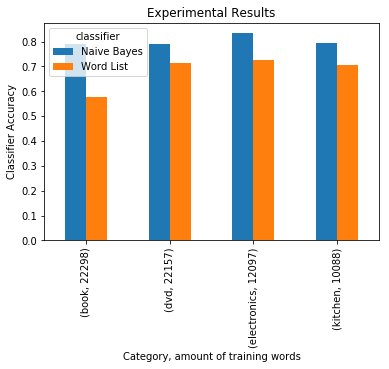

In [11]:
results=[]
for i, category in enumerate(category_list):
    train_data,test_data = get_training_test_data(category)
    
    priors = class_priors(train_data)
    c_probs = cond_probs(train_data)
    known_vocab = known_vocabulary(train_data)
    
    classifiers = {"Word List":WordListClassifier(word_list_size),
               "Naive Bayes":NBClassifier()}
            
    for name,classifier in classifiers.items():
        if name in classifier_type:        
            classifier.train(train_data)
            accuracy=classifier_evaluate(classifier,test_data)
            results.append((category, name, accuracy, len(known_vocab)))

df = pd.DataFrame(results, columns = ['category', 'classifier', 'accuracy', 'words']).groupby(['category', 'words', 'classifier'])['accuracy'].mean().unstack()

display (df)

df1 = df.plot.bar(title = "Experimental Results")
df1.set_ylabel("Classifier Accuracy")
df1.set_xlabel("Category, amount of training words")


Total experimental results:

In [12]:
for name,classifier in classifiers.items():
    print('Mean value of accuracy for {} classifier is {}'.format(name, round(df[name].mean(), 2)))

Mean value of accuracy for Word List classifier is 0.68
Mean value of accuracy for Naive Bayes classifier is 0.8


    An accuracy is the simpliest metric that can be used to evaluate a classifier, it measures the percentage of inputs in test data set that the classifier correctly labeled.
    It can be seen from experimental results that an accuracy between the WordList classifier and the Naive Bayes classifier are different across all four examined categories. I can observe a meaning gap in accuracy between classifiers. The Naive Bayes classifier shows more higher accuracy than WordsList classifier, with a mean value 0.8 and 0.68 respectively.
    
    From the plot above, it is very easy to catch that size of vocabulary does not influence on the classifier accuracy results. The Naive Bayes classifier presents constantly higher accuracy as on 22,000 words so on 12,000 words with the value around 0.8, the same time the WordList Classifier also shows similar accuracy at the categories of 22K, 12K and 10K with approximately 0.71, and only in 'book' category the WorlList presents lower accuracy at 0.57 level. Hence, I can conclude that WordList classifier is less stable than Naive Bayes classifier.
    
    The reasons behind the differences in perfomance of the methods being compared are in the essence of each classification.
    
    The main difference between classifiers is that the Naive Bayes is a probabilistic classifier, the WordList relies on frequency only. 
    In general the Naive Bayes classifier has two significant steps: firstly, it tells the us probability of the observations being in the class by choosing a label for an input value (by calculating the prior probability of each label, which is determined by calculating frequency of each label in the training data); secondly, the contribution from each feature is then combined with this prior probability, to arrive at a likelihood estimate for each label. The label whose likelihood estimate is the highest is then assigned to the input value. Also Naive Bayes calculations, like calculations for language modeling, are done in log space, to avoid underflow and increase speed.
    WordList classifier uses a choice between negative and positive labels, taking in a count occurrence of a feature in positive or negative datasets, and indetifying a class by counting a score as adding or deducting a frequency of every single word due to its appearance in one of the data sets (P/N), otherwise, if the word appears equal times in both sets or did not appear at all, the WordList classifier chooses label for a feature randomly. Hence, when something even particularly is done randomly, it gives uncertainty and influences negatively on the final accuracy.
    One more difference between classifiers is a vocabulary which they take for classification. On the one hand, the Naive Bayes classifier removes all words that aren't in the known vocabulary before starting classification, on the other hand, the WordList classifier take all words into classification process. Therefore, it is also one of the reason a less accurate result for the WordList classifier (I am not talking about removing stopwords, which is applied for both classifiers as a preprocessing step.)
     To sum up everything mentioned above I can say that the Naive Bayes classifier has more detailed approach for a feature classification then WordsList classifier, hence, the Naive Bayes gives better accuracy at different kind of categories with the same high level.

(b) You have investigated the impact on classifier accuracy when the amount of training data is varied. Discuss your findings with regard to the Naïve Bayes classifier, and attempt to predict what the accuracy of the Naïve Bayes classifier would be if you massively increased the amount of training data. \[10 marks\]


At this part I am going to do experiments on classifier's accuracy for the various training data. I am taking sample sizes 10, 100, 200, 500, 700 of positive and negative data for a training data set and calculate metrics for WordList and Naive Bayes classifiers.

In [15]:
#---------------------------------------------

def update_scores(scores,name,cm):
    (p,r,f,a) = scores.get(name,(0,0,0,0))
    scores[name] = (p+cm.precision(),r+cm.recall(),f+cm.f1(), a + cm.accuracy())
    
def sample_data(data,size):
    pos_data = [item for item in data if item[1] == 'P']
    neg_data = [item for item in data if item[1] == 'N']
    return sample(pos_data,size) + sample(neg_data, size)   

def var_training(k, category, sample_sizes):    
    all_results = {}
    for size in sample_sizes:
        print("Calculating Sample Size: {} for Category: {} ".format(size, category))
        scores={} #used to accumulate total precision, recall and f1 scores, for each named classifier, over the runs
        for run in range(k):
            #print("Test run {}".format(run+1))
            training,testing=get_training_test_data(category)
            classifiers={"Word List":WordListClassifier(word_list_size), "Naive Bayes":NBClassifier()}
            training = sample_data(training,size)
            for name,classifier in classifiers.items():
                if name in classifier_type:
                    classifier.train(training)
                    gold_standard = list(zip(*testing))[1]  #Get gold standard labels for test data:
                    predictions = [classifier.classify(doc) for (doc,label) in testing] #Predict labels
                    cm = ConfusionMatrix(predictions,gold_standard)  #Build a confusion matrix
                    update_scores(scores, name, cm)
            all_results[size] = {name: [scores[name][0]/k,scores[name][1]/k,scores[name][2]/k, scores[name][3]/k] for name in classifier_type}
    col1 = sample_sizes
    col2 = [all_results[size]['Word List'][0] for size in sample_sizes]
    col3 = [all_results[size]['Word List'][1] for size in sample_sizes]
    col4 = [all_results[size]['Word List'][2] for size in sample_sizes]
    col8 = [all_results[size]['Word List'][3] for size in sample_sizes]
    col5 = [all_results[size]['Naive Bayes'][0] for size in sample_sizes]
    col6 = [all_results[size]['Naive Bayes'][1] for size in sample_sizes]
    col7 = [all_results[size]['Naive Bayes'][2] for size in sample_sizes]
    col9 = [all_results[size]['Naive Bayes'][3] for size in sample_sizes]
    col10 = [category for size in sample_sizes]    
    return list(zip(col10, col1, col2, col3,  col4, col5, col6, col7, col8, col9))   
    
#--------------------------------------    
#Run experiment for 4 categories
metrics = []
sample_sizes = [10, 100, 200, 300, 400, 500, 600, 700]
for i, category in enumerate(category_list):  
    metrics += var_training(num_of_runs, category, sample_sizes) 
    #print(metrics)
    

Calculating Sample Size: 10 for Category: book 
Calculating Sample Size: 100 for Category: book 
Calculating Sample Size: 200 for Category: book 
Calculating Sample Size: 300 for Category: book 
Calculating Sample Size: 400 for Category: book 
Calculating Sample Size: 500 for Category: book 
Calculating Sample Size: 600 for Category: book 
Calculating Sample Size: 700 for Category: book 
Calculating Sample Size: 10 for Category: dvd 
Calculating Sample Size: 100 for Category: dvd 
Calculating Sample Size: 200 for Category: dvd 
Calculating Sample Size: 300 for Category: dvd 
Calculating Sample Size: 400 for Category: dvd 
Calculating Sample Size: 500 for Category: dvd 
Calculating Sample Size: 600 for Category: dvd 
Calculating Sample Size: 700 for Category: dvd 
Calculating Sample Size: 10 for Category: electronics 
Calculating Sample Size: 100 for Category: electronics 
Calculating Sample Size: 200 for Category: electronics 
Calculating Sample Size: 300 for Category: electronics 
Cal

Presenting metrics and accuracy as a result of experiments: the impact on classifier accuracy when the amount of traning data is varied.

In [16]:
pd.set_option('precision',2)
df = pd.DataFrame(metrics, columns=['Category', "Sample","WL P", "WL R", "WL F1", "NB P", "NB R", "NB F1", "WL A", "NB A"])
df

Category  Sample  WL P  WL R  WL F1  NB P  NB R  NB F1  WL A  NB A
0          book      10  0.58  0.13   0.21  0.55  0.82   0.66  0.52  0.58
1          book     100  0.76  0.32   0.45  0.76  0.54   0.63  0.61  0.68
2          book     200  0.69  0.35   0.46  0.80  0.61   0.69  0.60  0.73
3          book     300  0.80  0.17   0.28  0.83  0.52   0.64  0.56  0.71
4          book     400  0.75  0.33   0.46  0.83  0.63   0.72  0.61  0.75
5          book     500  0.77  0.28   0.41  0.86  0.65   0.74  0.60  0.77
6          book     600  0.77  0.31   0.44  0.85  0.66   0.74  0.61  0.77
7          book     700  0.72  0.26   0.38  0.86  0.70   0.77  0.58  0.79
8           dvd      10  0.56  0.70   0.62  0.66  0.51   0.58  0.57  0.62
9           dvd     100  0.59  0.86   0.70  0.68  0.72   0.70  0.63  0.69
10          dvd     200  0.56  0.92   0.69  0.75  0.74   0.74  0.59  0.74
11          dvd     300  0.60  0.86   0.70  0.80  0.69   0.74  0.64  0.76
12          dvd     400  0.62  0.81   0.70  0.82  0.62   0.71  0.65  0.74
13          dvd     500  0.60  0.83   0.70  0.82  0.63   0.72  0.64  0.75
14          dvd     600  0.62  0.81   0.71  0.83  0.71   0.77  0.66  0.78
15          dvd     700  0.68  0.76   0.72  0.83  0.72   0.77  0.70  0.79
16  electronics      10  0.60  0.29   0.39  0.60  0.28   0.38  0.55  0.55
17  electronics     100  0.70  0.63   0.66  0.80  0.53   0.64  0.68  0.70
18  electronics     200  0.69  0.73   0.71  0.78  0.72   0.75  0.70  0.76
19  electronics     300  0.70  0.72   0.71  0.83  0.79   0.81  0.71  0.82
20  electronics     400  0.75  0.70   0.72  0.86  0.75   0.80  0.73  0.81
21  electronics     500  0.74  0.63   0.68  0.86  0.77   0.81  0.70  0.82
22  electronics     600  0.76  0.62   0.68  0.86  0.79   0.82  0.71  0.83
23  electronics     700  0.75  0.67   0.70  0.85  0.81   0.83  0.72  0.83
24      kitchen      10  0.56  0.54   0.55  0.56  0.67   0.61  0.56  0.57
25      kitchen     100  0.71  0.67   0.69  0.71  0.78   0.74  0.70  0.73
26      kitchen     200  0.63  0.79   0.70  0.76  0.75   0.75  0.67  0.76
27      kitchen     300  0.75  0.70   0.73  0.79  0.75   0.77  0.73  0.77
28      kitchen     400  0.73  0.69   0.71  0.77  0.78   0.78  0.72  0.78
29      kitchen     500  0.70  0.72   0.71  0.79  0.77   0.78  0.70  0.79
30      kitchen     600  0.67  0.74   0.70  0.80  0.79   0.80  0.69  0.80
31      kitchen     700  0.69  0.75   0.72  0.79  0.79   0.79  0.71  0.79

It can be seen from the experiment result that increasing testing data improves an accuracy of both classifiers: WordList and Nauve Bayes (NB). Also I calculates additional metrics to better analyse 
Let us discuss results for NB classifier. For small sample size as 10 I can observe a low accuracy for all for categories: book, dvd, kitchen, electronics as 0.57, 0.62, 0.58 and 0.55 respectively. Look further I can observe that a meaninful evaluation can be performed with as few as 100 samples. So while I continue the experiment on bigger samples as 100, 200 sizes an accuracy of NB classifier have started increasing significantly for almost 0.2 points and I can see an average accuracy for all four domains around 0.72 (which tends to an average value of total accuracy). Then after increasing traning example size to 300-700 I can see that an accuracy is increasing but for some categories it stops at level 500-600 and starting decline. 
For instance, for 'book' category the accuracy for 500-600 samples is not rise and keep value at the level 0.77, just at 700 sample this category shows an adding +0.02 and reach 0.79 accuracy. 
Category 'dvd' presents a stable growth of an accuracy from 400 to 700 samples as 0.74 to 0.79 respectively (I do not take in a count a fluctuation at 300 sample, because its not extreamly high increase (0.76) and on only one sample).
'Electronics' is the same as a previous category shows increasing by growing training data size from 300 to 700, but at this domain I can observe a situation when the highest level of an accuracy has been reached not in a biggest data sample, i.e. training example size 600 returns the highest accuracy 0.83 and it is not growing at 700 sample and keeps the same value 0.83. So I can conclude that there was a sample size, when Naive Baeyes classifier reached its best fit the model.
Also very interesting observations I can observe at category 'kitchen'. At 100 training sample Naive Baeys classifier shows significant growth in comparison to 10 size sample and returns an acuraccy as much as 0.73, while increasing traning data examples from 200 to 600 I can see that the classifier continues increasing value of accuracy from 0.76 to 0.80 respectively. Subsiquently, it can be seen when I evaluate classifier on 700 traning sample the accuracy has started decreasing and moved to 0.79 which is the same as for 500 sample, hence, it could be concidered as a traning model reached overfitting.

Looking more closely at additional metrics for the Naive Bayes classifier, such as precision, recall and F-measure, I can comment that builded models for all four categories fit very good testing data (it makes sense to observe sample sizes over 200 for more realistic overview), because the metric F-measure, which is a harmonic mean of precision and recall, has values close to an accuracy, it shows that training model is well balanced enough. 
On the other hand, the WordList classifier shows more poor results of the model for the 'book' category. I can observe extreamly low recall for through all the samples, for instance, for training examples 200, 300, 400, 500, 700 recall as low as 0.35, 0.17, 0.28, 0.26 respectively. It means the model (and also training data) has some disbalance, in my case as a recall is low then a lot of words the model identifies as negative that actually are positive (incorrect). Unless the accuracy for those samples are very high.
Therefore, cassification accuracy alone can be misleading, but calculating a confusion matrix can give a good idea of what builded classification model is getting right and what types of errors it is making.

I can predict that if I increase an amount of traning data over 70% I will reach overfitting and accuracy will start decreasing, because a testing dataset will be to small and suffer of too poor feature selection with respect to training dataset. 

Taking everything in consideration, I can say that the effect of additional training sample is diminished as the training dataset grows, while we expect performance to grow with model complexity up to a point, after which a model overfits the training dataset.

-----------

Explore what happens to the accuracy of a Naïve Bayes classifier if training the classifier on data from one domain (the source domain), but test on data from a different domain (the target domain). Investigate this issue using the 4 different domains (*book*, *dvd*, *electronics* and *kitchen*) from the Amazon Review Data. 

In [17]:
results=[]
for i, category_train in enumerate(category_list):
    train_data, a = get_training_test_data(category_train)    
    for j, category_test in enumerate(category_list):
        b, test_data = get_training_test_data(category_test)
        classifiers = {"Naive Bayes":NBClassifier()}
        for name,classifier in classifiers.items():
            if name == "Naive Bayes":        
                classifier.train(train_data)
                accuracy=classifier_evaluate(classifier,test_data)
                results.append((category_train, category_test, accuracy))

df_c = pd.DataFrame(results, columns = ['category_train', 'category_test', 'accuracy'])
df_c = pd.pivot_table(index = ['category_train'], columns = ['category_test'] , data = df_c)
display (df_c)

accuracy                          
category_test      book   dvd electronics kitchen
category_train                                   
book               0.79  0.74        0.64    0.63
dvd                0.77  0.79        0.65    0.65
electronics        0.69  0.71        0.83    0.77
kitchen            0.68  0.72        0.77    0.79

I trained Naive Bayes classifier on the data from one domain, but tested it on different domains, as a result for 4 given categories from Amazon data corpus "book", "dvd", "electronics", "kitchen" I got output of 16 crosses variants.
As expected the higher accuracy was presented when I tested on the training data the same category, such as book - book, dvd - dvd, kitchen - kitchen with an accuracy 0.79 for all of them, pair electronics - electronics gave me the highest accuracy within all tested cases with 0.83 value. Have a look at the pairs train-test: dvd-book and kitchen-electronics which indicated a very high accuracy level 0.77, it can be explained of cross topics between categories those, for instance, training dataset 'kitchen' obviously contains words from electronics subject, because lots of kitchen equipment are elenctronic, similar situation with training sample of dvd, which includes themes about books. Others pairs showed very high accuracy also. When I tested categories 'electronics' and 'kitchen' on training examples 'dvd' and 'book' I got an accuracy 0.65 and 0.64-0.63 respectively, hence, 'electronics' and 'kitchen' fitting the models of training sets 'dvd' and 'book' at a very good level even these scores are the lowers in my experiment. Better fit showed a result for testing 'dvd' domain on all others training samples and present an accuracy 0.71-0.74, apparently 'dvd' involves words from topics 'book', 'electronics', 'kitchen'.
Consiquently, I can conclude that it is possible use Naive Bayes classifier to test categories on training models of others categories if its subjects are close by sense or cover connected field, using that approach classifier still presents a very good accuracy level.

## Document Similarity and WordNet


In [18]:
#given code

def normalise(tokenlist):
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

def filter_stopwords(tokenlist):
    #stop = stopwords.words('english')
    return [w for w in tokenlist if w.isalpha() and w not in stopwords]

def stem(tokenlist):
    st=WordNetLemmatizer()
    return [st.lemmatize(token) for token in tokenlist]

   
def make_bow(somestring):
    rep=word_tokenize(somestring)  #step 1
    rep=normalise(rep)   #step 2
    rep=stem(rep)   #step 3
    rep=filter_stopwords(rep)  #step 4
    dict_rep={}
    for token in rep:
        dict_rep[token]=dict_rep.get(token,0)+1  #step 5
    return(dict_rep)

wsj=WSJCorpusReader()
medline=MedlineCorpusReader()

collectionsize=50
collections={"wsj":[],"medline":[]}

for key in collections.keys():
    if key=="wsj":
        generator=wsj.raw()
    else:
        generator=medline.raw()
    while len(collections[key])<collectionsize:
        collections[key].append(next(generator))

bow_collections={key:[make_bow(doc) for doc in collection] for key,collection in collections.items()}

The function make_bow() itself takes a string representation of a document, carries out tokenisation and numeric normalisation and creates a bag-of-words representation, returns a dictionary mapping String-->Int.
Analysing make_bow() function code I can explain that:
* step 1: rep=word_tokenize(somestring) - using function from nltk.tokenize library, tokenize a string 'somestring' to split off punctuation other than periods. It is applicable when creating document representations for document similaruty methods as we need to split documents into separate words.
* step 2: rep=normalise(rep) - using written function we replace numbers with NUM and replaces tokens such as "4th", "1st" and "22nd" with "Nth"; it hepls to normalise numeric data in the list of words.
* step 3: rep=stem(rep) - using nltk.tokenize we steam our normalised list of tokens. Steamming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. Usually we can observe  a considerable amount of the lexical variation in documents, so steamming helps to remove these varied forms of words in an easy way. 
* step 4: rep=filter_stopwords(rep) - we filter out useless data, removing stop words which are a commonly used word (such as “the”, “a”, “an”, “in”) and we do not need them in the data set for calculating similarity, as they do not carry any sence to a topic of documents.
All these steps are essensial before applying similarity methods as we need as much as possible clean data set, which is presented as a set of words, hence, providing an ability to operate with words and define similarity.

Apply a TF-IDF weighting to the representations and then compute: 
* the average cosine similarity of medline documents to each other, 
* the average cosine similarity of WSJ documents to each other,
* the average cosine similarity of medline documents to WSJ documents

TF-IDF is a numerical statistic that is intend to reflect how important a word is to a document. Prepare all necessary functions for requested calculations.

In [19]:
#function dot() takes two documents( represented as a dictionaries) and returns their dot product
def dot(d1,d2):
    if len(d1) < len(d2):
        a = d1
        b = d2
    else:
        a = d2
        b = d1
    dotproduct = 0
    for word,count in a.items():
        dotproduct += count * b.get(word,0)
    return dotproduct

#function cos_sim() takes two documents( represented as a dictionaries) and returns their cosine similarity
def cos_sim(d1,d2):
    numerator = dot(d1,d2)
    denominator = sqrt(dot(d1,d1)*dot(d2,d2))
    return numerator/denominator

def all_similarities(docs1,docs2):
    return [doc_similarities(doc, docs2) for doc in docs1]

def doc_similarities(d, docs):
    return [cos_sim(d,doc) for doc in docs]

#function all_similarities() returns average cosine similarity
def average_similarity(docs1,docs2):
    all_sims = all_similarities(docs1, docs2)
    sum = 0
    for sims in all_sims:
        for sim in sims:
            sum += sim
    return sum/(len(docs1)*len(docs2))

#function doc_freq compute the document frequency for each feature
def doc_freq(doclist):
    df={}
    for doc in doclist:
        for feat in doc.keys():
            df[feat]=df.get(feat,0)+1
            
    return df

#inverse document frequency
def idf(doclist):
    N = len(doclist)
    feat_freqs = doc_freq(doclist)
    idfs = {}
    for feature, freq in feat_freqs.items():
        idfs[feature] = log(N) - log(feat_freqs[feature])
    return idfs

#function convert_to_tfidf that takes two arguments: a list of documents (represented as dictionaries {feat:freq}) 
#a dictionary containing idf values and outputs a list of documents with tfidf weights (i.e., dictionaries {feat:tfidf})
def convert_to_tfidf(docs, idf_values):
    tfidf_docs = []
    for doc in docs:
        tfidf = {}
        for feat,freq in doc.items():
            tfidf[feat] = freq * idf_values.get(feat,10*64)
        tfidf_docs.append(tfidf)
    return tfidf_docs

Applying TF-IDF weighting to the representations of WDJ and Medline documents.

In [20]:
#Convert both of your document collections so that the weights are tfidf values rather than frequencies
all_docs = bow_collections["wsj"] + bow_collections["medline"]
idf_values = idf(all_docs) 
wsj_docs_tfidf = convert_to_tfidf(bow_collections["wsj"], idf_values)
medline_docs_tfidf = convert_to_tfidf(bow_collections["medline"], idf_values)
all_docs_tfidf = {"wsj": wsj_docs_tfidf, "medline": medline_docs_tfidf}

Computing average cosine similarity for all cases WSJ and Medline documents:

In [21]:
collections = ["wsj", "medline"]
for c1 in collections:
    for c2 in collections:
        sim = average_similarity(all_docs_tfidf[c1], all_docs_tfidf[c2])
        print("Average cosine similarity of {} and {}: ".format(c1,c2), sim)        

Average cosine similarity of wsj and wsj:  0.043967149445707614
Average cosine similarity of wsj and medline:  0.0052102752780698175
Average cosine similarity of medline and wsj:  0.0052102752780698106
Average cosine similarity of medline and medline:  0.04889556546927367


According to the results above of calculations average similarity for all cases between WSJ and Medline corpuses I can say that as it was expected the similarity between documents from the same collections is extreamly higher than between different collections.
It can be observed that average similarity for documents from WSJ and WSJ is around 0.044, when medline documents shows slightly higer cosine similarity as 0.049. 

Also it is very clear that documents WSJ and Medline does not similar as its cosine similarity tends to zero with a value 0.005.

The TF-IDF value increases proportionally to the number of times as a word appears in the document and is offset by number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

c). Expand the document representations by adding **synonyms** and **hypernyms** for each **noun** in the document.  For example, 2 occurrences of the word *tiger* should add 2 occurrences of each of the following **lemma_names** found in the WordNet hypernym hierarchy above *tiger*:
* \['tiger', 'Panthera_tigris'\]
* \['big_cat', 'cat'\]
* \['feline', 'felid'\]
* \['carnivore'\]
* \['placental', 'placental_mammal', 'eutherian', 'eutherian_mammal'\]
* \['mammal', 'mammalian'\]
* \['vertebrate', 'craniate'\]
* \['chordate'\]
* \['animal', 'animate_being', 'beast', 'brute', 'creature', 'fauna'\]
* \['organism', 'being'\]
* \['living_thing', 'animate_thing'\]
* \['whole', 'unit'\]
* \['object', 'physical_object'\]
* \['physical_entity'\]
* \['entity'\]

Recompute the similarities calculated in part b).  Discuss your results. \[10 marks\]

I write a function which will take a document as an input doc_dict and return a dictionary of synonyms and hypernyms for each noun in the doc_dict with its frequency within the document.

In [22]:
def syn_hyper_extract(doc_dict):
    parts_of_speech={"noun":wn.NOUN}
    key="noun"
    i = 0
    j = 0
    syn_doc = []
    hyper_doc = []
    a = []
    h = []
    for word, items in doc_dict.items():
        #extract synonyms for the word 
        a += wn.synsets(word, parts_of_speech[key]) 
        for i, v in enumerate(a): #extract synonyms for the word 
            p=0
            for k, value in enumerate(v.lemma_names()):#check all list of lemmas and write in a list syn_doc
                syn_doc.append(value)
            #extract hypernyms and write in a list hyper_doc
            h = lambda s: s.hypernyms()
            for j, vv in enumerate(v.closure(h)): #synsets of hypernyms
                for k1, value1 in enumerate(vv.lemma_names()):
                    hyper_doc.append(value1)
    l = syn_doc + hyper_doc
    return (dict((x, l.count(x)) for x in set(l))) #return dictionary of synonyms and hypernyms

In [23]:
aList = []
output_wsj = []

for i, value in enumerate( bow_collections["wsj"]):
    aList.append(syn_hyper_extract(value))

output_wsj = bow_collections["wsj"] + aList

In [25]:
aList1 = []
output_medline = []

for i, value in enumerate(bow_collections["medline"]):
    aList1.append(syn_hyper_extract(value))

output_medline = bow_collections["medline"] + aList1

In [26]:
all_docs = []
all_docs = output_wsj + output_medline
idf_values = idf(all_docs)

In [27]:
wsj_docs_tfidf = convert_to_tfidf(output_wsj, idf_values)
medline_docs_tfidf = convert_to_tfidf(output_medline, idf_values)
all_docs_tfidf = {"wsj": wsj_docs_tfidf, "medline": medline_docs_tfidf}

collections = ["wsj", "medline"]
for c1 in collections:
    for c2 in collections:
        sim = average_similarity(all_docs_tfidf[c1], all_docs_tfidf[c2])
        print("Average cosine similarity of {} and {}: ".format(c1,c2), sim) 

Average cosine similarity of wsj and wsj:  0.0791345879998448
Average cosine similarity of wsj and medline:  0.08767095183882909
Average cosine similarity of medline and wsj:  0.08767095183882903
Average cosine similarity of medline and medline:  0.1672348804633605


As a result of extending datasets WSJ and Medline corpus I got similarity between collections of documents WSJ and Medline is higher than between documents WSJ itself, to be precise 0.88 is similarity of Medline documents and WSJ documents, while 0,79 of WSJ documents to each other. 

It can be seen I got two different result in comparison to collections without synonyms and hypernyms. Before extending similarity for WSJ&WSJ and Medline&Medline was 0.44 and 0.49, not a big difference. But after extending collections I can observe for WSJ&WSJ and Medline&Medline 0.79 and 0.167 respectively.

Let me discuss what happened with updated collections.

Firstly, I have to say that similarity has increased for all documents as a result of adding synonyms to the nouns, as we know in average there are two synonyms for a noun, hence it increases frequency of features within documents and raise similarity (for example, a noun 'tiger' has synonyms [tiger] and [tiger, panthera_tigris], therefore a frequency of word 'tiger' total increases from  1 to 3, that is significant!). 

Important to notice that if we add synonyms to the document, the frequency of words is getting higher, and it is not changing a sense of document, but hypernyms usually add words with frequency 1 (collecting all words by hierarchy above the noun from my document and they can not be synonyms), consiquently, it does not make higher dot products value.
In general I would say that an amount of hypernyms are greater than a list of synonyms for every noun, according my general knowledge about a language and the WordNet, so the frequency of words lower for hypernyms, but the evidance they can occure in the other documents rise, whereas synonyms add features with high frequency, but less amount of words. 

Therefore, I believe that hypernyms from Medline corpus has an evidence that more hypernyms occurs in other documents and synonyms with high frequency also, all these together bring higher similarity between documents. The same time for WSJ, as this is a finacial journal, the words are linked to different topics together with finance, hence occuring nouns from original documents bring an amount of words-hypernyms which are less occuring in other documents or not occuring, hence gives zero in dot-products elements, therefore the similarity is not increasing.

Also I did not normalize my documents after expanding, before recalculating cosine similarity, so it is also one of the reasons for such high results.

## Supervised Methods for WSD 
Corpus-based methods for word sense disambiguation (WSD). The objective is to build and evaluate a corpus-based, supervised WSD system for words with multiple senses.  

Print a list of the 10 most frequently occurring words with 2 senses (in this corpus). 

In [29]:
freq = []
senses = {}
for i, dic in enumerate(bow_collections["medline"]):
    for word in dic.keys():
        if len(wn.synsets(word)) > 0: 
            senses[word] = len(wn.synsets(word))        
            if senses[word] == 2 : freq.append(word)

#dictionary senses{} contains each word occuring in the medline corpus as a key and how many senses it has as a value.

#to show an example of functionality this code i print out total words and senses.
print('Medline corpus has total {} words, summary {} senses according to WordNet.'.format(len(senses.keys()), sum(senses.values())))

##print out 10 most frequently occurring words with 2 senses (in this corpus)
df = pd.DataFrame(FreqDist(freq).most_common(10), columns = ['feature', 'frequency'])
df

Medline corpus has total 1340 words, summary 7560 senses according to WordNet.


feature  frequency
0     membrane         10
1  temperature          7
2    molecular          7
3       uptake          6
4         data          6
5     molecule          6
6          may          5
7        amino          5
8   phenomenon          5
9        ratio          4

At the table above I presented a list of the 10 most frequently occurring words with 2 senses (in medline corpus). Column "Frequency" is added extra for the information about frequency of a feature (among words in a list of words with 2 senses).

b). A *supervised* WSD algorithm derives model(s) from *sense-annotated corpus data* in order to predict senses of ambiguous words in un-annotated data.  Using the entire document as context, **implement** a supervised word sense disambiguation algorithm to determine the most likely sense of each occurrence of the 3 most frequently occuring words identified in part a).

In [30]:
#extract 3 most frequently occuring words identified in part a)

temp_dict = df[:3].set_index('feature').transpose().to_dict(orient='list')
list_3a = list(temp_dict.keys() )
list_3a

['membrane', 'temperature', 'molecular']

In [97]:
from nltk.corpus import semcor

def extract_tags(taggedsentence):
    '''
    For a tagged sentence in SemCor, identify single words which have been tagged with a WN synset
    taggedsentence: a list of items, some of which are of type wordnet.tree.Tree
    :return: a list of pairs, (word,synset)
    
    '''
    alist=[]
    for item in taggedsentence:
        if isinstance(item,nltk.tree.Tree):   #check with this is a Tree
            print(item.label())
            if isinstance(item.label(),nltk.corpus.reader.wordnet.Lemma) and len(item.leaves())==1:
                #check whether the tree's label is Lemma and whether the tree has a single leaf
                #if so add the pair (lowercased leaf,synsetlabel) to output list
                alist.append((item.leaves()[0].lower(),item.label().synset()))
    return alist
            
def extract_senses(fileid_list):
    '''
    apply extract_tags to all sentences in all documents in a list of file ids
    fileid_list: list of ids
    :return: list of list of (token,tag) pairs, one for each sentence in corpus
    '''
    sentences=[]
    for fileid in fileid_list:
        print("Processing {}".format(fileid))
        sentences+=[extract_tags(taggedsentence) for taggedsentence in semcor.tagged_sents(fileid,tag='sem')]
    return sentences

def find_sense_distributions(sentence_list):
    sense_distributions = {}
    for sentence in sentence_list:
        for word, sense in sentence:
            if word in list_3a: #************FILTER FOR MY LIST OF 3 WORDS***************************
                word_senses = sense_distributions.get(word,{})
                word_senses[sense] = word_senses.get(sense,0) + 1
                sense_distributions[word] = word_senses
    return sense_distributions

def senses(sample_sentences):
    words_with_one_sense = []
    sense_distributions = find_sense_distributions(sample_sentences)
    for word, distribution in sense_distributions.items():
        #if len(distribution) == 1:
        sense = list(distribution)[0]
        words_with_one_sense.append((word, distribution[sense]))
    return words_with_one_sense# sorted(sense, words_with_one_sense, key=lambda word: word[1], reverse=True)

def find_candidates(sentences):
    words_with_two_balanced_senses = []
    sense_distributions = find_sense_distributions(sentences)
    for word, distribution in sense_distributions.items():
        if len(distribution) == 2:
            proportions = sorted(distribution.values())
            if proportions[1]/proportions[0] <= 7/3: # make sure the senses are 'balanced'
                words_with_two_balanced_senses.append((word, proportions[0] + proportions[1], distribution))
    return sorted(words_with_two_balanced_senses, key=lambda word: word[1], reverse=True)
    
    
def contains(sentence,astring):
    '''
    check whether sentence contains astring
    '''
    if len(sentence)>0:
        tokens,tags=zip(*sentence)
        return astring in tokens
    else:
        return False
    
def get_label(sentence,word):
    '''
    get the synset label for the word in this sentence
    '''
    count=0
    label="none"
    for token,tag in sentence:
        if token==word:
            count+=1
            label=str(tag)
    if count !=1:
        #print("Warning: {} occurs {} times in {}".format(word,count,sentence))
        pass
    return label
    
def get_word_data(sentences,word):
    '''
    select sentences containing words and construct labelled data set where each sentence is represented using Bernouilli event model
    '''
    selected_sentences=[sentence for sentence in training_sentences if contains(sentence,word)]
    word_data=[({token:True for (token,tag) in sentence},get_label(sentence,word)) for sentence in selected_sentences] 
    return word_data


In [ ]:
allfiles=semcor.fileids()
len(allfiles)
tagged_sentences=semcor.tagged_sents(allfiles,tag='sem')
some_sentences=extract_senses([allfiles])
some_sentences

Extract all sense distributions from SemCor where my top three words occurs.

In [98]:
list_sense_dist = (find_sense_distributions(some_sentences))
list_sense_dist

{'membrane': {Synset('membrane.n.01'): 1},
 'molecular': {Synset('molecular.a.01'): 6},
 'temperature': {Synset('temperature.n.01'): 75,
  Synset('temperature.n.02'): 1}}

I can observe two of my words one sense and for temperature only two senses.

In [99]:
senses(some_sentences)

[('temperature', 75), ('molecular', 6), ('membrane', 1)]

It was found poor occurence for each of my word in Semcor because the words belong to MEdline corpus and subject between corpesus are different.

Word Sense Disambiguation (WSD) aims to resolve ambiguities in text by identifying the meaning of ambiguous terms.
WSD is always a difficult and important task in natural language processing. In general WSD algorithm takes as input a word in context and a fixed inventory of potential word senses and outputs the correct word sense in context. The input and output depends on the task.

In [40]:
shuffled=list(allfiles)
random.shuffle(shuffled)

In [41]:
training_sentences=extract_senses(shuffled[:300])
testing_sentences=extract_senses(shuffled[300:])

Processing brown2/tagfiles/br-j31.xml
Lemma('not.r.01.not')
Lemma('easy.a.01.easy')
Lemma('therapist.n.01.therapist')
Lemma('spot.v.02.discern')
Lemma('patient.n.01.patient')
Lemma('communication.n.01.communicating')
Lemma('introject.n.01.introject')
Lemma('appear.v.02.appear')
Lemma('hold_sway.v.01.hold_sway')
Lemma('learn.v.01.learn')
Lemma('become.v.01.become')
Lemma('alert.a.01.alert')
Lemma('change.n.01.change')
Lemma('vocal.a.01.vocal')
Lemma('tone.n.01.tone')
Lemma('voice.n.02.voice')
Lemma('suddenly.r.01.suddenly')
Lemma('shift.v.06.shift')
Lemma('timbre.n.01.quality')
Lemma('not.r.01.not')
Lemma('usual.a.01.usual')
Lemma('timbre.n.01.quality')
Lemma('sound.v.03.sound')
Lemma('somehow.r.01.somehow')
Lemma('artificial.s.02.artificial')
some.s.00
Lemma('case.n.01.instance')
Lemma('parrotlike.s.01.parrotlike')
Lemma('message.n.02.content')
Lemma('words.n.01.words')
Lemma('lapse.v.03.lapse')
Lemma('back.r.03.back')
monotonous.s.00
Lemma('repeat.n.01.repetition')
Lemma('phonograph_n

Lemma('assume.v.01.assume')
Lemma('naturally.r.01.of_course')
accumulated.s.00
Lemma('meaning.n.01.meaning')
Lemma('be.v.01.be')
Lemma('built-in.s.01.inherent')
Lemma('stereotype.n.01.stereotype')
Lemma('beginning.n.01.beginning')
Lemma('therapy.n.01.therapy')
one.s.00
Lemma('time.n.01.time')
Lemma('subsequently.r.01.later_on')
Lemma('stereotype.n.01.stereotype')
Lemma('express.v.02.utter')
Lemma('probably.r.01.probably')
Lemma('be.v.01.be')
Lemma('correct.a.01.correct')
Lemma('think_of.v.03.think_of')
Lemma('matter.n.01.matter')
Lemma('well.r.01.well')
Lemma('grooved.s.01.grooved')
Lemma('stereotyped.s.01.stereotyped')
Lemma('manner.n.01.mode')
Lemma('formulation.n.03.expression')
Lemma('a_few.s.01.a_few')
Lemma('other.a.01.other')
Lemma('communicational.s.01.communicational')
Lemma('rut.n.02.groove')
Lemma('so_far.r.01.as_yet')
Lemma('be.v.03.be')
Lemma('there.r.01.there')
Lemma('available.a.01.available')
Lemma('patient.n.01.patient')
Lemma('use.n.01.use')
Lemma('newly.r.01.newly')


Lemma('therefore.r.01.thus')
Lemma('mention.v.01.refer')
Lemma('concrete.a.01.concrete')
Lemma('thing.n.08.thing')
Lemma('incident.n.01.incident')
Lemma('contiguous.s.01.immediate')
Lemma('environment.n.01.environment')
some.s.00
Lemma('symbolic.a.01.symbolic')
Lemma('looking.s.01.sounding')
Lemma('hyperbolic.s.01.hyperbolic')
Lemma('mention.n.01.reference')
Lemma('nonnatural.s.01.transcendental')
Lemma('event.n.01.event')
Lemma('global.s.01.global')
Lemma('picture.n.04.scene')
Lemma('recently.r.01.recently')
Lemma('for_example.r.01.for_example')
Lemma('paranoid.s.01.paranoid')
Lemma('woman.n.01.woman')
Lemma('large-scale.s.01.large-scale')
Lemma('philosophizing.n.01.philosophizing')
Lemma('session.n.01.session')
Lemma('intrusive.a.01.intrusive')
Lemma('curiosity.n.01.curiosity')
Lemma('become.v.02.become')
Lemma('opinion.n.01.opinion')
Lemma('deplorable.s.01.deplorable')
Lemma('feature.n.01.characteristic')
Lemma('mid.s.01.mid')
Lemma('twentieth.s.01.twentieth')
Lemma('century.n.01.ce

Lemma('lead.v.01.take')
NE
Lemma('mumble.v.01.mutter')
Lemma('be.v.01.be')
Lemma('belated.s.01.late')
Lemma('think.v.02.think')
Lemma('sleep_late.v.01.sleep_in')
Lemma('morning.n.01.morning')
Lemma('state.v.01.say')
Lemma('drowsily.r.01.drowsily')
Lemma('cuddle.v.01.snuggle')
Lemma('wonder.v.01.wonder')
Lemma('ever.r.01.ever')
Lemma('attend.v.01.go_to')
Lemma('church_service.n.01.church')
Lemma('desire.v.01.want')
Lemma('attend.v.01.go_to')
Lemma('church_service.n.01.church')
Lemma('wonder.v.01.wonder')
Lemma('probably.r.01.probably')
Lemma('be.v.01.be')
Lemma('topographic_point.n.01.place')
Lemma('experience.v.03.get')
Lemma('feeling.n.01.feeling')
Lemma('certainty.n.01.certainty')
Lemma('security.n.03.security')
Lemma('be.v.01.be')
Lemma('beneficial.s.01.good')
Lemma('be.v.01.be')
Lemma('regrettable.s.01.too_bad')
Lemma('have.v.01.have')
Lemma('feeling.n.01.feeling')
Lemma('church_service.n.01.church')
Lemma('not.r.01.not')
Lemma('hapless.s.01.poor')
Lemma('mother.n.01.mother')
Lemma

Lemma('think.v.02.think')
Lemma('ask.v.02.ask')
Lemma('leave.v.01.leave')
Lemma('be.v.01.be')
Lemma('look.v.01.look')
Lemma('precede.v.04.precede')
Lemma('orient.v.01.point')
Lemma('stop.v.01.stop')
Lemma('put.v.01.place')
Lemma('peer.v.01.peer')
Lemma('push.v.01.push')
Lemma('step.v.01.step')
Lemma('exit.v.01.leave')
Lemma('crowd.v.03.crowd_together')
Lemma('sit.v.01.sit')
Lemma('drip.v.01.drip')
Lemma('poise.v.03.poise')
Lemma('turn.v.01.turn')
Lemma('gaze.v.01.stare')
Lemma('shout.v.01.shout')
Lemma('rap.v.01.rap')
Lemma('shriek.v.01.shrill')
Lemma('chant.v.01.chant')
Lemma('chant.v.01.chant')
Lemma('open.v.01.open')
rock.v.00
Lemma('study.v.05.study')
Lemma('pray.v.01.pray')
Lemma('be.v.01.be')
Lemma('have.v.01.have')
Lemma('frame.v.01.frame')
Lemma('bend.v.01.bend')
Lemma('look.v.01.look')
Lemma('watch.v.01.watch')
Lemma('glance.v.01.glance')
Lemma('think.v.02.guess')
Lemma('discontinue.v.01.stop')
Lemma('plunge.v.05.plunge')
Lemma('rap.v.01.rap')
rock.v.00
Lemma('have.v.01.have')

Lemma('get_down.v.07.begin')
Lemma('see.v.05.regard')
Lemma('barbarous.s.01.savage')
Lemma('beastly.s.02.bestial')
Lemma('unworthy.a.01.unworthy')
Lemma('on_the_other_hand.r.01.on_the_other_hand')
Lemma('wifely.a.01.wifely')
Lemma('domination.n.02.supremacy')
Lemma('take_down.v.02.demean')
Lemma('husband.n.01.husband')
Lemma('run_down.v.06.sap')
Lemma('dignity.n.01.self-respect')
Lemma('overcharge.v.01.rob')
Lemma('maleness.n.01.masculinity')
Lemma('be.v.02.be')
Lemma('prey.n.01.target')
Lemma('ridicule.n.01.ridicule')
Lemma('wife.n.01.wife')
Lemma('frequently.r.01.often')
Lemma('private.a.01.private')
Lemma('personal_business.n.01.affairs')
Lemma('rarely.r.01.rarely')
Lemma('stay.v.01.remain')
Lemma('private.a.01.private')
Lemma('outside.s.03.outside')
Lemma('world.n.02.world')
Lemma('besides.r.02.as_well')
Lemma('marriage.n.02.marriage')
Lemma('survive.v.01.survive')
Lemma('about.r.07.almost')
any.s.01
Lemma('kind.n.01.kind')
Lemma('stress.n.04.stress')
Lemma('open.s.04.open')
Lemma(

Lemma('very.r.01.very')
Lemma('few.a.01.few')
Lemma('wife.n.01.wife')
Lemma('state.v.01.say')
Lemma('person.n.01.person')
Lemma('balance.v.02.balance')
Lemma('checkbook.n.01.checkbook')
Lemma('repair.v.01.fix')
Lemma('car.n.01.car')
Lemma('choose.v.01.choose')
Lemma('family.n.02.family')
Lemma('populate.v.01.live')
Lemma('deal.v.06.deal')
Lemma('shopkeeper.n.01.tradesman')
Lemma('abruptly.r.01.suddenly')
Lemma('become.v.01.become')
Lemma('submissive.a.01.submissive')
Lemma('sexual_activity.n.01.sex')
Lemma('refer.v.02.concern')
Lemma('woman.n.01.woman')
Lemma('dominate.v.03.dominate')
Lemma('other.a.01.other')
Lemma('family.n.02.family')
Lemma('personal_business.n.01.affairs')
Lemma('dominate.v.03.dominate')
Lemma('sexual_relationship.n.01.sexual_relationship')
Lemma('besides.r.02.as_well')
additional.s.00
Lemma('factor.n.01.factor')
Lemma('help.v.03.help')
Lemma('make.v.02.make')
Lemma('woman.n.01.woman')
Lemma('more.r.01.more')
Lemma('sexually.r.01.sexually')
self-assertive.s.00
Lemm

Lemma('become.v.01.become')
Lemma('more.r.01.more')
expressive.s.00
Lemma('own.s.01.own')
Lemma('desire.n.01.desire')
Lemma('more.a.01.more')
Lemma('demanding.a.01.demanding')
Lemma('less.r.01.less')
Lemma('understanding.s.01.understanding')
Lemma('excessively.r.01.too')
Lemma('many.a.01.many')
Lemma('husband.n.01.husband')
Lemma('person.n.01.person')
Lemma('continue.v.02.continue')
worry.v.2;1
Lemma('well.r.01.well')
Lemma('do.v.04.do')
Lemma('fear.v.01.fear')
Lemma('success.n.01.success')
Lemma('depend_on.v.01.depend_on')
some.s.00
Lemma('trick.n.01.trick')
Lemma('technique.n.01.technique')
Lemma('sexual.a.01.sexual')
Lemma('maneuver.n.03.play')
Processing brown1/tagfiles/br-j23.xml
Lemma('place.n.03.place')
Lemma('religion.n.01.religion')
Lemma('simple.a.01.simple')
Lemma('preliterate.s.02.preliterate')
Lemma('society.n.01.society')
Lemma('be.v.01.be')
Lemma('quite.r.02.quite')
Lemma('definite.a.01.definite')
Lemma('complex.a.01.complex')
Lemma('match.v.01.fit')
Lemma('whole.a.01.wh

non.s.00
Lemma('churchgoer.n.01.church_member')
Lemma('free_agent.n.02.freewheeler')
Lemma('fringy.s.01.marginal')
Lemma('religionist.n.01.religionist')
Lemma('and_so_forth.r.01.and_so_on')
Lemma('values.n.01.values')
Lemma('christian.a.01.Christian')
Lemma('civilization.n.01.civilization')
Lemma('internalize.v.01.internalize')
Lemma('furthermore.r.01.furthermore')
Lemma('religion.n.01.religion')
Lemma('tend.v.01.tend')
Lemma('integrate.v.01.integrate')
Lemma('whole.a.01.whole')
Lemma('scope.n.01.range')
Lemma('values.n.01.values')
highest.s.00
Lemma('ultimate.a.01.ultimate')
Lemma('values.n.01.values')
Lemma('god.n.01.God')
Lemma('mediator.n.01.intermediary')
Lemma('subordinate.a.01.subordinate')
Lemma('values.n.01.values')
Lemma('for_example.r.01.for_example')
Lemma('involve.v.01.regard')
Lemma('material.s.01.material')
Lemma('object.n.01.object')
Lemma('matter-of-fact.s.02.pragmatic')
Lemma('goal.n.01.end')
Lemma('finally.r.01.finally')
Lemma('establish.v.05.give')
Lemma('holiness.n

Lemma('code.n.01.code')
Lemma('be.v.02.be')
Lemma('mechanism.n.02.mechanism')
Lemma('training.n.01.training')
Lemma('direct.v.01.direct')
Lemma('enforce.v.01.enforce')
Lemma('uniform.a.01.uniform')
Lemma('social.a.01.social')
Lemma('interaction.n.01.interaction')
Lemma('continually.r.01.continually')
Lemma('publicly.r.01.publicly')
Lemma('confirm.v.02.reassert')
Lemma('solidarity.n.01.solidarity')
Lemma('group.n.01.group')
Lemma('person.n.01.person')
Lemma('notice.v.02.note')
Lemma('long_ago.r.01.long_ago')
Lemma('religion.n.01.religion')
Lemma('incorporate.s.01.unified')
Lemma('arrangement.n.03.system')
belief.n.00
Lemma('practice.n.01.practice')
Lemma('relative.a.01.relative')
Lemma('sacred.a.01.sacred')
Lemma('thing.n.03.thing')
Lemma('unite.v.01.unite')
Lemma('one.s.01.one')
Lemma('individual.a.01.single')
Lemma('moral.a.01.moral')
Lemma('community.n.01.community')
Lemma('all.a.01.all')
Lemma('adhere.v.01.adhere')
Lemma('opinion.n.01.view')
Lemma('be.v.02.be')
every.s.01
Lemma('rel

Lemma('be.v.01.be')
Lemma('true.a.01.true')
Lemma('differentiation.n.01.distinction')
Lemma('expressive_style.n.01.style')
Lemma('idea.n.01.idea')
Lemma('frequently.r.01.often')
Lemma('border_on.v.01.approach')
Lemma('arbitrary.a.01.arbitrary')
Lemma('in_the_long_run.r.01.in_the_end')
Lemma('admit.v.01.admit')
Lemma('expressive_style.n.01.style')
Lemma('message.n.02.content')
Lemma('frequently.r.01.frequently')
Lemma('influence.v.01.influence')
Lemma('interpenetrate.v.01.interpenetrate')
Lemma('sometimes.r.01.sometimes')
Lemma('appear.v.02.appear')
Lemma('expression.n.02.expression')
Lemma('same.a.01.same')
Lemma('penetration.n.02.insight')
Lemma('generally.r.02.in_general')
Lemma('argue.v.01.argue')
Lemma('scholar.n.01.student')
Lemma('target.v.01.direct')
Lemma('primary.a.01.primary')
Lemma('emphasis.n.01.emphasis')
Lemma('attention.n.01.attention')
Lemma('point.n.06.point')
Lemma('working.s.02.working')
Lemma('definition.n.01.definition')
Lemma('idea.n.01.idea')
Lemma('be.v.01.be')


Lemma('thus.r.02.thus')
Lemma('trace.v.01.trace')
Lemma('notion.n.02.notion')
Lemma('individual.a.01.individual')
Lemma('autonomy.n.01.autonomy')
Lemma('manifestation.n.01.manifestation')
religious.a.00
Lemma('practice.n.01.practice')
Lemma('theological.a.01.theological')
Lemma('contemplation.n.02.reflection')
Lemma('practical.a.01.practical')
Lemma('politics.n.03.politics')
Lemma('political.a.01.political')
Lemma('theory.n.01.theory')
Lemma('literature.n.01.literature')
Lemma('art.n.01.art')
Lemma('last.r.02.finally')
Lemma('notice.v.02.note')
Lemma('idea.n.01.idea')
Lemma('appear.v.02.appear')
Lemma('educational.a.01.educational')
Lemma('theory.n.01.theory')
Lemma('influence.n.01.influence')
Lemma('be.v.01.be')
Lemma('now.r.04.at_present')
Lemma('far-flung.s.01.widespread')
Lemma('deny.v.02.deny')
such.s.00
Lemma('across-the-board.s.01.broad')
Lemma('development.n.04.development')
Lemma('passage.n.01.transition')
Lemma('be.v.01.be')
Lemma('great.s.02.great')
Lemma('intrinsic.a.01.int

Lemma('assert.v.01.maintain')
Lemma('shape.v.02.form')
Lemma('be.v.02.be')
Lemma('have.v.01.have')
Lemma('secede.v.01.secede')
Lemma('write.v.04.write')
Lemma('make.v.02.make')
Lemma('be.v.01.be')
Lemma('declare.v.01.declare')
Lemma('secede.v.01.secede')
Lemma('get_down.v.07.begin')
Lemma('announce.v.02.declare')
Lemma('be.v.01.be')
Lemma('create.v.02.create')
Lemma('take.v.06.read')
Lemma('be.v.01.be')
Lemma('create.v.02.create')
Lemma('get.v.01.get')
Lemma('read.v.02.read')
Lemma('be.v.01.be')
Lemma('create.v.02.create')
Lemma('come.v.04.come')
Lemma('choose.v.02.prefer')
Lemma('emigrate.v.01.emigrate')
Lemma('make.v.03.make')
Lemma('love.v.01.love')
Lemma('take.v.19.take')
Lemma('exert.v.01.exercise')
Lemma('secede.v.01.secede')
Lemma('form.v.01.form')
Lemma('style.v.01.style')
Lemma('see.v.01.see')
Lemma('mention.v.01.cite')
Lemma('be.v.02.be')
Lemma('differ.v.01.differ')
Lemma('imitate.v.01.copy')
Lemma('operate.v.01.operate')
Lemma('make.v.03.make')
Lemma('believe.v.01.believe')


Lemma('hope.v.01.hope')
Lemma('make.v.03.create')
Lemma('recognition.n.01.recognition')
Lemma('department.n.01.department')
Lemma('abroad.s.01.overseas')
Lemma('fall_upon.v.01.come_across')
little.s.00
Lemma('thing.n.01.thing')
Lemma('fail.v.02.go_wrong')
Lemma('have.v.01.have')
Lemma('duty.n.01.responsibility')
Lemma('bring.v.01.bring')
Lemma('care.n.01.attention')
Lemma('make.v.01.do')
Lemma('department_of_state.n.01.Department_of_State')
Lemma('assume.v.05.take')
Lemma('primary.a.01.primary')
Lemma('duty.n.01.responsibility')
Lemma('foreign_policy.n.01.foreign_policy')
Lemma('capital.n.06.Washington')
Lemma('follow.v.03.follow')
Lemma('ambassador.n.01.ambassador')
Lemma('ask.v.04.expect')
Lemma('take_hold.v.01.take_charge')
Lemma('overseas.r.02.overseas')
Lemma('not.r.01.not')
Lemma('entail.v.01.mean')
Lemma('strictly.r.01.purely')
Lemma('bureaucratic.a.01.bureaucratic')
sense.n.00
Lemma('active.a.07.active')
Lemma('operational.s.04.operational')
Lemma('interested.a.01.interested')


Lemma('doubt.v.01.doubt')
Lemma('for_example.r.01.for_example')
Lemma('three.s.01.3')
Lemma('calendar_month.n.01.month')
Lemma('leadership.n.02.leadership')
Lemma('get_down.v.07.begin')
Lemma('discourse.v.01.talk_about')
Lemma('come.v.04.come')
Lemma('constitute.v.01.be')
NE
Lemma('public_opinion.n.01.public_opinion')
Lemma('expert.n.01.expert')
Lemma('state.v.01.say')
Lemma('nation.n.02.country')
Lemma('accept.v.03.accept')
such.s.00
Lemma('proposal.n.01.proposal')
Lemma('problem.n.01.problem')
Lemma('policy.n.02.policy')
Lemma('officeholder.n.01.officer')
Lemma('mind.n.01.mind')
Lemma('thus.r.02.thus')
Lemma('get_down.v.07.begin')
Lemma('form.v.03.take_shape')
Lemma('galaxy.n.01.galaxy')
utterly.r.00
Lemma('complicated.s.01.complicated')
Lemma('component.n.01.factor')
Lemma('political.a.01.political')
Lemma('military.a.01.military')
Lemma('economic.a.01.economic')
Lemma('fiscal.a.01.financial')
Lemma('legal.a.02.legal')
Lemma('legislative.a.02.legislative')
Lemma('procedural.a.01.pro

Lemma('enter.v.01.enter')
Lemma('walk.v.01.walk')
Lemma('head.v.01.head')
Lemma('believe.v.01.believe')
Lemma('be.v.02.be')
Lemma('remember.v.01.remember')
Lemma('hope.v.01.hope')
Lemma('enable.v.01.enable')
Lemma('carry_through.v.01.accomplish')
Lemma('be.v.01.be')
Lemma('exsert.v.01.extend')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('peep.v.03.chirp')
Lemma('chatter.v.04.chatter')
Lemma('caress.v.01.caress')
Lemma('be.v.01.be')
Lemma('think.v.01.think')
Lemma('respond.v.03.respond')
Lemma('have.v.01.have')
Lemma('fear.v.02.fear')
Lemma('whisper.v.01.whisper')
Lemma('pass.v.01.pass')
Lemma('be.v.01.be')
Lemma('dwell.v.02.lie')
Lemma('err.v.01.err')
Lemma('fail.v.01.fail')
Lemma('understand.v.02.understand')
Lemma('feel.v.01.feel')
Lemma('walk.v.01.walk')
Lemma('agitate.v.06.disturb')
Lemma('enter.v.01.enter')
Lemma('be.v.01.be')
Lemma('pass.v.01.pass')
Lemma('reawaken.v.01.reawaken')
Lemma('see.v.05.regard')
Lemma('approach.v.01.near')
Lemma('search.v.01.seek')
Lemma('be.v.01.be')

Lemma('treatment.n.03.treatment')
Lemma('jew.n.01.Jew')
NE
Lemma('shakespeare.n.01.Shakespeare')
Lemma('give.v.01.give')
Lemma('graphic.s.05.vivid')
Lemma('mental_picture.n.01.picture')
Lemma('person.n.01.person')
Lemma('probably.r.01.probably')
Lemma('never.r.01.never')
Lemma('see.v.01.see')
Lemma('jew.n.01.Jew')
Lemma('travel.n.01.travel')
Lemma('jew.n.01.Jew')
Lemma('banish.v.02.banish')
Lemma('england.n.01.England')
Lemma('not.r.01.not')
Lemma('permit.v.01.permit')
Lemma('return.v.01.return')
Lemma('shakespeare.n.01.Shakespeare')
Lemma('be.v.01.be')
Lemma('dead.a.01.dead')
Lemma('year.n.01.year')
Lemma('miss.v.09.escape')
Lemma('ejection.n.02.expulsion')
Lemma('hide.v.02.hide')
Lemma('surely.r.01.certainly')
Lemma('not.r.01.not')
Lemma('frequent.v.02.frequent')
Lemma('marketplace.n.02.marketplace')
Lemma('shakespeare.n.01.Shakespeare')
Lemma('not.r.01.not')
Lemma('normally.r.01.usually')
Lemma('invent.v.01.invent')
Lemma('incident.n.01.incident')
Lemma('play.n.01.play')
Lemma('adop

Lemma('bankruptcy.n.01.bankruptcy')
Lemma('remind.v.01.remind')
Lemma('however.r.01.however')
Lemma('freedom_of_thought.n.01.freedom_of_thought')
Lemma('discussion.n.02.discussion')
Lemma('unchained.s.01.unfettered')
Lemma('exchange.n.04.exchange')
Lemma('idea.n.01.idea')
Lemma('be.v.01.be')
Lemma('basic.a.01.basic')
Lemma('political_system.n.01.form_of_government')
Lemma('assuredly.r.01.assuredly')
Lemma('political_campaign.n.01.political_campaign')
Lemma('exist.v.01.be')
Lemma('freedom.n.01.freedom')
Lemma('think.v.03.think')
Lemma('analyze.v.01.examine')
Lemma('issue.n.01.issue')
Lemma('talk.v.01.speak')
Lemma('restraint.n.01.restraint')
Lemma('consequence.n.01.result')
Lemma('be.v.01.be')
Lemma('heartening.s.01.heartening')
may.v.00
Lemma('state.v.01.state')
with_confidence.r.00
such.s.00
Lemma('exhibition.n.01.exhibition')
Lemma('democracy.n.02.republic')
Lemma('find.v.10.find')
greatest.s.00
Lemma('security.n.01.security')
must_not.v.00
Lemma('forget.v.01.forget')
Lemma('to_be_su

Lemma('increasing.a.01.increasing')
Lemma('anemia.n.01.anemia')
Lemma('triamcinolone.n.01.triamcinolone')
Lemma('eight.s.01.8')
Lemma('milligram.n.01.mg')
Lemma('daily.r.01.daily')
Lemma('begin.v.03.start')
Lemma('february.n.01.Feb')
Lemma('continue.v.03.continue')
Lemma('july.n.01.July')
Lemma('september.n.01.September')
Lemma('patient.n.01.patient')
Lemma('grow.v.08.develop')
Lemma('generalized.s.01.generalized')
Lemma('failing.n.01.weakness')
fatigue.n.00
Lemma('be.v.01.be')
Lemma('coincident.s.01.concurrent')
Lemma('aggravation.n.03.exacerbation')
Lemma('anemia.n.01.anemia')
Lemma('hemoglobin.n.01.hemoglobin')
Lemma('be.v.01.be')
Lemma('gram.n.01.gm')
Lemma('attempt.n.01.attempt')
Lemma('turn_back.v.05.reverse')
downhill.s.01
Lemma('tendency.n.04.trend')
Lemma('stimulate.v.04.stimulate')
Lemma('marrow.n.01.bone_marrow')
Lemma('control.v.02.control')
Lemma('hemolytic.a.01.hemolytic')
Lemma('component.n.03.component')
Lemma('triamcinolone.n.01.triamcinolone')
Lemma('sixteen.s.01.16')

Lemma('severe.s.01.severe')
Lemma('back.n.01.back')
Lemma('pain.n.01.pain')
Lemma('june.n.01.June')
Lemma('motivate.v.01.prompt')
Lemma('third.s.01.third')
Lemma('hospital.n.01.hospital')
Lemma('admission.n.01.admission')
Lemma('extensive.s.01.extensive')
Lemma('osteoporosis.n.01.osteoporosis')
Lemma('partial.s.01.partial')
Lemma('collapse.n.01.collapse')
Lemma('detect.v.01.find')
Lemma('high.a.01.high')
Lemma('protein.n.01.protein')
Lemma('diet.n.01.diet')
Lemma('calcium_lactate.n.01.calcium_lactate')
Lemma('accessory.n.02.supplement')
Lemma('norethindrone.n.01.norethandrolone')
Lemma('fail.v.01.fail')
Lemma('change.v.01.change')
Lemma('skeletal.a.01.skeletal')
Lemma('ailment.n.01.complaint')
Lemma('severe.s.01.severe')
Lemma('muscle.n.01.muscle')
Lemma('failing.n.01.weakness')
terminal.s.00
Lemma('hospital.n.01.hospital')
Lemma('admission.n.01.admission')
Lemma('june.n.01.June')
Lemma('necessitate.v.01.necessitate')
Lemma('continued.a.01.continued')
Lemma('failing.n.01.weakness')
Lem

Lemma('liver.n.01.liver')
Lemma('weigh.v.01.weigh')
Lemma('gram.n.01.gm')
Lemma('be.v.01.be')
Lemma('brown.s.01.brown')
Lemma('color.n.01.color')
Lemma('cut.a.01.cut')
Lemma('surface.n.02.surface')
Lemma('mottle.v.01.mottle')
Lemma('irregular.a.01.irregular')
Lemma('pale.s.03.pale')
Lemma('area.n.03.area')
Lemma('microscopically.r.01.microscopically')
Lemma('be.v.05.be')
Lemma('hyperemia.n.01.hyperemia')
Lemma('central.a.02.central')
Lemma('vein.n.01.vein')
Lemma('be.v.05.be')
Lemma('some.a.01.some')
Lemma('atrophy.n.01.atrophy')
Lemma('adjacent.s.01.adjacent')
Lemma('parenchyma.n.01.parenchyma')
Lemma('some.a.01.some')
Lemma('liver.n.01.liver')
Lemma('cord.n.01.cord')
Lemma('cell.n.02.cell')
Lemma('hold.v.11.contain')
Lemma('vacuolate.a.01.vacuolated')
Lemma('cytoplasm.n.01.cytoplasm')
Lemma('have.v.02.have')
Lemma('minor.s.10.small')
Lemma('measure.n.02.amount')
Lemma('brown.s.01.brown')
Lemma('hemosiderin.n.01.hemosiderin')
Lemma('pigment.n.01.pigment')
Lemma('gallbladder.n.01.gallb

Lemma('show.v.01.show')
Lemma('atrophy.n.01.atrophy')
Lemma('vary.v.03.vary')
Lemma('degree.n.02.degree')
Lemma('injury.n.01.injury')
Lemma('range.v.01.range')
Lemma('swelling.n.01.swelling')
Lemma('vacuolization.n.01.vacuolization')
Lemma('focal.s.01.focal')
Lemma('necrosis.n.01.necrosis')
Lemma('muscle_cell.n.01.muscle_fiber')
Lemma('change.n.04.change')
Lemma('be.v.01.be')
Lemma('most.r.01.most')
Lemma('marked.s.01.marked')
Lemma('gastrocnemius.n.01.gastrocnemius')
Lemma('biceps.n.01.biceps')
Lemma('less.r.01.less')
Lemma('apparent.s.01.evident')
Lemma('pectoral.n.01.pectoralis')
Lemma('diaphragm.n.02.diaphragm')
transversus.n.00
Lemma('gastrocnemius.n.01.gastrocnemius')
Lemma('biceps.n.01.biceps')
Lemma('be.v.05.be')
Lemma('many.a.01.many')
swollen.s.00
Lemma('homogeneous.a.01.homogeneous')
Lemma('necrotic.a.01.necrotic')
Lemma('fiber.n.01.fiber')
Lemma('show.v.01.show')
Lemma('figure.n.01.figure')
such.s.00
swollen.s.00
Lemma('fiber.n.01.fiber')
Lemma('be.v.01.be')
Lemma('profound

Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('cut.v.01.cut')
Lemma('burst.v.01.burst')
Lemma('chamber.v.01.chamber')
Lemma('be.v.02.be')
Lemma('open_fire.v.01.fire')
Lemma('convert.v.01.convert')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('test.v.01.test')
Lemma('be.v.01.be')
Lemma('let.v.01.allow')
Lemma('hit.v.02.hit')
Lemma('make.v.01.do')
Lemma('hold.v.02.hold')
Lemma('be.v.01.be')
Lemma('entail.v.01.mean')
Lemma('witness.v.02.see')
Lemma('introduce.v.02.introduce')
Lemma('be.v.03.be')
Lemma('be.v.02.be')
Lemma('have.v.02.have')
Lemma('vary.v.03.vary')
Lemma('include.v.01.include')
Lemma('include.v.01.include')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('produce.v.02.make')
Lemma('have.v.02.have')
Lemma('use.v.01.use')
Lemma('introduce.v.02.introduce')
Lemma('be.v.01.be')
Lemma('be.v.02.be')
Lemma('give.v.01.give')
Lemma('be.v.01.be')
Lemma('manage.v.02.handle')
Lemma('make.v.16.make')
Lemma('be.v.02.be')
Lemma('hold.v.10.hold')
Lemma('be.v.01.be')
Lemma('test.v.01.try')
Lem

Lemma('therefore.r.01.thus')
Lemma('new.a.01.new')
Lemma('practice.n.01.pattern')
Lemma('day.n.04.day')
Lemma('get_down.v.07.begin')
Lemma('develop.v.09.develop')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('die.v.01.die')
Lemma('lie.v.02.lie')
Lemma('inactive.s.10.still')
Lemma('bed.n.01.bed')
Lemma('head.n.01.head')
Lemma('barely.r.01.hardly')
Lemma('indent.v.03.dent')
Lemma('pillow.n.01.pillow')
Lemma('sometimes.r.01.sometimes')
Lemma('open.v.01.open')
Lemma('eye.n.01.eye')
Lemma('look_around.v.01.look_around')
Lemma('sometimes.r.01.sometimes')
Lemma('consume.v.02.take')
Lemma('a_bit.r.01.a_little')
Lemma('milk.n.01.milk')
Lemma('soup.n.01.soup')
Lemma('discontinue.v.01.stop')
Lemma('expect.v.01.expect')
Lemma('die.v.01.die')
next.s.01
Lemma('minute.n.01.minute')
Lemma('merely.r.01.only')
next.s.01
Lemma('day.n.03.day')
Lemma('two.s.01.two')
Lemma('drive.v.01.drive')
Lemma('hundred.n.01.hundred')
Lemma('mile.n.01.mile')
Lemma('burial.n.01.burial')
Lemma('not.r.01.not')
L

Lemma('person.n.01.person')
Lemma('try.v.01.try')
Lemma('induce.v.02.get')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('cook.v.03.cook')
Lemma('bring.v.01.bring')
Lemma('home.r.01.home')
Lemma('cook.v.02.cook')
Lemma('whole.a.01.whole')
Lemma('antelope.n.01.antelope')
Lemma('proclaim.v.02.exclaim')
n't.r.00
Lemma('even.r.01.even')
Lemma('cook.v.02.cook')
Lemma('piece.n.01.piece')
Lemma('antelope.n.01.antelope')
Lemma('steak.n.01.steak')
Lemma('never.r.01.never')
Lemma('even.r.01.even')
Lemma('see.v.01.see')
Lemma('desire.v.01.want')
Lemma('roast.v.01.roast')
whole_thing.n.00
Lemma('get.v.03.have')
Lemma('son.n.01.boy')
Lemma('person.n.01.person')
Lemma('state.v.01.tell')
n't.r.00
Lemma('make.v.01.do')
Lemma('grandma.n.01.grandma')
Lemma('die.v.01.die')
Lemma('state.v.01.say')
Lemma('eat.v.01.eat')
n't.r.00
n't.r.00
Lemma('die.v.01.die')
Lemma('person.n.01.person')
Lemma('feel_like.v.01.feel_like')
Lemma('abscond.v.01.go_off')
Lemma('bedroom.n.01.bedroom')
Lemma('cry.v.02.

Lemma('let.v.01.let')
Lemma('speculate.v.01.suppose')
Lemma('animal.n.01.animal')
Lemma('not.r.01.not')
Lemma('in_fact.r.01.in_fact')
Lemma('fall.v.01.fall')
Lemma('trap.n.01.trap')
Lemma('not.r.01.not')
Lemma('suffer.v.06.suffer')
Lemma('at_all.r.01.at_all')
Lemma('mistakenly.r.01.mistakenly')
Lemma('believe.v.01.believe')
Lemma('allege.v.01.say')
Lemma('agony.n.02.suffering')
Lemma('be.v.01.be')
Lemma('evil.a.01.evil')
Lemma('thing.n.01.thing')
Lemma('positivist.a.01.positivist')
Lemma('theory.n.01.theory')
Lemma('try.v.01.seek')
Lemma('express.v.01.express')
Lemma('call.v.02.call')
Lemma('evil.a.01.evil')
Lemma('first.a.01.first')
Lemma('case.n.01.case')
Lemma('be.v.01.be')
Lemma('still.r.01.still')
Lemma('present.a.02.present')
Lemma('second.s.01.second')
only.s.00
Lemma('sense.n.02.sense')
Lemma('bad.n.01.badness')
Lemma('involve.v.01.involve')
Lemma('at_all.r.01.at_all')
Lemma('be.v.01.be')
Lemma('bad.a.01.bad')
Lemma('first.a.01.first')
Lemma('case.n.01.case')
Lemma('be.v.01.be'

Lemma('allege.v.01.say')
Lemma('be.v.02.be')
Lemma('permit.v.01.permit')
Lemma('exist.v.01.be')
Lemma('justify.v.01.justify')
Lemma('know.v.02.know')
Lemma('mean.v.01.mean')
Lemma('balance.v.01.balance')
Lemma('intend.v.01.intend')
Lemma('perform.v.01.do')
Lemma('perform.v.01.do')
Lemma('be.v.01.be')
Lemma('permit.v.01.allow')
Lemma('look.v.02.seem')
Lemma('exist.v.01.be')
Lemma('repel.v.01.repel')
Lemma('justify.v.01.warrant')
Lemma('mean.v.01.mean')
Lemma('know.v.02.know')
Lemma('mean.v.01.mean')
Lemma('permit.v.01.permit')
Lemma('discourse.v.01.talk_about')
Lemma('discourse.v.01.talk_about')
Lemma('perform.v.01.do')
Lemma('be.v.01.be')
Lemma('lead.v.03.lead')
Lemma('perform.v.01.do')
Lemma('discourse.v.01.talk_about')
Lemma('cause.v.01.cause')
Lemma('cause.v.01.cause')
Lemma('will.v.02.will')
Lemma('intend.v.01.intend')
Lemma('intend.v.01.intend')
Lemma('intend.v.01.intend')
Lemma('perform.v.01.do')
Lemma('anticipate.v.03.foreknow')
Lemma('be.v.05.be')
Lemma('be.v.02.be')
Lemma('per

Lemma('try.v.01.try')
Lemma('teach.v.01.teach')
Lemma('other.a.01.other')
Lemma('male_child.n.01.boy')
Lemma('kick.v.01.kick')
Lemma('experience.v.03.get')
Lemma('feel.n.01.feel')
Lemma('exercise.n.03.practice')
Lemma('help.v.01.help')
Lemma('make.v.02.get')
Lemma('timing.n.01.timing')
Lemma('down.s.05.down')
Lemma('rather.r.02.kind_of')
Lemma('golf.n.01.golf')
n't.r.00
Lemma('swing.v.05.swing')
Lemma('golf_club.n.02.club')
Lemma('very.r.01.very')
Lemma('frequently.r.01.often')
Lemma('timing.n.01.timing')
Lemma('become.v.01.get')
Lemma('off.s.02.off')
Lemma('person.n.01.person')
Lemma('however.r.01.however')
Lemma('kick.v.01.kick')
Lemma('merely.r.01.only')
Lemma('ten.s.01.10')
Lemma('twelve.s.01.12')
extra_points.n.00
Lemma('exercise.n.03.practice_session')
Lemma('kick.v.01.kick')
Lemma('overmuch.r.01.too_much')
Lemma('leg.n.01.leg')
Lemma('become.v.01.get')
Lemma('rather.r.02.kinda')
Lemma('all_in.s.01.dead')
Lemma('explain.v.01.explain')
Lemma('first.a.01.first')
Lemma('three.s.01.t

Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('solve.v.01.solve')
Lemma('quarterback.n.01.quarterback')
Lemma('problem.n.01.problem')
Lemma('head.v.01.head')
Lemma('direction.n.01.way')
Lemma('person.n.01.person')
Lemma('own.v.01.have')
Lemma('thing.n.07.thing')
Lemma('two.s.01.two')
Lemma('mumble.v.01.mutter')
Lemma('dallas.n.01.Dallas')
Lemma('defensive.a.01.defensive')
Lemma('unit.n.03.unit')
turn_in.v.00
another.s.00
Lemma('glorious.s.03.splendid')
Lemma('attempt.n.01.effort')
Lemma('denver.n.01.Denver')
Lemma('group.n.01.group')
Lemma('be.v.01.be')
Lemma('able.a.01.able')
Lemma('worst.v.01.whip')
Lemma('dangerous.a.01.dangerous')
Lemma('group.n.01.group')
Lemma('fullback.v.01.fullback')
Lemma('top.a.01.top')
Lemma('ace.n.03.star')
Lemma('person.n.01.person')
Lemma('team.n.01.team')
Lemma('place_kick.n.01.place-kicking')
Lemma('nurse.v.01.nurse')
Lemma('knee.n.01.knee')
Lemma('injury.n.02.injury')
Lemma('interior.a.01.interior')
Lemma('line.n.03.line')
Lemma('lineba

Lemma('last.s.01.last')
Lemma('may.n.01.May')
Lemma('group.n.01.group')
Lemma('stand.v.02.stand')
Lemma('end.v.02.end')
Lemma('two.s.01.two')
Lemma('season.n.01.season')
Lemma('slump.n.01.falloff')
Lemma('milestone.n.01.milestone')
Lemma('group.n.01.group')
Lemma('be.v.01.be')
Lemma('may.n.01.May')
Lemma('year.n.01.year')
Lemma('subsequently.r.01.later')
Lemma('be.v.01.be')
Lemma('saint_louis.n.02.St._Louis')
Lemma('baseball_club.n.01.club')
Lemma('be.v.01.be')
Lemma('may.n.01.May')
Lemma('merely.r.01.just')
Lemma('four.s.01.four')
Lemma('time.n.01.time')
Lemma('team.n.01.team')
Lemma('be.v.01.be')
Lemma('indifferent.s.09.so-so')
Lemma('beginning.n.01.beginning')
Lemma('then.r.01.then')
Lemma('fall.v.03.fall')
Lemma('low.a.01.low')
Lemma('may.n.01.May')
Lemma('finish_up.v.02.finish')
Lemma('victory.n.01.victory')
Lemma('group.n.01.group')
Lemma('be.v.01.be')
Lemma('may.n.01.May')
Lemma('end.v.03.end')
Lemma('victory.n.01.triumph')
Lemma('baseball_club.n.01.club')
Lemma('acme.n.01.top')

Lemma('person.n.01.person')
Lemma('inherit.v.01.inherit')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('bring_up.v.03.bring_up')
Lemma('person.n.01.person')
Lemma('class.n.05.class')
Lemma('major_league.n.01.majors')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('speed.n.01.speed')
Lemma('power.n.02.power')
Lemma('body.n.01.body')
Lemma('beautiful.a.01.beautiful')
Lemma('see.v.01.see')
Lemma('person.n.01.person')
Lemma('desire.v.01.want')
Lemma('ordinal_number.n.01.no.')
Lemma('seven.n.01.7')
Lemma('be.v.01.be')
not_only.r.00
Lemma('best.a.01.best')
Lemma('homer.n.01.home_run')
Lemma('batter.n.01.hitter')
Lemma('besides.r.02.also')
Lemma('best.a.01.best')
Lemma('bunter.n.01.bunter')
Lemma('base_runner.n.01.base_runner')
Lemma('outfielder.n.01.outfielder')
Lemma('person.n.01.person')
Lemma('probably.r.01.probably')
Lemma('preach.v.02.preach')
Lemma('overmuch.r.01.too_much')
Lemma('early.a.01.early')
Lemma('day.n.02.day')
Lemma('child.n.01.kid')
L

Lemma('church.n.02.church')
Lemma('large.a.01.big')
Lemma('car.n.01.car')
Lemma('tool.v.01.tool')
Lemma('road.n.01.road')
Lemma('drive.v.01.drive')
Lemma('headlight.n.01.headlight')
Lemma('brush.v.04.sweep')
Lemma('expressway.n.01.pike')
Lemma('ahead.r.01.ahead')
Lemma('reach.v.01.hit')
Lemma('college.n.01.college')
Lemma('expansiveness.n.01.expansiveness')
quaint.s.00
Lemma('small.a.01.little')
Lemma('pine.n.02.pine')
Lemma('board.n.02.board')
Lemma('motor_hotel.n.01.tourist_court')
Lemma('cabin.n.02.cabin')
Lemma('actually.r.01.really')
Lemma('cunning.s.01.cute')
Lemma('naked.s.02.naked')
Lemma('light_bulb.n.01.light_bulb')
Lemma('ceiling.n.01.ceiling')
Lemma('unfrosted.s.01.unfrosted')
Lemma('naked.s.02.naked')
Lemma('streetlight.n.01.streetlight')
Lemma('corner.n.04.corner')
Lemma('play.v.05.play')
Lemma('be.v.01.be')
Lemma('child.n.01.kid')
Lemma('watch.v.01.watch')
Lemma('bat.n.01.bat')
Lemma('pounce.v.01.swoop')
Lemma('bug.n.01.bug')
Lemma('watch.v.01.watch')
Lemma('between.r.01

Lemma('stay.v.01.stay')
Lemma('quiet.a.02.quiet')
Lemma('attend.v.05.hang')
Lemma('not.r.01.not')
Lemma('state.v.01.say')
Lemma('state.v.01.say')
Lemma('not.r.01.not')
Lemma('listen.v.02.listen')
Lemma('precisely.r.01.exactly')
Lemma('rather.r.01.rather')
Lemma('feel.v.03.feel')
Lemma('man.n.03.man')
Lemma('be.v.01.be')
Lemma('good.a.01.good')
Lemma('be.v.08.be')
Lemma('governor.n.01.governor')
Lemma('find.v.05.feel')
Lemma('desire.v.01.want')
Lemma('continue.v.01.go_on')
Lemma('everlastingly.r.01.forever')
Lemma('be.v.01.be')
sorry.s.00
Lemma('complete.v.01.finish')
Lemma('talk.v.02.talk')
Lemma('be.v.03.be')
Lemma('there.r.01.there')
Lemma('be.v.02.be')
else.s.00
Lemma('universe.n.01.world')
Lemma('be.v.02.be')
else.s.00
Lemma('besides.r.02.too')
Lemma('be.v.02.be')
Lemma('place.n.02.place')
Lemma('full.a.01.full')
Lemma('courage.n.01.courage')
Lemma('hope.n.02.hope')
Lemma('be.v.01.be')
Lemma('part.n.01.part')
Lemma('laugh.v.01.laugh')
Lemma('then.r.01.then')
Lemma('thorax.n.02.ches

Lemma('person.n.01.person')
Lemma('be.v.02.be')
Lemma('fourth.s.01.fourth')
Lemma('son.n.01.son')
Lemma('aged.s.01.elderly')
Lemma('farmer.n.01.farmer')
Lemma('populate.v.01.live')
Lemma('seashore.n.01.coast')
Lemma('location.n.01.location')
Lemma('divide.v.01.divide')
Lemma('life.n.05.life')
Lemma('land.n.04.land')
Lemma('sea.n.01.sea')
Lemma('supplement.v.01.supplement')
marginal.s.00
Lemma('support.n.06.livelihood')
Lemma('small.a.01.small')
Lemma('lease.v.03.rent')
Lemma('farm.n.01.farm')
Lemma('seasonal.a.01.seasonal')
Lemma('employment.n.02.employment')
Lemma('fishing_boat.n.01.fishing_boat')
Lemma('exception.n.01.exception')
Lemma('person.n.01.person')
Lemma('brother.n.01.brother')
turn_to.v.00
Lemma('father.n.01.father')
Lemma('occupation.n.01.occupation')
Lemma('person.n.01.person')
show.v.00
Lemma('endowment.n.01.talent')
Lemma('rather.r.01.instead')
Lemma('spend.v.01.spend')
Lemma('most.a.02.most')
Lemma('time.n.02.time')
Lemma('beach.n.01.beach')
Lemma('repair.v.01.repair')

Lemma('person.n.01.person')
Lemma('have.v.01.have')
Lemma('pile.n.03.pile')
Lemma('cutting.n.02.cutting')
one.s.00
Lemma('side.n.01.side')
Lemma('lawn.n.01.lawn')
Lemma('person.n.01.person')
Lemma('ask.v.02.ask')
Lemma('move.v.02.move')
Lemma('for_the_moment.r.01.for_the_time_being')
Lemma('desire.v.01.want')
Lemma('mission.n.01.mission')
Lemma('compound.n.03.compound')
Lemma('be.v.01.be')
Lemma('effortlessly.r.01.effortlessly')
Lemma('immaculate.s.01.spotless')
Lemma('good.a.01.good')
Lemma('initial.s.01.initial')
Lemma('impression.n.02.impression')
Lemma('be.v.01.be')
Lemma('important.a.01.important')
Lemma('nowadays.r.01.now')
Lemma('enter.v.01.go_into')
Lemma('print_shop.n.01.print_shop')
Lemma('person.n.01.person')
Lemma('just.r.03.just')
Lemma('finish_up.v.02.finish')
Lemma('clean.v.01.clean')
Lemma('press.n.03.press')
Lemma('many.a.01.many')
Lemma('booklet.n.01.pamphlet')
Lemma('have.v.01.have')
Lemma('in_stock.s.01.in_stock')
Lemma('person.n.01.person')
Lemma('state.v.01.say')


Lemma('not.r.01.not')
Lemma('panic.n.01.terror')
Lemma('anger.n.01.anger')
Lemma('resentment.n.01.resentment')
Lemma('be.v.02.be')
Lemma('general.a.01.general')
Lemma('reaction.n.02.reaction')
Lemma('soviet.a.01.Soviet')
Lemma('sphere.n.03.sphere')
Lemma('person.n.01.person')
Lemma('report.v.01.report')
Lemma('concern.v.02.concern')
Lemma('surge.n.02.surge')
Lemma('animosity.n.01.animosity')
Lemma('arouse.v.01.arouse')
Lemma('own.s.01.own')
Lemma('nuclear.a.01.nuclear')
Lemma('statesman.n.01.statesman')
Lemma('look.v.02.seem')
intent_on.s.00
Lemma('take_after.v.02.follow')
Lemma('compulsively.r.01.compulsively')
Lemma('footstep.n.02.footstep')
Lemma('one.s.01.one')
Lemma('powerful.a.01.powerful')
Lemma('state.n.04.nation')
Lemma('endeavor.v.01.strive')
Lemma('emulate.v.01.emulate')
Lemma('success.n.03.success')
Lemma('be.v.01.be')
Lemma('merely.r.01.only')
Lemma('natural.a.01.natural')
Lemma('therefore.r.01.thus')
Lemma('russian.n.01.Russian')
Lemma('send.v.01.send')
Lemma('first.a.01.

Lemma('person.n.01.person')
Lemma('demand.n.01.demand')
Lemma('troika.n.01.troika')
Lemma('be.v.01.be')
dormant.s.01
Lemma('not.r.01.not')
Lemma('dead.a.02.dead')
Lemma('west.n.01.West')
Lemma('not.r.01.not')
Lemma('stay.v.01.remain')
Lemma('satisfied.s.01.satisfied')
Lemma('kind.n.01.kind')
Lemma('neutralism.n.01.neutralism')
Lemma('person.n.01.person')
Lemma('typify.v.02.represent')
in_a_sense.r.00
Lemma('confrontation.n.03.showdown')
Lemma('predict.v.01.promise')
Lemma('person.n.01.person')
Lemma('sudden.a.01.sudden')
Lemma('tragic.s.01.tragic')
Lemma('death.n.01.death')
Lemma('avoid.v.03.avoid')
Lemma('precedent.n.01.precedent')
Lemma('determine.v.03.set')
Lemma('so_far.r.01.as_yet')
Lemma('structurally.r.01.structurally')
Lemma('group.n.01.group')
Lemma('be.v.01.be')
Lemma('still.r.01.still')
Lemma('fluid.s.01.fluid')
Lemma('vulnerable.a.01.vulnerable')
Lemma('pressure.n.02.pressure')
Lemma('new.a.01.new')
enlarged.s.00
Lemma('membership.n.01.membership')
Lemma('bring_to_bear.v.01

Lemma('mooch.v.01.bum')
Lemma('state.v.01.say')
Lemma('become.v.02.become')
Lemma('line_up.v.02.line_up')
Lemma('necessitate.v.01.require')
Lemma('supplant.v.01.replace')
Lemma('have.v.01.have')
Lemma('mother.v.01.mother')
Lemma('watch.v.02.watch')
Lemma('see.v.10.see')
Lemma('violate.v.01.break')
Lemma('learn.v.01.learn')
Lemma('readjust.v.01.readjust')
Lemma('take.v.27.take')
Lemma('be.v.01.be')
Lemma('switch_on.v.01.switch_on')
Lemma('travel.v.01.go')
Lemma('gas_up.v.01.gas_up')
Lemma('throw.v.01.throw')
Lemma('head.v.01.head')
Lemma('exist.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.02.be')
Lemma('be_born.v.01.be_born')
Lemma('rear.v.02.rear')
Lemma('attend.v.01.go_to')
Lemma('exist.v.01.be')
Lemma('be.v.02.be')
Lemma('turn_to.v.02.turn_to')
Lemma('lie.v.02.lie')
Lemma('complete.v.01.finish')
Lemma('testify.v.01.testify')
Lemma('go.v.10.go')
Lemma('be.v.01.be')
Lemma('hope.v.01.hope')
Lemma('allege.v.01.say')
Lemma('offer.v.01.offer')
Lemma('delight.v.02.enjoy')
Lemma('equal.v.01.be'

Lemma('pant.v.01.pant')
Lemma('a_bit.r.01.a_little')
Lemma('person.n.01.person')
Lemma('judder.v.01.shake')
Lemma('head.n.01.head')
Lemma('person.n.01.person')
Lemma('order.v.01.tell')
Lemma('deliver.v.02.deliver')
Lemma('package.n.02.package')
Lemma('personally.r.04.in_person')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('father.n.01.father')
Lemma('sleep.v.01.sleep')
Lemma('then.r.01.then')
Lemma('go.v.02.go')
Lemma('mime.n.02.pantomime')
Lemma('father.n.01.father')
Lemma('doorway.n.01.door')
Lemma('prove.v.02.prove')
Lemma('statement.n.01.statement')
Lemma('first-rate.r.01.very_well')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('go.v.03.go')
Lemma('smile.v.01.smile')
Lemma('now.r.01.now')
Lemma('know.v.01.know')
Lemma('elder.s.01.elder')
Lemma('person.n.01.person')
Lemma('be.v.03.be')
Lemma('not.r.01.not')
Lemma('mean.v.01.intend')
Lemma('go.v.03.go')
Lemma('extract.v.01.pull_out')
Lemma('pistol.n.01.pistol')
Lemma('open_fire.v.01.fire')
Lemma('make.v.03.

Lemma('play.n.02.play')
Lemma('saturday.n.01.Saturday')
Lemma('night.n.01.night')
Lemma('be.v.01.be')
Lemma('benefit.n.03.benefit')
Lemma('performance.n.01.performance')
NE
Lemma('human_body.n.01.figure')
Lemma('look_like.v.01.look_like')
Lemma('slaver.n.01.slave_dealer')
Lemma('besides.r.02.also')
Lemma('look_like.v.01.look_like')
Lemma('frog.n.01.toad')
Lemma('hop.v.01.hop')
Lemma('away.r.01.away')
Lemma('light.n.05.light')
Lemma('be.v.05.be')
maimed.s.00
Lemma('brainsick.s.01.crazy')
Lemma('gesture.n.02.motion')
Lemma('agitate.v.06.disturb')
Lemma('then.r.01.then')
Lemma('disappear.v.01.disappear')
Lemma('wing.n.03.wing')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('stir.v.02.shift')
Lemma('position.n.01.position')
Lemma('ultimately.r.01.at_last')
Lemma('lower.v.01.lower')
Lemma('arm.n.01.arm')
Lemma('person.n.01.person')
Lemma('shout.v.02.scream')
Lemma('misinterpretation.n.01.mistaking')
Lemma('scream.n.01.scream')
Lemma('be.v.01.be')
Lemma('ever.r.01.ever')
Lemma('mee

Lemma('president.n.01.president')
Lemma('small.a.01.small')
Lemma('firm.n.01.firm')
Lemma('deal.v.06.sell')
Lemma('restaurant.n.01.restaurant')
Lemma('merchandise.n.01.product')
Lemma('experience.v.03.have')
Lemma('considerable.a.01.considerable')
Lemma('trouble.n.04.difficulty')
Lemma('line_up.v.02.find')
suitable.s.00
Lemma('salesman.n.01.salesman')
business.n.2;1
Lemma('interview.v.02.interview')
Lemma('see.v.10.check')
Lemma('character.n.07.reference')
Lemma('train.v.01.train')
Lemma('salesman.n.01.salesman')
Lemma('get.v.03.have')
go.v.12;1
Lemma('more.r.01.more')
Lemma('experienced.a.01.experienced')
Lemma('salesman.n.01.salesman')
Lemma('be.v.01.be')
Lemma('expensive.a.01.expensive')
Lemma('attrition_rate.n.01.rate_of_attrition')
due_to.s.00
Lemma('resignation.n.02.resignation')
Lemma('unsatisfactory.a.01.unsatisfactory')
performance.n.00
Lemma('be.v.01.be')
Lemma('excessively.r.01.too')
Lemma('high.a.01.high')
Lemma('be.v.02.be')
Lemma('experience.n.01.experience')
Lemma('merel

Lemma('slightly.r.01.somewhat')
Lemma('surprise.n.01.surprise')
Lemma('detect.v.01.find')
one.s.00
Lemma('girl.n.01.girl')
Lemma('never.r.01.never')
Lemma('consider.v.03.consider')
Lemma('occupation.n.01.job')
Lemma('look.v.02.appear')
Lemma('slightly.r.01.somewhat')
Lemma('mousy.s.01.mousy')
Lemma('besides.r.02.also')
Lemma('be.v.03.be')
Lemma('office.n.01.office')
Lemma('relatively.r.01.relatively')
Lemma('short.a.01.short')
Lemma('time.n.02.time')
Lemma('do.v.03.do')
Lemma('most.r.01.most')
Lemma('outstanding.s.01.outstanding')
Lemma('job.n.06.job')
Lemma('act.v.03.play')
role.n.2;1
Lemma('receptionist.n.01.receptionist')
show.v.6;4
Lemma('wit.n.01.wit')
Lemma('sparkle.n.01.sparkle')
Lemma('aplomb.n.01.aplomb')
Lemma('hire.v.01.hire')
Lemma('detect.v.01.find')
Lemma('be.v.01.be')
Lemma('wholly.r.01.entirely')
Lemma('satisfactory.s.02.satisfactory')
Lemma('act.v.03.play')
role.n.2;1
Lemma('eight.s.01.eight')
Lemma('hours.n.01.hours')
Lemma('day.n.05.day')
Lemma('consider.v.03.conside

Lemma('knock.v.06.criticize')
Lemma('abruptness.n.01.curtness')
Lemma('abruptness.n.01.abruptness')
Lemma('answer.v.01.answer')
Lemma('not.r.01.not')
Lemma('work.v.02.work')
Lemma('become.v.01.become')
Lemma('popular.a.01.popular')
Lemma('knock.v.06.criticize')
Lemma('arbitrary.a.01.arbitrary')
Lemma('behavior.n.01.behavior')
Lemma('answer.v.05.answer')
decision.n.2;1
be.v.2;1
Lemma('job.n.05.job')
Lemma('concisely.r.01.in_short')
Lemma('frequently.r.01.frequently')
Lemma('happen.v.01.happen')
Lemma('analysis.n.01.analysis')
Lemma('person.n.01.individual')
Lemma('feel.v.01.feel')
Lemma('threatened.s.01.threatened')
Lemma('defend.v.02.defend')
Lemma('however.r.01.however')
case.n.2;1
Lemma('district_manager.n.01.district_manager')
Lemma('lead.v.05.lead')
Lemma('understand.v.02.see')
error.n.1;2
Lemma('way.n.10.way')
Lemma('necessary.a.01.necessary')
Lemma('measure.n.01.step')
Lemma('diagnosis.n.01.diagnosis')
Lemma('training.n.01.training')
Lemma('be.v.02.be')
Lemma('credence.n.01.accep

Lemma('look.v.01.look')
Lemma('be.v.01.be')
Lemma('derive.v.02.derive')
Lemma('have.v.01.have')
Processing brown2/tagfiles/br-j35.xml
Lemma('be.v.01.be')
Lemma('more.a.02.more')
Lemma('root.n.03.stem')
Lemma('detail.n.02.item')
Lemma('athapaskan.n.02.Athabascan')
Lemma('carry.v.04.express')
Lemma('fact.n.04.fact')
Lemma('athapaskan.n.02.Athabascan')
Lemma('language.n.01.language')
undergo.v.00
Lemma('slightly.r.01.somewhat')
Lemma('more.a.01.more')
Lemma('change.n.02.change')
Lemma('diverge.v.01.diverge')
Lemma('proto.s.01.proto')
Lemma('athapaskan.n.02.Athabascan')
Lemma('mariposan.n.01.Yokuts')
Lemma('language.n.01.language')
Lemma('proto.s.01.proto')
Lemma('mariposan.n.01.Yokuts')
Lemma('be.v.05.be')
Lemma('athapaskan.n.02.Athabascan')
Lemma('divergence.n.01.divergence')
Lemma('begin.v.02.begin')
Lemma('sooner.r.01.earlier')
Lemma('again.r.01.again')
Lemma('athapaskan.n.02.Athabascan')
Lemma('language.n.01.language')
Lemma('spread.v.03.spread')
Lemma('a_lot.r.01.very_much')
Lemma('b

Lemma('therefore.r.01.thus')
Lemma('continuity.n.03.persistence')
Lemma('value.n.01.value')
Lemma('root.n.03.stem')
Lemma('frequency.n.02.frequency')
Lemma('meaning.n.02.meaning')
Lemma('equal.v.01.be')
Lemma('root.n.03.stem')
Lemma('identical.s.02.identical')
Lemma('eight.s.01.8')
Lemma('language.n.01.language')
Lemma('hundred.n.01.100')
Lemma('root.n.03.stem')
Lemma('frequency.n.02.frequency')
NE
NE
Lemma('root.n.03.stem')
Lemma('frequency.n.02.frequency')
NE
NE
Lemma('root.n.03.stem')
Lemma('frequency.n.02.frequency')
NE
NE
NE
Lemma('formula.n.01.formula')
Lemma('consider.v.04.weigh')
Lemma('change.v.03.alter')
Lemma('better.v.02.improve')
Lemma('test.v.01.test')
additional.s.00
Lemma('body.n.06.body')
Lemma('material.n.02.material')
Lemma('consideration.n.01.consideration')
Lemma('frequency.n.02.frequency')
Lemma('root.n.03.stem')
Lemma('constant.n.01.constant')
Lemma('meaning.n.02.meaning')
Lemma('look.v.02.seem')
Lemma('establish.v.05.establish')
Lemma('have.v.02.have')
Lemma('si

Lemma('cosmopolitan.s.03.universal')
Lemma('list.n.01.list')
Lemma('weapon.n.02.weapon')
Lemma('person.n.01.person')
Lemma('widen.v.04.extend')
Lemma('march.n.03.march')
Lemma('conquest.n.02.conquest')
Lemma('farther.r.02.farther')
Lemma('farther.r.02.farther')
Lemma('past.n.01.past')
Lemma('eight.s.01.eight')
Lemma('ten.s.01.ten')
Lemma('twelve.s.01.twelve')
Lemma('millennium.n.01.millennium')
Lemma('back.r.04.back')
Lemma('predicate.v.02.proclaim')
Lemma('greater.a.01.greater')
Lemma('less.a.01.less')
Lemma('affiliation.n.02.affiliation')
Lemma('western_hemisphere.n.01.western_hemisphere')
Lemma('language.n.01.language')
Lemma('prove.v.01.prove')
Lemma('be.v.01.be')
Lemma('true.a.01.true')
Lemma('even.r.01.even')
Lemma('considerable.a.01.considerable')
Lemma('familial.s.02.genetic')
Lemma('branching.n.01.ramification')
Lemma('diffusion.n.02.diffusion')
Lemma('coalescence.n.01.coalescence')
Lemma('further.r.01.farther')
Lemma('travel.v.01.move')
thin.s.00
Lemma('be.v.01.be')
Lemma('cl

Lemma('finally.r.01.finally')
Lemma('two.s.01.two')
Lemma('bedraggled.s.01.bedraggled')
Lemma('man.n.01.man')
Lemma('reach.v.01.reach')
Lemma('friend.n.01.friend')
Lemma('home.n.01.home')
Lemma('voltaire.n.01.Voltaire')
Lemma('fear.n.01.fear')
Lemma('again.r.01.once_again')
Lemma('arouse.v.01.arouse')
Lemma('be.v.01.be')
Lemma('such.r.01.such')
Lemma('distinguished.s.02.distinguished')
Lemma('plaza.n.01.place')
Lemma('such.r.01.such')
fine.s.00
Lemma('work_of_art.n.01.work_of_art')
Lemma('such.r.01.such')
Lemma('large.a.01.big')
Lemma('library.n.03.library')
Lemma('exist.v.01.be')
Lemma('little.a.02.little')
Lemma('doubt.n.01.doubt')
Lemma('owner.n.01.owner')
Lemma('become.v.01.become')
Lemma('corrupt.v.01.deprave')
Lemma('culture.n.02.culture')
Lemma('voltaire.n.01.Voltaire')
Lemma('surprise.n.01.surprise')
Lemma('however.r.01.however')
Lemma('host.n.01.host')
Lemma('give.v.14.give')
Lemma('fresh.a.01.fresh')
Lemma('apparel.n.01.clothes')
Lemma('wear.v.09.put_on')
Lemma('open.v.01.ope

Lemma('state.v.01.say')
Lemma('first.r.01.first')
Lemma('get.v.01.get')
Lemma('generator.n.03.author')
Lemma('permission.n.01.permission')
Lemma('be.v.01.be')
Lemma('certain.a.02.certain')
Lemma('refuse.v.02.refuse')
Lemma('exasperating.s.01.infuriating')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('success.n.02.success')
Lemma('come.v.03.come')
Lemma('plunge.v.04.plunge')
NE
Lemma('give.v.18.commit')
Lemma('life.n.01.life')
Lemma('austerity.n.01.austerity')
Lemma('denial.n.03.denial')
Lemma('now.r.01.now')
Lemma('open.v.01.open_up')
Lemma('even.r.01.even')
Lemma('court.n.01.court')
Lemma('person.n.01.person')
Lemma('play.v.02.play')
Lemma('function.n.03.role')
Lemma('effacement.n.02.self-effacement')
Lemma('back_and_forth.r.01.back_and_forth')
Lemma('person.n.01.person')
Lemma('go.v.02.go')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('again.r.01.again')
Lemma('small.a.01.little')
Lemma('operetta.n.01.operett

Lemma('talk.v.01.talk')
Lemma('hail.v.03.hail')
Lemma('jeep.n.01.jeep')
Lemma('tag.v.01.mark')
Lemma('group.n.01.group')
flag.n.1;2
Lemma('practically.r.01.practically')
Lemma('citizenry.n.01.people')
Lemma('laos.n.01.Laos')
Lemma('explain.v.02.explain')
Lemma('two.s.01.two')
Lemma('million.n.01.million')
Lemma('be.v.08.be')
Lemma('rice.n.02.rice')
Lemma('farmer.n.01.farmer')
Lemma('means.n.02.means')
Lemma('motivation.n.01.motive')
Lemma('modern.a.01.modern')
Lemma('war.n.01.war')
Lemma('be.v.01.be')
Lemma('strange.s.02.strange')
Lemma('clock.n.01.clock')
Lemma('steel.n.01.steel')
Lemma('plow.n.01.plow')
Lemma('look_after.v.01.look_after')
Lemma('field.n.01.field')
Lemma('child.n.02.child')
Lemma('water_buffalo.n.01.water_buffalo')
Lemma('ten.s.01.ten')
Lemma('eleven.s.01.eleven')
Lemma('thousand.s.01.thousand')
Lemma('village.n.01.village')
Lemma('average.n.01.average')
Lemma('person.n.01.soul')
Lemma('tell.v.05.tell')
Lemma('more.r.01.more')
Lemma('closely.r.01.closely')
Lemma('many

Lemma('soldier.n.01.soldier')
Lemma('contend.v.06.fight')
Lemma('american.n.01.American')
Lemma('help.v.01.help')
Lemma('state.v.01.say')
Lemma('battle.n.01.fight')
Lemma('group.n.01.group')
Lemma('cardinal.s.01.key')
Lemma('component.n.01.factor')
Lemma('be.v.02.be')
Lemma('villager.n.01.villager')
Lemma('then.r.01.then')
Lemma('be.v.03.be')
Lemma('away.r.01.off')
Lemma('again.r.01.again')
Lemma('three.s.01.three')
day.n.5;1
Lemma('stumping.n.01.stumping')
Lemma('tour.n.01.tour')
Lemma('south.n.04.south')
Lemma('be.v.01.be')
n't.r.00
Lemma('wholly.r.01.all')
Lemma('misery.n.01.misery')
Lemma('traverse.v.01.cross')
Lemma('foot.n.02.foot')
Lemma('width.n.01.width')
Lemma('mekong.n.01.Mekong')
Lemma('location.n.01.location')
Lemma('raft.n.01.raft')
Lemma('outboard_motor.n.01.outboard_motor')
Lemma('take_off.v.02.take_off')
dusty.s.00
Lemma('shirt.n.01.shirt')
Lemma('enjoy.v.01.enjoy')
Lemma('regular.s.02.veritable')
Lemma('ocean.n.01.ocean')
Lemma('breeze.n.01.breeze')
Lemma('then.r.01.t

Lemma('evidence.n.01.evidence')
Lemma('be.v.01.be')
Lemma('plentiful.s.01.plentiful')
Lemma('early_on.r.01.early')
Lemma('subsequently.r.01.later')
Lemma('besides.r.02.also')
Lemma('be.v.01.be')
indebted.s.01
Lemma('gothic_romancer.n.01.Gothic_romancer')
Lemma('cover.v.05.deal')
Lemma('excessive.s.02.extravagant')
Lemma('horror.n.01.horror')
Lemma('symbolist.n.01.symbolist')
Lemma('write.v.01.write')
Lemma('end.n.02.end')
Lemma('preceding.a.01.preceding')
Lemma('century.n.01.century')
Lemma('particularly.r.02.in_particular')
Lemma('stream_of_consciousness.n.01.stream_of_consciousness')
Lemma('novelist.n.01.novelist')
Lemma('james.n.06.Henry_James')
Lemma('person.n.01.person')
Lemma('perennial.s.03.repeated')
Lemma('experiment.n.01.experimentation')
Lemma('technique.n.01.technique')
Lemma('fiction.n.01.fiction')
Lemma('testify.v.02.testify')
Lemma('independence.n.01.independence')
Lemma('mind.n.01.mind')
Lemma('originality.n.01.originality')
Lemma('approach.n.01.approach')
Lemma('beside

Lemma('narrative.n.01.narrative')
Lemma('coarse.s.02.coarse')
Lemma('action.n.01.action')
Lemma('crude.s.02.crude')
Lemma('language.n.01.language')
Lemma('appear.v.03.appear')
Lemma('first.r.02.first')
local.s.00
Lemma('newspaper.n.01.newspaper')
Lemma('convention.n.02.rule')
Lemma('subsequently.r.01.later')
Lemma('find.v.10.find')
Lemma('way.n.05.way')
Lemma('book.n.02.book')
Lemma('screen.n.04.cover')
Lemma('rarely.r.01.rarely')
Lemma('planter.n.01.planter')
Lemma('library.n.02.library')
Lemma('morocco.n.02.morocco')
Lemma('bound.a.03.bound')
Lemma('book.n.02.volume')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('exist.v.01.be')
Lemma('evidence.n.01.evidence')
Lemma('suggest.v.03.suggest')
Lemma('in_fact.r.01.in_fact')
Lemma('many.a.01.many')
Lemma('writer.n.01.author')
Lemma('humorous.a.01.humorous')
Lemma('sketch.n.02.sketch')
Lemma('motivate.v.01.prompt')
Lemma('write.v.01.write')
Lemma('make.v.03.make')
Lemm

Lemma('trace.v.02.draw')
Lemma('construct.v.01.build')
Lemma('be.v.01.be')
Lemma('be.v.02.be')
Lemma('reach.v.01.arrive_at')
Lemma('entail.v.01.mean')
Lemma('include.v.01.include')
Lemma('get.v.01.acquire')
Lemma('populate.v.01.live')
Lemma('back.v.05.back')
Lemma('decide.v.01.decide')
Lemma('be.v.01.be')
Lemma('promote.v.01.encourage')
Lemma('make.v.02.make')
Lemma('get.v.01.acquire')
Lemma('make.v.01.do')
Lemma('install.v.01.install')
Lemma('be.v.02.be')
Lemma('cool.v.01.cool')
Lemma('agree.v.01.concur')
Lemma('make.v.03.make')
Lemma('offset.v.01.offset')
Lemma('arrive.v.01.come')
Lemma('inflict.v.01.inflict')
Lemma('know.v.01.know')
Lemma('be.v.02.be')
Lemma('guarantee.v.02.assure')
Lemma('desire.v.01.want')
Lemma('know.v.01.know')
Lemma('harm.v.01.harm')
Lemma('exist.v.01.be')
Lemma('benefit.v.02.benefit')
Lemma('be.v.02.be')
Lemma('get_off.v.05.escape')
Lemma('induce.v.01.bring_on')
Lemma('be.v.01.be')
Lemma('entail.v.01.mean')
Lemma('spend.v.01.spend')
Lemma('push.v.01.push')
Lem

Lemma('climb.v.01.climb')
Lemma('stairs.n.01.steps')
Lemma('steadily.r.01.steadily')
Lemma('reach.v.01.reach')
Lemma('peak.n.04.top')
Lemma('head.v.01.head')
Lemma('doorway.n.01.door')
Lemma('person.n.01.person')
Lemma('erupt.v.04.push_through')
Lemma('first.a.01.first')
Lemma('wedge.v.02.force')
Lemma('momentarily.r.01.momentarily')
Lemma('person.n.01.person')
Lemma('follow.v.01.follow')
Lemma('immediately.r.01.at_once')
Lemma('stop.v.01.halt')
Lemma('two.s.01.two')
Lemma('footstep.n.03.step')
Lemma('inside.r.01.inside')
Lemma('eye.n.01.eye')
Lemma('let_out.v.04.widen')
Lemma('five.s.01.five')
Lemma('minute.n.01.minute')
Lemma('ago.r.01.ago')
Lemma('place.n.02.place')
Lemma('show.v.01.present')
Lemma('scene.n.02.scene')
Lemma('easy.s.02.easy')
Lemma('revel.n.01.revelry')
Lemma('person.n.01.person')
Lemma('outstanding.s.02.prominent')
Lemma('name.n.04.figure')
Lemma('be.v.01.be')
Lemma('now.r.01.now')
somnolent.s.01
Lemma('dull.a.01.dull')
Lemma('day.n.01.day')
Lemma('payday.n.01.payda

Lemma('person.n.01.person')
Lemma('determine.v.01.determine')
Lemma('shooting.n.01.shot')
Lemma('come.v.01.come')
Lemma('direction.n.01.direction')
Lemma('location.n.01.location')
Lemma('ranch_house.n.01.ranch_house')
Lemma('stiffen.v.03.tighten_up')
Lemma('blink_of_an_eye.n.01.twinkling')
Lemma('know.v.01.know')
Lemma('entirely.r.02.only')
Lemma('father.n.01.father')
Lemma('be.v.03.be')
Lemma('entail.v.01.mean')
Lemma('clap.v.02.clap')
Lemma('spur.n.04.spur')
Lemma('bronco.n.01.bronc')
Lemma('depart.v.03.set_off')
Lemma('sharply.r.03.sharp')
Lemma('canter.n.01.canter')
growing.s.00
Lemma('alarm.n.01.alarm')
Lemma('first.a.01.first')
Lemma('glance.n.01.glimpse')
Lemma('ranch_house.n.01.ranch_house')
Lemma('bosky.s.01.brushy')
Lemma('swell.n.02.swell')
Lemma('tell.v.07.tell')
Lemma('nothing.n.01.nothing')
Lemma('however.r.01.still')
Lemma('quarter_mile.n.01.quarter_mile')
away.s.00
Lemma('fresh.s.02.fresh')
Lemma('bang.n.02.clap')
Lemma('gun.n.01.gun')
Lemma('merely.r.01.only')
Lemma('s

Lemma('projection.n.02.projection')
Lemma('time.n.02.time')
Lemma('painting.n.01.painting')
Lemma('sculpture.n.01.sculpture')
Lemma('be.v.01.be')
highly.r.00
Lemma('subjective.a.01.subjective')
Lemma('change.v.03.vary')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('even.r.01.even')
Lemma('change.v.03.vary')
given.s.00
Lemma('person.n.01.person')
Lemma('different.s.02.different')
Lemma('juncture.n.01.occasion')
Lemma('so.r.03.so')
Lemma('be.v.01.be')
Lemma('time.n.02.time')
Lemma('novel.n.01.novel')
Lemma('play.n.01.drama')
Lemma('theater.n.01.theater')
Lemma('concert.n.01.concert')
Lemma('hall.n.03.hall')
Lemma('have.v.02.have')
Lemma('fixed.s.01.fixed')
Lemma('time.n.02.time')
Lemma('time.n.02.time')
Lemma('specify.v.02.fix')
Lemma('director.n.03.director')
Lemma('actor.n.01.player')
Lemma('conductor.n.01.conductor')
Lemma('musician.n.01.instrumentalist')
subject_to.s.00
Lemma('therefore.r.01.therefore')
Lemma('much.a.01.much')
Lemma('variation.n.02.variation')
Lemma(

Lemma('still.r.01.still')
Lemma('remain.v.03.remain')
Lemma('need.n.01.need')
Lemma('one.s.01.one')
Lemma('great.s.02.great')
Lemma('film.n.02.film')
Lemma('artist.n.01.artist')
Lemma('research.v.02.explore')
Lemma('entire.s.01.full')
Lemma('potential.n.01.potential')
Lemma('new.a.01.new')
Lemma('kind.n.01.form')
Lemma('make.v.18.make')
Lemma('art.n.01.art')
Lemma('man.n.01.man')
Lemma('be.v.02.be')
Lemma('person.n.01.person')
Lemma('arrive.v.01.come')
Lemma('movie.n.01.movie')
Lemma('approximately.r.01.more_or_less')
Lemma('accident.n.02.accident')
Lemma('be.v.01.be')
Lemma('still.r.01.still')
Lemma('cheap.a.01.cheap')
Lemma('entertainment.n.01.entertainment')
Lemma('capable.a.01.capable')
Lemma('enchant.v.01.enthrall')
Lemma('unreflective.s.01.unthinking')
Lemma('idle.a.01.idle')
Lemma('few.a.01.few')
Lemma('minute.n.01.minute')
Lemma('seven.s.01.seven')
Lemma('year.n.01.year')
Lemma('person.n.01.person')
Lemma('invent.v.01.invent')
Lemma('first.r.02.first')
Lemma('recognize.v.02.rea

Lemma('death.n.01.death')
Lemma('father.n.01.father')
Lemma('return.v.01.return')
Lemma('home.n.01.home')
Lemma('location.n.01.location')
Lemma('new_york.n.02.New_York')
more.s.00
Lemma('year.n.01.year')
Lemma('concentrated.a.01.concentrated')
Lemma('effort.n.02.effort')
Lemma('person.n.01.person')
Lemma('brother.n.01.brother')
Lemma('person.n.01.person')
Lemma('finally.r.01.finally')
Lemma('establish.v.01.establish')
Lemma('booming.s.01.thriving')
Lemma('family_business.n.01.family_business')
Lemma('old.a.02.old')
Lemma('stall.n.03.stand')
Lemma('time.n.02.time')
Lemma('person.n.01.person')
Lemma('continue.v.01.continue')
Lemma('paint.v.03.paint')
Lemma('first.r.03.first')
Lemma('entirely.r.02.only')
Lemma('weekend.n.01.weekend')
Lemma('then.r.01.and_then')
Lemma('family_business.n.01.family_business')
Lemma('let.v.01.permit')
Lemma('longer.r.01.longer')
Lemma('time_period.n.01.period')
Lemma('gradually.r.01.gradually')
Lemma('retire.v.02.withdraw')
Lemma('shop.n.01.shop')
Lemma('whol

Lemma('artist.n.01.artist')
Lemma('analyze.v.01.study')
Lemma('work.n.02.work')
Lemma('more.r.01.more')
Lemma('thoroughly.r.01.thoroughly')
Lemma('move.v.02.move')
Lemma('certain.s.01.certain')
unit.n.00
Lemma('design.n.04.design')
Lemma('frequently.r.01.often')
Lemma('merely.r.01.only')
Lemma('slightly.r.01.slightly')
fine.s.00
Lemma('painting.n.01.picture')
Lemma('result.v.01.result')
Lemma('long.a.01.long')
Lemma('experience.n.01.experience')
Lemma('detect.v.01.find')
Lemma('incidental.a.01.incidental')
Lemma('figure.n.04.figure')
Lemma('other.a.01.other')
Lemma('object.n.01.object')
Lemma('tree.n.01.tree')
Lemma('log.n.01.log')
Lemma('shrub.n.01.bush')
Lemma('trace.v.02.trace')
Lemma('original.s.01.original')
Lemma('sketch.n.01.sketch')
Lemma('move.v.02.move')
Lemma('major.a.01.major')
Lemma('area.n.05.area')
Lemma('final.s.02.final')
Lemma('sheet.n.02.sheet')
Lemma('occupy.v.03.occupy')
Lemma('correct.s.02.right')
Lemma('position.n.01.position')
Lemma('name.v.01.call')
Lemma('snap

red.s.00
Lemma('sable.n.01.sable')
Lemma('be.v.02.be')
Lemma('eight.s.01.8')
Lemma('two.s.01.two')
Lemma('rigger.n.02.rigger')
Lemma('six.s.01.6')
Lemma('ten.s.01.10')
Lemma('very.r.01.very')
Lemma('large.a.01.large')
Lemma('flat.s.01.flat')
Lemma('wash.n.01.wash')
Lemma('brush.n.02.brush')
Lemma('bristle.n.01.bristle')
Lemma('be.v.02.be')
NE
Lemma('two.s.01.2')
Lemma('one-half.n.01.one-half')
Lemma('inch.n.01.inch')
Lemma('brush.n.02.brush')
Lemma('shave.v.02.shave')
Lemma('acuate.s.01.sharp')
Lemma('chisel.n.01.chisel')
Lemma('edge.n.03.edge')
Lemma('usual.a.01.usual')
Lemma('palette.n.01.palette')
consist_of.v.00
Lemma('high-grade.s.01.top-quality')
Lemma('color.n.01.color')
Lemma('alizarin_carmine.n.01.alizarin_crimson')
Lemma('orange.n.02.orange')
Lemma('yellowish_brown.n.01.raw_sienna')
Lemma('raw_umber.n.01.raw_umber')
Lemma('reddish_brown.n.01.burnt_sienna')
Lemma('reddish_brown.n.01.sepia')
Lemma('cerulean_blue.n.01.cerulean_blue')
Lemma('greenish_blue.n.01.cobalt_blue')
Lemma

Lemma('other.a.01.other')
Lemma('membership.n.02.membership')
Lemma('include.v.01.include')
Lemma('group.n.01.group')
Lemma('group.n.01.group')
Lemma('group.n.01.group')
Lemma('group.n.01.group')
Lemma('group.n.01.group')
Processing brown2/tagfiles/br-p24.xml
Lemma('exist.v.01.be')
Lemma('crowd.n.01.crowd')
stands.n.00
Lemma('change.n.02.change')
Lemma('sunlight.n.01.sun')
Lemma('be.v.01.be')
Lemma('hot.a.01.hot')
Lemma('new.a.01.new')
Lemma('location.n.01.location')
Lemma('pitcher.n.01.pitcher')
Lemma('turn_out.v.02.turn_out')
Lemma('have.v.02.have')
Lemma('overhand.a.01.overhand')
Lemma('fastball.n.01.fastball')
Lemma('hop.n.01.hop')
Lemma('a_few.s.01.a_few')
Lemma('inning.n.01.inning')
Lemma('location.n.01.location')
Lemma('team.n.01.team')
n't.r.00
Lemma('solve.v.01.figure_out')
Lemma('then.r.01.then')
Lemma('fifth.s.01.fifth')
Lemma('location.n.01.location')
Lemma('child.n.01.kid')
Lemma('catcher.n.01.catcher')
Lemma('catch.v.04.catch')
Lemma('curve.n.03.curve')
Lemma('smack.v.01.

Lemma('thing.n.01.thing')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('look.v.01.look')
Lemma('person.n.01.person')
Lemma('guy.n.01.guy')
Lemma('own.s.01.own')
Lemma('teammate.n.01.teammate')
n't.r.00
Lemma('come_to_the_fore.v.01.come_out')
Lemma('help.v.01.help')
Lemma('fight.n.02.fight')
Lemma('person.n.01.person')
Lemma('sigh.v.01.sigh')
Lemma('pull.v.01.pull')
Lemma('wet.a.01.wet')
Lemma('sweatshirt.n.01.sweatshirt')
Lemma('head.n.01.head')
Lemma('person.n.01.person')
Lemma('sit_down.v.01.sit_down')
Lemma('bench.n.01.bench')
Lemma('near.a.01.near')
Lemma('person.n.01.person')
Lemma('other.a.01.other')
Lemma('player.n.01.player')
Lemma('undress.v.01.undress')
Lemma('quietly.r.02.quietly')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('enter.v.01.come_in')
Lemma('so_far.r.01.yet')
Lemma('person.n.01.person')
Lemma('travel.v.01.go')
Lemma('person.n.01.person')
Lemma('stand.v.01.stand')
n't.r.00
Lemma('come_on.v.01.come_out')
Lemma('see.v.01.see')
Lemma('gang.v.

Lemma('make.v.02.make')
Lemma('increase.v.01.increase')
Lemma('modify.v.01.modify')
Lemma('allocate.v.01.allocate')
Lemma('meet.v.06.meet')
Lemma('reduce.v.01.reduce')
Lemma('begin.v.02.start')
Lemma('read.v.08.register')
Lemma('launch.v.02.launch')
Lemma('flash.v.04.flash')
Lemma('connect.v.01.link')
Lemma('exist.v.01.exist')
Lemma('have.v.01.have')
Lemma('make.v.02.make')
Lemma('apply.v.02.apply')
Lemma('air.v.03.transmit')
Lemma('authenticate.v.01.authenticate')
Lemma('come.v.05.come')
Lemma('use.v.01.use')
Lemma('challenge.v.03.challenge')
Lemma('counterchallenge.v.01.counterchallenge')
Lemma('permit.v.01.permit')
Lemma('authorize.v.01.authorize')
Lemma('decide.v.01.decide')
Lemma('transgress.v.01.break')
Lemma('remove.v.01.remove')
Lemma('make.v.01.make')
Lemma('necessitate.v.01.require')
Lemma('communicate.v.01.pass')
Lemma('push.v.01.push')
Lemma('turn.v.07.turn')
Lemma('decide.v.01.decide')
Lemma('clobber.v.01.clobber')
Lemma('decide.v.01.decide')
Lemma('overrule.v.01.reverse')

Lemma('get.v.01.get')
a_hundred.s.00
Lemma('sixty.s.01.sixty')
Lemma('dollar.n.01.dollar')
Lemma('hepatitis.n.01.hepatitis')
Lemma('fund.n.01.fund')
Lemma('state.v.01.say')
Lemma('excitedly.r.01.excitedly')
Lemma('walk.v.01.walk')
in.r.00
Lemma('do.v.03.do')
Lemma('list.n.01.list')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('desire.v.01.want')
get_in.v.00
Lemma('kit.n.01.kit')
Lemma('tomorrow.n.02.tomorrow')
Lemma('morning.n.01.morning')
Lemma('mind.v.01.mind')
Lemma('do.v.03.do')
Lemma('cook.v.02.cook')
Lemma('dinner.n.01.dinner')
n't.r.00
Lemma('know.v.04.know')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('give.v.14.give')
Lemma('ten.s.01.ten')
Lemma('last.s.01.last')
Lemma('year.n.01.year')
Lemma('be.v.01.be')
Lemma('tired.a.01.tired')
Lemma('have.v.01.have')
Lemma('occupation.n.01.business')
Lemma('worry.n.02.worry')
Lemma('sight.n.01.sight')
Lemma('wife.n.01.wife')
Lemma('arrange.v.01.arrange')
Lemma('porkchop.n.01.porkc

Lemma('then.r.03.then')
get_back.v.00
Lemma('bed.n.01.bed')
Lemma('think_of.v.04.think_of')
Lemma('unashamedly.r.01.unashamedly')
Lemma('person.n.01.person')
Lemma('plan.v.02.plan')
Lemma('next.r.01.next')
Lemma('meet.v.02.meet')
Lemma('make.v.01.do')
Lemma('exist.v.01.be')
Lemma('think.v.03.think')
Lemma('so.r.01.so')
Lemma('few.a.01.few')
Lemma('true.a.01.true')
Lemma('means.n.01.means')
Lemma('forgetfulness.n.01.forgetfulness')
Lemma('life.n.05.life')
Lemma('shun.v.01.shun')
Lemma('medicine.n.02.medicine')
Lemma('even.r.01.even')
Lemma('medicine.n.02.medicine')
Lemma('look.v.02.seem')
Lemma('a_bit.r.01.a_little')
Lemma('crude.s.02.crude')
Processing brownv/tagfiles/br-a30.xml
Lemma('acquire.v.05.win')
Lemma('enter.v.02.enter')
Lemma('get_in.v.03.get_into')
Lemma('go.v.05.go')
Lemma('be.v.03.be')
Lemma('populate.v.01.live')
Lemma('bake.v.02.bake')
Lemma('equal.v.01.be')
Lemma('think_up.v.01.dream_up')
Lemma('test.v.01.try')
Lemma('like.v.02.like')
Lemma('enter.v.02.enter')
Lemma('be.

Lemma('light.s.18.scant')
Lemma('half_mile.n.01.half_mile')
away.s.00
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('undoubtedly.r.01.doubtless')
Lemma('sit.v.01.sit')
Lemma('bantam.s.01.diminutive')
Lemma('patio.n.01.terrace')
Lemma('air.n.01.air')
Lemma('odoriferous.s.03.scented')
Lemma('broth.n.01.stock')
Lemma('listen.v.01.listen')
Lemma('nightingale.n.01.nightingale')
Lemma('nest.v.01.nest')
Lemma('large.a.01.big')
Lemma('lime.n.04.lime_tree')
Lemma('foot.n.03.foot')
Lemma('garden.n.03.garden')
Lemma('charming.s.01.charming')
Lemma('peaceful.a.01.peaceful')
Lemma('be.v.02.be')
Lemma('appeal.n.02.charm')
Lemma('peace.n.03.peace')
Lemma('compare.v.01.compare')
Lemma('high.a.01.high')
Lemma('adventure.n.01.adventure')
Lemma('alone.r.02.alone')
Lemma('fabulous.s.01.fabulous')
Lemma('person.n.01.person')
Lemma('many.a.01.many')
Lemma('woman.n.01.woman')
Lemma('hanker.v.01.long')
Lemma('privilege.n.01.privilege')
Lemma('be.v.01.be')
Lemma('behave.v.02.behave')
Lemma('per

Lemma('allege.v.01.say')
such.s.00
Lemma('thing.n.07.thing')
Lemma('exist.v.01.be')
Lemma('thousand.n.01.thousand')
Lemma('thrill.v.01.thrill')
Lemma('comeliness.n.01.loveliness')
NE
Lemma('exist.v.01.be')
Lemma('even.r.01.even')
Lemma('nowadays.r.01.now')
Lemma('beloved.s.01.dear')
Lemma('apt.s.03.clever')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('certain.a.02.sure')
Lemma('be.v.01.be')
Lemma('ecstasy.n.01.rapture')
Lemma('hapless.s.01.poor')
Lemma('person.n.01.person')
Lemma('always.r.01.always')
Lemma('trot_out.v.01.trot_out')
Lemma('boost.n.01.encouragement')
Lemma('exist.v.01.be')
Lemma('other.a.01.other')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('be.v.01.be')
Lemma('bewitched.s.01.bewitched')
Lemma('person.n.01.person')
Lemma('caliph.n.01.caliph')
Lemma('harem.n.01.harem')
Lemma('smasher.n.02.beauty')
Lemma('person.n.01.person')
Lemma('extremely.r.02.super')
Lemma('critical.a.01.critical')
Lemma('attitude.n.01.attitude')
Lemma('person.n.01.person')
Lem

Lemma('wealth.n.02.wealth')
Lemma('material.n.02.material')
Lemma('wide.a.01.wide')
Lemma('assortment.n.01.variety')
Lemma('different.a.01.different')
Lemma('electronic.a.01.electronic')
Lemma('technique.n.01.technique')
Lemma('perfect.v.01.perfect')
Lemma('past.a.01.past')
Lemma('few.a.01.few')
Lemma('year.n.01.year')
Lemma('choose.v.01.select')
Lemma('a_few.s.01.a_few')
Lemma('example.n.01.example')
Lemma('look.v.02.appear')
Lemma('be.v.01.be')
Lemma('headed.s.01.headed')
Lemma('use.n.01.use')
immediate.s.01
Lemma('future.n.01.future')
Lemma('offer.v.01.offer')
Lemma('wholly.r.01.completely')
Lemma('new.a.01.new')
Lemma('tool.n.01.tool')
Lemma('medical.a.01.medical')
Lemma('research.n.01.research')
Lemma('many.a.01.many')
Lemma('cell.n.02.cell')
Lemma('bacteria.n.01.bacteria')
other.s.00
Lemma('microorganism.n.01.microorganism')
Lemma('be.v.01.be')
Lemma('crystalline.s.03.transparent')
Lemma('light.n.01.visible_light')
Lemma('stain.v.01.stain')
Lemma('microscopic.a.01.microscopic')
L

lower.s.00
Lemma('center.s.01.center')
Lemma('rack.n.01.rack')
Lemma('eight.s.01.8')
Lemma('channel.n.01.channel')
Lemma('recorder.n.01.recorder')
Lemma('indicate.v.02.indicate')
Lemma('percentage.n.01.percentage')
Lemma('carbon_dioxide.n.01.carbon_dioxide')
Lemma('nitrogen.n.01.nitrogen')
upper.s.01
lower.s.00
Lemma('lobe.n.01.lobe')
Lemma('one.s.01.one')
Lemma('lung.n.01.lung')
total.s.00
Lemma('volume.n.01.volume')
Lemma('inhalation.n.01.inhalation')
Lemma('breath.n.01.breath')
Lemma('flow.n.01.flow')
Lemma('air.n.01.air')
Lemma('lobe.n.01.lobe')
Lemma('pressure.n.01.pressure')
Lemma('two.s.01.two')
Lemma('lobe.n.01.lobe')
with_respect_to.s.00
Lemma('normally.r.01.usually')
Lemma('patient.n.01.patient')
Lemma('breathe.v.01.breathe')
Lemma('mouthpiece.n.01.mouthpiece')
Lemma('walk.v.04.walk')
Lemma('treadmill.n.01.treadmill')
Lemma('stand_still.v.01.stand_still')
other.s.00
Lemma('medically.r.01.medically')
Lemma('significant.a.01.significant')
Lemma('position.n.04.position')
resulti

Lemma('picture.v.02.show')
Lemma('figure.n.01.fig')
Lemma('four.s.01.4')
Lemma('external.a.01.external')
Lemma('antenna.n.01.antenna')
Lemma('put.v.01.place')
Lemma('patient.n.01.patient')
Lemma('stimulate.v.01.excite')
Lemma('time.n.01.time')
Lemma('second.n.01.second')
Lemma('short.a.01.short')
Lemma('kilohertz.n.01.kc')
Lemma('explosion.n.02.burst')
Lemma('energy.n.01.energy')
Lemma('pick_up.v.09.receive')
Lemma('pill.n.01.pill')
Lemma('induce.v.02.cause')
Lemma('resonant.s.01.resonant')
Lemma('circuit.n.01.circuit')
Lemma('resound.v.01.ring')
Lemma('explosion.n.02.burst')
Lemma('resound.v.01.ring')
Lemma('happen.v.01.take_place')
Lemma('resonant.s.01.resonant')
Lemma('frequency.n.01.frequency')
Lemma('pill.n.01.pill')
Lemma('frequency.n.01.frequency')
Lemma('magnify.v.01.amplify')
Lemma('detect.v.01.detect')
Lemma('frequency_modulation.n.01.FM')
Lemma('receiver.n.01.receiver')
Lemma('explosion.n.02.burst')
transmitted.s.00
Lemma('energy.n.01.energy')
Lemma('pill.n.01.pill')
Lemma('

Lemma('mention.v.01.mention')
Lemma('earlier.r.01.before')
Lemma('bone.n.02.bone')
Lemma('reflect.v.03.reflect')
Lemma('sound.n.03.sound')
Lemma('energy.n.01.energy')
Lemma('figure.n.01.fig')
Lemma('seven.s.01.7')
Lemma('part.n.01.portion')
Lemma('spinal_column.n.01.spine')
Lemma('show.v.04.show')
Lemma('black.a.01.black')
Lemma('area.n.03.area')
Lemma('center.n.01.center')
Lemma('artery.n.01.artery')
Lemma('vein.n.01.vein')
Lemma('be.v.01.be')
apparent.s.00
Lemma('black.a.01.black')
Lemma('blood-filled.s.01.blood-filled')
Lemma('center.n.01.center')
Lemma('encompassing.s.02.surrounding')
Lemma('white.a.01.white')
Lemma('wall.n.03.wall')
Lemma('cross_section.n.01.cross_section')
Lemma('normal.a.01.normal')
lower.s.00
Lemma('human.a.03.human')
Lemma('leg.n.01.leg')
Lemma('picture.v.02.show')
Lemma('figure.n.01.fig')
Lemma('eight.s.01.8')
Lemma('respective.s.01.various')
Lemma('part.n.03.part')
Lemma('label.v.01.label')
Processing brownv/tagfiles/br-g04.xml
Lemma('change.v.02.change')
Le

Lemma('state.v.01.say')
Lemma('own.v.01.have')
Lemma('reach.v.01.reach')
Lemma('find.v.01.find')
Lemma('lie.v.02.lie')
Lemma('state.v.01.say')
Lemma('state.v.01.tell')
Lemma('run.v.01.run')
Lemma('drive.v.01.drive')
Lemma('air.v.03.broadcast')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('adopt.v.05.adopt')
Lemma('descry.v.01.spot')
Lemma('admit.v.01.admit')
Lemma('be.v.02.be')
Lemma('lead.v.01.take')
Lemma('state.v.01.say')
Lemma('appoint.v.01.appoint')
Lemma('enter.v.01.move_into')
Lemma('vacate.v.01.vacate')
Lemma('name.v.03.name')
Lemma('succeed.v.02.succeed')
Lemma('promote.v.02.elevate')
Lemma('announce.v.01.announce')
Lemma('hold.v.03.hold')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('graduate.v.02.graduate')
Lemma('award.v.01.award')
Lemma('make.v.01.make')
Lemma('prove.v.02.establish')
Lemma('total.v.01.total')
Lemma('compare.v.01.compare')
Lemma('report.v.02.report')
Lemma('report.v.01.report')
Lemma('total.v.01.amount')
Lemma('compare.v.01.compare

Lemma('be.v.01.be')
Lemma('calculate.v.01.calculate')
Lemma('make.v.01.make')
Lemma('affect.v.01.affect')
Lemma('consider.v.03.take')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('calculate.v.01.compute')
Lemma('measure.v.01.measure')
Lemma('measure.v.01.measure')
Lemma('multiply.v.01.multiply')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('describe.v.01.describe')
Lemma('calculate.v.01.compute')
apply.v.00
Lemma('think_up.v.01.dream_up')
Lemma('have.v.02.have')
apply.v.00
Lemma('get.v.20.get')
Lemma('be.v.02.be')
Lemma('calculate.v.01.compute')
Lemma('use.v.01.use')
Lemma('have.v.02.have')
Lemma('induce.v.02.make')
Lemma('determine.v.01.determine')
displace.v.00
Lemma('calculate.v.01.compute')
Lemma('determine.v.01.determine')
Lemma('use.v.01.use')
Lemma('be.v.02.be')
Lemma('measure.v.01.measure')
Lemma('be.v.01.be')
Lemma('bolt.v.02.bolt')
Lemma('be.v.03.be')
Lemma('exist.v.01.be')
Lemma('involve.v.01.involve')
Lemma('use.v.01.use')
Lemma('determine.v.01.determine')
simplify.v.00
L

Lemma('be.v.01.be')
Lemma('frequent.a.01.frequent')
Lemma('loneliness.n.01.loneliness')
Lemma('tear.v.03.tear')
Lemma('physical.a.01.physical')
Lemma('pain.n.02.pain')
Lemma('remember.v.02.think_of')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('even.r.01.even')
Lemma('compromising.a.01.compromising')
Lemma('person.n.01.person')
Lemma('occasional.s.01.occasional')
Lemma('traveler.n.01.traveler')
Lemma('italy.n.01.Italy')
Lemma('bring.v.01.bring')
Lemma('news.n.02.news')
Lemma('person.n.01.person')
Lemma('now.r.01.now')
Lemma('distribute.v.04.distribute')
Lemma('bible.n.01.Bible')
Lemma('location.n.01.location')
Lemma('peasant.n.01.peasant')
Lemma('letter.n.01.letter')
Lemma('arrive.v.01.come')
Lemma('regularly.r.01.regularly')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('have.v.01.have')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('confide.v.01.confid

Lemma('about.r.07.almost')
Lemma('two.s.01.two')
Lemma('calendar_month.n.01.month')
Lemma('defendant.n.01.defendant')
Lemma('populace.n.01.world')
Lemma('learn.v.02.hear')
Lemma('person.n.01.individual')
Lemma('escape.v.01.escape')
Lemma('grave.n.01.grave')
Lemma('father.n.01.father')
Lemma('mother.n.01.mother')
Lemma('old_man.n.01.graybeard')
Lemma('adolescent.n.01.adolescent')
Lemma('baby.n.01.baby')
Lemma('starve.v.03.starve')
Lemma('beat.v.02.beat')
Lemma('death.n.02.death')
Lemma('strangle.v.01.strangle')
Lemma('machine_gun.v.01.machine_gun')
Lemma('gas.v.01.gas')
Lemma('burn.v.08.burn')
Lemma('be.v.01.be')
Lemma('male_child.n.01.boy')
Lemma('location.n.01.location')
Lemma('tell.v.03.tell')
Lemma('child.n.01.child')
Lemma('choose.v.01.select')
Lemma('stature.n.02.height')
Lemma('gas_chamber.n.01.gas_chamber')
Lemma('ghastly.s.01.gruesome')
Lemma('humor.n.02.humor')
Lemma('nazi.n.01.Nazi')
Lemma('not.r.01.not')
Lemma('forget.v.02.forget')
Lemma('gas_chamber.n.01.gas_chamber')
Lemma

Lemma('set_forth.v.01.set_forth')
Lemma('indictment.n.01.indictment')
such.s.00
Lemma('lawsuit.n.01.case')
Lemma('defendant.n.01.defendant')
Lemma('serve.v.01.serve')
Lemma('clear.a.01.clear')
Lemma('model.n.07.example')
Lemma('not.r.01.not')
Lemma('tie.v.03.tie')
issue.n.3;1
Lemma('controversy.n.01.argument')
Lemma('associate.v.01.link')
Lemma('anti-semitism.n.01.anti-Semitism')
Lemma('entirely.r.02.only')
Lemma('get_the_better_of.v.01.overcome')
Lemma('protest.n.02.objection')
Lemma('be.v.01.be')
Lemma('barely.r.01.scarcely')
Lemma('good.a.01.good')
Lemma('specimen.n.01.specimen')
Lemma('anti-semite.n.01.Jew-baiter')
Lemma('historic_period.n.01.age')
Lemma('shout.v.01.shout')
Lemma('person.n.01.person')
Lemma('prosecutor.n.01.prosecutor')
Lemma('not.r.01.not')
Lemma('prove.v.02.establish')
Lemma('defendant.n.01.defendant')
Lemma('falsify.v.01.falsify')
Lemma('way.n.04.way')
Lemma('feel.v.01.feel')
Lemma('feel.v.01.feel')
Lemma('fall_into.v.01.fall_into')
Lemma('broadly.r.01.generally

Lemma('not.r.01.not')
Lemma('awaken.v.03.awaken')
Lemma('thereto.r.01.to_it')
Lemma('outstanding.s.02.outstanding')
Lemma('fact.n.02.fact')
Lemma('time.n.03.time')
Lemma('nation.n.02.nation')
Lemma('poison.v.01.poison')
Lemma('anti-semitism.n.01.anti-Semitism')
Lemma('prove.v.01.prove')
Lemma('less.r.01.less')
Lemma('fortunate.a.01.fortunate')
regard_to.n.00
Lemma('own.s.01.own')
Lemma('freedom.n.01.freedom')
Lemma('citizen.n.01.citizen')
Lemma('salvage.v.01.save')
Lemma('jewish.a.01.Jewish')
Lemma('compatriot.n.01.compatriot')
Lemma('conveyance.n.03.transport')
n't.r.00
Lemma('meaning.n.01.meaning')
Lemma('person.n.01.person')
Lemma('experience.n.02.experience')
Lemma('respective.s.01.various')
Lemma('state.n.04.country')
Lemma('deserving.s.01.worth')
Lemma('foreground.v.01.highlight')
Lemma('first.a.01.first')
Lemma('corporate.s.03.collective')
Lemma('confrontation.n.01.confrontation')
Lemma('national_socialist.a.01.Nazi')
Lemma('outrage.n.02.outrage')
trial.n.00
Lemma('person.n.01.p

Lemma('be.v.02.be')
Lemma('brace.v.02.brace')
Lemma('exist.v.01.be')
Lemma('be.v.02.be')
Lemma('constitute.v.01.be')
Lemma('be.v.01.be')
Lemma('travel.v.01.go')
Lemma('animate.v.04.vivify')
Lemma('be.v.01.be')
Lemma('resent.v.01.resent')
Lemma('be.v.01.be')
Lemma('refer.v.02.touch')
Lemma('suggest.v.05.suggest')
Lemma('be.v.01.be')
Lemma('concern.v.02.concern')
Lemma('see.v.01.see')
Lemma('lend.v.01.add')
Lemma('exist.v.01.be')
Lemma('include.v.01.include')
Lemma('supplement.v.01.supplement')
Lemma('belong_to.v.01.belong_to')
Lemma('give.v.08.give')
Lemma('care_for.v.02.cherish')
Lemma('study.v.02.study')
Lemma('enable.v.01.enable')
Lemma('descry.v.01.spot')
Lemma('conserve.v.02.maintain')
Lemma('make.v.02.make')
Lemma('stay.v.01.remain')
Lemma('exploit.v.02.tap')
Lemma('play.v.03.play')
Lemma('be_born.v.01.be_born')
Lemma('be.v.01.be')
Lemma('analyze.v.01.examine')
Lemma('offer.v.02.offer')
Lemma('leave.v.01.leave')
Lemma('hold.v.03.give')
Lemma('penetrate.v.01.penetrate')
Lemma('be.v

Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('approximately.r.01.just_about')
Lemma('own.s.01.own')
Lemma('age.n.01.age')
Lemma('know.v.04.know')
Lemma('well.r.02.well')
Lemma('trip.n.01.trip')
Lemma('philadelphia.n.01.Philadelphia')
Lemma('dad.n.01.papa')
Lemma('substitute.v.02.substitute')
Lemma('person.n.01.person')
Lemma('group.n.01.group')
Lemma('there.r.01.there')
Lemma('rabbi.n.01.rabbi')
Lemma('absence.n.02.absence')
Lemma('europe.n.01.Europe')
Lemma('young.a.01.young')
Lemma('person.n.01.person')
Lemma('attend.v.01.attend')
Lemma('group.n.01.group')
Lemma('besides.r.02.also')
Lemma('teach.v.01.teach')
Lemma('edit.v.01.edit')
Lemma('newspaper.n.01.paper')
Lemma('line_up.v.02.find')
Lemma('time.n.02.time')
Lemma('write.v.02.write')
Lemma('person.n.01.person')
Lemma('twenty.s.01.twenty')
Lemma('page.n.01.page')
Lemma('letter.n.01.letter')
Lemma('absorb.v.09.engage')
Lemma('interest.n.01.interest')
Lemma('acting.n.01.acting')
Lemma('person.n.01.person')
Lemma('philadelphi

Lemma('year.n.01.year')
Lemma('be.v.01.be')
Lemma('different.a.01.different')
Lemma('precisely.r.01.just')
Lemma('city.n.01.city')
Lemma('form.n.07.form')
Lemma('street.n.01.street')
Lemma('apparel.n.01.clothes')
Lemma('trespass.v.01.intrude')
Lemma('mountain.n.01.mountain')
Lemma('night.n.01.night')
Lemma('essential.a.02.essential')
Lemma('part.n.01.part')
Lemma('summer.n.01.summer')
Lemma('give.v.05.give')
Lemma('promise.n.02.promise')
Lemma('continue.v.01.continue')
Lemma('fall.n.01.fall')
Lemma('person.n.01.person')
Lemma('separate.v.02.separate')
Lemma('not.r.01.not')
Lemma('mere.s.01.mere')
Lemma('footbridge.n.01.footbridge')
Lemma('mess.n.05.mess_hall')
Lemma('kitchen.n.01.kitchen')
Lemma('huge.s.01.immense')
Lemma('obstacle.n.02.obstacle')
Lemma('reside.v.01.reside')
Lemma('cruelly.r.01.cruelly')
Lemma('distant.a.01.distant')
Lemma('borough.n.01.borough')
Lemma('agree.v.02.agree')
Lemma('correspond.v.03.correspond')
Lemma('letter.n.01.letter')
Lemma('become.v.02.become')
Lemma(

Lemma('remember.v.01.remember')
Lemma('stand.v.01.stand')
Lemma('corner.n.05.corner')
Lemma('watch.v.02.watch')
Lemma('person.n.01.person')
Lemma('act.v.02.act')
Lemma('hostess.n.02.hostess')
Lemma('serve.v.05.serve')
Lemma('soft_drink.n.01.soft_drink')
Lemma('guest.n.01.guest')
Lemma('wear.v.01.wear')
Lemma('dark.a.02.dark')
Lemma('hair.n.01.hair')
Lemma('two.s.01.two')
Lemma('thick.a.01.thick')
Lemma('braid.n.01.braid')
Lemma('achieve.v.01.attain')
NE
Lemma('impression.n.02.effect')
Lemma('think.v.02.think')
Lemma('be.v.01.be')
Lemma('appropriate.a.01.appropriate')
NE
Lemma('make.v.02.make')
Lemma('look.v.02.look')
Lemma('angelic.s.03.sweet')
Lemma('girlish.s.01.schoolgirlish')
Lemma('be.v.01.be')
Lemma('excited.a.02.excited')
Lemma('be.v.03.be')
Lemma('not.r.01.not')
Lemma('know.v.02.know')
Lemma('express.v.01.express')
Lemma('yet.r.01.yet')
Lemma('moment.n.02.moment')
Lemma('come.v.03.come')
Lemma('night.n.01.night')
Lemma('adventurous.a.01.adventurous')
Lemma('correspondent.n.01.l

Lemma('excessively.r.01.too')
Lemma('frequently.r.01.often')
beginning.s.00
Lemma('bodybuilder.n.01.bodybuilder')
Lemma('make.v.01.do')
Lemma('training.n.01.training')
Lemma('secretly.r.01.secretly')
Lemma('parent.n.01.parent')
n't.r.00
Lemma('desire.v.01.want')
Lemma('cub.n.02.sonny_boy')
Lemma('hoist.v.01.lift')
Lemma('all.a.01.all')
Lemma('barbell.n.01.barbell')
Lemma('thing.n.04.thing')
Lemma('stunt.v.01.stunt')
Lemma('growth.n.01.growth')
Lemma('childish.s.01.childish')
Lemma('twit.n.02.taunt')
Lemma('schoolmate.n.01.schoolmate')
Lemma('person.n.01.person')
Lemma('muscle.n.01.muscle')
Lemma('have.v.02.have')
Lemma('time.n.03.time')
Lemma('after_all.r.01.after_all')
Lemma('guy.n.01.guy')
Lemma('experience.v.03.have')
Lemma('a_bit.r.01.a_little')
Lemma('ego.n.01.ego')
Lemma('therefore.r.01.therefore')
Lemma('genuine.s.02.genuine')
Lemma('pleasure.n.01.pleasure')
Lemma('tell.v.03.tell')
Lemma('wholly.r.01.entirely')
Lemma('happy.a.01.happy')
Lemma('bodybuilder.n.01.bodybuilder')
Lemm

Lemma('four.s.01.four')
Lemma('complete.a.01.complete')
NE
Lemma('ordinal_number.n.01.no.')
Lemma('one.n.01.1')
Lemma('four.s.01.four')
Lemma('ordinal_number.n.01.no.')
Lemma('two.n.01.2')
Lemma('four.s.01.four')
Lemma('ordinal_number.n.01.no.')
Lemma('three.n.01.3')
Lemma('four.s.01.four')
Lemma('six.s.01.six')
Lemma('set.n.03.set')
Lemma('incline_bench_press.n.01.incline_bench_press')
Lemma('understand.v.02.see')
Lemma('person.n.01.person')
Lemma('experience.v.03.have')
Lemma('fantastic.s.02.terrific')
Lemma('bulk.n.02.mass')
Lemma('build_up.v.02.build')
Lemma('muscle.n.01.muscle')
Lemma('shape.v.02.shape')
Lemma('torso.n.01.torso')
Lemma('shaping.n.01.defining')
Lemma('exercise.n.01.workout')
Lemma('better.v.02.improve')
Lemma('physique.n.01.physique')
Lemma('contest.n.01.contest')
Lemma('rarely.r.01.rarely')
Lemma('win.v.01.win')
Lemma('muscle.n.01.muscle')
Lemma('size.n.01.size')
Lemma('entirely.r.02.alone')
Lemma('rare.s.01.rare')
Lemma('even.r.03.still')
Lemma('be.v.01.be')
NE
N

Lemma('want.v.02.need')
NE
fine.s.00
Lemma('exercise.n.01.exercise')
Lemma('manner.n.01.way')
Lemma('perform.v.01.do')
Lemma('put.v.01.place')
NE
Lemma('position.n.01.position')
Lemma('adjust.v.01.adjust')
Lemma('height.n.01.height')
Lemma('match.v.01.correspond')
Lemma('height.n.01.height')
Lemma('shoulder.n.01.shoulder')
Lemma('be.v.03.be')
Lemma('deep.a.03.deep')
Lemma('leg.n.01.leg')
Lemma('split.n.01.split')
Lemma('heavy.a.01.heavy')
Lemma('clean_and_jerk.n.01.clean')
Lemma('put.v.01.place')
Lemma('appropriately.r.01.suitably')
Lemma('laden.s.01.loaded')
Lemma('barbell.n.01.barbell')
Lemma('grasp.v.01.grasp')
Lemma('bar.n.03.bar')
Lemma('rest.n.06.rest')
Lemma('back.s.02.back')
Lemma('neck.n.01.neck')
Lemma('stretch.v.02.extend')
Lemma('foot.n.01.foot')
Lemma('forward.r.01.forward')
Lemma('backward.r.02.backward')
Lemma('be.v.03.be')
Lemma('deep.a.03.deep')
Lemma('leg.n.01.leg')
Lemma('split.n.01.split')
Lemma('now.r.03.now')
Lemma('raise.v.02.raise')
Lemma('weight.n.02.weight')
L

Lemma('be.v.01.be')
n't.r.00
Lemma('enough.r.01.enough')
Lemma('not.r.01.not')
Lemma('grow.v.04.grow')
Lemma('merely.r.01.just')
Lemma('winter.n.01.winter')
Lemma('blooming.n.01.blooming')
Lemma('pansy.n.01.pansy')
Lemma('care_for.v.02.cherish')
most.n.00
Lemma('bloom.v.01.bloom')
Lemma('february.n.01.February')
Lemma('particularly.r.01.particularly')
Lemma('cold.a.01.cold')
Lemma('winter.n.01.winter')
Lemma('originate.v.02.start')
Lemma('seed.n.01.seed')
Lemma('flat.n.02.flat')
Lemma('june.n.01.June')
Lemma('range.v.05.set_out')
Lemma('little.s.03.little')
Lemma('pansy.n.01.pansy')
Lemma('cold_frame.n.01.cold_frame')
Lemma('unheated.s.01.unheated')
Lemma('greenhouse.n.01.greenhouse')
Lemma('be.v.01.be')
Lemma('better.a.01.better')
Lemma('have.v.01.have')
Lemma('plant.n.02.plant')
Lemma('take.v.19.take')
Lemma('zero.s.01.zero')
Lemma('night.n.01.night')
Lemma('in_stride.r.01.in_stride')
Lemma('nothing.n.01.nothing')
Lemma('mat.n.01.mat')
Lemma('straw.n.01.straw')
Lemma('glass.n.01.glas

Lemma('calcium.n.01.calcium')
Lemma('phosphorus.n.01.phosphorus')
Lemma('iron.n.01.iron')
Lemma('be.v.01.be')
Lemma('present.a.02.present')
Lemma('worthwhile.s.01.worthwhile')
Lemma('measure.n.02.amount')
Lemma('eleven.s.01.eleven')
Lemma('other.a.01.other')
Lemma('mineral.n.01.mineral')
Lemma('besides.r.02.also')
Lemma('detect.v.01.find')
Lemma('deviate.v.02.vary')
Lemma('trace.n.01.trace')
Lemma('measure.n.02.amount')
Lemma('value.n.02.value')
Lemma('destroy.v.01.destroy')
Lemma('not.r.01.not')
Lemma('significantly.r.02.significantly')
Lemma('change.v.01.alter')
Lemma('refrigeration.n.01.refrigeration')
Lemma('storage.n.01.storage')
Lemma('person.n.01.person')
Lemma('group.n.01.group')
Lemma('location.n.01.location')
Lemma('florida.n.01.Florida')
Lemma('location.n.01.location')
Lemma('get_down.v.07.set_out')
Lemma('discover.v.04.discover')
Lemma('avocado.n.01.avocado')
Lemma('high.a.01.high')
Lemma('capacity.n.03.content')
Lemma('unsaturated.a.01.unsaturated')
Lemma('fatty_acid.n.01.

Lemma('sometimes.r.01.sometimes')
Lemma('be.v.05.be')
Lemma('many.a.01.many')
Lemma('result.n.03.outcome')
Lemma('individual.a.01.single')
Lemma('test.n.05.trial')
Lemma('group.v.01.group')
Lemma('result.n.03.outcome')
Lemma('two.s.01.two')
Lemma('class.n.01.class')
Lemma('example.n.01.example')
Lemma('die.n.01.die')
Lemma('randomly.r.01.arbitrarily')
Lemma('manufacture.v.01.construct')
Lemma('class.n.01.class')
Lemma('one.n.01.ace')
Lemma('not.r.01.not')
Lemma('one.n.01.ace')
Lemma('classify.v.01.classify')
Lemma('mouse.n.01.mouse')
Lemma('straight.a.03.straight')
haired.s.00
Lemma('wavy.s.01.wavy')
haired.s.00
Lemma('hairless.a.01.hairless')
Lemma('mouse.n.01.mouse')
Lemma('appear.v.02.appear')
Lemma('shake.v.07.escape_from')
such.s.00
Lemma('difficulty.n.02.difficulty')
Lemma('preclude.v.02.rule_out')
Lemma('animal.n.01.animal')
Lemma('not.r.01.not')
Lemma('constitute.v.01.constitute')
Lemma('test.n.05.trial')
such.s.00
Lemma('solution.n.02.solution')
Lemma('be.v.01.be')
Lemma('not.

Lemma('therefore.r.01.thus')
Lemma('not.r.01.not')
Lemma('score.v.03.score')
Lemma('number.n.01.number')
Lemma('bull's_eye.n.01.bull's_eye')
Lemma('random_variable.n.01.random_variable')
Lemma('equal.v.01.be')
Lemma('not.r.01.not')
Lemma('number.n.01.number')
Lemma('success.n.01.success')
Lemma('constancy.n.01.constancy')
Lemma('independence.n.01.independence')
Lemma('be.v.02.be')
Lemma('condition.n.02.condition')
Lemma('most.r.02.most')
Lemma('likely.a.01.likely')
Lemma('give.v.01.give')
Lemma('trouble.n.01.trouble')
Lemma('in_practice.r.01.in_practice')
Lemma('obviously.r.01.obviously')
Lemma('very.r.01.very')
slight.s.00
Lemma('change.n.02.change')
Lemma('not.r.01.not')
Lemma('change.v.03.change')
Lemma('probability.n.01.probability')
Lemma('much.a.01.much')
slight.s.00
Lemma('lack.n.01.lack')
Lemma('independence.n.01.independence')
Lemma('not.r.01.not')
Lemma('cause.v.01.make')
Lemma('appreciable.s.01.appreciable')
Lemma('deviation.n.01.difference')
Lemma('for_example.r.01.for_inst

Lemma('purpose.v.02.resolve')
Lemma('get.v.03.get')
Lemma('state.v.01.say')
Lemma('mean.v.01.mean')
Lemma('state.v.01.say')
Lemma('be.v.02.be')
Lemma('get_down.v.07.start')
Lemma('gather.v.01.gather')
Lemma('look.v.02.look')
Lemma('detect.v.01.find')
Lemma('gaze.v.01.stare')
Lemma('get_down.v.07.start')
Lemma('dream.v.01.woolgather')
Lemma('think.v.03.think')
Lemma('be.v.01.be')
Lemma('know.v.04.know')
Lemma('know.v.04.know')
Lemma('travel.v.01.move')
Lemma('visit.v.03.call')
Lemma('meet.v.01.meet')
Lemma('take.v.04.take')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('shop.v.01.shop')
Lemma('call.v.03.call')
Lemma('exist.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.08.be')
Lemma('meet.v.01.meet')
Lemma('arrive.v.01.arrive')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('arrive.v.01.arrive')
Lemma('become.v.02.become')
Lemma('sponsor.v.01.patronize')
Lemma('invest.v.01.put')
Lemma('be.v.01.be')
Lemma('be.v.05.be')
Lemma('meet.v.01.meet')
Lemma('deci

Lemma('be.v.01.be')
Lemma('make_bold.v.01.dare')
Lemma('demand.v.01.demand')
Lemma('spy.v.02.snoop')
Lemma('state.v.01.say')
Lemma('buy.v.01.buy')
Lemma('postdate.v.01.follow')
Lemma('preempt.v.01.preempt')
Lemma('insist.v.01.insist')
Lemma('read.v.01.read')
Lemma('foray_into.v.01.raid')
Lemma('comb.v.02.ransack')
Lemma('create.v.02.create')
Lemma('ask.v.02.ask')
Lemma('consider.v.03.consider')
Lemma('supplant.v.01.replace')
Lemma('expect.v.01.expect')
Lemma('make_bold.v.01.make_bold')
Lemma('close_up.v.01.close')
Lemma('descend.v.01.descend')
Lemma('be.v.02.be')
Lemma('sack.v.01.sack')
Lemma('plunder.v.03.despoil')
Lemma('overcharge.v.01.soak')
Lemma('last.v.01.last')
Lemma('announce.v.01.announce')
Lemma('owe.v.01.owe')
Lemma('stay.v.01.remain')
Lemma('gain.v.08.earn')
Lemma('inherit.v.01.inherit')
Lemma('stick.v.15.sting')
Lemma('consume.v.05.wipe_out')
Lemma('reprimand.v.01.reprimand')
Lemma('badmouth.v.01.drag_through_the_mud')
Lemma('make.v.02.make')
Lemma('avail.v.01.avail')
Lem

Lemma('demand.v.01.demand')
Lemma('try.v.01.try')
Lemma('correct.v.01.correct')
Lemma('be.v.01.be')
Lemma('decide.v.01.decide')
Lemma('begin.v.03.start')
Lemma('urge.v.01.urge')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('manage.v.02.handle')
Lemma('use.v.01.use')
Lemma('save.v.02.save')
Lemma('use.v.01.utilize')
Lemma('supplant.v.01.replace')
Lemma('work.v.03.work')
Lemma('begin.v.03.start')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.05.be')
Lemma('advise.v.02.advise')
Lemma('see.v.10.see')
Lemma('have.v.11.have')
Lemma('help.v.01.help')
Lemma('prevent.v.01.prevent')
Lemma('originate.v.01.arise')
Lemma('make.v.01.do')
Lemma('correct.v.01.correct')
Lemma('prevent.v.01.prevent')
Lemma('lose.v.01.lose')
Lemma('take.v.01.take')
Lemma('shift.v.02.shift')
Lemma('become.v.01.become')
Lemma('be.v.01.be')
Lemma('decay.v.02.decay')
Lemma('become.v.01.become')
Processing brownv/tagfiles/br-a39.xml
Lemma('drive.v.03.drive')
Lemma('reach.v.06.touch')
Lemma('power.v.01.power')
Lemma('de

Lemma('think_up.v.01.think_of')
Lemma('be.v.02.be')
Lemma('play.v.07.play')
Lemma('better.v.02.improve')
Lemma('put_up.v.02.provide')
Lemma('make.v.01.make')
Lemma('rush.v.01.rush')
Lemma('express.v.01.express')
Lemma('be.v.02.be')
Lemma('send.v.01.send')
Lemma('keep.v.03.keep')
Lemma('prove.v.01.prove')
Lemma('expose.v.03.display')
Lemma('enlighten.v.01.edify')
Lemma('read.v.03.read')
Lemma('pilfer.v.01.purloin')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('promise.v.02.promise')
Lemma('progress.v.01.advance')
Lemma('steal.v.01.steal')
Lemma('file.v.01.file')
Lemma('protect.v.01.protect')
Lemma('happen.v.01.happen')
Lemma('state.v.01.say')
Lemma('mount.v.04.mount')
Lemma('trust.v.01.trust')
Lemma('be.v.01.be')
Lemma('raise.v.07.invoke')
Lemma('hold_off.v.01.hold_off')
Lemma('pass.v.05.pass')
Lemma('light_up.v.05.light')
Lemma('become.v.01.get')
Lemma('be.v.01.be')
Lemma('read.v.01.read')
Lemma('spend.v.01.pass')
Lemma('order.v.01.order')
Lemma('reduce.v.01.reduce')
Lemma('plan.v.01.

Lemma('plane.n.02.plane')
Lemma('define.v.04.define')
Lemma('parallel.a.01.parallel')
Lemma('surface.n.01.surface')
Lemma('besides.r.02.also')
Lemma('cut.v.04.cut')
Lemma('real.a.01.real')
Lemma('space.n.01.space')
Lemma('depth.n.01.depth')
Lemma('suggest.v.05.suggest')
Lemma('optically.r.01.optically')
Lemma('be.v.01.be')
Lemma('greater.a.01.greater')
Lemma('establish.v.05.establish')
Lemma('pictorially.r.01.pictorially')
Lemma('expand.v.01.expand')
Lemma('oscillation.n.01.oscillation')
Lemma('surface.n.02.surface')
Lemma('depth.n.01.depth')
Lemma('embrace.v.01.encompass')
Lemma('assumed.s.01.fictive')
Lemma('space.n.01.space')
Lemma('ahead.r.01.in_front')
Lemma('surface.n.01.surface')
Lemma('two-dimensionality.n.01.flatness')
Lemma('now.r.01.now')
Lemma('monopolize.v.01.monopolize')
Lemma('be.v.01.be')
Lemma('two-dimensionality.n.01.flatness')
Lemma('become.v.01.become')
Lemma('so.r.01.so')
Lemma('ambiguous.a.02.ambiguous')
Lemma('expanded.a.01.expanded')
turn_into.v.00
Lemma('illusi

Lemma('large.a.01.large')
Lemma('plane.n.02.plane')
Lemma('juxtapose.v.01.juxtapose')
Lemma('other.a.01.other')
Lemma('large.a.01.large')
Lemma('plane.n.02.plane')
Lemma('tend.v.01.tend')
Lemma('assert.v.01.assert')
Lemma('independent.a.01.independent')
Lemma('shape.n.01.shape')
Lemma('be.v.01.be')
Lemma('flat.s.02.flat')
Lemma('besides.r.02.also')
Lemma('assert.v.03.assert')
Lemma('silhouette.n.01.silhouette')
Lemma('independent.a.01.independent')
Lemma('silhouette.n.01.silhouette')
Lemma('be.v.01.be')
apt.s.01
Lemma('coincide.v.01.coincide')
Lemma('recognizable.s.01.recognizable')
Lemma('contour.n.01.contour')
Lemma('subject.n.02.subject')
Lemma('painting.n.01.picture')
Lemma('originate.v.02.start')
Lemma('originate.v.02.start')
Lemma('subject.n.02.subject')
Lemma('chain_reaction.n.01.chain_reaction')
Lemma('other.a.01.other')
Lemma('reason.n.01.reason')
that_is.r.00
growing.s.00
Lemma('independence.n.01.independence')
Lemma('planar.a.01.planar')
Lemma('unit.n.04.unit')
Lemma('collag

Lemma('naturally.r.01.of_course')
Lemma('patroller.n.01.patroller')
n't.r.00
Lemma('be.v.01.be')
any.s.00
Lemma('avail.n.01.help')
Lemma('not.r.01.not')
Lemma('so.r.01.so')
Lemma('broken.s.08.upset')
Lemma('yankee.s.01.Yankee')
Lemma('cavalry.n.01.cavalry')
Lemma('outfit.n.01.outfit')
Lemma('allege.v.01.say')
Lemma('run.v.14.run')
Lemma('about.r.03.around')
swish.v.00
Lemma('away.r.01.away')
Lemma('be.v.01.be')
gone.s.00
Lemma('long_time.n.01.long_time')
Lemma('probably.r.01.probably')
Lemma('person.n.01.person')
Lemma('abruptly.r.01.suddenly')
Lemma('understand.v.02.realize')
Lemma('stop.v.03.stop')
Lemma('effuse.v.01.pour_out')
Lemma('coffee.n.01.coffee')
Lemma('so.r.02.so')
Lemma('drink.v.01.drink')
Lemma('on_the_other_hand.r.01.but_then')
Lemma('alleged.s.02.so-called')
Lemma('coffee.n.01.coffee')
Lemma('be.v.01.be')
Lemma('bad.a.01.bad')
Lemma('enough.r.01.enough')
Lemma('at_best.r.01.at_best')
Lemma('cold.a.01.cold')
Lemma('be.v.01.be')
all_but.r.00
Lemma('undrinkable.a.01.undrin

Lemma('person.n.01.person')
Lemma('have.v.01.have')
Lemma('cool.s.02.cool')
Lemma('pitilessness.n.02.ruthlessness')
Lemma('make.v.01.do')
Lemma('decide.v.01.make_up_one's_mind')
Lemma('make.v.01.do')
n't.r.00
Lemma('understand.v.02.see')
Lemma('death.n.01.death')
Lemma('affect.v.01.affect')
Lemma('person.n.01.person')
n't.r.00
Lemma('understand.v.02.see')
Lemma('reason.n.01.reason')
Lemma('person.n.01.person')
Lemma('try.v.01.attempt')
Lemma('frighten.v.01.frighten')
Lemma('besides.r.01.besides')
Lemma('exist.v.01.be')
Lemma('hysteric.s.01.hysterical')
Lemma('cockamamie.s.01.silly')
Lemma('about.r.07.almost')
Lemma('childish.s.01.childish')
Lemma('attempt.n.01.attempt')
Lemma('frighten.v.01.frighten')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
neither.r.00
Lemma('hysteric.s.01.hysterical')
Lemma('cockamamie.s.01.silly')
Lemma('person.n.01.person')
Lemma('rather.r.02.rather')
Lemma('doubt.v.01.doubt')
Lemma('ever.r.01.ever')
Lemma('be.v.01.be')
Lemma('childish.s.01.childish')
Lemma

Lemma('take.v.04.take')
Lemma('rein.n.01.rein')
Lemma('barely.r.01.just')
Lemma('bit.n.05.bit')
Lemma('hold.v.02.hold')
Lemma('hard.r.02.firmly')
Lemma('turn.n.03.turn')
Lemma('smile.v.01.smile')
Lemma('now.r.01.now')
n't.r.00
Lemma('mind.v.01.mind')
Lemma('wash.v.02.wash')
Lemma('dish.n.01.dish')
Lemma('occasionally.r.01.now_and_then')
Lemma('state.v.01.say')
Lemma('pleasantly.r.01.pleasantly')
n't.r.00
Lemma('hurt.v.05.hurt')
Lemma('pain.v.02.hurt')
Lemma('though.r.01.though')
Lemma('mistake.v.01.mistake')
Lemma('woman.n.01.woman')
Lemma('intend.v.01.mean')
Lemma('state.v.01.say')
more.n.00
Lemma('never.r.01.never')
Lemma('receive.v.02.get')
Lemma('opportunity.n.01.chance')
Lemma('be.v.01.be')
Lemma('agile.s.01.quick')
Lemma('lower.v.01.bring_down')
Lemma('quirt.n.01.quirt')
Lemma('slash.v.01.slash')
Lemma('cheek.n.01.cheek')
Lemma('try.v.01.try')
Lemma('step.v.01.step')
Lemma('back.v.04.back')
Lemma('swing.v.01.swing')
Lemma('quirt.n.01.quirt')
Lemma('again.r.01.again')
Lemma('time.

Lemma('stand.v.01.stand')
Lemma('porch.n.01.porch')
Lemma('watch.v.01.watch')
Lemma('fight.v.03.struggle')
Lemma('heavy.a.01.heavy')
Lemma('harness.n.02.harness')
Lemma('finally.r.01.finally')
Lemma('travel.v.01.go')
Lemma('over.r.01.over')
Lemma('help.v.01.help')
Lemma('person.n.01.person')
Lemma('be.v.03.be')
Lemma('already.r.01.already')
Lemma('wagon.n.01.wagon')
go_to.v.00
Lemma('town.n.01.town')
Lemma('be.v.01.be')
Lemma('excited.a.02.excited')
Lemma('person.n.01.person')
Lemma('back.v.04.back')
Lemma('team.n.02.team')
Lemma('trace.n.05.trace')
Lemma('wish.v.01.wish')
n't.r.00
go_to.v.00
Lemma('town.n.01.town')
Lemma('at_all.r.01.at_all')
Lemma('experience.v.03.have')
Lemma('uneasy.a.01.uneasy')
Lemma('impression.n.01.feeling')
Lemma('girl.n.01.girl')
Lemma('last.s.01.last')
Lemma('night.n.02.night')
Lemma('be.v.02.be')
Lemma('name.n.01.name')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
only.s.00
Lemma('thing.n.09.thing')
Lemma('be.v.01.be')
Lemma('at_all.r.01.the_least_bit')


Lemma('be.v.02.be')
Lemma('precisely.r.01.precisely')
Lemma('make.v.02.make')
Lemma('limpid.s.03.lucid')
Lemma('straightforward.s.01.straightforward')
Lemma('music.n.01.music')
Lemma('so.r.01.so')
Lemma('difficult.a.01.difficult')
Lemma('compose.v.02.compose')
Lemma('clarity.n.01.clarity')
Lemma('be.v.01.be')
Lemma('fresh.s.04.new')
Lemma('not.r.01.not')
old.s.00
Lemma('correct.a.01.right')
Lemma('be.v.01.be')
Lemma('intelligibly.r.01.clearly')
Lemma('understand.v.02.see')
Lemma('cultural.a.01.cultural')
Lemma('desertion.n.01.defection')
Lemma('experiment.n.02.experimentation')
Lemma('escape.n.02.escape')
Lemma('dare.v.02.dare')
Lemma('not.r.01.not')
Lemma('choose.v.02.prefer')
Lemma('not.r.01.not')
Lemma('confront.v.02.face')
Lemma('discipline.n.01.discipline')
Lemma('modern.s.03.modern')
Lemma('traditionalism.n.01.traditionalism')
Lemma('resource.n.02.resource')
Lemma('person.n.01.person')
Lemma('back.v.09.back_up')
Lemma('creed.n.01.credo')
Lemma('words.n.01.words')
Lemma('downpour.

Lemma('think.v.02.think')
Lemma('solution.n.02.answer')
Lemma('be.v.03.be')
Lemma('find.v.01.find')
Lemma('person.n.01.person')
Lemma('own.s.01.own')
Lemma('words.n.01.words')
Lemma('clarity.n.01.clarity')
Lemma('be.v.01.be')
Lemma('new.a.01.new')
Lemma('not.r.01.not')
old.s.00
Lemma('person.n.01.person')
Lemma('invent.v.01.forge')
Lemma('new.a.01.new')
Lemma('clarity.n.01.clarity')
Lemma('limpid.s.03.lucid')
Lemma('straightforward.s.01.straightforward')
Lemma('music.n.01.music')
Lemma('so.r.01.so')
Lemma('difficult.a.01.difficult')
Lemma('compose.v.02.compose')
Lemma('shape.v.03.shape')
Lemma('endowment.n.01.talent')
Lemma('purpose.n.01.purpose')
Lemma('stravinsky.n.01.Stravinsky')
Lemma('determine.v.02.shape')
Lemma('purpose.n.01.purpose')
Lemma('shifting.s.01.shifting')
Lemma('scene.n.01.scene')
Lemma('many.a.01.many')
Lemma('culture.n.01.culture')
Lemma('many.a.01.many')
Lemma('salon.n.01.salon')
Lemma('many.a.01.many')
Lemma('dialectic.n.01.dialectic')
Lemma('many.a.01.many')
Lemm

Lemma('ask.v.01.ask')
Lemma('rise.v.01.rise')
Lemma('speculate.v.01.suppose')
Lemma('keep.v.01.keep')
Lemma('state.v.01.say')
Lemma('rise.v.01.go_up')
Lemma('let.v.01.let')
Lemma('think.v.01.think')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('yield.v.01.give')
Lemma('find.v.05.feel')
Lemma('desire.v.01.want')
Lemma('rise.v.01.go_up')
Lemma('prevent.v.01.prevent')
Lemma('make.v.01.do')
Lemma('explain.v.01.explain')
Lemma('state.v.01.say')
Lemma('let.v.01.let')
Lemma('relax.v.01.relax')
Lemma('inform.v.01.inform')
Lemma('experience.v.03.have')
Lemma('rise.v.01.go_up')
Lemma('comment.v.01.comment')
Lemma('understand.v.02.see')
Lemma('prevent.v.01.prevent')
Lemma('give.v.04.give')
Lemma('offer.v.04.offer')
Lemma('explain.v.01.explain')
Lemma('find.v.05.feel')
Lemma('relax.v.01.relax')
Lemma('be.v.01.be')
Lemma('prevent.v.01.prevent')
Lemma('be.v.03.be')
Lemma('mean.v.01.mean')
Lemma('imply.v.02.imply')
Lemma('be.v.01.be')
Lemma('decrease.v.01.diminish')
Lemma('interfere.v.01.interfere')

Lemma('fear.n.01.fear')
Lemma('merely.r.01.merely')
Lemma('repeat.v.01.reiterate')
Lemma('obvious.a.01.obvious')
Lemma('frequent.s.02.frequent')
Lemma('statement.n.01.statement')
science.n.00
Lemma('extinguish.v.04.eliminate')
Lemma('much.a.01.much')
Lemma('magic.n.01.magic')
Lemma('superstition.n.01.superstition')
Lemma('reasonably.r.01.somewhat')
Lemma('more.r.01.more')
Lemma('detailed.s.01.detailed')
Lemma('analysis.n.01.analysis')
Lemma('procedure.n.01.process')
Lemma('be.v.01.be')
Lemma('enlightening.a.01.illuminating')
Lemma('frequently.r.01.frequently')
Lemma('contend.v.01.postulate')
Lemma('antique.s.02.antique')
Lemma('concern.n.04.worry')
Lemma('day.n.04.daylight')
Lemma('hour.n.01.hour')
Lemma('dwindle.v.01.dwindle')
Lemma('complete.a.01.complete')
Lemma('dark.n.01.darkness')
Lemma('apparently.r.01.apparently')
Lemma('produce.v.03.give_rise')
Lemma('ritual.n.01.ritual')
Lemma('celebration.n.01.celebration')
Lemma('still.r.01.still')
Lemma('acknowledge.v.06.recognize')
Lemma(

Lemma('corporate.s.03.collective')
Lemma('policy.n.01.policy')
Lemma('group.n.01.group')
Lemma('national.a.02.national')
Lemma('similarly.r.01.similarly')
Lemma('establish.v.08.base')
Lemma('juju.n.02.voodoo')
Lemma('here.r.02.here')
Lemma('frequently.r.01.often')
Lemma('miss.v.06.lack')
Lemma('even.r.01.even')
Lemma('empirically.r.01.empirically')
Lemma('successful.a.01.successful')
Lemma('ritual.n.02.ritual')
Lemma('still.r.01.still')
Lemma('absorb.v.09.engage')
Lemma('specify.v.02.determine')
Lemma('use.v.01.use')
Lemma('term.n.01.term')
Lemma('personal.s.02.personal')
Lemma('experience.n.02.experience')
Lemma('person.n.01.individual')
Lemma('trust.n.03.trust')
Lemma('cheat.v.03.cheat')
get_tough.v.00
Lemma('discourse.v.01.talk_about')
Lemma('national.a.01.national')
Lemma('character.n.03.character')
Lemma('same.a.02.same')
Lemma('manner.n.01.way')
Lemma('person.n.01.person')
Lemma('talk.v.01.talk')
Lemma('compulsion.n.02.compulsion')
Lemma('celestial_body.n.01.celestial_body')
Lemm

Lemma('kind.n.01.kind')
Lemma('fear.n.01.fear')
Lemma('try.v.01.try')
Lemma('describe.v.01.describe')
Processing brown1/tagfiles/br-j20.xml
Lemma('consider.v.03.consider')
Lemma('simple.a.01.simple')
Lemma('closed.a.02.closed')
Lemma('flat.s.01.plane')
Lemma('curve.n.01.curve')
Lemma('be.v.01.be')
Lemma('real.a.01.real')
Lemma('analytic.a.01.analytic')
Lemma('picture.n.01.image')
Lemma('unit.n.04.unit')
Lemma('circle.n.01.circle')
Lemma('give.v.04.give')
Lemma('be.v.01.be')
Lemma('real.a.01.real')
Lemma('analytic.a.01.analytic')
Lemma('periodic.a.01.periodic')
Lemma('function.n.01.function')
Lemma('time_period.n.01.period')
following.s.01
Lemma('paper.n.04.paper')
Lemma('prove.v.02.show')
Lemma('certain.s.01.certain')
Lemma('definite.a.01.definite')
sense.n.00
Lemma('precisely.r.01.exactly')
Lemma('odd.a.01.odd')
Lemma('number.n.02.number')
Lemma('square.n.01.square')
Lemma('scratch.v.07.inscribe')
such.s.00
Lemma('curve.n.01.curve')
Lemma('not.r.01.not')
Lemma('incorporate.v.02.contai

Lemma('third.s.01.third')
Lemma('class.n.01.category')
Lemma('function.n.01.function')
Lemma('be.v.01.be')
Lemma('double.s.03.double')
Lemma('valued.s.01.valued')
Lemma('interval.n.02.interval')
Lemma('same.a.01.same')
Lemma('remark.n.01.remark')
Lemma('apply.v.02.apply')
Lemma('interval.n.02.interval')
Lemma('other.a.01.other')
Lemma('side.n.01.side')
Lemma('again.r.01.again')
Lemma('analyticity.n.01.analyticity')
Lemma('two.n.01.two')
Lemma('curve.n.01.curve')
Lemma('guarantee.v.01.guarantee')
such.s.00
Lemma('interval.n.02.interval')
Lemma('exist.v.01.exist')
Lemma('vicinity.n.01.neighborhood')
Lemma('end_point.n.01.end_point')
Lemma('interval.n.02.interval')
Lemma('tangent.n.01.tangent')
Lemma('point.n.01.point')
Lemma('function.n.01.function')
Lemma('be.v.01.be')
Lemma('two.s.01.two')
Lemma('valued.s.01.valued')
Lemma('no.a.01.no')
Lemma('valued.s.01.valued')
Lemma('one.s.01.one')
Lemma('side.n.01.side')
Lemma('be.v.01.be')
Lemma('individual.a.01.single')
Lemma('valued.s.01.valued

Lemma('exist.v.01.be')
Lemma('then.r.02.then')
Lemma('hypothesis.n.02.possibility')
Lemma('chemical_bond.n.01.bond')
Lemma('be.v.01.be')
Lemma('symmetrical.a.01.symmetric')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('unable.a.01.unable')
Lemma('determine.v.01.determine')
Lemma('symmetry.n.01.symmetry')
Lemma('x_ray.n.01.X_ray')
Lemma('data.n.01.data')
Lemma('person.n.01.person')
Lemma('discover.v.03.find')
Lemma('be.v.01.be')
Lemma('rhombohedral.s.01.trigonal')
Lemma('person.n.01.person')
Lemma('symmetry.n.01.symmetry')
Lemma('x_ray.n.01.X_ray')
Lemma('experimental.s.02.experimental')
Lemma('density.n.01.density')
Lemma('indicate.v.02.show')
Lemma('one.s.01.one')
Lemma('formula.n.04.formula')
Lemma('unit.n.02.unit')
Lemma('unit_cell.n.01.unit_cell')
Lemma('equate.v.02.correspond')
Lemma('paramagnetic.a.01.paramagnetic')
Lemma('ion.n.01.ion')
Lemma('density.n.01.density')
Lemma('x_ray.n.01.X_ray')
Lemma('data.n.01.data')
Lemma('not.r.01.not')
Lemma('let.v.01.permit')
Lemma('p

Lemma('person.n.01.person')
Lemma('cook.v.02.prepare')
Lemma('sample.n.01.sample')
Lemma('thermal.a.01.thermal')
Lemma('decomposition.n.02.decomposition')
Lemma('aqueous.a.01.aqueous')
Lemma('chromic_acid.n.01.chromic_acid')
Lemma('degree_centigrade.n.01.C')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('kind.a.01.kind')
Lemma('enough.r.01.enough')
Lemma('lend.v.02.lend')
Lemma('five.s.01.5')
Lemma('gram.n.01.gram')
Lemma('material.n.01.material')
Lemma('material.n.01.material')
Lemma('prove.v.01.prove')
Lemma('be.v.01.be')
Lemma('unsatisfactory.a.01.unsatisfactory')
Lemma('not.r.01.not')
Lemma('obtain.v.01.obtain')
Lemma('reproducible.a.01.reproducible')
Lemma('solution.n.02.result')
Lemma('respective.s.01.various')
Lemma('part.n.01.portion')
Lemma('sample.n.01.sample')
Lemma('subsequently.r.01.subsequently')
Lemma('learn.v.02.learn')
Lemma('person.n.01.person')
Lemma('sample.n.01.sample')
Lemma('incorporate.v.02.contain')
Lemma('a_few.s.01.a_few')
Lemma('percentage.n.01.perce

Lemma('signal-to-noise_ratio.n.01.signal-to-noise')
Lemma('quality.n.02.quality')
Lemma('use.v.01.use')
Lemma('background.n.04.background')
Lemma('spectrum.n.01.spectrum')
Lemma('obtain.v.01.obtain')
Lemma('all.a.01.all')
Lemma('case.n.01.case')
Lemma('mass_spectrometer.n.01.spectrometer')
Lemma('adjust.v.01.adjust')
Lemma('minimize.v.01.minimize')
Lemma('measure.n.02.amount')
Lemma('dispersion.n.01.dispersion')
Lemma('manner.n.01.mode')
Lemma('blend_in.v.02.mix_in')
Lemma('absorption.n.02.absorption')
Lemma('signal.n.01.signal')
Lemma('individual.a.01.single')
Lemma('value.n.01.value')
Lemma('thermal.a.01.thermal')
Lemma('relaxation_time.n.01.relaxation_time')
Lemma('room_temperature.n.01.room_temperature')
Lemma('measure.v.01.measure')
Lemma('progressive.a.01.progressive')
Lemma('impregnation.n.02.saturation')
Lemma('method.n.01.method')
Lemma('value.n.01.value')
Lemma('estimate.v.01.estimate')
Lemma('gauss.n.01.gauss')
Lemma('equal.v.01.be')
Lemma('microsecond.n.01.microsecond')
Lem

Lemma('state.v.01.say')
Lemma('buy.v.01.buy')
Lemma('supply.v.01.provide')
Lemma('picket.v.01.picket')
Lemma('work.v.01.work')
Lemma('state.v.01.say')
Lemma('make.v.01.make')
Lemma('hire.v.01.hire')
Lemma('join.v.01.join')
Lemma('strike.v.07.strike')
Lemma('state.v.01.say')
Lemma('ask.v.02.ask')
Lemma('set_up.v.06.set_up')
Lemma('pick.v.01.pick')
Lemma('be.v.01.be')
Lemma('suffer.v.02.suffer')
Lemma('drive.v.01.drive')
Lemma('hit.v.02.strike')
Lemma('suffer.v.02.suffer')
Lemma('state.v.01.say')
Lemma('lead.v.01.take')
Lemma('hit.v.02.hit')
Lemma('brush.v.02.brush')
Lemma('drive.v.01.drive')
Lemma('tear_away.v.01.tear_away')
Lemma('indent.v.03.dent')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('cause.v.01.cause')
Lemma('be.v.01.be')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('happen.v.01.occur')
Lemma('go.v.02.go')
Lemma('appear.v.04.appear')
Lemma('state.v.01.say')
Lemma('vote.v.01.vote')
Lemma('appeal.v.01.appeal')
Lemma('state.v.01.say')
Lemma('act.v.01.act')
Lemma('reac

Lemma('procedure.n.01.procedure')
Lemma('acting.n.01.acting')
Lemma('uncomfortable.a.02.uncomfortable')
Lemma('stylization.n.01.stylization')
Lemma('derive.v.02.gain')
Lemma('composure.n.01.composure')
Lemma('second.s.01.second')
Lemma('act.n.03.act')
technical.a.00
Lemma('resourcefulness.n.01.resourcefulness')
Lemma('emerge.v.01.emerge')
Lemma('strong.a.01.strong')
Lemma('already.r.01.already')
Lemma('uncover.v.01.reveal')
Lemma('trill.n.01.trill')
Lemma('about.r.07.almost')
Lemma('unprecedented.a.01.unprecedented')
Lemma('year.n.01.year')
Lemma('performance.n.01.performance')
NE
Lemma('exceed.v.02.top')
Lemma('sextet.n.01.sextet')
Lemma('brilliantly.r.02.brilliantly')
each.s.01
Lemma('high.a.04.high')
Lemma('note.n.03.note')
Lemma('get.v.03.have')
Lemma('crowd.n.01.crowd')
Lemma('ecstasy.n.01.ecstasy')
Lemma('discontinue.v.01.stop')
Lemma('show.n.01.show')
Lemma('center.s.01.midway')
NE
Lemma('real.a.01.real')
Lemma('reason.n.02.reason')
Lemma('be.v.02.be')
Lemma('realization.n.02.re

Lemma('therefore.r.01.thus')
NE
Lemma('have.v.07.have')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('stage_set.n.01.set')
Lemma('be.v.01.be')
Lemma('meticulously.r.01.meticulously')
Lemma('authentic.s.01.authentic')
Lemma('obscure.s.01.vague')
Lemma('attachment.n.05.adherence')
Lemma('basic.s.02.basic')
Lemma('storyline.n.01.storyline')
Lemma('i.e..r.01.i.e.')
Lemma('person.n.01.person')
Lemma('stay.v.04.remain')
Lemma('person.n.01.person')
Lemma('ultimately.r.01.finally')
wind_up.v.00
Lemma('person.n.01.person')
Lemma('movie.n.01.film')
Lemma('version.n.01.version')
Lemma('have.v.10.have')
Lemma('little.n.01.little')
Lemma('do.v.04.do')
Lemma('bible.n.01.Bible')
Lemma('new.a.01.new')
NE
Lemma('plot.n.03.plot')
Lemma('involve.v.01.involve')
Lemma('intrigue.n.01.intrigue')
Lemma('turn.n.04.twist')
Lemma('turn.n.04.turn')
Lemma('trace.v.03.trace')
Lemma('gospel.n.01.Gospels')
Lemma('in_the_first_place.r.01.earlier')
Lemma('calendar_month.n.01

Lemma('gain.v.08.earn')
Lemma('be.v.01.be')
Lemma('complete.v.01.complete')
Lemma('receive.v.01.receive')
Lemma('receive.v.01.receive')
Lemma('appear.v.02.appear')
Lemma('establish.v.08.base')
Lemma('be.v.01.be')
Lemma('refer.v.02.concern')
Lemma('facilitate.v.01.ease')
Lemma('deprive.v.01.divest')
Lemma('reduce.v.01.reduce')
have.v.00
Lemma('pay.v.01.pay')
Lemma('ask.v.02.ask')
Lemma('relate.v.04.relate')
Lemma('answer.v.01.respond')
Lemma('make.v.02.make')
Lemma('make.v.02.make')
Lemma('restrict.v.03.limit')
Lemma('be.v.01.be')
Lemma('balance.v.01.balance')
Lemma('make.v.01.make')
Lemma('read.v.02.say')
Lemma('write.v.01.write')
Lemma('justify.v.01.justify')
Lemma('write.v.01.write')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('justify.v.01.justify')
Lemma('exclude.v.01.omit')
Lemma('falsify.v.01.distort')
Lemma('be.v.01.be')
Lemma('agree.v.01.concur')
Lemma('write.v.02.write')
Lemma('write.v.02.write')
Lemma('answer.v.01.answer')
Lemma('disagree.v.01.disagree')
Lemma('explain.v.01

Lemma('scratch.v.07.inscribe')
Lemma('base.n.08.base')
Lemma('be.v.05.be')
Lemma('spell.n.04.charm')
Lemma('balinese.n.01.Balinese')
Lemma('dialect.n.01.dialect')
Lemma('take.v.06.take')
n't.r.00
Lemma('grok.v.01.comprehend')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('good.a.01.good')
Lemma('enough.r.01.enough')
Lemma('translate.v.01.translate')
Lemma('much.n.01.much')
Lemma('violate.v.03.violate')
Lemma('ridge.n.06.rooftree')
Lemma('legend.n.01.legend')
Lemma('state.v.01.state')
Lemma('expect.v.01.expect')
Lemma('maximal.a.01.maximal')
Lemma('grief.n.02.sorrow')
Lemma('tooth.n.01.tooth')
Lemma('rain.v.01.rain')
Lemma('mouth.n.01.mouth')
Lemma('pebble.n.01.pebble')
Lemma('wife.n.01.wife')
Lemma('make.v.02.make')
Lemma('fishmonger.n.01.fishmonger')
Lemma('streetcar.n.01.trolley_car')
Lemma('grow.v.03.grow')
Lemma('stomach.n.01.stomach')
Lemma('furthermore.r.01.furthermore')
Lemma('affect.v.05.strike')
Lemma('particularly.r.01.especially')
Lemma('warming.s.01.warming')
Lemma(

Lemma('final.s.02.final')
Lemma('measure.n.01.step')
Lemma('be.v.02.be')
Lemma('vote.n.02.vote')
Lemma('bond.n.02.bond')
Lemma('issue.n.04.issue')
Lemma('construction.n.01.construction')
Lemma('sewage_system.n.01.sewage_system')
Lemma('town_meeting.n.01.town_meeting')
Lemma('subsequently.r.01.later')
Lemma('confirm.v.01.confirm')
Lemma('two-thirds.n.01.two-thirds')
Lemma('vote.n.01.vote')
Lemma('special.s.02.special')
Lemma('town_meeting.n.01.town_meeting')
Lemma('summer_solstice.n.01.June_21')
Lemma('there.r.02.there')
Lemma('matter.n.01.matter')
Lemma('stand.v.02.stand')
Lemma('prospect.n.01.prospect')
Lemma('soon.r.01.soon')
Lemma('manchester.n.01.Manchester')
Lemma('remove.v.01.remove')
Lemma('roll.n.02.roster')
Lemma('town.n.01.town')
Lemma('contribute.v.02.contribute')
Lemma('natural.s.07.raw')
Lemma('sewage.n.01.sewage')
Lemma('chief.s.01.main')
Lemma('stream.n.01.stream')
Lemma('manchester.n.01.Manchester')
Lemma('unusual.a.01.unusual')
Lemma('interest.n.01.interest')
Lemma('te

Lemma('village.n.01.village')
Lemma('office.n.01.office')
Lemma('group.n.01.group')
Lemma('person.n.01.person')
Lemma('director.n.01.manager')
Lemma('telegrapher.n.01.telegrapher')
Lemma('continue.v.01.continue')
Lemma('person.n.01.person')
Lemma('drugstore.n.01.drugstore')
Lemma('summer.n.01.summer')
Lemma('person.n.01.person')
Lemma('frequently.r.01.often')
Lemma('want.v.02.need')
Lemma('aid.n.02.assistance')
Lemma('company_operator.n.01.company_operator')
Lemma('be.v.02.be')
Lemma('year.n.01.year')
Lemma('people.n.01.people')
Lemma('flock.v.01.flock')
Lemma('manchester.n.01.Manchester')
not_only.r.00
Lemma('play.v.01.play')
Lemma('golf.n.01.golf')
Lemma('come.v.04.come')
Lemma('vogue.n.01.vogue')
Lemma('besides.r.02.also')
Lemma('witness.v.01.witness')
Lemma('location.n.01.location')
Lemma('country_club.n.01.country_club')
Lemma('tournament.n.01.tournament')
Lemma('new_yorker.n.01.New_Yorker')
Lemma('keep.v.01.keep')
Lemma('informed.a.01.informed')
Lemma('tons.n.01.scores')
Lemma('r

Lemma('person.n.01.person')
Lemma('receive.v.01.receive')
Lemma('own.s.01.own')
Lemma('central.n.01.exchange')
Lemma('make.v.02.make')
Lemma('commercial_enterprise.n.02.business')
Lemma('easy.a.01.easy')
Lemma('location.n.01.location')
Lemma('agency.n.01.office')
Lemma('not.r.01.not')
Lemma('february.n.01.February')
Lemma('area.n.01.area')
Lemma('service.n.01.service')
Lemma('widen.v.04.extend')
Lemma('include.v.01.include')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('extinguish.v.04.eliminate')
Lemma('toll_call.n.01.toll_call')
Lemma('two.s.01.two')
Lemma('town.n.01.town')
Lemma('calendar_month.n.01.month')
Lemma('call.n.01.call')
Lemma('be.v.01.be')
Lemma('improving.s.01.up')
Lemma('seventy.s.01.seventy')
Lemma('percentage.n.01.percent')
Lemma('electricity.n.02.electricity')
Lemma('play.v.02.play')
Lemma('such.r.01.such')
Lemma('important.a.01.important')
Lemma('function.n.03.part')
community.s.00
Lemma('life.n.01.life')
Lemma('nowadays.r.01.today')
Lemma('

Lemma('state.n.04.country')
Lemma('superimpose.v.01.superimpose')
Lemma('cultural.s.02.cultural')
Lemma('political.a.02.political')
Lemma('attitude.n.01.attitude')
Lemma('research.v.02.search')
Lemma('heritage.n.01.heritage')
Lemma('hope.n.01.hope')
Lemma('justify.v.02.justify')
Lemma('aggression.n.02.aggressiveness')
Lemma('folklore.n.01.folklore')
Lemma('legend.n.01.legend')
Lemma('normally.r.01.usually')
Lemma('cloaked.s.01.disguised')
Lemma('history.n.05.history')
Lemma('let.v.01.allow')
Lemma('account_for.v.01.account_for')
Lemma('group_action.n.01.group_action')
Lemma('supply.v.01.provide')
Lemma('focus.n.06.focal_point')
Lemma('group.n.01.group')
Lemma('loyalty.n.01.loyalty')
Lemma('become.v.02.become')
Lemma('cohesive.s.01.cohesive')
Lemma('force.n.01.force')
Lemma('national.a.01.national')
identification.n.00
Lemma('use.v.01.apply')
Lemma('fact.n.01.fact')
Lemma('united_kingdom.n.01.Britain')
Lemma('late.a.01.late')
Lemma('eighteenth.s.01.eighteenth')
Lemma('nineteenth.s.01.ni

Lemma('come.v.04.come')
Lemma('mean.v.03.mean')
Lemma('myth.n.01.myth')
Lemma('legend.n.01.legend')
Lemma('narrative.n.01.tale')
Lemma('song.n.01.song')
Lemma('proverb.n.01.proverb')
Lemma('riddle.n.01.riddle')
Lemma('superstition.n.01.superstition')
Lemma('verse.n.02.rhyme')
such.s.00
Lemma('literary.a.01.literary')
Lemma('kind.n.01.form')
Lemma('expression.n.03.expression')
Lemma('relate.v.03.relate')
Lemma('written.a.01.written')
Lemma('literature.n.01.literature')
Lemma('frequently.r.01.often')
Lemma('stay.v.01.remain')
Lemma('temporarily.r.01.temporarily')
Lemma('freeze.v.01.freeze')
Lemma('written.a.01.written')
Lemma('kind.n.01.form')
Lemma('lose.v.01.lose')
Lemma('vitality.n.01.vitality')
Lemma('transcribe.v.01.transcribe')
Lemma('remove.v.01.remove')
Lemma('oral.s.01.oral')
Lemma('being.n.01.existence')
Lemma('exist.v.01.exist')
Lemma('literate.a.01.literate')
Lemma('illiterate.a.01.illiterate')
Lemma('society.n.01.society')
Lemma('assume.v.03.assume')
Lemma('function.n.03.rol

Lemma('collector.n.01.collector')
Lemma('love.v.02.enjoy')
Lemma('contact.n.01.contact')
Lemma('rural.a.01.rural')
Lemma('life.n.01.life')
Lemma('hound.v.01.hunt')
Lemma('folklore.n.01.folklore')
Lemma('very.s.01.very')
Lemma('reason.n.01.reason')
Lemma('many.a.01.many')
Lemma('person.n.01.person')
Lemma('hunt.v.01.hunt')
Lemma('game.n.04.game')
Lemma('entirely.r.02.only')
Lemma('rarely.r.01.rarely')
Lemma('be.v.01.be')
Lemma('acutely.r.01.acutely')
Lemma('concerned.a.01.concerned')
Lemma('meaning.n.01.meaning')
Lemma('locate.v.01.locate')
Lemma('basically.r.01.fundamentally')
type.n.2;1
Lemma('amateur.n.01.amateur')
Lemma('collector.n.01.collector')
Lemma('be.v.01.be')
Lemma('uncritical.a.01.uncritical')
n't.r.00
Lemma('spot.v.02.distinguish')
Lemma('well.r.01.well')
Lemma('real.a.01.real')
Lemma('folklore.n.01.folklore')
Lemma('bogus.s.01.bogus')
Lemma('material.n.02.material')
Lemma('besides.r.02.also')
Lemma('commercial.a.01.commercial')
Lemma('propagandist.n.01.propagandist')
Lemm

Lemma('second.s.01.second')
Lemma('place.n.03.place')
Lemma('battalion.n.02.large_number')
Lemma('writer.n.01.writer')
Lemma('make.v.01.make')
Lemma('more.r.01.more')
Lemma('direct.a.01.direct')
Lemma('claim.n.04.claim')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('folk_writer.n.01.folk_writer')
Lemma('one.s.01.one')
Lemma('kind.n.01.sort')
Lemma('clearly.r.01.clearly')
Lemma('draw.v.04.make')
Lemma('differentiation.n.01.distinction')
Lemma('genuine.a.01.genuine')
Lemma('bogus.s.01.bogus')
Lemma('material.n.02.material')
Lemma('person.n.01.person')
NE
Lemma('come.v.03.come')
Lemma('immediately.r.01.immediately')
Lemma('mind.n.02.mind')
Lemma('connection.n.01.connection')
Lemma('person.n.01.person')
NE
Lemma('person.n.01.person')
NE
Lemma('last.a.02.last')
Lemma('two.s.01.two')
Lemma('writer.n.01.writer')
Lemma('insert.v.01.introduce')
Lemma('strong.s.02.strong')
Lemma('political.a.02.political')
Lemma('bias.n.01.bias')
Lemma('work.n.02.work')
Lemma('not.r.01.not')
Lemma('unio

Lemma('advance.v.02.advance')
Lemma('adopt.v.02.adopt')
Lemma('be.v.02.be')
Lemma('travel.v.01.travel')
Lemma('carry_through.v.01.accomplish')
Lemma('use.v.01.use')
Lemma('be.v.01.be')
Lemma('supply.v.01.provide')
Lemma('find.v.05.feel')
Lemma('establish.v.02.establish')
Lemma('come.v.03.come')
Lemma('contribute.v.03.contribute')
Lemma('show.v.01.show')
Lemma('mean.v.03.signify')
Lemma('bespeak.v.01.indicate')
Lemma('show.v.01.show')
Lemma('increase.v.01.increase')
Lemma('change.v.03.vary')
Lemma('exist.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('stay.v.01.remain')
Lemma('use.v.01.use')
Lemma('obscure.v.01.obscure')
Lemma('refer.v.02.concern')
Lemma('be.v.02.be')
Lemma('assign.v.02.assign')
Lemma('include.v.01.include')
Lemma('embrace.v.01.embrace')
Lemma('determine.v.01.determine')
Lemma('buy.v.01.purchase')
Lemma('trade.v.02.trade')
Lemma('drive.v.01.drive')
Lemma('make.v.03.make')
Lemma('obtain.v.01.obtain')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('confront.v.03.c

one.s.00
Lemma('day.n.02.day')
Lemma('species.n.01.species')
Lemma('promise.v.02.promise')
Lemma('coexistence.n.01.coexistence')
next.s.01
Lemma('day.n.02.day')
Lemma('threaten.v.02.threaten')
Lemma('sit.v.02.sit')
Lemma('awhile.r.01.for_a_while')
Lemma('drink.v.02.drink')
Lemma('muteness.n.02.silence')
Lemma('heart.n.01.heart')
Lemma('state.v.01.say')
Lemma('finally.r.01.finally')
Lemma('be.v.03.be')
Lemma('nowadays.r.01.now')
Lemma('throat.n.01.throat')
Lemma('mouth.n.01.mouth')
Lemma('stomach.n.01.stomach')
Lemma('shoe.n.01.shoe')
Lemma('wear.v.02.wear')
Lemma('breast.n.01.breast')
Lemma('even.r.01.even')
Lemma('sleeve.n.01.sleeve')
Lemma('at_least.r.01.at_least')
Lemma('know.v.01.know')
Lemma('be.v.03.be')
Lemma('be.v.05.be')
Lemma('long.a.01.long')
Lemma('muteness.n.02.silence')
Lemma('travel_to.v.01.visit')
Lemma('england.n.01.England')
Lemma('five.s.01.five')
Lemma('time.n.01.time')
Lemma('past.a.01.past')
Lemma('quarter-century.n.01.quarter-century')
Lemma('believe.v.01.believe

Lemma('write_on.v.01.write_about')
Lemma('cover.v.01.cover')
Lemma('connect.v.01.connect')
Lemma('project.v.08.propose')
Lemma('petition.v.01.petition')
Lemma('begin.v.02.begin')
Lemma('be.v.01.be')
Lemma('yield.v.01.afford')
Lemma('agree.v.01.agree')
Lemma('sign.v.01.subscribe')
Lemma('present.v.04.present')
Lemma('beg.v.01.pray')
Lemma('integrate.v.01.incorporate')
Lemma('construct.v.01.build')
Lemma('demand.v.03.demand')
Lemma('receive.v.01.receive')
Lemma('obtain.v.01.obtain')
Lemma('agree.v.01.agree')
Lemma('keep.v.01.hold')
Lemma('put.v.01.set')
Lemma('divide.v.01.divide')
Lemma('pay.v.01.pay')
Lemma('direct.v.01.direct')
Lemma('ask.v.04.require')
Lemma('sign.v.02.sign')
Lemma('subscribe.v.01.subscribe')
Lemma('serve.v.11.serve')
Lemma('study.v.03.consider')
Lemma('reconsider.v.01.reconsider')
Lemma('oppose.v.01.oppose')
Lemma('award.v.02.grant')
Lemma('complete.v.01.complete')
Lemma('open.v.02.open')
Lemma('invent.v.01.invent')
Lemma('patent.v.01.patent')
Lemma('be.v.02.be')
Lem

man.n.00
Lemma('look.v.02.seem')
Lemma('about.r.07.almost')
Lemma('universally.r.01.universally')
Lemma('desire.v.01.want')
Lemma('sense.n.01.sense')
Lemma('function.n.02.function')
that_is.r.00
Lemma('impression.n.01.feeling')
Lemma('being.n.01.existence')
Lemma('make.v.01.make')
Lemma('deviation.n.01.difference')
living.s.00
Lemma('unborn.a.01.unborn')
Lemma('close.a.02.close')
Lemma('contiguous.s.01.immediate')
generalized.s.00
Lemma('feel.v.01.feel')
Lemma('useless.a.01.useless')
Lemma('look.v.02.seem')
Lemma('by_and_large.r.01.generally')
Lemma('be.v.01.be')
Lemma('unpleasant.a.01.unpleasant')
Lemma('sensation.n.01.sensation')
Lemma('need.n.01.need')
Lemma('so.r.01.so')
Lemma('profoundly.r.01.deeply')
Lemma('deep-rooted.s.01.planted')
Lemma('ask.v.02.ask')
Lemma('guidance.n.01.direction')
Lemma('as_it_were.r.01.so_to_speak')
Lemma('be.v.01.be')
Lemma('likely.a.01.likely')
Lemma('satisfy.v.02.gratify')
Lemma('graphic.s.05.vivid')
Lemma('exemplar.n.01.example')
Lemma('epic.s.01.hero

Lemma('argumentation.n.02.line')
Lemma('particular.s.01.particular')
Lemma('detail.n.01.point')
Lemma('sensitivity.n.01.sensitivity')
Lemma('literature.n.01.literature')
Lemma('leave.v.07.lead')
Lemma('sensitivity.n.01.sensitivity')
Lemma('human.a.03.human')
Lemma('relations.n.01.relations')
Lemma('want.v.02.require')
Lemma('more.a.01.more')
Lemma('proof.n.01.proof')
Lemma('see.v.01.see')
Lemma('symposium.n.01.symposium')
Lemma('general.a.01.general')
Lemma('exploration.n.02.exploration')
Lemma('discipline.n.01.field')
Lemma('person.n.01.person')
Lemma('percept.n.01.perception')
Lemma('interpersonal.s.01.interpersonal')
Lemma('behavior.n.02.behavior')
Lemma('discussion.n.01.discussion')
Lemma('not.r.01.not')
Lemma('refer.v.02.touch')
Lemma('aspect.n.01.aspect')
Lemma('subject.n.01.subject')
Lemma('one.s.01.one')
Lemma('potential.a.01.possible')
Lemma('exception.n.01.exception')
Lemma('person.n.01.person')
Lemma('prove.v.02.show')
Lemma('transcultural.a.01.transcultural')
Lemma('stabili

Lemma('consider.v.03.consider')
Lemma('seriously.r.01.seriously')
Lemma('therefore.r.01.therefore')
Lemma('intangible.n.01.intangible')
Lemma('figure.v.02.enter')
Lemma('then.r.01.then')
Lemma('intuition.n.02.hunch')
Lemma('feel.v.07.feel')
Lemma('fact.n.01.fact')
Lemma('person.n.01.person')
Lemma('ambush.v.01.ambush')
Lemma('surely.r.01.certainly')
Lemma('person.n.01.person')
Lemma('undoubtedly.r.01.undoubtedly')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('presumably.r.01.presumably')
Lemma('better.a.01.better')
Lemma('average.s.03.average')
Lemma('shot.n.05.shot')
Lemma('intuition.n.02.hunch')
Lemma('now.r.01.now')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('ambush.v.01.ambush')
Lemma('travel.v.01.go')
Lemma('two.s.01.two')
Lemma('leg.n.02.leg')
Lemma('rather.r.01.instead')
Lemma('four.s.01.four')
Lemma('other.a.01.other')
Lemma('reason.n.01.reason')
Lemma('person.n.01.person')
Lemma('never.r.01.never')
Lemma('moment.n.02.moment')
Lemma('think.v.02.suppose')
L

Lemma('cause.n.01.cause')
Lemma('decline.n.02.decline')
Lemma('commuter.n.01.commuter')
Lemma('railway.n.01.railroad')
Lemma('exist.v.01.be')
Lemma('many.a.01.many')
Lemma('complex.a.01.complex')
Lemma('high.a.01.high')
Lemma('tax.n.01.tax')
Lemma('losings.n.01.losses')
Lemma('gross.n.02.revenue')
Lemma('government.n.01.government')
Lemma('subsidized.s.01.subsidized')
Lemma('highway.n.01.highway')
air.a.00
Lemma('carrier.n.02.carrier')
Lemma('mention.v.01.name')
Lemma('two.s.01.two')
Lemma('solution.n.03.solution')
Lemma('problem.n.01.problem')
Lemma('commuter.n.01.commuter')
Lemma('line.n.14.line')
Lemma('equally.r.01.equally')
Lemma('vary.v.04.vary')
Lemma('range.v.01.range')
Lemma('all_the_way.r.01.all_the_way')
Lemma('government.n.01.government')
Lemma('possession.n.01.ownership')
Lemma('complete.a.01.complete')
Lemma('discontinuance.n.01.discontinuance')
Lemma('important.a.01.important')
Lemma('service.n.01.service')
Lemma('number.n.01.number')
Lemma('healthy.s.04.sound')
Lemma('p

Lemma('however.r.01.however')
Lemma('more.r.01.more')
Lemma('profound.a.01.profound')
Lemma('circumstance.n.03.consideration')
proposed.s.00
Lemma('amalgamation.n.01.merger')
Lemma('net_income.n.01.profit')
Lemma('loss.n.06.loss')
that_is.r.00
Lemma('serve.v.10.serve')
Lemma('long-range.s.01.long-range')
Lemma('public.s.02.public')
Lemma('sake.n.01.interest')
Lemma('past.a.01.past')
Lemma('forty.s.01.40')
Lemma('year.n.01.year')
Lemma('congress.n.01.Congress')
Lemma('recommend.v.01.advocate')
Lemma('carefully.r.01.carefully')
Lemma('planned.a.01.planned')
Lemma('balanced.a.01.balanced')
Lemma('competitive.s.02.competitive')
Lemma('railway.n.01.railway_system')
Lemma('ask.v.01.ask')
Lemma('two.s.01.two')
Lemma('option.n.02.alternative')
Lemma('help.v.03.help')
Lemma('commuter.n.02.commuter')
Lemma('bipartisan.s.01.two-way')
Lemma('group.n.01.group')
Lemma('amalgamation.n.01.merger')
Lemma('tripartite.s.01.three-way')
Lemma('group.n.01.group')
Lemma('group.n.01.group')
Lemma('amalgamatio

Lemma('united_states_navy.n.01.US_Navy')
Lemma('april.n.01.April')
Lemma('twenty-fifth.s.01.twenty-fifth')
Lemma('announce.v.02.announce')
Lemma('return.v.05.bring_back')
Lemma('aircraft_carrier.n.01.carrier')
NE
Lemma('mediterranean.n.01.Mediterranean')
Lemma('increase.v.01.increase')
Lemma('four.s.01.four')
Lemma('number.n.02.number')
Lemma('aircraft_carrier.n.01.attack_aircraft_carrier')
Lemma('vicinity.n.01.vicinity')
Lemma('cuba.n.01.Cuba')
Lemma('more.a.01.more')
NE
Lemma('other.a.01.other')
Lemma('large.a.01.big')
Lemma('navy.n.01.navy')
Lemma('ship.n.01.ship')
Lemma('be.v.03.be')
Lemma('no.r.01.no')
less_than.r.00
Lemma('day.n.01.day')
sailing.s.00
Lemma('time.n.02.time')
Lemma('away.r.01.away')
Lemma('round_out.v.01.round_out')
Lemma('blockading.s.01.blockading')
Lemma('force.n.04.force')
Lemma('submarine.n.01.submarine')
Lemma('want.v.02.need')
Lemma('situate.v.01.locate')
Lemma('identify.v.01.identify')
Lemma('track.v.02.track')
approaching.s.00
Lemma('vessel.n.02.vessel')
l

Lemma('state.n.04.nation')
Lemma('release.v.08.give_up')
Lemma('title.n.07.claim')
neither.r.00
wish.v.00
Lemma('make.v.01.make')
Lemma('move.n.01.move')
Lemma('leave.v.07.lead')
Lemma('second.s.01.second')
NE
Lemma('practical.a.01.practical')
Lemma('function.n.02.purpose')
Lemma('be.v.01.be')
Lemma('autonomous.s.01.independent')
Lemma('state.n.04.nation')
Lemma('now.r.01.now')
Lemma('have.v.02.have')
Lemma('own.s.01.own')
Lemma('organized.a.01.organized')
Lemma('government.n.01.government')
Lemma('unrecognized.s.01.unrecognized')
Lemma('outside.r.02.outside')
Lemma('own.s.01.own')
Lemma('boundary_line.n.01.border')
Lemma('citizen.n.01.citizen')
Lemma('speak.v.03.speak')
all_of.a.00
Lemma('earth.n.01.world')
Lemma('surviving.s.01.surviving')
Lemma('natural_language.n.01.tongue')
Lemma('new.a.01.new')
called.s.00
Lemma('pidgin.n.01.pidgin')
Lemma('vocabulary.n.01.vocabulary')
Lemma('derive.v.03.derive')
Lemma('other.a.01.other')
Lemma('six.n.01.six')
Lemma('syntax.n.01.syntax')
Lemma('b

Lemma('ask.v.01.ask')
n't.r.00
Lemma('do.v.08.do')
Lemma('tomorrow.n.01.tomorrow')
Lemma('look.v.02.seem')
Lemma('muse.n.01.Muse')
Lemma('function.v.01.work')
Lemma('well.r.01.good')
Lemma('tonight.n.01.tonight')
Lemma('afraid.a.01.afraid')
Lemma('let_it_go.v.01.let_it_go')
Lemma('person.n.01.person')
Lemma('make.v.03.make')
Lemma('remark.n.01.comment')
Lemma('mind.n.01.mind')
Lemma('be.v.01.be')
Lemma('busy.a.01.busy')
Lemma('study.v.03.consider')
Lemma('man.n.01.man')
Lemma('name.n.01.name')
Lemma('be.v.02.be')
Lemma('person.n.01.person')
Lemma('besides.r.02.too')
come.v.00
good.s.4;1
Lemma('family.n.04.family')
Lemma('be.v.01.be')
Lemma('possibly.r.01.perhaps')
Lemma('nicely.r.01.nicely')
set_up.s.00
Lemma('light_brown.n.01.light_brown')
Lemma('hair.n.01.hair')
Lemma('have.v.02.have')
Lemma('marked.s.01.pronounced')
Lemma('wave.n.06.wave')
Lemma('be.v.01.be')
Lemma('always.r.01.always')
Lemma('well.r.02.well')
Lemma('groomed.a.01.groomed')
Lemma('well.r.02.well')
Lemma('tailored.s.0

Lemma('normal.a.01.normal')
Lemma('circumstance.n.01.circumstance')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('a_bit.r.01.a_little')
Lemma('crabbed.s.01.fussy')
Lemma('people.n.01.people')
Lemma('order.v.01.tell')
Lemma('picture.n.01.picture')
Lemma('film.v.01.take')
Lemma('however.r.01.even_so')
Lemma('by_and_large.r.01.generally')
Lemma('listen.v.02.listen')
Lemma('be.v.01.be')
Lemma('normally.r.01.usually')
Lemma('reasonable.a.01.reasonable')
Lemma('voice.v.01.voice')
Lemma('expostulation.n.01.objection')
Lemma('properly.r.01.properly')
Lemma('right.r.02.right')
Lemma('immediately.r.01.now')
Lemma('however.r.01.however')
Lemma('still.r.01.still')
Lemma('excessively.r.01.too')
Lemma('worry.v.02.worry')
Lemma('person.n.01.person')
Lemma('gun.n.01.gun')
Lemma('have.v.01.have')
Lemma('bullet.n.01.bullet')
Lemma('narrative.n.01.story')
Lemma('person.n.01.person')
Lemma('tell.v.03.tell')
Lemma('care.v.01.care')
Lemma('overmuch.r.01.too_much')
Lemma('person.n.01.person')
Lemma(

Lemma('erstwhile.s.01.former')
Lemma('group.n.01.group')
Lemma('official.n.01.official')
Lemma('become.v.02.become')
Lemma('group.n.01.group')
Lemma('vice_president.n.01.vice_president')
Lemma('set_about.v.01.set_about')
Lemma('maximize.v.01.maximize')
Lemma('group.n.01.group')
Lemma('share.n.01.share')
Lemma('group.n.01.group')
Lemma('market.n.02.market')
Lemma('channel.n.05.line')
Lemma('communication.n.01.communication')
establish.v.6;2
Lemma('two.s.01.two')
Lemma('company.n.01.company')
several.s.01
Lemma('group.n.01.group')
product.n.1;2
Lemma('actively.r.01.actively')
Lemma('advertise.v.02.promote')
Lemma('a_few.s.01.a_few')
Lemma('year.n.01.year')
Lemma('assorted.s.02.various')
Lemma('group.n.01.group')
Lemma('manufactured.s.01.manufactured')
Lemma('item.n.03.item')
Lemma('meet.v.04.fill')
Lemma('entire.s.01.entire')
Lemma('necessity.n.02.requirement')
Lemma('four.s.01.four')
Lemma('seven.s.01.seven')
Lemma('group.n.01.group')
Lemma('eight.s.01.eight')
Lemma('operating.a.01.oper

Lemma('former.s.03.previous')
Lemma('antitrust_case.n.01.antitrust_case')
Lemma('state.v.01.say')
Lemma('involve.v.02.involve')
Lemma('interest.n.05.interest')
such.s.01
Lemma('magnitude.n.01.magnitude')
Lemma('show.v.01.present')
such.s.01
Lemma('complex.a.01.complex')
Lemma('problem.n.01.problem')
Lemma('relief.n.03.relief')
Lemma('submission.n.01.submission')
Lemma('detailed.s.01.detailed')
Lemma('plan.n.01.plan')
Lemma('put.v.01.place')
Lemma('issue.n.01.issue')
Lemma('court.n.01.court')
Lemma('more.r.01.more')
Lemma('readily.r.01.readily')
Lemma('discussion.n.01.discussion')
Lemma('divestiture.n.01.divestiture')
Lemma('disenfranchisement.n.01.disenfranchisement')
Lemma('abstraction.n.01.abstract')
Lemma('court.n.01.court')
Lemma('adopt.v.01.adopt')
Lemma('procedure.n.01.procedure')
Lemma('appropriate.a.01.appropriate')
Lemma('time.n.01.time')
Lemma('agenda.n.01.schedule')
Lemma('follow_through.v.02.carry_out')
Lemma('government.n.01.government')
Lemma('submit.v.01.submit')
propose

Lemma('group.n.01.group')
deny.v.3;4
Lemma('right.n.01.right')
Lemma('get.v.01.acquire')
additional.s.00
Lemma('group.n.01.group')
Lemma('stock.n.01.stock')
Lemma('group.n.01.group')
Lemma('distribution.n.03.distribution')
Lemma('stock.n.01.stock')
Lemma('subscription_right.n.01.subscription_right')
Lemma('stockholder.n.01.stockholder')
Lemma('june.n.01.June')
Lemma('six.s.01.6')
Lemma('group.n.01.group')
Lemma('submit.v.01.submit')
Lemma('expostulation.n.01.objection')
Lemma('government.n.01.government')
Lemma('proposal.n.01.proposal')
Lemma('argue.v.02.argue')
Lemma('inter_alia.r.01.inter_alia')
Lemma('divestiture.n.01.divestiture')
Lemma('order.n.01.order')
Lemma('badly.r.01.severely')
Lemma('depress.v.02.depress')
Lemma('market_value.n.01.market_value')
Lemma('stock.n.01.stock')
Lemma('group.n.01.group')
Lemma('group.n.01.group')
Lemma('attendant.s.02.consequent')
Lemma('serious.s.02.serious')
Lemma('loss.n.01.loss')
Lemma('adversity.n.01.hardship')
Lemma('hundred.n.01.hundred')
Le

Lemma('conduct.v.01.conduct')
Lemma('plan.v.02.plan')
Lemma('develop.v.12.develop')
Lemma('widen.v.04.extend')
Lemma('hold.v.03.have')
Lemma('hold.v.03.hold')
Lemma('yield.v.01.give')
Lemma('learn.v.01.learn')
Lemma('use.v.01.use')
Lemma('hash_out.v.01.discuss')
Lemma('use.v.01.use')
Lemma('procure.v.01.secure')
Lemma('enrich.v.01.enrich')
Lemma('have.v.02.have')
Lemma('hesitate.v.01.hesitate')
Lemma('ask.v.01.ask')
Lemma('urge.v.01.urge')
Lemma('write.v.01.write')
Lemma('use.v.01.use')
Lemma('choose.v.01.select')
Lemma('conduct.v.01.conduct')
Lemma('use.v.01.use')
Lemma('ask.v.02.ask')
Lemma('write.v.01.write')
Lemma('mean.v.03.mean')
Lemma('mean.v.03.mean')
Lemma('join.v.01.join')
Lemma('delegate.v.02.assign')
Lemma('memorize.v.01.memorize')
Lemma('invite.v.04.invite')
share_in.v.00
Lemma('ask.v.02.ask')
Lemma('bring.v.01.bring')
Lemma('exist.v.01.be')
Lemma('grow.v.02.grow')
Lemma('arrive.v.01.come')
Lemma('necessitate.v.01.need')
Lemma('include.v.01.include')
Lemma('arrive.v.01.com

Lemma('strong.a.01.strong')
Lemma('propose.v.01.suggest')
Lemma('plasma.n.01.plasma')
Lemma('thyroxine.n.01.thyroxine')
Lemma('binding.n.01.binding')
Lemma('protein.n.01.protein')
Lemma('have.v.02.have')
Lemma('highly.r.01.extremely')
Lemma('high.a.01.high')
Lemma('affinity.n.01.affinity')
Lemma('thyroxine.n.01.thyroxine')
Lemma('compete.v.01.compete')
Lemma('thyroglobulin.n.01.thyroglobulin')
Lemma('thyroxine.n.01.thyroxine')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('antithyroid.a.01.antithyroid')
Lemma('drug.n.01.drug')
Lemma('be.v.01.be')
Lemma('two.s.01.two')
Lemma('general.a.01.general')
Lemma('type.n.01.type')
Lemma('one.s.01.one')
Lemma('type.n.01.type')
Lemma('have.v.02.have')
Lemma('small.a.01.small')
Lemma('univalent.a.01.univalent')
Lemma('anion.n.01.anion')
Lemma('thiocyanate.n.01.thiocyanate')
Lemma('perchlorate.n.01.perchlorate')
Lemma('fluoroboride.n.01.fluoroboride')
Lemma('type.n.01.type')
Lemma('ion.n.01.ion')
Lemma('suppress.v.01.inhibit')
Lemma(

Lemma('presence.n.01.presence')
Lemma('low.a.01.low')
Lemma('iodine.n.01.iodine')
Lemma('consumption.n.01.intake')
Lemma('thyroglobulin.n.01.thyroglobulin')
Lemma('label.v.04.label')
Lemma('in_vivo.r.01.in_vivo')
Lemma('determine.v.01.find')
Lemma('incorporate.v.02.contain')
Lemma('more.a.01.more')
Lemma('mono-iodotyrosine.n.01.mono-iodotyrosine')
Lemma('normal.a.01.normal')
Lemma('amount.n.02.amount')
Lemma('di-iodotyrosine.n.01.di-iodotyrosine')
Lemma('iodothyronine.n.01.iodothyronine')
Lemma('correspondingly.r.01.correspondingly')
Lemma('reduce.v.01.reduce')
Lemma('look.v.02.appear')
Lemma('result.v.01.result')
Lemma('decreased.a.01.reduced')
Lemma('measure.n.02.amount')
Lemma('iodine.n.01.iodine')
Lemma('substrate.n.01.substrate')
Lemma('more.r.01.more')
Lemma('rapid.s.01.rapid')
Lemma('secretion.n.01.secretion')
Lemma('newly.r.01.newly')
Lemma('iodinated.a.01.iodinated')
Lemma('thyroglobulin.n.01.thyroglobulin')
Lemma('lack.n.01.deficiency')
Lemma('prevail.v.03.persist')
Lemma('lo

Lemma('abnormal.a.01.abnormal')
Lemma('thyrotropin.n.01.TSH')
Lemma('differ.v.01.differ')
Lemma('chemically.r.01.chemically')
Lemma('pituitary.n.01.pituitary')
Lemma('thyrotropin.n.01.TSH')
Lemma('be.v.01.be')
Lemma('alternatively.r.01.alternatively')
Lemma('normal.a.01.normal')
Lemma('thyrotropin.n.01.TSH')
Lemma('time_period.n.01.period')
Lemma('potency.n.02.effectiveness')
Lemma('modify.v.01.modify')
Lemma('other.a.01.other')
Lemma('blood.n.01.blood')
Lemma('component.n.03.constituent')
Lemma('decide.v.03.decide')
Lemma('chemical.a.01.chemical')
Lemma('survey.n.01.study')
Lemma('bodily_process.n.01.activity')
Lemma('blood.n.01.blood')
Lemma('patient.n.01.patient')
Lemma('comparison.n.01.comparison')
Lemma('substance.n.01.substance')
Lemma('responsible.s.02.responsible_for')
Lemma('blood.n.01.blood')
Lemma('bodily_process.n.01.activity')
Lemma('pituitary.n.01.pituitary')
Lemma('thyrotropin.n.01.TSH')
Lemma('measure.v.04.evaluate')
Lemma('data.n.01.data')
Lemma('concentration.n.01.con

Lemma('murderer.n.01.murderer')
Lemma('be.v.02.be')
one_and_the_same.s.00
Lemma('hash_out.v.01.discuss')
Lemma('hypothesis.n.02.possibility')
Lemma('however.r.03.however')
Lemma('probable.a.01.likely')
Lemma('be.v.01.be')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
n't.r.00
Lemma('restrict.v.03.limit')
have.v.00
Lemma('search.v.01.look_for')
Lemma('other.a.01.other')
Lemma('candidate.n.02.prospect')
Lemma('other.a.01.other')
Lemma('motivation.n.01.motive')
Lemma('more.r.01.more')
conclusive.s.00
Lemma('evidence.n.01.evidence')
Lemma('indicate.v.02.point')
Lemma('person.n.01.person')
Lemma('come.v.04.come')
Lemma('light.n.12.light')
Lemma('person.n.01.person')
Lemma('probe.n.01.investigation')
Lemma('focus_on.v.01.center_on')
Lemma('fraud.n.01.fraud')
Lemma('state.v.01.say')
Lemma('tomorrow.r.01.tomorrow')
go_to.v.00
the_bronx.n.00
Lemma('depository_financial_institution.n.01.bank')
Lemma('person.n.01.person')
Lemma('check.n.01.check')
Lemma('person.n.01.person')
Lemma('clear.v.

Lemma('man.n.01.man')
Lemma('so.r.01.so')
Lemma('prize.v.01.prize')
Lemma('hostess.n.01.hostess')
Lemma('rule.v.04.find')
Lemma('easy.a.01.easy')
Lemma('enough.r.01.enough')
Lemma('talk.v.01.talk')
n't.r.00
Lemma('play.v.01.play')
Lemma('golf.n.01.golf')
n't.r.00
Lemma('look.v.02.seem')
Lemma('belong_to.v.01.belong_to')
Lemma('local.a.01.local')
Lemma('club.n.02.club')
Lemma('employment.n.02.work')
Lemma('lead.v.01.take')
Lemma('away.r.01.away')
Lemma('a_lot.r.01.a_lot')
Lemma('naturally.r.01.of_course')
Lemma('probably.r.01.probably')
Lemma('account_for.v.01.account_for')
Lemma('inclination.n.01.tendency')
Lemma('keep_to_oneself.v.01.keep_to_oneself')
Lemma('person.n.01.person')
Lemma('glance.n.01.glance')
Lemma('get_down.v.07.begin')
Lemma('flicker.v.01.flicker')
Lemma('watch.n.01.watch')
Lemma('state.v.01.say')
Lemma('already.r.01.already')
Lemma('tell.v.02.tell')
Lemma('captain.n.03.police_chief')
n't.r.00
Lemma('know.v.01.know')
Lemma('insurance.n.01.insurance')
Lemma('man.n.03.ma

Lemma('attitude.n.01.attitude')
Lemma('employee.n.01.employee')
Lemma('benefit.n.01.benefit')
Lemma('promote.v.01.encourage')
Lemma('excess.n.01.excess')
Lemma('complimentary.s.02.free')
Lemma('government.n.01.government')
Lemma('work.n.01.work')
Lemma('plant.n.01.plant')
Lemma('purchasing_agent.n.01.purchasing_agent')
Lemma('offer.v.01.offer')
Lemma('overmuch.r.01.too_much')
Lemma('free.a.01.free')
Lemma('buying.n.01.buying')
service.n.4;2
Lemma('employee.n.01.employee')
Lemma('improvement.n.02.improvement')
Lemma('recommend.v.01.recommend')
Lemma('working.s.01.working')
Lemma('condition.n.01.condition')
such_as.s.00
Lemma('lighting.n.02.lighting')
Lemma('public_toilet.n.01.restroom')
Lemma('eating.n.01.eating')
Lemma('facility.n.01.facility')
air-conditioning.n.00
Lemma('try.v.01.try')
Lemma('specify.v.02.set')
measure.n.00
Lemma('effectiveness.n.01.effectiveness')
Lemma('productiveness.n.01.productivity')
Lemma('negociate.v.06.negotiate')
Lemma('union.n.01.union')
Lemma('make.v.02.m

Lemma('underwrite.v.01.underwrite')
Lemma('expensive.a.01.expensive')
Lemma('team.n.01.team')
Lemma('trip.n.01.trip')
Lemma('use.v.01.utilize')
Lemma('vending_machine.n.01.vending_machine')
Lemma('return.n.06.proceeds')
Lemma('help.v.01.help')
Lemma('pay.v.01.pay')
Lemma('program.n.02.program')
Lemma('know.v.01.know')
Lemma('course.n.03.trend')
Lemma('cost.n.01.cost')
Lemma('conserve.v.02.maintain')
Lemma('access_road.n.01.access_road')
Lemma('parking_lot.n.01.parking_lot')
Lemma('use.v.01.use')
Lemma('parking.n.01.parking')
Lemma('attendant.n.01.attendant')
Lemma('replace.v.01.replace')
Lemma('automatic.s.02.automatic')
Lemma('parking.n.01.parking')
Lemma('gate.n.01.gate')
Lemma('local.a.01.local')
Lemma('bus_company.n.01.bus_company')
Lemma('raise.v.09.erect')
Lemma('conserve.v.02.maintain')
Lemma('bus_stop.n.01.bus_stop')
Lemma('plant.n.01.plant')
Lemma('supply.v.01.provide')
inter.a.00
Lemma('plant.n.01.plant')
Lemma('transportation_system.n.01.transportation')
Lemma('replace.v.01.

Lemma('let.v.02.let')
Lemma('worker.n.01.worker')
Lemma('know.v.01.know')
Lemma('entitle.v.01.entitle')
Lemma('encourage.v.02.encourage')
Lemma('exert.v.01.exercise')
Lemma('benefit.n.02.benefit')
Lemma('make.v.01.do')
Lemma('narrative.n.01.story')
Lemma('house_organ.n.01.house_organ')
Lemma('poster.n.01.poster')
Lemma('special.s.02.special')
Lemma('publication.n.01.publication')
Lemma('letter.n.01.letter')
Lemma('worker.n.01.worker')
Lemma('home.n.01.home')
Lemma('by_word_of_mouth.r.01.by_word_of_mouth')
Lemma('chain.n.01.chain')
Lemma('command.n.03.command')
Lemma('company.n.01.company')
Lemma('find.v.05.find')
Lemma('little.a.02.little')
Lemma('imagination.n.01.imagination')
Lemma('helpful.a.01.helpful')
Lemma('group.n.01.group')
Lemma('kansas_city.n.01.Kansas_City')
Lemma('missouri.n.01.Missouri')
Lemma('have.v.02.have')
Lemma('do-it-yourself.s.01.do-it-yourself')
Lemma('quiz.n.01.quiz')
Lemma('game.n.01.game')
called.s.00
NE
Lemma('distribute.v.01.distribute')
Lemma('employee.n.01

Lemma('stain.v.01.stain')
Lemma('polish.v.01.polish')
Lemma('comply.v.01.follow')
Lemma('use.v.01.use')
Lemma('use.v.01.use')
Lemma('roll_out.v.01.roll')
Lemma('use.v.01.use')
Lemma('cut.v.01.cut')
hold.v.1;2
Lemma('shape.v.03.form')
Lemma('make.v.02.make')
Lemma('press.v.01.press')
Lemma('press.v.07.press')
Lemma('use.v.01.use')
Lemma('leave.v.06.allow_for')
Lemma('personalize.v.01.personalize')
Lemma('be.v.01.be')
Lemma('fire.v.03.fire')
Lemma('remove.v.01.remove')
Lemma('fill.v.01.fill')
Lemma('make.v.03.make')
Lemma('obtain.v.01.obtain')
Lemma('measure.v.01.measure')
Lemma('equal.v.01.be')
Lemma('use.v.01.use')
Lemma('meet.v.05.fit')
Lemma('fit.v.02.fit')
Lemma('assemble.v.01.assemble')
Lemma('use.v.01.use')
Lemma('roll_out.v.01.roll')
Lemma('put.v.01.place')
Lemma('cut.v.01.cut')
Lemma('put.v.01.place')
Lemma('assemble.v.01.assemble')
Lemma('put.v.01.put')
Lemma('line.v.02.line')
Lemma('bevel.v.01.bevel')
Lemma('score.v.02.score')
Lemma('overlap.v.01.overlap')
Lemma('produce.v.02.

pilot.s.00
Lemma('lagoon.n.01.lagoon')
Lemma('plan.v.03.design')
Lemma('manage.v.02.handle')
Lemma('waste.n.01.waste')
Lemma('person.n.01.person')
Lemma('four.s.01.4')
Lemma('day.n.01.day')
Lemma('aeration.n.01.aeration')
Lemma('time_period.n.01.period')
Lemma('initially.r.01.initially')
Lemma('effluent.n.01.wastewater')
Lemma('be.v.01.be')
Lemma('wholly.r.01.entirely')
Lemma('plaza.n.02.shopping_center')
Lemma('domestic.a.02.domestic')
Lemma('sewage.n.01.sewage')
Lemma('house.n.01.house')
Lemma('increase.v.01.increase')
Lemma('eighteen.s.01.18')
Lemma('month.n.02.month')
Lemma('time_period.n.01.period')
Lemma('operation.n.01.operation')
Lemma('let.v.01.permit')
Lemma('evaluation.n.01.evaluation')
pilot.s.00
Lemma('plant.n.01.plant')
Lemma('slowly.r.01.slowly')
Lemma('increase.v.01.increase')
Lemma('load.n.01.load')
Lemma('reasonable.a.01.reasonable')
Lemma('time_period.n.01.period_of_time')
pilot.s.00
Lemma('plant.n.01.plant')
Lemma('equip.v.01.equip')
Lemma('three.n.01.3')
Lemma('hor

routine.s.00
Lemma('determination.n.01.determination')
Lemma('make.v.01.make')
Lemma('dissolved.s.01.dissolved')
Lemma('oxygen.n.01.oxygen')
mixed.s.00
Lemma('liquor.n.02.liquor')
Lemma('oxygen.n.01.oxygen')
Lemma('consumption.n.01.uptake')
Lemma('rate.n.01.rate')
Lemma('data.n.01.data')
Lemma('give.v.04.give')
Lemma('table.n.01.table')
Lemma('two.n.01.2')
Lemma('show.v.01.show')
routine.s.00
Lemma('operation.n.01.operation')
Lemma('aerator.n.01.aerator')
Lemma('dissolved.s.01.dissolved')
Lemma('oxygen.n.01.oxygen')
Lemma('aeration.n.01.aeration')
unit.n.00
Lemma('be.v.01.be')
Lemma('systematically.r.01.consistently')
Lemma('high.a.01.high')
Lemma('january.n.01.January')
Lemma('drawn-out.s.01.extended')
cold_spell.n.00
Lemma('cause.v.01.cause')
Lemma('ice.n.01.ice')
Lemma('build_up.v.02.build_up')
Lemma('aerator.n.01.aerator')
Lemma('mount.v.01.mount')
floating.s.01
Lemma('platform.n.01.platform')
Lemma('cause.v.01.cause')
Lemma('entire.s.01.entire')
Lemma('platform.n.01.platform')
Lem

Lemma('state.v.01.say')
Lemma('know.v.04.know')
Lemma('girl.n.01.miss')
Lemma('remember.v.01.remember')
Lemma('read.v.01.read')
Lemma('newspaper.n.01.paper')
Lemma('populate.v.01.live')
Lemma('here.r.01.here')
Lemma('happen.v.01.happen')
Lemma('entertain.v.02.think_of')
Lemma('time.n.01.time')
Lemma('discontinue.v.01.stop')
Lemma('rush.n.02.rush')
Lemma('words.n.01.words')
sorry.s.00
Lemma('continue.v.01.go_on')
Lemma('smile.v.01.smile')
Lemma('first.a.01.first')
Lemma('smile.n.01.smile')
Lemma('deserving.s.01.worth')
Lemma('wait.v.01.wait')
Lemma('surely.r.01.sure')
Lemma('state.v.01.say')
one.s.00
Lemma('word.n.01.word')
Lemma('at_a_time.r.01.at_a_time')
Lemma('still.r.01.still')
Lemma('embrace.v.02.hug')
Lemma('stained.a.01.stained')
Lemma('coat.n.01.coat')
Lemma('state.v.01.say')
Lemma('relax.v.01.relax')
Lemma('let.v.01.let')
Lemma('take.v.04.take')
Lemma('things.n.01.things')
Lemma('drink.n.01.drink')
Lemma('coffee.n.01.coffee')
Lemma('thanks.n.01.thanks')
Lemma('arise.v.03.stand

Lemma('wait.v.01.wait')
Lemma('here.r.01.here')
gone.s.00
Lemma('so.r.02.so')
Lemma('use.v.01.use')
Lemma('shower.n.01.shower')
Lemma('wish.v.02.like')
Lemma('love.v.02.love')
Lemma('indicate.v.02.show')
Lemma('shower.n.01.shower')
Lemma('bathtub.n.01.tub')
Lemma('state.v.01.say')
Lemma('smile.v.01.smile')
Lemma('truly.r.01.really')
n't.r.00
Lemma('mind.v.01.mind')
Lemma('intend.v.01.think')
Lemma('become.v.01.get')
Lemma('clean.a.01.clean')
Lemma('shower.n.01.shower')
Lemma('then.r.01.then')
Lemma('soak.v.01.soak')
Lemma('a_few.s.01.a_few')
Lemma('minute.n.01.minute')
Lemma('bathtub.n.01.tub')
Lemma('always.r.01.always')
Lemma('relax.v.01.relax')
n't.r.00
Lemma('entirely.r.02.only')
Lemma('make.v.01.do')
Lemma('shake.v.01.shake')
Lemma('head.n.01.head')
one.s.00
Lemma('merit.n.01.virtue')
Lemma('frailty.n.02.vice')
Lemma('be.v.01.be')
Lemma('rather.r.02.sort_of')
Lemma('three-dimensional.s.01.three-dimensional')
Lemma('imagination.n.02.imagination')
Lemma('complete.a.01.complete')
Lem

Lemma('person.n.01.person')
Lemma('put.v.01.place')
Lemma('tray.n.01.tray')
Lemma('table.n.02.table')
Lemma('flick.n.01.flick')
Lemma('dark.s.03.dark')
Lemma('wrist.n.01.wrist')
Lemma('draw_off.v.01.draw_off')
Lemma('fabric.n.01.cloth')
Lemma('smile.v.01.smile')
Lemma('tooth.n.01.tooth')
Lemma('glitter.v.01.gleam')
Lemma('beautifully.r.01.beautifully')
Lemma('modeled.s.01.modeled')
Lemma('olive.s.01.olive')
Lemma('face.n.01.face')
Lemma('be.v.01.be')
Lemma('so.r.01.so')
Lemma('nice.a.01.nice')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('voice.n.01.voice')
Lemma('be.v.01.be')
Lemma('ripe.a.01.ripe')
Lemma('full.a.05.full')
Lemma('tooth.n.01.tooth')
Lemma('flash.v.06.flash')
Lemma('again.r.01.again')
Lemma('sicilian.a.01.Sicilian')
Lemma('glare.n.01.brilliance')
Lemma('warm.a.02.warm')
Lemma('curved.a.01.curved')
Lemma('lip.n.01.lip')
Lemma('converge.v.01.meet')
Lemma('mouth.n.02.mouth')
Lemma('settle.v.01.settle')
Lemma('rest.n.02.repose')
Lemma('state.v.01.say')
Lemma('o

Lemma('give.v.07.give')
Lemma('person.n.01.person')
Lemma('flying.s.02.quick')
Lemma('glance.n.01.glance')
Lemma('move.v.03.move')
Lemma('close.a.01.close')
Lemma('steering_wheel.n.01.wheel')
Lemma('hug.v.02.hug')
Lemma('person.n.01.person')
Lemma('catch.v.02.catch')
Lemma('brief.s.02.brief')
Lemma('allusion.n.01.allusion')
Lemma('guilt.n.02.guilt')
Lemma('think.v.02.imagine')
Lemma('old.a.01.old')
Lemma('girl.n.05.girl')
Lemma('have.v.02.have')
n't.r.00
Lemma('miss.v.02.miss')
Lemma('much.r.02.much')
Lemma('location.n.01.location')
Lemma('add.v.02.add')
Lemma('eye.n.01.eye')
Lemma('road.n.01.road')
Lemma('person.n.01.person')
Lemma('ignore.v.01.ignore')
Lemma('half.s.02.half')
Lemma('expressed.s.01.expressed')
Lemma('command.n.01.bid')
Lemma('confirmation.n.02.confirmation')
Lemma('smile.v.01.smile')
Lemma('be.v.01.be')
Lemma('barely.r.01.barely')
Lemma('possible.a.01.possible')
Lemma('brother.n.01.brother')
Lemma('be.v.01.be')
Lemma('right.r.06.right')
Lemma('tell.v.05.tell')
Lemma('

Lemma('possibly.r.01.maybe')
Lemma('just.r.04.just')
n't.r.00
Lemma('feel_like.v.01.feel_like')
Lemma('cigar.n.01.cigar')
Lemma('feel_like.v.01.feel_like')
get_back.v.00
Lemma('town.n.01.town')
Lemma('be.v.01.be')
Lemma('feel_like.v.01.feel_like')
Lemma('now.r.03.now')
Lemma('lead.v.01.take')
Lemma('walk.v.01.walk')
Lemma('arrive.v.01.get')
Lemma('quicker.r.01.faster')
Lemma('walk.v.01.walk')
Lemma('person.n.01.person')
Lemma('drawl.v.01.drawl')
Lemma('see.v.01.see')
Lemma('have.v.01.have_got')
busted.s.00
Lemma('front.a.01.front')
Lemma('spring.n.02.spring')
Lemma('on_the_other_hand.r.01.on_the_other_hand')
Lemma('possibly.r.01.maybe')
n't.r.00
Lemma('equal.v.01.be')
Lemma('probably.r.01.probably')
Lemma('mile.n.01.mile')
Lemma('walk.n.04.walk')
Lemma('possibly.r.01.maybe')
Lemma('get.v.03.get')
Lemma('spring.n.02.spring')
Lemma('patch.v.03.patch_up')
Lemma('a_few.s.01.a_couple_of')
Lemma('hour.n.01.hour')
Lemma('here.r.01.here')
Lemma('rattlesnake.n.01.rattlesnake')
n't.r.00
Lemma('t

Lemma('not.r.01.not')
Lemma('grok.v.01.grasp')
Lemma('person.n.01.person')
Lemma('withdraw.v.01.withdraw')
Lemma('fight.n.02.fight')
Lemma('minute.n.01.minute')
Lemma('ago.r.01.ago')
Lemma('leaden.s.02.leaden')
Lemma('arm.n.01.arm')
Lemma('thrash.v.01.flail')
Lemma('air.n.02.air')
Lemma('hate.v.01.hate')
Lemma('overmuch.r.01.too_much')
Lemma('understand.v.01.understand')
Lemma('people.n.01.people')
Lemma('detached.s.02.isolated')
Lemma('law.n.01.law')
Lemma('world.n.03.world')
Lemma('be.v.01.be')
Lemma('person.n.01.person')
Lemma('world.n.03.world')
Lemma('be.v.01.be')
Lemma('certain.a.02.sure')
Lemma('constitute.v.01.be')
Lemma('manner.n.01.way')
Lemma('act.v.02.act')
Lemma('ridicule.v.01.laugh_at')
Lemma('dying.a.01.dying')
Lemma('man.n.01.man')
Lemma('laugh.v.01.laugh')
Lemma('man.n.01.man')
Lemma('beat.v.02.beat')
Lemma('death.n.02.death')
Lemma('make.v.01.do')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('young.a.01.young')
Lemma('wife.n.01.wife')
Lemma('girl.n.01

Lemma('be.v.01.be')
Lemma('chiefly.r.01.primarily')
Lemma('believe.v.04.believe')
Lemma('family.n.08.fellowship')
Lemma('enroll.v.01.recruit')
Lemma('believer.n.02.believer')
Lemma('all.a.01.all')
Lemma('social.a.01.social')
Lemma('economic.a.01.economic')
Lemma('rank.n.02.rank')
Lemma('most.a.01.most')
Lemma('congregation.n.01.congregation')
Lemma('new.a.01.new')
Lemma('protestantism.n.01.Protestantism')
Lemma('a_few.s.01.a_few')
Lemma('noteworthy.s.01.notable')
Lemma('exception.n.01.exception')
Lemma('not.r.01.not')
Lemma('be.v.01.be')
Lemma('able.a.01.able')
Lemma('make.v.01.do')
Lemma('survive.v.01.survive')
Lemma('only.r.03.only')
Lemma('enroll.v.01.recruit')
Lemma('social.a.01.social')
Lemma('economic.a.01.economic')
Lemma('peer.n.01.peer')
Lemma('vulnerability.n.01.vulnerability')
Lemma('protestant.a.01.Protestant')
Lemma('congregation.n.01.congregation')
Lemma('social.a.01.social')
Lemma('difference.n.01.difference')
Lemma('frequently.r.01.often')
Lemma('impute.v.01.attribute')

Lemma('missionary.n.01.missionary')
Lemma('outreach.n.01.outreach')
Lemma('friendly.a.01.friendly')
Lemma('contact.n.01.contact')
Lemma('look.v.02.look')
Lemma('slightly.r.01.somewhat')
Lemma('different.s.02.different')
Lemma('chew_over.v.01.reflect')
Lemma('known.a.01.known')
Lemma('friendly.a.01.friendly')
Lemma('contact.n.01.contact')
Lemma('metropolitan.a.01.metropolitan')
Lemma('neighborhood.n.02.neighborhood')
Lemma('majority.n.01.majority')
such.s.00
Lemma('contact.n.01.contact')
Lemma('be.v.01.be')
Lemma('people.n.01.people')
Lemma('alike.a.01.similar')
Lemma('social.a.01.social')
Lemma('economic.a.01.economic')
Lemma('status.n.01.position')
Lemma('association.n.02.association')
Lemma('grade.n.02.level')
Lemma('accomplishment.n.01.achievement')
Lemma('be.v.02.be')
Lemma('dominant.a.01.dominant')
Lemma('principle.n.01.principle')
Lemma('informal.a.01.informal')
Lemma('relations.n.01.relations')
Lemma('entail.v.01.mean')
Lemma('antenna.n.02.antenna')
Lemma('congregation.n.01.cong

Lemma('theme.n.02.motif')
Lemma('impersonal.a.01.impersonal')
Lemma('mutuality.n.02.interdependence')
Lemma('insulation.n.01.insulation')
Lemma('residential.a.01.residential')
Lemma('community.n.01.community')
Lemma('polarize.v.03.polarize')
Lemma('schism.n.01.schism')
Lemma('city_center.n.01.central_city')
Lemma('suburb.n.01.suburb')
Lemma('black.n.05.Negro')
Lemma('white.n.01.White')
Lemma('blue-collar.a.01.blue-collar')
Lemma('white-collar.a.01.white-collar')
Lemma('deem.v.01.view_as')
symptomatic_of.s.00
Lemma('deep.s.02.deep')
Lemma('polarization.n.02.polarization')
Lemma('tendency.n.04.trend')
Lemma('city.n.01.metropolis')
Lemma('nowadays.r.01.now')
Lemma('become.v.01.become')
Lemma('apparent.s.01.evident')
Lemma('denominational.a.01.denominational')
Lemma('church.n.01.church')
Lemma('closely.r.03.intimately')
involved_with.s.00
Lemma('economy.n.01.economy')
Lemma('middle-class.a.01.middle-class')
Lemma('culture.n.02.culture')
Lemma('serve.v.03.serve')
Lemma('crystallize.v.01.cry

Lemma('confusing.s.02.perplexing')
Lemma('question.n.02.question')
Lemma('however.r.01.still')
Lemma('remain.v.03.remain')
Lemma('middle_class.n.01.middle_class')
turn_to.v.00
Lemma('church.n.01.church')
Lemma('vehicle.n.02.vehicle')
Lemma('social.a.01.social')
Lemma('identity.n.01.identity')
Lemma('club.n.02.club')
Lemma('charity.n.01.charity')
Lemma('meet.v.04.fill')
Lemma('same.a.01.same')
Lemma('need.n.02.need')
Processing brown2/tagfiles/br-e28.xml
Lemma('selling.n.01.marketing')
Lemma('new.a.01.new')
Lemma('decade.n.01.decade')
Lemma('be.v.01.be')
Lemma('cinch.n.01.picnic')
Lemma('sixties.n.01.sixties')
Lemma('present.v.05.present')
Lemma('possibly.r.01.possibly')
Lemma('most.r.01.most')
Lemma('intense.a.01.intense')
competitive.s.3;1
Lemma('activity.n.01.activity')
experience.v.2;1
Lemma('last.s.01.last')
Lemma('twenty.s.01.20')
Lemma('twenty-five.s.01.25')
Lemma('year.n.01.yr')
why.r.00
Lemma('company.n.01.company')
Lemma('all.a.01.all')
Lemma('type.n.01.type')
Lemma('make.v.01

Lemma('many.a.01.many')
Lemma('industry.n.02.industry')
Lemma('trade.n.01.trade')
Lemma('association.n.01.association')
Lemma('develop.v.01.develop')
Lemma('campaign.n.02.campaign')
Lemma('protect.v.01.protect')
Lemma('enhance.v.01.enhance')
Lemma('share.n.01.share')
Lemma('consumer.n.01.consumer')
Lemma('dollar.n.02.dollar')
Lemma('spend.v.02.spend')
Lemma('particular.s.02.particular')
Lemma('merchandise.n.01.product')
Lemma('company.n.01.company')
Lemma('think.v.03.think')
Lemma('through.r.03.through')
Lemma('scheme.n.01.strategy')
Lemma('whole.a.01.whole')
Lemma('discretionary.s.01.discretionary')
Lemma('buying.n.01.buying')
Lemma('area.n.02.area')
Lemma('tendency.n.04.trend')
Lemma('be.v.01.be')
Lemma('in_evidence.s.01.in_evidence')
Lemma('many.a.01.many')
Lemma('year.n.01.year')
Lemma('population_shift.n.01.population_shift')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('city.n.01.city')
Lemma('suburb.n.01.suburb')
Lemma('population_shift.n.01.population_s

Lemma('potential.a.01.possible')
Lemma('economy.n.04.economy')
Lemma('number.n.01.number')
Lemma('link.n.02.link')
Lemma('selling.n.01.marketing')
Lemma('distribution.n.04.distribution')
Lemma('chain.n.01.chain')
Lemma('have.v.01.have')
Lemma('plan.n.01.program')
Lemma('size_up.v.01.scrutinize')
Lemma('link.n.02.link')
Lemma('regularly.r.01.regularly')
Lemma('carefully.r.01.carefully')
Lemma('resource.n.03.imagination')
Lemma('sales_department.n.01.sales_force')
Lemma('smaller.s.01.smaller')
Lemma('number.n.01.number')
Lemma('costly.s.02.high-priced')
Lemma('high.a.01.high')
Lemma('quality.n.02.quality')
Lemma('salesman.n.01.salesman')
Lemma('serve.v.07.serve')
Lemma('best.r.01.best')
Lemma('do.v.04.make_out')
Lemma('better.r.01.better')
Lemma('bigger.s.01.larger')
Lemma('number.n.01.number')
Lemma('low.a.01.low')
Lemma('paid.a.01.paid')
Lemma('salesman.n.01.salesman')
Lemma('trade.n.03.trade')
Lemma('customer.n.01.customer')
Lemma('settle.v.12.settle')
Lemma('less.a.01.less')
Lemma('c

growing.s.00
Lemma('complexity.n.01.complexity')
Lemma('market.n.01.market')
Lemma('intensity.n.02.intensity')
Lemma('competition.n.01.competition')
Lemma('sale.n.02.sale')
Lemma('management.n.01.management')
Lemma('district.n.01.district')
Lemma('region.n.01.region')
Lemma('headquarters.n.01.headquarters')
Lemma('grade.n.02.level')
Lemma('be.v.01.be')
Lemma('rugged.s.04.tough')
job.n.2;1
Lemma('nowadays.r.01.today')
Lemma('be.v.01.be')
Lemma('rugged.s.04.tough')
Lemma('future.n.01.future')
Lemma('work_force.n.01.men')
Lemma('qualified.a.01.qualified')
broad.s.2;1
Lemma('undertaking.n.01.task')
Lemma('selling.n.01.marketing')
Lemma('director.n.01.manager')
Lemma('be.v.01.be')
Lemma('even.r.01.even')
Lemma('more.r.01.more')
scarce.s.00
Lemma('demanding.a.01.demanding')
Lemma('combination.n.01.combination')
Lemma('qualification.n.01.qualification')
Lemma('necessitate.v.01.call_for')
Lemma('type.n.01.type')
Lemma('management.n.01.management')
Lemma('employment.n.02.work')
Lemma('increase.

Lemma('person.n.01.person')
Lemma('age.n.01.age')
Lemma('six.n.01.six')
Lemma('young.a.01.young')
Lemma('person.n.01.person')
Lemma('bespeak.v.01.indicate')
Lemma('call.n.02.Call')
one.s.00
Lemma('day.n.02.day')
Lemma('follow.v.01.follow')
NE
Lemma('town.n.01.town')
Lemma('band.n.02.band')
Lemma('field_day.n.04.picnic')
Lemma('spend.v.01.spend')
Lemma('entire.s.01.entire')
Lemma('day.n.01.day')
Lemma('listen.v.01.listen')
Lemma('family.n.02.family')
Lemma('spend.v.01.spend')
Lemma('day.n.01.day')
Lemma('search.v.02.look')
Lemma('disappearance.n.01.disappearance')
Lemma('induce.v.02.cause')
Lemma('family.n.02.family')
Lemma('assign.v.04.assign')
Lemma('full-time.a.01.full-time')
Lemma('maid.n.01.maid')
keep_an_eye_on.v.00
Lemma('male_child.n.01.boy')
one.s.00
Lemma('afternoon.n.01.afternoon')
Lemma('person.n.01.person')
Lemma('meet.v.01.meet')
Lemma('be.v.03.be')
Lemma('obviously.r.01.obviously')
Lemma('on_the_way.r.01.on_the_way')
Lemma('person.n.01.person')
Lemma('home.n.01.home')
Lem

countrywide.s.00
Lemma('success.n.01.success')
Lemma('entirely.r.02.only')
Lemma('leave.v.07.lead')
Lemma('hollywood.n.01.Hollywood')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('collaborate.v.01.collaborate')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('besides.r.02.also')
Lemma('compose.v.02.write')
Lemma('music.n.01.music')
Lemma('lyric.n.01.lyric')
several.s.01
Lemma('song.n.01.song')
Lemma('be.v.02.be')
only.s.00
Lemma('songwriter.n.01.songwriter')
Lemma('ever.r.01.ever')
Lemma('collaborate.v.01.collaborate')
Lemma('secretary.n.01.secretary')
Lemma('group.n.01.group')
Lemma('collaborate.v.01.collaborate')
Lemma('song.n.01.song')
Lemma('person.n.01.person')
Lemma('be.v.08.be')
Lemma('secretary.n.01.secretary')
Lemma('treasury.n.02.treasury')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
begin.v.00
L

Lemma('be.v.01.be')
Lemma('first.a.01.first')
Lemma('time.n.01.time')
Lemma('laugh.v.01.laugh')
Lemma('morning.n.01.morning')
Lemma('get_down.v.07.begin')
Lemma('rider.n.01.rider')
Lemma('concord.n.01.Concord')
Lemma('be.v.01.be')
as_good_as.s.00
Lemma('parole.n.01.word')
Lemma('come.v.01.come')
Lemma('spur.v.03.spur')
Lemma('whoop.v.01.whoop')
Lemma('road.n.01.road')
Lemma('horse.n.01.horse')
Lemma('kick_up.v.01.kick_up')
Lemma('cloud.n.01.cloud')
Lemma('dust.n.01.dust')
Lemma('shout.v.01.shout')
Lemma('god.n.01.God')
Lemma('hear.v.01.hear')
Lemma('ever.r.01.ever')
Lemma('show.v.08.show')
Lemma('hear.v.01.hear')
Lemma('yell.v.02.yell')
Lemma('be.v.01.be')
Lemma('concealed.s.01.out_of_sight')
Lemma('person.n.01.person')
n't.r.00
Lemma('misjudge.v.01.misjudge')
Lemma('strength.n.01.strength')
Lemma('lung.n.01.lung')
Lemma('not.r.01.not')
Lemma('wholly.r.01.all')
Lemma('think.v.02.think')
Lemma('hear.v.01.hear')
Lemma('mile.n.01.mile')
away.s.00
Lemma('burst.v.01.burst')
Lemma('seam.n.01

Lemma('moment.n.01.moment')
Lemma('brainsick.s.01.crazy')
Lemma('exhilaration.n.01.excitement')
Lemma('first.a.01.first')
Lemma('brush.n.06.encounter')
Lemma('yelling.n.01.yelling')
Lemma('shooting.n.01.shooting')
Lemma('still.r.01.still')
Lemma('continue.v.01.continue')
Lemma('road.n.01.road')
Lemma('thirst.n.01.thirst')
Lemma('serviceman.n.01.man')
Lemma('be.v.01.be')
Lemma('so.r.01.so')
great.s.00
Lemma('wade.v.01.wade')
Lemma('boggy.s.01.muddy')
Lemma('water.n.01.water')
Lemma('scoop.v.01.scoop_up')
Lemma('handful.n.02.handful')
Lemma('person.n.01.person')
Lemma('one.s.01.one')
Lemma('serviceman.n.01.man')
Lemma('location.n.01.location')
Lemma('take.v.19.take')
Lemma('musket_ball.n.01.musket_ball')
Lemma('abdomen.n.01.belly')
Lemma('find.v.03.find')
Lemma('strength.n.01.strength')
Lemma('scat.v.01.run')
Lemma('now.r.01.now')
Lemma('collapse.v.01.collapse')
Lemma('lie.v.02.lie')
Lemma('land.n.04.ground')
Lemma('die.v.01.die')
Lemma('clergyman.n.01.reverend')
Lemma('hold.v.02.hold')


Lemma('remember.v.01.recollect')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('snap.v.01.snarl')
Lemma('talk_of.v.01.talk_about')
Lemma('vote.v.01.vote')
Lemma('order.v.01.tell')
Lemma('make.v.01.do')
Lemma('be.v.05.be')
Lemma('have.v.01.have')
Lemma('appeal.v.02.appeal')
Lemma('control.v.01.control')
Lemma('order.v.01.tell')
Lemma('state.v.01.say')
Lemma('think.v.01.think')
Lemma('be.v.02.be')
Lemma('take_care.v.01.take_care')
Lemma('let.v.02.let')
Lemma('know.v.01.know')
Lemma('mean.v.01.intend')
Lemma('catch.v.19.catch')
Lemma('be.v.01.be')
Lemma('deceive.v.01.deceive')
Lemma('imply.v.02.imply')
Lemma('be.v.01.be')
Lemma('be.v.02.be')
Lemma('state.v.01.say')
Lemma('give.v.01.give')
Lemma('suffuse.v.01.suffuse')
Lemma('supply.v.01.supply')
Lemma('be.v.02.be')
Lemma('perform.v.01.perform')
Lemma('cost.v.02.cost')
Lemma('exhaust.v.01.exhaust')
Lemma('cry.v.02.weep')
Lemma('cry.v.02.weep')
Lemma('be.v.01.be')
Lemma('massacre.v.01.massacre')
Lemma('give.v.01.give')
L

Lemma('be.v.01.be')
Lemma('interesting.a.01.interesting')
Lemma('unite.v.03.combine')
Lemma('thermodynamic.a.01.thermodynamic')
Lemma('concept.n.01.concept')
Lemma('minimal.a.01.minimum')
Lemma('person.n.01.person')
Lemma('function.n.01.function')
Lemma('equilibrium.n.01.equilibrium')
Lemma('minimal.a.01.minimum')
Lemma('mechanical.a.03.mechanical')
Lemma('potential_energy.n.01.potential_energy')
Lemma('equilibrium.n.01.equilibrium')
Lemma('method.n.01.method')
Lemma('widen.v.04.extend')
Lemma('include.v.01.include')
Lemma('concentration.n.01.concentration')
Lemma('difference.n.01.difference')
Lemma('cause.v.01.cause')
Lemma('shear.n.01.shear')
Lemma('field.n.05.field')
Lemma('relation.n.01.relation')
Lemma('osmotic_pressure.n.01.osmotic_pressure')
Lemma('person.n.01.person')
Lemma('function.n.01.function')
Lemma('besides.r.02.also')
Lemma('explicate.v.02.develop')
Lemma('analogous.s.01.analogous')
Lemma('manner.n.01.way')
above.s.01
Lemma('development.n.02.development')
apply.v.00
Lem

Lemma('formula.n.01.formula')
Lemma('give.v.04.give')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('be.v.02.be')
Lemma('major_axis.n.01.major_axis')
Lemma('ellipsoid.n.01.ellipsoid')
Lemma('be.v.02.be')
Lemma('other.a.01.other')
Lemma('two.s.01.two')
Lemma('axis.n.01.axis')
Lemma('radius_of_curvature.n.01.radius_of_curvature')
Lemma('plane.n.02.plane')
Lemma('end.n.01.end')
Lemma('axis.n.01.axis')
Lemma('be.v.02.be')
difference.n.00
Lemma('pressure.n.01.pressure')
Lemma('axis.n.01.axis')
Lemma('be.v.02.be')
Lemma('be.v.05.be')
Lemma('data.n.01.data')
Lemma('print.v.01.publish')
Lemma('literature.n.01.literature')
Lemma('shape.n.01.shape')
Lemma('low.a.01.low')
Lemma('viscosity.n.01.viscosity')
Lemma('drop.n.01.drop')
Lemma('confirm.v.01.confirm')
above.s.01
Lemma('formula.n.01.formula')
Lemma('however.r.01.however')
Lemma('be.v.05.be')
Lemma('photograph.n.01.photograph')
Lemma('suspend.v.01.suspend')
Lemma('drop.n.01.drop')
Lemma('cyclohexanol_phthalate.n.01.cyclohexan

Lemma('person.n.01.person')
Lemma('own.s.01.own')
Lemma('definition.n.01.definition')
Lemma('myth.n.01.myth')
Lemma('strictly.r.02.strictly')
Lemma('adhere.v.02.adhere')
Lemma('be.v.01.be')
Lemma('interesting.a.01.interesting')
Lemma('about.r.07.almost')
Lemma('never.r.01.never')
such.s.00
Lemma('pronouncement.n.01.pronouncement')
Lemma('evidence.n.01.evidence')
Lemma('be.v.01.be')
Lemma('overpowering.s.01.overwhelming')
Lemma('not.r.01.not')
Lemma('wholly.r.01.all')
Lemma('overstate.v.01.exaggerate')
Lemma('extent.n.01.extent')
Lemma('fabulous.s.02.mythological')
Lemma('concept.n.01.concept')
Lemma('traditional.a.01.traditional')
Lemma('theology.n.01.theology')
Lemma('become.v.01.become')
Lemma('incredible.a.01.incredible')
Lemma('irrelevant.a.01.irrelevant')
Lemma('be.v.01.be')
Lemma('necessary.a.01.necessary')
Lemma('search.v.01.look_for')
such.s.00
Lemma('evidence.n.01.evidence')
Lemma('great.s.01.great')
Lemma('city.n.01.urban_center')
Lemma('culture.n.01.culture')
Lemma('be.v.01.

Lemma('bible.n.01.Scripture')
Lemma('everywhere.r.01.everywhere')
Lemma('remind.v.01.remind')
Lemma('god.n.01.God')
Lemma('have.v.01.have')
Lemma('need.n.01.need')
Lemma('animal.n.01.creature')
Lemma('church.n.01.church')
Lemma('a_fortiori.r.01.a_fortiori')
Lemma('ill.r.01.ill')
Lemma('afford.v.01.afford')
Lemma('do.v.04.do')
Lemma('talent.n.02.talent')
Lemma('universe.n.01.world')
Lemma('god.n.01.God')
Lemma('providence.n.02.providence')
Lemma('give.v.08.present')
Lemma('even.r.03.yet')
Lemma('be.v.02.be')
Lemma('precisely.r.01.exactly')
Lemma('hazard.n.01.risk')
Lemma('run.v.16.run')
Lemma('assume.v.01.assume')
Lemma('excessively.r.01.too')
Lemma('frequently.r.01.often')
Lemma('continue.v.02.continue')
Lemma('preach.v.02.preach')
Lemma('gospel.n.01.Gospel')
Lemma('form.n.03.form')
Lemma('make.v.02.make')
Lemma('look.v.02.seem')
Lemma('incredible.a.01.incredible')
Lemma('irrelevant.a.01.irrelevant')
Lemma('civilized.s.02.cultured')
Lemma('man.n.03.man')
Lemma('understand.v.03.translat

Lemma('far.r.02.far')
Lemma('see.v.05.consider')
Lemma('treason.n.01.treason')
Lemma('god.n.01.God')
Lemma('think_of.v.03.look_upon')
only.s.00
Lemma('means.n.01.way')
Lemma('be.v.01.be')
Lemma('faithful.a.01.faithful')
Lemma('state.v.01.say')
Lemma('then.r.02.then')
Lemma('nowadays.r.01.today')
Lemma('situation.n.01.situation')
Lemma('demand.n.01.demand')
Lemma('demythologization.n.01.demythologization')
Lemma('accept.v.03.accept')
Lemma('condition.n.02.condition')
Lemma('merely.r.01.simply')
Lemma('state.v.01.say')
Lemma('at_least.r.02.at_least')
Lemma('much.n.01.much')
Lemma('broad.s.08.liberal')
Lemma('tradition.n.01.tradition')
Lemma('be.v.01.be')
Lemma('abiding.s.01.enduring')
Lemma('accomplishment.n.01.achievement')
Lemma('however.r.03.however')
Lemma('much.n.01.much')
Lemma('knock.v.06.criticize')
Lemma('broad.s.08.liberal')
Lemma('theology.n.01.theology')
Lemma('constructive.a.01.constructive')
Lemma('formulation.n.03.formulation')
Lemma('theology.n.01.theology')
Lemma('endeav

Lemma('be.v.01.be')
Lemma('sell.v.01.sell')
Lemma('be.v.01.be')
Lemma('accord.v.02.allot')
Lemma('explain.v.01.explain')
Lemma('have.v.01.have')
Lemma('sell.v.01.sell')
Lemma('desire.v.01.want')
end_up.v.00
Lemma('insert.v.02.put_in')
Lemma('buy.v.01.buy')
Lemma('witness.v.02.find')
Lemma('consider.v.04.count')
Lemma('get.v.01.get')
Lemma('be.v.01.be')
Lemma('get.v.01.get')
Lemma('get.v.01.get')
Lemma('be.v.01.be')
Lemma('determine.v.01.find')
Lemma('happen.v.02.happen')
Lemma('get_down.v.07.begin')
Lemma('sell.v.01.sell')
Lemma('manage.v.02.manage')
Lemma('be.v.01.be')
Lemma('ascend.v.08.move_up')
Lemma('trade.v.03.trade')
Lemma('be.v.01.be')
Lemma('be.v.03.be')
Lemma('get_down.v.07.start')
Lemma('go_around.v.02.circulate')
Lemma('get_down.v.07.start')
build_up.v.00
Lemma('come.v.16.come_in')
Lemma('desire.v.01.want')
Lemma('get.v.01.get')
Lemma('sell.v.01.sell')
Lemma('allow.v.04.reserve')
Lemma('exist.v.01.be')
Lemma('learn.v.02.learn')
Lemma('subscribe.v.01.subscribe')
Lemma('state

Lemma('menace.n.01.threat')
Lemma('effective.a.01.effective')
Lemma('antimonopoly.s.01.antitrust')
Lemma('legal_action.n.01.action')
Lemma('arouse.v.01.provoke')
Lemma('extort.v.02.gouge')
Lemma('populace.n.01.public')
Lemma('monetary_value.n.01.price')
Lemma('addition.n.03.increase')
Lemma('not.r.01.not')
Lemma('justify.v.01.justify')
Lemma('cost.n.01.cost')
Lemma('addition.n.03.increase')
Lemma('concern.n.02.fear')
Lemma('endanger.v.01.endanger')
Lemma('relations.n.01.relations')
Lemma('customer.n.01.customer')
Lemma('congress.n.01.Congress')
Lemma('general.a.01.general')
Lemma('populace.n.01.public')
press.n.00
Lemma('function.v.01.operate')
Lemma('keep.v.01.keep')
Lemma('monetary_value.n.01.price')
Lemma('addition.n.03.increase')
Lemma('relation.n.01.relation')
Lemma('cost.n.01.cost')
Lemma('addition.n.03.increase')
Lemma('industry.n.01.industry')
Lemma('model.n.01.model')
Lemma('consequence.n.01.effect')
such.s.00
Lemma('populace.n.01.public')
Lemma('pressure.n.02.pressure')
Lemma

Lemma('therefore.r.01.thus')
Lemma('public.a.01.public')
Lemma('limit.n.01.limit')
Lemma('monetary_value.n.01.price')
Lemma('raise.v.01.raise')
Lemma('further.r.01.further')
given.s.00
Lemma('wage.n.01.wage')
Lemma('addition.n.03.increase')
Lemma('longer.r.01.longer')
Lemma('be.v.01.be')
previous.s.01
Lemma('monetary_value.n.01.price')
Lemma('addition.n.03.increase')
Lemma('notice.v.02.notice')
Lemma('however.r.01.however')
Lemma('passage.n.01.passage')
Lemma('time.n.02.time')
Lemma('not.r.01.not')
Lemma('permit.v.01.permit')
Lemma('elevation.n.01.raising')
Lemma('monetary_value.n.01.price')
Lemma('intrinsically.r.01.per_se')
accompanying.s.00
Lemma('wage.n.01.wage')
Lemma('addition.n.03.increase')
Lemma('similarly.r.01.similarly')
Lemma('high.a.01.high')
Lemma('degree.n.01.level')
Lemma('gross_national_product.n.01.GNP')
Lemma('not.r.01.not')
Lemma('supply.v.01.provide')
Lemma('reason.n.01.ground')
Lemma('raise.v.01.raise')
Lemma('monetary_value.n.01.price')
Lemma('relax.v.04.relax')


Lemma('internal.a.01.internal')
Lemma('political.a.01.political')
Lemma('reason.n.01.reason')
Lemma('union.n.01.union')
Lemma('ask.v.02.ask')
Lemma('accept.v.02.accept')
Lemma('addition.n.03.increase')
Lemma('basic.a.01.basic')
Lemma('wage.n.01.wage')
Lemma('rate.n.02.rate')
Lemma('vigorously.r.01.vigorously')
Lemma('fight.v.02.oppose')
Lemma('decrease.n.04.reduction')
Lemma('rate.n.02.rate')
Lemma('adjustment.n.01.adjustment')
Lemma('basic.a.01.basic')
Lemma('wage.n.01.wage')
Lemma('rate.n.02.rate')
Lemma('up.r.01.upwards')
Lemma('be.v.01.be')
Lemma('basically.r.01.essentially')
Lemma('discretion.n.01.discretion')
Lemma('company.n.01.company')
Lemma('industry.n.01.industry')
Lemma('change.n.02.change')
Lemma('basic.a.01.basic')
Lemma('wage.n.01.wage')
Lemma('rate.n.02.rate')
Lemma('be.v.01.be')
Lemma('cost.n.01.cost')
Lemma('raising.s.01.raising')
Lemma('constitute.v.01.constitute')
Lemma('argument.n.01.argument')
Lemma('raise.v.01.raise')
Lemma('monetary_value.n.01.price')
Lemma('how

Lemma('consequence.n.01.result')
Lemma('equal.v.01.be')
Lemma('disregard.n.01.neglect')
Lemma('bungling.s.01.fumbling')
Lemma('attempt.n.01.effort')
Lemma('superficial.a.01.superficial')
Lemma('treatment.n.02.treatment')
Lemma('malady.n.01.malady')
overlap.v.0;1
Lemma('remedy.n.02.cure')
Lemma('analysis.n.01.analysis')
such_as.s.00
Lemma('four.n.01.four')
Lemma('simultaneously.r.01.simultaneously')
Lemma('battle.v.01.combat')
Lemma('assumption.n.02.assumption')
tone.n.2;3
Lemma('be.v.01.be')
Lemma('impossible.a.01.impossible')
Lemma('be.v.01.be')
Lemma('simple.a.01.simple')
Lemma('yield.v.01.give')
Lemma('suggestion.n.01.suggestion')
Lemma('build_up.v.02.work_up')
Lemma('field.n.03.field')
Lemma('operation.n.07.procedure')
Lemma('good.a.01.good')
Lemma('field.n.03.field')
Lemma('technique.n.01.technique')
not_only.r.00
Lemma('equip.v.02.equip')
Lemma('linguist.n.01.linguist')
Lemma('better.a.01.better')
Lemma('work.n.01.work')
Lemma('besides.r.02.also')
Lemma('help.v.01.help')
Lemma('o

Lemma('phonetic.a.01.phonetic')
Lemma('feature.n.01.feature')
Lemma('for_example.r.01.for_example')
Lemma('glottal_stop.n.01.glottal_catch')
Lemma('murmur_vowel.n.01.murmur')
Lemma('sometimes.r.01.sometimes')
Lemma('assign.v.04.assign')
Lemma('segmental.s.01.segmental')
Lemma('phonology.n.01.phonemics')
Lemma('sometimes.r.01.sometimes')
Lemma('accentual_system.n.01.accentual_system')
Lemma('other.a.01.other')
Lemma('two.s.01.two')
Lemma('phonological_system.n.01.phonologic_system')
Lemma('be.v.01.be')
Lemma('difficult.a.01.difficult')
Lemma('disentangle.v.02.disentangle')
Lemma('tone.n.02.tone')
Lemma('intonation.n.01.intonation')
Lemma('speech.n.02.language')
Lemma('explanation.n.01.explanation')
Lemma('tone.n.02.tone')
Lemma('difficulty.n.02.difficulty')
Lemma('however.r.01.however')
Lemma('not.r.01.not')
Lemma('apply.v.02.apply')
Lemma('all.a.01.all')
Lemma('speech.n.02.language')
NE
Lemma('type.n.01.type')
Lemma('mention.v.01.mention')
Lemma('interaction.n.01.interaction')
Lemma('t

Lemma('exist.v.01.be')
Lemma('inclination.n.01.tendency')
Lemma('part.n.04.part')
Lemma('many.a.01.many')
Lemma('american.n.01.American')
Lemma('linguist.n.01.linguist')
Lemma('assume.v.01.assume')
Lemma('phonemic.a.01.phonemic')
Lemma('transcription.n.01.transcription')
Lemma('automatically.r.01.automatically')
Lemma('be.v.01.be')
Lemma('best.a.01.best')
Lemma('possible.a.01.possible')
Lemma('orthography.n.01.orthography')
only.s.00
Lemma('real.a.02.real')
Lemma('problem.n.01.problem')
Lemma('then.r.01.then')
Lemma('be.v.02.be')
Lemma('social.a.01.social')
Lemma('procure.v.01.secure')
Lemma('credence.n.01.acceptance')
Lemma('look.v.02.seem')
Lemma('naive.a.01.naive')
Lemma('most.a.02.most')
Lemma('be.v.01.be')
content.a.00
Lemma('give.v.01.give')
Lemma('merely.r.01.only')
Lemma('most.r.02.most')
Lemma('general.a.01.general')
Lemma('attention.n.01.attention')
Lemma('across-the-board.s.01.broad')
Lemma('most.r.02.most')
obvious.s.0;1
Lemma('feature.n.01.feature')
Lemma('phonology.n.01.p

Lemma('difficult.a.01.difficult')
Lemma('discourse.v.01.discuss')
Lemma('in_detail.r.01.in_detail')
Lemma('across-the-board.s.01.wide')
Lemma('diverseness.n.01.variety')
Lemma('message.n.02.subject_matter')
Lemma('comment.n.02.comment')
Lemma('be.v.01.be')
Lemma('brief.s.01.brief')
Lemma('document.n.01.papers')
Lemma('deserve.v.01.deserve')
Lemma('person.n.01.person')
Lemma('write_on.v.01.write_on')
NE
Lemma('see.v.05.consider')
Lemma('chiefly.r.01.primarily')
Lemma('amendment.n.01.amendment')
Lemma('addendum.n.01.supplement')
Lemma('early.a.05.early')
NE
Lemma('exhibit.v.01.exhibit')
Lemma('much.r.04.much')
Lemma('same.a.02.same')
Lemma('descriptive.a.01.descriptive')
Lemma('technique.n.01.technique')
Lemma('be.v.01.be')
Lemma('assailable.s.01.open')
Lemma('much.r.01.much')
Lemma('same.a.02.same')
Lemma('criticism.n.02.criticism')
Lemma('treatment.n.02.treatment')
Lemma('look.v.02.seem')
Lemma('unnecessarily.r.01.unnecessarily')
Lemma('loose-jointed.s.01.loose-jointed')
Lemma('complex

Lemma('social.a.01.social')
Lemma('economic.a.01.economic')
Lemma('striving.n.01.striving')
Lemma('be.v.01.be')
Lemma('jewish.a.01.Jewish')
Lemma('give.v.01.give')
Lemma('fantastic.s.02.tremendous')
Lemma('drive.n.05.drive')
Lemma('male_child.n.01.boy')
Lemma('note.v.01.remark')
Lemma('entail.v.01.mean')
Lemma('gain.v.05.get_ahead')
press.v.00
Lemma('strictly.r.01.purely')
religious.a.00
Lemma('definition.n.01.definition')
Lemma('find.v.01.encounter')
Lemma('familiar.a.01.familiar')
Lemma('blend.n.01.blend')
Lemma('broad.s.08.liberal')
Lemma('piety.n.01.piety')
Lemma('interfaith.s.01.interfaith')
Lemma('grace.n.04.good_will')
Lemma('small.a.01.small')
Lemma('remainder.n.01.residue')
Lemma('cultural.s.02.ethnic')
Lemma('loyalty.n.02.loyalty')
Lemma('like.v.02.like')
Lemma('tradition.n.01.tradition')
Lemma('girl.n.01.girl')
Lemma('state.v.01.say')
Lemma('like.v.02.like')
Lemma('follow.v.07.follow')
Lemma('holiday.n.02.holiday')
Lemma('appear.v.05.come_along')
n't.r.00
Lemma('worship.v.03

Lemma('most.a.01.most')
Lemma('jewish.a.01.Jewish')
Lemma('mother.n.01.mother')
Lemma('be.v.01.be')
Lemma('determined.s.01.determined')
Lemma('exert.v.01.exercise')
Lemma('watchfulness.n.01.vigilance')
Lemma('social.a.02.social')
Lemma('sexual.a.01.sexual')
Lemma('life.n.01.life')
Lemma('daughter.n.01.daughter')
Lemma('keep.v.01.keep')
Lemma('home.r.01.home')
Lemma('consequence.n.01.consequence')
Lemma('be.v.02.be')
Lemma('girl.n.01.girl')
Lemma('group.n.01.group')
Lemma('outnumber.v.01.outnumber')
Lemma('male_child.n.01.boy')
Lemma('do.v.04.do')
Lemma('slightly.r.01.somewhat')
Lemma('better.r.01.better')
Lemma('academically.r.01.academically')
Lemma('assume.v.01.assume')
Lemma('some.a.01.some')
Lemma('bright.s.03.bright')
Lemma('male_child.n.01.boy')
Lemma('be.v.01.be')
out.a.00
Lemma('town.n.01.town')
Lemma('group.n.01.group')
Lemma('student.n.01.student')
Lemma('have.v.02.have')
ambivalent.s.00
Lemma('attitude.n.01.attitude')
Lemma('school.n.01.school')
Lemma('on_the_one_hand.r.01.o

Lemma('be.v.01.be')
Lemma('meaning.s.01.significant')
Lemma('location.n.01.location')
Lemma('constitute.v.01.be')
Lemma('summer.n.01.summer')
Lemma('resort_area.n.01.playground')
Lemma('old.a.01.old')
Lemma('adolescent.n.01.teenager')
Lemma('kind.n.01.kind')
Lemma('summer.n.01.summer')
Lemma('suburb.n.01.suburb')
Lemma('new_york.n.01.New_York')
Lemma('no_longer.r.01.no_longer')
attract.v.00
Lemma('great.s.01.great')
Lemma('number.n.01.number')
work.v.00
Lemma('there.r.01.there')
Lemma('waiter.n.01.waiter')
Lemma('busboy.n.01.busboy')
Lemma('counselor.n.02.counselor')
Lemma('day_camp.n.01.day_camp')
Lemma('great.s.01.great')
Lemma('world.n.06.world')
Lemma('beckon.v.02.beckon')
Lemma('comment.v.01.point_out')
Lemma('some.a.01.some')
Lemma('new.a.01.new')
Lemma('watering_place.n.01.watering_place')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('long_island.n.01.Long_Island')
Lemma('for_example.r.01.for_example')
Lemma('tend.v.01.ten

Lemma('duplicate.v.01.repeat')
Lemma('be.v.05.be')
Lemma('look.v.02.seem')
Lemma('go_home.v.01.go_home')
Lemma('disperse.v.02.break_up')
Lemma('flaunt.v.01.show_off')
Lemma('be.v.01.be')
Lemma('condescend.v.02.descend')
Lemma('be.v.01.be')
Lemma('add.v.01.add')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('choreograph.v.01.choreograph')
Lemma('dance.v.02.dance')
Lemma('incorporate.v.02.contain')
Lemma('try.v.01.attempt')
Lemma('induce.v.02.make')
Lemma('perform.v.03.perform')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('open.v.04.open')
Lemma('be.v.01.be')
Lemma('know.v.02.know')
Lemma('be.v.01.be')
Lemma('search.v.01.search')
Lemma('dance.v.01.dance')
Lemma('be.v.01.be')
Lemma('enter.v.01.enter')
Lemma('be.v.01.be')
Lemma('be.v.05.be')
Lemma('perform.v.01.perform')
Lemma('constitute.v.01.make_up')
Lemma('meet.v.10.meet')
Lemma('design.v.02.design')
Lemma('belong.v.02.belong')
Lemma('constitute.v.01.make_up')
consist_of.v.00
Lemma('dance.v.02.dance')
Lemma('dupli

Lemma('important.a.01.important')
Lemma('recent.s.01.recent')
Lemma('tendency.n.04.trend')
Lemma('be.v.02.be')
Lemma('development.n.02.development')
Lemma('area.n.01.area')
Lemma('trade_school.n.01.vocational_school')
Lemma('number.n.01.number')
Lemma('year.n.01.year')
Lemma('kentucky.n.01.Kentucky')
Lemma('louisiana.n.01.Louisiana')
several.s.01
Lemma('other.a.01.other')
Lemma('state.n.03.state')
Lemma('construct.v.01.build')
Lemma('state.n.03.state')
Lemma('sponsor.v.01.sponsor')
Lemma('vocational.a.01.vocational')
Lemma('education.n.01.education')
Lemma('school.n.01.school')
Lemma('service.v.01.serve')
Lemma('nearby.s.01.nearby')
Lemma('school.n.01.school')
Lemma('district.n.01.district')
several.s.01
Lemma('county.n.01.county')
Lemma('school.n.01.school')
Lemma('intend.v.01.intend')
Lemma('supply.v.01.provide')
Lemma('facility.n.01.facility')
specialized.s.00
Lemma('course_of_study.n.01.curriculum')
Lemma('not.r.01.not')
Lemma('be.v.01.be')
Lemma('possible.a.01.possible')
Lemma('ve

Lemma('be.v.01.be')
Lemma('in_sight.s.01.in_sight')
Lemma('request.n.02.request')
Lemma('state_government.n.01.state_government')
take.v.20;12
Lemma('lead.n.04.lead')
Lemma('establish.v.01.establish')
Lemma('area.n.01.area')
Lemma('trade_school.n.01.vocational_school')
Lemma('focus.n.01.focus')
Lemma('be.v.01.be')
Lemma('still.r.01.still')
Lemma('area.n.01.area')
Lemma('occupation.n.01.job')
Lemma('opportunity.n.01.opportunity')
Lemma('entirely.r.02.only')
Lemma('federal_government.n.01.federal_government')
Lemma('be.v.01.be')
Lemma('likely.a.01.likely')
Lemma('be.v.01.be')
Lemma('able.a.01.able')
Lemma('assume.v.03.take')
Lemma('long-run.s.01.long-run')
nationwide.s.00
Lemma('position.n.03.view')
Lemma('pay.v.01.pay')
Lemma('training.n.01.training')
Lemma('meet.v.06.meet')
Lemma('national.a.01.national')
Lemma('skilled.a.01.skilled')
Lemma('work_force.n.01.manpower')
Lemma('want.v.02.need')
Lemma('entirely.r.02.only')
state.s.00
Lemma('funds.n.01.funds')
Lemma('use.v.03.use')
Lemma('p

Lemma('be.v.01.be')
Lemma('endeavor.v.01.strive')
Lemma('compound.v.02.compound')
Lemma('write.v.02.write')
Lemma('write.v.01.write')
Lemma('bring.v.01.bring')
Lemma('live.v.02.live')
Lemma('state.v.01.say')
Lemma('have.v.01.have')
Lemma('dwell.v.02.lie')
Lemma('convey.v.03.transmit')
Lemma('write.v.02.write')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('partake.v.02.share')
Lemma('prevail.v.03.persist')
Lemma('find.v.01.find')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('remember.v.01.recall')
Lemma('remember.v.01.recall')
Lemma('coin.v.01.coin')
Lemma('induce.v.02.make')
Lemma('recognize.v.02.recognize')
Lemma('express.v.01.express')
Lemma('design.v.03.design')
Lemma('dot.v.01.dot')
Lemma('shed.v.01.shed')
Lemma('remind.v.01.remind')
Lemma('be.v.01.be')
Lemma('stretch.v.01.stretch')
Lemma('smile.v.01.smile')
Lemma('rise.v.01.rise')
Lemma('bring.v.04.bring')
Lemma('frame.v.02.frame')
Lemma('join.v.02.bring_together')
Lemma('illustrate.v.03.illustrate')
Lemma('exist.v.01.be')
Lemma

Lemma('soon.r.01.soon')
Lemma('pick.v.01.pick')
Lemma('direction.n.01.way')
Lemma('along.r.01.along')
Lemma('edge.n.01.edge')
Lemma('stream.n.01.stream')
Lemma('burn.v.02.glow')
Lemma('night.n.01.night')
Lemma('right.n.02.right')
Lemma('rise.v.04.rise')
Lemma('embankment.n.01.embankment')
Lemma('cover.v.01.cover')
Lemma('brush.n.01.brush')
Lemma('tree.n.01.tree')
Lemma('branch.n.02.branch')
Lemma('extend.v.06.extend')
out.r.00
Lemma('excessively.r.01.too')
Lemma('far.r.01.far')
man.n.2;1
hold.v.1;2
Lemma('back.r.02.back')
next.s.01
Lemma('meet.v.01.meet')
Lemma('low.a.02.low')
Lemma('overhang.n.01.overhang')
Lemma('warn.v.01.warn')
Lemma('thus.r.02.thus')
Lemma('stealthily.r.01.stealthily')
Lemma('advance.v.01.advance')
Lemma('upriver.r.01.upstream')
Lemma('then.r.01.then')
Lemma('turn.v.01.turn')
Lemma('right.n.02.right')
Lemma('climb.v.01.climb')
Lemma('embankment.n.01.embankment')
Lemma('walk.v.01.walk')
Lemma('valley.n.01.valley')
Lemma('again.r.01.again')
Lemma('screen.n.04.cover'

Lemma('smile.v.01.smile')
Lemma('lodge.v.02.stick')
Lemma('large.a.01.large')
Lemma('finger.n.01.finger')
Lemma('white.a.01.white')
Lemma('hair.n.01.hair')
Lemma('shoot.v.19.sprout')
Lemma('thereon.r.01.on_it')
Lemma('ear.n.01.ear')
Lemma('help.v.01.help')
Lemma('smile.v.01.smile')
Lemma('person.n.01.person')
Lemma('protest.n.01.protestation')
Lemma('old.a.01.old')
Lemma('monk.n.01.monk')
Lemma('take.v.04.take')
Lemma('bag.n.06.grip')
Lemma('lead.v.04.lead')
Lemma('corridor.n.01.corridor')
Lemma('small.a.01.small')
Lemma('parlor.n.01.parlor')
Lemma('wait.v.01.wait')
Lemma('here.r.01.here')
Processing brownv/tagfiles/br-l02.xml
Lemma('be.v.03.be')
Lemma('state.v.01.say')
Lemma('let.v.01.let')
Lemma('know.v.01.know')
Lemma('close.v.06.close')
Lemma('walk.v.01.walk')
Lemma('give.v.03.give')
Lemma('park.v.01.park')
Lemma('be.v.01.be')
Lemma('forget.v.03.forget')
Lemma('bring.v.04.get')
Lemma('tell.v.02.tell')
Lemma('show.v.01.show')
Lemma('get_down.v.07.start')
Lemma('state.v.01.say')
Lemm

Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('embody.v.02.be')
Lemma('be.v.05.be')
Lemma('request.v.01.request')
Lemma('exclude.v.01.omit')
Lemma('pronounce.v.02.judge')
Lemma('complete.v.01.complete')
Lemma('embody.v.02.be')
Lemma('steer.v.01.guide')
Lemma('be.v.01.be')
Lemma('harmonize.v.01.accord')
Lemma('rede.v.02.counsel')
Lemma('accept.v.02.take')
Lemma('set.v.04.set')
Lemma('pay.v.01.pay')
Lemma('plan.v.03.design')
Lemma('yield.v.01.give')
Lemma('let.v.01.allow')
Lemma('form.v.01.form')
Lemma('sell.v.01.sell')
Lemma('produce.v.02.produce')
Lemma('sell.v.01.sell')
Lemma('pay_up.v.01.pay')
Lemma('show.v.01.show')
Lemma('be.v.01.be')
Lemma('begin.v.02.begin')
Lemma('continue.v.01.continue')
Lemma('work.v.02.work')
Lemma('steer.v.01.guide')
Lemma('rede.v.02.counsel')
draw.v.00
Lemma('contribute.v.02.contribute')
Lemma('win.v.01.win')
Lemma('receive.v.01.receive')
Lemma('receive.v.01.receive')
Lemma('distribute.v.01.distribute')
Lemma('embody.v.02.be')
Lemma('embody.v.02.be')
Lemma(

Lemma('rede.v.01.interpret')
Lemma('crude.s.04.primitive')
Lemma('state.n.02.state')
man.n.00
Lemma('mere.s.01.mere')
Lemma('potential.n.01.potentiality')
Lemma('capacity.n.01.capacity')
Lemma('believe.v.01.believe')
Lemma('adam.n.01.Adam')
Lemma('eve.n.01.Eve')
Lemma('create.v.02.create')
Lemma('child.n.01.child')
Lemma('person.n.01.person')
Lemma('frequently.r.01.often')
Lemma('look.v.02.seem')
Lemma('inclined.a.01.inclined')
Lemma('extenuate.v.01.extenuate')
Lemma('disobedience.n.01.disobedience')
Lemma('be.v.01.be')
due_to.s.00
Lemma('to_be_sure.r.01.no_doubt')
Lemma('negligence.n.01.carelessness')
Lemma('however.r.01.still')
Lemma('sinful.s.02.wicked')
Lemma('interpretation.n.01.interpretation')
Lemma('beginning.n.01.beginning')
Lemma('basis.n.02.basis')
Lemma('end.n.03.end')
Lemma('motivate.v.01.prompt')
Lemma('describe.v.01.draw')
Lemma('analogue.n.01.parallel')
Lemma('virgin.n.01.virgin')
Lemma('eve.n.01.Eve')
Lemma('virgin.n.01.virgin')
Lemma('mary.n.01.Mary')
Lemma('paralleli

Lemma('recommend.v.01.recommend')
Lemma('location.n.01.location')
Lemma('legislator.n.01.legislator')
Lemma('act.v.01.act')
Lemma('get.v.03.have')
Lemma('law.n.02.law')
Lemma('analyze.v.01.study')
Lemma('revise.v.01.revise')
Lemma('goal.n.01.end')
Lemma('overhaul.v.02.modernize')
Lemma('better.v.03.improve')
Lemma('grand_jury.n.01.grand_jury')
Lemma('comment.v.01.comment')
Lemma('number.n.01.number')
Lemma('other.a.01.other')
Lemma('topic.n.02.topic')
Lemma('atlanta.n.01.Atlanta')
Lemma('location.n.01.location')
Lemma('purchasing_department.n.01.purchasing_department')
Lemma('allege.v.01.say')
Lemma('be.v.01.be')
Lemma('well.r.01.well')
Lemma('function.v.01.operate')
Lemma('adopt.v.01.follow')
Lemma('by_and_large.r.01.generally')
accepted.s.00
Lemma('practice.n.01.practice')
Lemma('inure.v.01.inure')
Lemma('best.a.01.best')
Lemma('sake.n.01.interest')
Lemma('government.n.01.government')
Lemma('however.r.01.however')
Lemma('jury.n.01.jury')
Lemma('allege.v.01.say')
Lemma('believe.v.03.b

Lemma('list.v.01.list')
Lemma('wife.n.01.wife')
Lemma('age.n.01.age')
Lemma('birthplace.n.01.place_of_birth')
Lemma('location.n.01.location')
Lemma('request.n.01.petition')
Lemma('allege.v.01.say')
Lemma('couple.n.02.couple')
Lemma('not.r.01.not')
Lemma('populate.v.01.live')
Lemma('together.r.03.together')
Lemma('marriage.n.02.man_and_wife')
Lemma('more.r.02.more')
Lemma('year.n.01.year')
Lemma('person.n.01.person')
Lemma('dwelling.n.01.home')
Lemma('be.v.03.be')
Lemma('location.n.01.location')
Lemma('person.n.01.person')
Lemma('list.v.01.list')
Lemma('request.n.01.petition')
Lemma('mayor.n.01.mayor')
Lemma('lawyer.n.01.attorney')
Lemma('person.n.01.person')
Lemma('be.v.08.be')
Lemma('mayor.n.01.mayor')
Lemma('atlanta.n.01.Atlanta')
Lemma('exception.n.01.exception')
Lemma('one.s.01.one')
Lemma('brief.s.01.brief')
Lemma('interlude.n.01.interlude')
Lemma('political.a.03.political')
Lemma('career.n.01.career')
Lemma('go_back.v.01.go_back')
Lemma('election.n.01.election')
Lemma('city_counc

Lemma('group.n.01.group')
Lemma('informant.n.01.source')
Lemma('allege.v.01.say')
Lemma('besides.r.02.also')
Lemma('exist.v.01.be')
Lemma('plan.n.01.plan')
Lemma('there.r.01.there')
Lemma('write_out.v.02.issue')
Lemma('approximately.r.01.some')
Lemma('three.s.01.3')
Lemma('million.n.01.million')
Lemma('four.s.01.4')
Lemma('million.n.01.million')
Lemma('worth.n.02.worth')
Lemma('group.n.01.group')
Lemma('bond.n.02.bond')
Lemma('rural.a.01.rural')
Lemma('road.n.01.road')
Lemma('construction.n.01.construction')
Lemma('work.n.01.work')
Lemma('department.n.01.department')
Lemma('apparently.r.01.apparently')
Lemma('intend.v.01.intend')
Lemma('make.v.02.make')
Lemma('group.n.01.group')
Lemma('revolving_fund.n.01.revolving_fund')
Lemma('new.a.01.new')
Lemma('bond.n.02.bond')
Lemma('publish.v.02.issue')
every.s.01
Lemma('time.n.01.time')
Lemma('parcel.n.02.portion')
Lemma('old.a.02.old')
Lemma('redeem.v.05.pay_off')
Lemma('tax.n.01.tax')
Lemma('government.n.01.authorities')
Lemma('person.n.01.p

Lemma('former.a.01.former')
Lemma('county.n.01.county')
Lemma('school_superintendent.n.01.school_superintendent')
Lemma('person.n.01.person')
Lemma('shoot.v.02.shoot')
Lemma('death.n.03.death')
Lemma('march.n.01.March')
Lemma('four.s.01.four')
Lemma('day.n.01.day')
Lemma('vacate.v.01.resign')
Lemma('position.n.06.post')
Lemma('dispute.n.01.dispute')
Lemma('county.n.01.county')
Lemma('school_board.n.01.school_board')
Lemma('election.n.01.election')
Lemma('political_campaign.n.01.campaign')
Lemma('campaigner.n.01.candidate')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('reportedly.r.01.reportedly')
Lemma('receive.v.01.receive')
Lemma('anonymous.a.01.anonymous')
Lemma('call.n.01.telephone_call')
Lemma('ordinary.n.01.ordinary')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('besides.r.02.too')
Lemma('subject.v.01.subject')
Lemma('anonymous.a.01.anonymous')
Lemma('call.n.01.call')
Lemma('soon.r.01.soon')
Lemma('schedule.v.01.schedule')
Lemma('election.n.01.electi

Lemma('day.n.03.day')
following.s.02
Lemma('intervention.n.01.intervention')
Lemma('palace.n.02.palace')
Lemma('publish.v.02.issue')
Lemma('statement.n.01.statement')
Lemma('reassure.v.01.reassure')
Lemma('citizen.n.01.citizen')
Lemma('possibility.n.02.possibility')
Lemma('introduce.v.01.introduce')
Lemma('entreaty.n.01.appeal')
Lemma('refer.v.02.concern')
Lemma('constitution.n.02.establishment')
Lemma('electoral.a.01.electoral')
Lemma('list.n.01.list')
Lemma('list.n.01.list')
Lemma('campaigner.n.01.candidate')
Lemma('last.r.02.finally')
Lemma('retention.n.01.holding')
Lemma('consultation.n.01.consultation')
Lemma('back.v.01.support')
Lemma('king.n.01.king')
NE
Lemma('crisis.n.02.crisis')
Lemma('fall.n.01.fall')
Lemma('postpone.v.01.postpone')
further.s.00
Lemma('consideration.n.01.consideration')
Lemma('election.n.01.election')
Lemma('french.n.02.French')
Lemma('adviser.n.01.consultant')
Lemma('call_in.v.02.call_in')
Lemma('poster.n.01.notice')
further.s.00
Lemma('probe.n.01.investiga

Lemma('value.n.02.value')
Lemma('election.n.01.election')
Lemma('lost.a.03.lost')
Lemma('experiment.n.01.experiment')
Lemma('increased.a.01.increased')
Lemma('political.a.01.political')
Lemma('engagement.n.07.participation')
Lemma('reliable.a.01.reliable')
Lemma('indicator.n.02.indicator')
Lemma('commercial.a.01.commercial')
Lemma('sake.n.01.interest')
Lemma('show.v.01.show')
Lemma('table.n.01.table')
Lemma('group.n.01.group')
Lemma('election.n.01.election')
Lemma('be.v.01.be')
Lemma('naturally.r.01.of_course')
Lemma('important.a.01.important')
Lemma('event.n.01.event')
Lemma('preparation.n.01.preparation')
Lemma('rural.a.02.rural')
Lemma('commune.n.01.commune')
Lemma('election.n.01.election')
Lemma('group.n.01.group')
Lemma('learn.v.02.learn')
Lemma('urban.a.01.urban')
Lemma('organization.n.01.organization')
Lemma('depend_on.v.01.depend_on')
Lemma('heavily.r.01.heavily')
Lemma('group.n.01.group')
Lemma('support.n.01.support')
Lemma('be.v.01.be')
Lemma('most.r.02.most')
Lemma('effectiv

Lemma('goal.n.01.goal')
Lemma('specify.v.02.fix')
Lemma('give.v.04.give')
Lemma('table.n.01.table')
Lemma('two.n.01.2')
Lemma('attention.n.01.attention')
Lemma('focus_on.v.01.focus_on')
Lemma('fulfillment.n.02.fulfillment')
Lemma('qualification.n.01.qualification')
Lemma('vote.v.01.vote')
Lemma('keep.v.01.keep')
Lemma('very.r.01.very')
Lemma('simple.a.01.simple')
Lemma('man.n.01.man')
Lemma('woman.n.01.woman')
Lemma('twenty-one.s.01.twenty-one')
Lemma('old_age.n.01.years')
Lemma('aged.s.03.of_age')
Lemma('register.v.03.register')
Lemma('vote.v.01.vote')
Lemma('present.v.04.present')
Lemma('proof.n.02.proof')
Lemma('residence.n.01.residence')
Lemma('identification.n.02.identification')
Lemma('exist.v.01.be')
Lemma('big.s.12.liberal')
Lemma('provision.n.01.provision')
Lemma('dispensation.n.01.dispensation')
Lemma('document.n.01.document')
Lemma('record.n.07.record')
Lemma('be.v.01.be')
lacking.s.00
Lemma('police.n.01.police')
Lemma('be.v.01.be')
Lemma('disqualified.s.01.disqualified')
Le

Lemma('person.n.01.person')
highest.s.00
Lemma('purity.n.01.purity')
Lemma('tank.n.02.tank')
Lemma('chlorine.n.01.chlorine')
Lemma('guide.v.05.pass')
Lemma('tube.n.01.tube')
resublimed.a.00
evacuated.s.00
Lemma('pyrex.n.01.Pyrex')
Lemma('system.n.01.system')
Lemma('condense.v.01.condense')
Lemma('liquid_air.n.01.liquid_air')
Lemma('then.r.01.then')
Lemma('purify.v.01.distill')
Lemma('at_least.r.02.at_least')
Lemma('three.s.01.three')
Lemma('time.n.01.time')
Lemma('trap.n.02.trap')
Lemma('liquid_air.n.01.liquid_air')
Lemma('trap.n.02.trap')
Lemma('merely.r.01.only')
Lemma('small.a.01.small')
Lemma('center.n.01.middle')
Lemma('fraction.n.01.fraction')
retain.v.00
Lemma('distillation.n.01.distillation')
purified.s.00
Lemma('product.n.02.product')
Lemma('store.v.02.store')
Lemma('tube.n.01.tube')
Lemma('equip.v.01.equip')
Lemma('break_seal.n.01.break_seal')
Lemma('respective.s.01.several')
Lemma('method.n.01.method')
Lemma('use.v.01.employ')
Lemma('tag.v.01.tag')
Lemma('chlorine.n.01.chlor

Lemma('two.s.01.two')
Lemma('type.n.01.type')
Lemma('light.n.01.light')
Lemma('beginning.n.04.source')
Lemma('use.v.01.use')
Lemma('thousand.s.01.thousand')
Lemma('watt.n.01.watt')
Lemma('projection.n.02.projection')
Lemma('lamp.n.01.lamp')
Lemma('high.a.01.high')
Lemma('pressure.n.01.pressure')
Lemma('mercury.n.01.mercury')
Lemma('discharge.n.05.arc')
Lemma('light.n.01.light')
Lemma('filter.v.01.filter')
Lemma('soft_glass.n.01.soft_glass')
Lemma('window.n.03.window')
Lemma('thermostat.n.01.thermostat')
Lemma('thus.r.02.thus')
Lemma('guarantee.v.02.ensure')
Lemma('entirely.r.02.only')
Lemma('light.n.01.light')
Lemma('absorb.v.01.absorb')
Lemma('chlorine.n.01.chlorine')
Lemma('not.r.01.not')
Lemma('carbon_tetrachloride.n.01.carbon_tetrachloride')
Lemma('enter.v.01.enter')
Lemma('chemical_reaction.n.01.reaction')
Lemma('cell.n.01.cell')
Lemma('relative.a.01.relative')
Lemma('incident.a.01.incident')
Lemma('light.n.01.light')
Lemma('intensity.n.01.intensity')
Lemma('quantify.v.02.measure'

Lemma('all.a.01.all')
Lemma('case.n.01.case')
Lemma('be.v.05.be')
Lemma('readily.r.01.readily')
Lemma('measurable.s.02.measurable')
Lemma('exchange.n.01.exchange')
Lemma('little.a.02.little')
Lemma('one.s.01.one')
Lemma('hour.n.01.hour')
Lemma('illumination.n.02.illumination')
Lemma('compare.v.01.compare')
Lemma('chemical_reaction.n.01.reaction')
Lemma('cell.n.01.cell')
Lemma('seal.v.02.seal')
Lemma('same.a.01.same')
Lemma('manifold.n.01.manifold')
Lemma('temperature.n.01.temperature')
Lemma('dependence.n.01.dependency')
Lemma('corresponding.s.01.corresponding')
Lemma('activation_energy.n.01.activation_energy')
Lemma('range.v.01.range')
Lemma('eleven.s.01.11')
Lemma('eighteen.s.01.18')
Lemma('detect.v.01.observe')
Lemma('dependence.n.01.dependence')
Lemma('first.s.02.first')
Lemma('exponent.n.03.power')
Lemma('light.n.01.light')
Lemma('intensity.n.01.intensity')
Lemma('look.v.02.seem')
Lemma('indicate.v.02.indicate')
Lemma('most.a.01.most')
Lemma('case.n.01.case')
Lemma('be.v.01.be')
L

Lemma('watch.v.02.watch')
Lemma('close.v.01.close')
Lemma('watch.v.02.watch')
Lemma('traverse.v.01.cross')
Lemma('become.v.01.get')
Lemma('remove.v.01.remove')
Lemma('wear.v.09.put_on')
Lemma('zip_up.v.01.zip')
Lemma('travel.v.01.move')
Lemma('dial.v.01.dial')
Lemma('answer.v.02.answer')
Lemma('state.v.01.say')
Lemma('send.v.01.send')
Lemma('get.v.03.get')
Lemma('keep.v.01.keep')
Lemma('state.v.01.tell')
Lemma('believe.v.01.believe')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('make.v.01.make')
Lemma('be.v.01.be')
Lemma('stop.v.03.stop')
Lemma('care.v.01.care')
Lemma('close_up.v.01.close')
Lemma('leave.v.01.leave')
Lemma('think.v.01.think')
Lemma('name.v.01.call')
Lemma('turn.v.01.turn')
stride.v.00
Lemma('travel.v.01.move')
Lemma('form.v.03.form')
Lemma('pull.v.01.pull')
Lemma('state.v.01.say')
Lemma('pull_the_leg_of.v.01.kid')
Lemma('know.v.01.know')
Lemma('pull_the_leg_of.v.01.kid')
Lemma('walk.v.01.walk')
Lemma('see.v.01.see')
Lemma('know.v.01.know')
Lemma('remember.v.01.reme

Lemma('possibly.r.01.maybe')
n't.r.00
Lemma('talk.v.01.speak')
Lemma('again.r.01.again')
Lemma('anyhow.r.01.anyway')
Lemma('try.v.01.try')
Lemma('talk.v.01.talk')
Lemma('chap.n.01.fellow')
Lemma('work.v.02.work')
Lemma('friend.n.01.friend')
Lemma('try.v.01.try')
Lemma('determine.v.01.find_out')
Lemma('happy.a.01.happy')
Lemma('be.v.01.be')
Lemma('wife.n.01.wife')
Lemma('play_around.v.01.play_around')
Lemma('woman.n.01.woman')
Lemma('try.v.01.try')
Lemma('investigate.v.01.look_into')
Lemma('wife.n.01.wife')
Lemma('besides.r.02.too')
Lemma('talk.v.01.talk')
Lemma('friend.n.01.friend')
Lemma('husband.n.01.husband')
Lemma('experience.v.03.have')
trouble.n.00
Lemma('think.v.02.think')
Lemma('person.n.01.person')
Lemma('search.v.01.look_for')
Lemma('think.v.02.think')
Lemma('be.v.02.be')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('grimly.r.01.grimly')
Lemma('on_the_other_hand.r.01.then_again')
Lemma('not.r.01.not')
Lemma('icky.s.01.stinking')
world.n.00
Lemma('person.n.01.pers

Lemma('be.v.02.be')
Lemma('thing.n.09.thing')
Lemma('like.v.02.like')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
n't.r.00
Lemma('so.r.01.so')
Lemma('many.a.01.many')
Lemma('other.a.01.other')
Lemma('man.n.01.man')
Lemma('dentist.n.01.dentist')
Lemma('last.s.01.last')
Lemma('night.n.01.night')
Lemma('for_example.r.01.for_instance')
Lemma('dinner.n.01.dinner')
Lemma('movie.n.01.movie')
Lemma('be.v.01.be')
Lemma('all_right.s.01.fine')
Lemma('lead.v.01.take')
Lemma('upstairs.r.01.upstairs')
Lemma('state.v.01.say')
Lemma('good_night.n.01.good_night')
Lemma('invite.v.06.invite')
in.a.00
Lemma('coffee.n.01.coffee')
Lemma('be.v.03.be')
Lemma('kitchen.n.01.kitchen')
Lemma('watch.v.02.watch')
Lemma('kettle.n.01.kettle')
Lemma('wait.v.01.wait')
Lemma('water.n.01.water')
Lemma('boil.v.01.boil')
Lemma('catch.v.04.grab')
Lemma('warning.n.01.warning')
Lemma('give.v.01.give')
Lemma('opportunity.n.01.chance')
Lemma('steel_oneself_against.v.01.prepare_for')
Lemma('behind.r.01.behind')
Lemma('put.v.

Lemma('serve.v.02.serve')
Lemma('be.v.01.be')
Lemma('work.v.05.work')
Lemma('help.v.01.help')
Lemma('strengthen.v.01.strengthen')
Lemma('be.v.01.be')
Lemma('lend.v.02.lend')
Lemma('enable.v.01.enable')
Lemma('function.v.01.operate')
Lemma('witness.v.02.find')
Lemma('save.v.04.save')
Lemma('buy.v.01.buy')
Lemma('buy.v.01.buy')
Lemma('be.v.01.be')
Lemma('obtain.v.01.obtain')
Lemma('be.v.01.be')
Lemma('impart.v.01.pass_on')
Lemma('save.v.04.save')
Lemma('be.v.02.be')
turn_to.v.00
Lemma('show.v.01.show')
Lemma('sponsor.v.01.sponsor')
Lemma('list.v.01.list')
Lemma('borrow.v.01.borrow')
Lemma('list.v.01.list')
Lemma('cut_across.v.02.cut_across')
Lemma('conduct.v.01.conduct')
Lemma('teach.v.01.teach')
Lemma('understand.v.02.understand')
Lemma('be.v.01.be')
Lemma('join.v.02.bring_together')
Lemma('conduct.v.01.conduct')
Lemma('plan.v.03.design')
Lemma('promote.v.01.promote')
Lemma('collaborate.v.01.cooperate')
Lemma('establish.v.01.set_up')
Lemma('supply.v.01.provide')
Lemma('be.v.03.be')
Lemm

Lemma('world.n.02.world')
bc.n.00
Lemma('general.a.01.general')
intellectual.a.00
Lemma('mentality.n.01.outlook')
Lemma('appear.v.02.appear')
Lemma('eleventh.s.01.eleventh')
Lemma('century.n.01.century')
Lemma('now.r.01.now')
Lemma('consolidate.v.01.consolidate')
Lemma('significant.s.02.significant')
Lemma('degree.n.02.degree')
Lemma('be.v.01.be')
in_embryo.s.00
Lemma('become.v.01.become')
Lemma('reasonably.r.01.reasonably')
Lemma('well.r.01.well')
Lemma('developed.a.01.developed')
process.n.00
Lemma('minoan.a.01.Minoan')
Lemma('mycenaean.a.01.Mycenaean')
Lemma('inheritance.n.01.inheritance')
Lemma('transform.v.03.transmute')
Lemma('ultimately.r.01.finally')
Lemma('refuse.v.02.reject')
Lemma('aegean.a.01.Aegean')
Lemma('world.n.02.world')
Lemma('exist.v.01.exist')
Lemma('differ.v.01.differ')
Lemma('surface.v.01.rise')
Lemma('more.r.01.more')
Lemma('clearly.r.01.clearly')
Lemma('sight.n.03.vision')
Lemma('modern.s.03.modern')
Lemma('scholar.n.01.scholar')
Lemma('urge.v.01.urge')
Lemma('

Lemma('not.r.01.not')
Lemma('man.n.01.man')
Lemma('time_period.n.01.period')
Lemma('accept.v.03.accept')
Lemma('emphasis.n.01.emphasis')
Lemma('many.a.01.many')
Lemma('potter.n.01.potter')
Lemma('cling_to.v.01.cling_to')
Lemma('past.n.01.past')
Lemma('more.r.01.more')
Lemma('determinedly.r.01.determinedly')
Lemma('confront.v.03.confront')
Lemma('radically.r.01.radically')
Lemma('new.a.01.new')
Lemma('idea.n.01.idea')
Lemma('poet.n.01.poet')
Lemma('iliad.n.01.Iliad')
Lemma('intentionally.r.01.deliberately')
Lemma('archaize.v.01.archaize')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('possible.a.01.possible')
Lemma('sunder.v.01.sunder')
Lemma('old.a.02.old')
Lemma('new.a.01.new')
Lemma('era.n.01.era')
Lemma('study.v.03.consider')
Lemma('present.a.01.present')
Lemma('chapter.n.01.chapter')
Lemma('chiefly.r.01.primarily')
Lemma('first.a.01.first')
Lemma('decade.n.01.decade')
Lemma('eighth.s.01.eighth')
Lemma('century.n.01.century')
Lemma('represent.v.09.interpret')
Lemma('apogee.n.01.ap

Lemma('accelerate.v.01.speed_up')
Lemma('aged.n.01.aged')
Lemma('cryptic.s.01.mysterious')
Lemma('manner.n.01.way')
Lemma('blase.s.02.bored')
Lemma('universe.n.01.universe')
Lemma('jump.v.13.skip')
Lemma('end.n.05.end')
Lemma('chapter.n.02.chapter')
Lemma('merely.r.01.just')
Lemma('be.v.01.be')
Lemma('solution.n.02.answer')
Lemma('less.r.01.less')
Lemma('metaphysical.s.02.metaphysical')
Lemma('old.a.01.old')
Lemma('people.n.01.people')
Lemma('work.v.01.work')
Lemma('more.r.01.more')
Lemma('slowly.r.01.slowly')
Lemma('take.v.02.take')
Lemma('man.n.01.man')
Lemma('longer.r.01.longer')
Lemma('write.v.01.write')
Lemma('letter.n.01.letter')
Lemma('shave.v.01.shave')
Lemma('clean_out.v.01.clean_out')
Lemma('barn.n.01.barn')
Lemma('read.v.01.read')
Lemma('newspaper.n.01.newspaper')
Lemma('man.n.01.man')
Lemma('thirty.s.01.thirty')
man.n.3;1
Lemma('become.v.02.become')
Lemma('perfectionist.n.01.perfectionist')
Lemma('turn.v.07.grow')
Lemma('aged.s.01.older')
Lemma('polish.v.02.polish')
Lemma('

Lemma('person.n.01.person')
Lemma('sit.v.01.sit')
Lemma('wooden.s.01.wooden')
Lemma('box.n.01.box')
Lemma('talk.v.01.talk')
Lemma('keep.v.01.keep')
Lemma('person.n.01.person')
Lemma('mind.n.01.mind')
Lemma('curious.s.01.funny')
Lemma('thing.n.08.thing')
Lemma('simultaneously.r.01.at_the_same_time')
Lemma('watch.v.01.watch')
Lemma('carefully.r.01.carefully')
Lemma('see.v.01.see')
Lemma('attach.v.01.attach')
Lemma('pegboard.n.01.pegboard')
Lemma('stone.n.02.stone')
Lemma('wall.n.01.wall')
Lemma('person.n.01.person')
Lemma('normally.r.01.usually')
Lemma('stand.v.01.stand')
Lemma('line_of_sight.n.01.line_of_vision')
Lemma('look.v.02.seem')
Lemma('so.r.01.so')
Lemma('elementary.s.01.simple')
n't.r.00
Lemma('like.v.02.like')
Lemma('unwrap.v.02.disclose')
Lemma('ignorance.n.01.ignorance')
Lemma('person.n.01.person')
Lemma('post.v.10.put_up')
Lemma('pegboard.n.01.pegboard')
Lemma('get_down.v.07.start')
Lemma('workbench.n.01.workbench')
Lemma('person.n.01.person')
Lemma('tell.v.02.tell')
Lemma(

Lemma('veil.v.01.veil')
Lemma('veil.v.01.veil')
Lemma('die.v.01.perish')
Lemma('blind.v.02.blind')
Lemma('witness.v.02.see')
Lemma('be.v.01.be')
Lemma('exist.v.01.be')
Lemma('make.v.03.create')
Lemma('be.v.01.be')
Lemma('beget.v.01.beget')
Lemma('state.v.01.say')
Lemma('be_born.v.01.be_born')
Lemma('enter.v.01.enter')
Lemma('be_born.v.01.be_born')
Lemma('be.v.02.be')
Lemma('be_born.v.01.be_born')
Lemma('be.v.02.be')
Lemma('believe.v.01.believe')
Lemma('be.v.02.be')
Lemma('be_born.v.01.be_born')
Lemma('receive.v.06.receive')
Lemma('be_born.v.01.be_born')
Lemma('be_born.v.01.be_born')
Lemma('perpetrate.v.01.commit')
Lemma('practice.v.01.practice')
Lemma('know.v.01.know')
Lemma('be_born.v.01.be_born')
Lemma('perpetrate.v.01.commit')
Lemma('receive.v.02.receive')
Lemma('be.v.01.be')
Lemma('live.v.02.live')
Lemma('practice.v.01.practice')
Lemma('know.v.03.know')
Lemma('be.v.01.be')
Lemma('know.v.03.know')
Lemma('perform.v.01.do')
Lemma('be.v.01.be')
Lemma('be_born.v.01.be_born')
Lemma('love

Lemma('style.n.03.style')
Lemma('range.v.01.run')
Lemma('gamut.n.01.gamut')
Lemma('slender.s.02.slender')
tapered.s.00
Lemma('elongate.s.02.elongated')
Lemma('toe.n.02.toe')
Lemma('new.a.01.new')
Lemma('squared.s.01.squared')
toe.a.00
Lemma('shape.n.01.shape')
Lemma('heel.n.01.heel')
Lemma('put.v.01.place')
Lemma('emphasis.n.01.emphasis')
Lemma('leggy.s.02.long-legged')
Lemma('silhouette.n.01.silhouette')
Lemma('wineglass.n.01.wineglass')
Lemma('heel.n.01.heel')
Lemma('find.v.10.find')
Lemma('high.a.02.high')
Lemma('stacked_heel.n.01.stacked_heel')
Lemma('be.v.01.be')
Lemma('besides.r.02.also')
Lemma('popular.a.01.popular')
Lemma('dressy.s.01.dressy')
Lemma('tailored.s.01.tailored')
Lemma('shoe.n.01.shoe')
Lemma('bare.s.02.bare')
Lemma('trace.n.01.suggestion')
Lemma('heel.n.01.heel')
Lemma('detect.v.01.find')
Lemma('adolescent.s.02.teenage')
pumps.n.00
Lemma('white.n.02.white')
Lemma('be.v.01.be')
Lemma('cool.a.01.cool')
Lemma('summer.n.01.summer')
Lemma('shade.n.02.shade')
Lemma('exis

Lemma('electric.a.01.electric')
Lemma('appliance.n.01.gadget')
Lemma('be.v.01.be')
Lemma('most.r.01.most')
helpful.s.00
Lemma('exist.v.01.be')
Lemma('many.a.01.many')
Lemma('crowned.a.01.crowned')
Lemma('tooth.n.01.tooth')
Lemma('person.n.01.individual')
Lemma('be.v.01.be')
Lemma('aged.s.01.elderly')
Lemma('bedfast.s.01.bedfast')
Lemma('chronic.a.01.chronic')
Lemma('disease.n.01.disease')
Lemma('disable.v.02.handicap')
Lemma('disorder.n.01.disorder')
such_as.s.00
Lemma('cerebral_palsy.n.01.cerebral_palsy')
Lemma('muscular_dystrophy.n.01.muscular_dystrophy')
Lemma('prove.v.01.prove')
Lemma('enjoyable.s.01.enjoyable')
Lemma('luxury.n.01.luxury')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('convenient.a.01.convenient')
Lemma('old.a.02.old')
Lemma('type.n.01.type')
Lemma('toothbrush.n.01.toothbrush')
Lemma('paste.n.01.paste')
Lemma('tend.v.01.tend')
Lemma('shimmy.v.01.shimmy')
Lemma('bristle.n.01.bristle')
Lemma('apparatus.n.01.apparatus')
Lemma('be.v.01.be')
Lemma('new.a.01.new')
Lemm

Lemma('thanks.n.01.thanks')
NE
Lemma('history.n.03.history')
Lemma('fan.n.03.buff')
Lemma('hear.v.01.hear')
Lemma('person.n.01.person')
Lemma('most.r.01.most')
Lemma('memorable.s.01.memorable')
Lemma('address.n.03.speech')
Lemma('letter.n.01.letter')
Lemma('two.s.01.two')
Lemma('phonograph_record.n.01.disc')
Lemma('set.n.01.set')
Lemma('rede.v.01.interpret')
Lemma('person.n.01.person')
Lemma('authority.n.03.authority')
Lemma('lecturer.n.02.lecturer')
Lemma('person.n.01.person')
Lemma('contemporary.s.02.contemporary')
Lemma('bonus.n.01.bonus')
Lemma('set.n.01.set')
Lemma('include.v.01.include')
Lemma('person.n.01.person')
Lemma('address.n.03.address')
Lemma('joint.a.01.joint')
Lemma('session.n.01.session')
Lemma('congress.n.01.Congress')
Lemma('deliver.v.01.deliver')
Lemma('person.n.01.person')
Lemma('birthday.n.01.birthday')
Lemma('two.s.01.two')
Lemma('year.n.03.year')
Lemma('ago.r.01.ago')
Lemma('poetry.n.01.poetry')
Lemma('never.r.01.never')
Lemma('get_around_to.v.01.get_around_to')

Lemma('own.s.01.own')
Lemma('inner.s.01.inner')
Lemma('articulation.n.03.voice')
Lemma('tell.v.02.tell')
Lemma('not.r.01.not')
Lemma('make.v.01.do')
Lemma('not.r.01.not')
Lemma('develop.v.03.develop')
Lemma('develop.v.03.develop')
Lemma('have.v.01.have')
Lemma('words.n.01.words')
Lemma('dress.v.02.clothe')
Lemma('conscience.n.01.conscience')
Lemma('be.v.01.be')
Lemma('nonexistent.a.01.nonexistent')
Lemma('two.s.01.2')
Lemma('year.n.01.year')
Lemma('old.a.01.old')
Lemma('mother.n.01.mother')
Lemma('make.v.01.do')
Lemma('then.r.02.then')
Lemma('prevent.v.01.prevent')
Lemma('misbehavior.n.01.misbehavior')
Lemma('decrease.v.01.decrease')
Lemma('number.n.02.number')
Lemma('temptation.n.01.temptation')
Lemma('remove.v.01.remove')
knickknacks.n.00
Lemma('reach.n.03.reach')
Lemma('fewer.a.01.fewer')
Lemma('no.n.01.no')
Lemma('express.v.02.utter')
Lemma('more.a.01.more')
Lemma('effective.a.01.effective')
Lemma('be.v.01.be')
Lemma('offer.v.02.offer')
Lemma('substitute.n.01.substitute')
Lemma('te

such.s.00
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('asleep.s.03.deceased')
Lemma('be.v.01.be')
Lemma('legal.a.01.legal')
Lemma('disability.n.01.disability')
Lemma('payment.n.02.payment')
Lemma('make.v.01.make')
Lemma('legal.a.01.legal')
Lemma('representative.n.01.representative')
total.s.00
Lemma('award.n.01.award')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('five_hundred.s.01.500')
Lemma('be.v.01.be')
Lemma('certified.s.03.qualified')
Lemma('executor.n.01.executor')
Lemma('administrator.n.02.administrator')
Lemma('payment.n.02.payment')
Lemma('make.v.01.make')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('rule.v.04.find')
Lemma('comptroller_general.n.01.Comptroller_General')
Lemma('united_states_government.n.01.United_States')
Lemma('be.v.01.be')
Lemma('entitled.s.01.entitled')
Lemma('thereto.r.01.thereto')
Lemma('necessity.n.01.necessity')
Lemma('conformity.n.02.compliance')
Lemma('requirement.n.01.requirement')
Lemma('law.n.01.law')
with_respect_to

Lemma('secretary_of_the_treasury.n.01.Secretary_of_the_Treasury')
Lemma('authorize.v.01.authorize')
Lemma('direct.v.01.direct')
Lemma('sum.n.01.sum')
Lemma('cover.v.04.cover')
Lemma('fund.n.01.fund')
Lemma('pursuant.s.01.pursuant')
Lemma('subsection.n.01.subsection')
Lemma('section.n.01.section')
Lemma('make.v.01.make')
Lemma('deduction.n.02.deduction')
provide_for.v.00
Lemma('section.n.01.section')
Lemma('seven.s.01.7')
Lemma('title.n.01.title')
Lemma('make.v.01.make')
Lemma('payment.n.02.payment')
Lemma('in_full.r.01.in_full')
Lemma('principal.n.01.principal')
Lemma('award.n.01.award')
Lemma('thousand.s.01.1000')
Lemma('less.a.01.less')
Lemma('certified.a.01.certified')
Lemma('pursuant.s.01.pursuant')
Lemma('section.n.01.section')
Lemma('five.s.01.5')
Lemma('title.n.01.title')
Lemma('make.v.01.make')
Lemma('payment.n.02.payment')
Lemma('thousand.s.01.1000')
Lemma('principal.n.01.principal')
Lemma('award.n.01.award')
more_than.r.00
Lemma('thousand.s.01.1000')
Lemma('principal.n.01.pri

Lemma('person.n.01.person')
Lemma('apologize.v.01.apologize')
Lemma('promptly.r.01.quickly')
Lemma('put.v.01.set')
Lemma('hat.n.01.hat')
Lemma('properly.r.01.right')
Lemma('then.r.01.then')
Lemma('stand_back.v.02.stand_back')
Lemma('look.v.01.look')
Lemma('person.n.01.person')
Lemma('pull.v.01.pull')
Lemma('pigskin.n.01.pigskin')
gloves.n.00
Lemma('person.n.01.person')
Lemma('delight.v.02.enjoy')
Lemma('see.v.01.see')
Lemma('depart.v.03.start_out')
Lemma('wear.v.01.wear')
Lemma('apparel.n.01.clothes')
Lemma('manner.n.01.style')
go_to.v.00
Lemma('town.n.01.town')
Lemma('nothing.n.01.nothing')
Lemma('be.v.01.be')
Lemma('good.a.01.good')
Lemma('enough.r.01.enough')
Lemma('curse.v.02.curse')
Lemma('person.n.01.person')
Lemma('once.r.01.once')
Lemma('forget.v.04.leave')
Lemma('bit.n.02.fleck')
Lemma('polish.n.01.polish')
Lemma('shoelace.n.01.shoelace')
Lemma('home.n.01.home')
n't.r.00
Lemma('even.r.01.even')
Lemma('wash.v.02.wash')
Lemma('hand.n.01.hand')
Lemma('supper.n.01.supper')
Lemma('

Lemma('minute.n.01.minute')
Lemma('continue.v.01.go_on')
Lemma('people.n.01.people')
Lemma('think.v.02.think')
Lemma('hex.n.01.curse')
Lemma('exist.v.01.be')
Lemma('witness.v.02.see')
Lemma('fresh.a.01.fresh')
Lemma('apple.n.01.apple')
Lemma('old.a.01.old')
Lemma('grey.s.02.gray')
Lemma('give.v.08.give')
Lemma('medical.a.01.medical')
Lemma('certificate.n.01.certificate')
Lemma('frame.v.01.frame')
Lemma('wish.v.02.like')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('desire.v.01.want')
Lemma('be.v.02.be')
Lemma('picture.n.01.picture')
Lemma('a_few.s.01.a_few')
Lemma('line.n.05.line')
Lemma('make.v.08.make')
Lemma('man.n.01.man')
Lemma('put.v.01.put')
Lemma('subsequently.r.01.after')
Lemma('sit.v.01.sit')
Lemma('five.s.01.five')
Lemma('minute.n.01.minute')
Lemma('state.v.01.say')
Lemma('word.n.01.word')
Lemma('then.r.03.then')
Lemma('person.n.01.person')
Lemma('arise.v.03.stand_up')
Lemma('rustle.v.01.rustle')
Lemma('rustle.v.01.rustle')
Lemma('travel.v.01.go')
Lemma('upstair

Lemma('live.v.02.live')
onward.s.00
Lemma('driving.s.01.driving')
Lemma('contest.n.02.contest')
each.s.01
Lemma('day.n.01.day')
Lemma('overcome.v.02.overcome')
Lemma('new.a.01.new')
Lemma('difficulty.n.02.difficulty')
Lemma('derive.v.02.gain')
Lemma('new.a.01.new')
Lemma('truth.n.01.truth')
Lemma('banish.v.04.banish')
Lemma('former.s.03.previous')
Lemma('error.n.03.error')
Lemma('openly.r.01.openly')
Lemma('proclaim.v.02.proclaim')
Lemma('pleasure.n.01.pleasure')
Lemma('lecture.v.01.lecture')
Lemma('write_on.v.01.write_about')
science.n.00
Lemma('third.s.01.third')
Lemma('year.n.01.year')
Lemma('university.n.02.university')
Lemma('person.n.01.person')
Lemma('award.v.01.award')
Lemma('first.a.01.first')
Lemma('important.a.01.important')
Lemma('token.n.01.token')
Lemma('recognition.n.03.recognition')
Lemma('gold.n.01.gold')
Lemma('decoration.n.02.medal')
Lemma('essay.n.01.essay')
NE
Lemma('complete.v.01.complete')
Lemma('training.n.01.training')
Lemma('pharmacy.n.01.pharmacy')
Lemma('bes

Lemma('attempt.n.01.attempt')
Lemma('make.v.01.make')
Lemma('determine.v.08.see')
Lemma('electricity.n.01.electricity')
Lemma('most.r.01.most')
Lemma('latent.s.01.latent')
Lemma('phase.n.01.stage')
Lemma('get.v.03.have')
Lemma('action.n.01.action')
Lemma('magnet.n.01.magnet')
Lemma('intrinsically.r.01.as_such')
Lemma('plan.n.01.plan')
Lemma('purpose.n.01.intent')
Lemma('clearly.r.01.clearly')
Lemma('chart.v.01.chart')
Lemma('person.n.01.person')
Lemma('return.v.01.return')
Lemma('resume.v.03.resume')
Lemma('active.s.04.active')
Lemma('function.n.03.part')
Lemma('university.n.01.university')
Lemma('political.a.01.political')
Lemma('discussion.n.01.discussion')
one.s.00
Lemma('argument.n.03.debate')
Lemma('defend.v.01.support')
Lemma('freedom.n.01.freedom')
Lemma('judgment.n.01.judgment')
Lemma('dogma.n.01.dogma')
Lemma('harbor.v.01.hold')
Lemma('practice.n.01.practice')
science.n.00
Lemma('be.v.02.be')
Lemma('in_fact.r.01.in_fact')
Lemma('act.n.02.act')
religious.a.00
Lemma('worship.n.0

in_addition.r.00
Lemma('neocortical.a.01.neocortical')
Lemma('hypothalamic.a.01.hypothalamic')
Lemma('relation.n.01.relation')
Lemma('play.v.02.play')
Lemma('great.s.02.great')
Lemma('function.n.03.role')
Lemma('primates.n.01.Primates')
Lemma('person.n.01.person')
Lemma('interesting.a.01.interesting')
Lemma('experiment.n.01.experiment')
Lemma('communication.n.01.communication')
Lemma('affect.n.01.affect')
Lemma('prove.v.02.demonstrate')
Lemma('even.r.01.even')
Lemma('relatively.r.01.relatively')
Lemma('archaic.s.02.primitive')
Lemma('lab.n.01.laboratory')
Lemma('animal.n.01.animal')
Lemma('rat.n.01.rat')
Lemma('sexual_activity.n.01.sex_activity')
Lemma('closely.r.01.closely')
Lemma('identify.v.04.identify')
Lemma('hypothalamus.n.01.hypothalamus')
Lemma('limbic_system.n.01.visceral_brain')
Lemma('enhance.v.02.enhance')
Lemma('neopallium.n.01.neocortex')
Lemma('person.n.01.person')
Lemma('stress.v.01.stress')
Lemma('correctly.r.01.correctly')
Lemma('importance.n.01.importance')
Lemma('li

Lemma('specific.a.01.specific')
Lemma('difference.n.01.difference')
Lemma('exist.v.01.exist')
Lemma('action.n.02.action')
Lemma('different.a.01.different')
Lemma('drug.n.01.drug')
Lemma('belong_to.v.01.belong_to')
Lemma('same.a.01.same')
Lemma('group.n.01.group')
Lemma('for_example.r.01.for_instance')
Lemma('reserpine.n.01.reserpine')
Lemma('chlorpromazine.n.01.chlorpromazine')
Lemma('important.a.01.important')
Lemma('difference.n.01.difference')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('obscure.v.03.obscure')
Lemma('basic.a.01.basic')
Lemma('fact.n.01.fact')
Lemma('transfer.v.04.shift')
Lemma('hypothalamic.a.01.hypothalamic')
Lemma('balance.n.01.balance')
Lemma('sufficiently.r.01.sufficiently')
Lemma('parasympathetic.a.01.parasympathetic')
Lemma('side.n.01.side')
Lemma('produce.v.03.produce')
Lemma('depression.n.01.depression')
Lemma('shift.n.01.shift')
Lemma('opposite.s.03.opposite')
Lemma('direction.n.03.direction')
Lemma('cause.v.01.cause')
Lemma('excitant.s.01.excitatory')


Lemma('for_example.r.01.for_instance')
such.s.00
Lemma('change.n.01.change')
produced.a.00
Lemma('one.s.01.one')
Lemma('a_few.s.01.a_few')
Lemma('insulin.n.01.insulin')
Lemma('coma.n.01.coma')
Lemma('electroconvulsive_therapy.n.01.electroshock')
Lemma('previously.r.01.previously')
Lemma('inhibited.a.01.inhibited')
Lemma('conditional_reflex.n.01.conditioned_reaction')
Lemma('reappear.v.01.reappear')
Lemma('however.r.01.however')
Lemma('procedure.n.01.procedure')
Lemma('use.v.01.apply')
Lemma('more.r.01.more')
Lemma('frequently.r.01.often')
Lemma('conditional_reflex.n.01.conditioned_response')
Lemma('emotional.a.01.emotional')
Lemma('reaction.n.03.response')
Lemma('temporarily.r.01.temporarily')
Lemma('abolish.v.01.abolish')
Lemma('other.a.01.other')
Lemma('survey.n.01.study')
Lemma('loss.n.02.loss')
Lemma('differentiation.n.01.differentiation')
Lemma('previously.r.01.previously')
Lemma('established.a.01.established')
Lemma('conditional_reflex.n.01.conditioned_reflex')
Lemma('result.v.01

Lemma('interpretation.n.03.interpretation')
Lemma('significant.a.01.significant')
Lemma('probe.n.01.investigation')
Lemma('remember.v.02.remember')
Lemma('reciprocal.a.01.reciprocal')
Lemma('relation.n.01.relation')
Lemma('exist.v.01.exist')
Lemma('hypothalamus.n.01.hypothalamus')
Lemma('respect.n.01.respect')
Lemma('autonomic.s.01.autonomic')
Lemma('bodily.s.02.somatic')
Lemma('function.n.02.function')
Lemma('closely.r.01.closely')
Lemma('associate.v.01.associate')
Lemma('emotion.n.01.emotion')
Lemma('eating.n.01.feeding')
Lemma('pain.n.03.pain')
antagonism.n.00
Lemma('look.v.02.seem')
Lemma('be.v.01.be')
based.a.00
Lemma('reciprocal.a.01.reciprocal')
Lemma('relation.n.01.relation')
Lemma('trophotropic.a.01.trophotropic')
Lemma('ergotropic.a.01.ergotropic')
Lemma('system.n.06.system')
Lemma('furthermore.r.01.furthermore')
Lemma('functional.a.01.functional')
antagonism.n.00
Lemma('exist.v.01.exist')
Lemma('aggressive.a.01.aggressive')
Lemma('attitude.n.01.attitude')
Lemma('state.n.02.s

Lemma('be.v.01.be')
Lemma('forgive.v.01.forgive')
Lemma('procure.v.01.secure')
Lemma('forgive.v.01.forgive')
Lemma('forgive.v.01.forgive')
Lemma('forgive.v.01.forgive')
Lemma('forgive.v.01.forgive')
Lemma('cause.v.01.do')
Lemma('search.v.01.seek')
Lemma('forgive.v.01.forgive')
Lemma('cause.v.01.do')
Lemma('indicate.v.03.indicate')
Lemma('be.v.01.be')
Lemma('teach.v.01.teach')
Lemma('pray.v.01.pray')
Lemma('find.v.01.find')
Lemma('forgive.v.01.forgive')
Lemma('meet.v.05.meet')
Lemma('be.v.01.be')
Lemma('last.v.01.last')
Lemma('imply.v.02.imply')
Lemma('desire.v.01.want')
Lemma('cover.v.04.cover')
Lemma('imply.v.02.imply')
Lemma('desire.v.01.want')
Lemma('be.v.01.be')
Lemma('desire.v.01.want')
Lemma('forgive.v.01.forgive')
Lemma('be.v.01.be')
Lemma('direct.v.04.direct')
Lemma('be.v.01.be')
Lemma('forgive.v.01.forgive')
Lemma('sin.v.01.sin')
Lemma('ask.v.01.ask')
Lemma('sin.v.01.sin')
Lemma('forgive.v.01.forgive')
Lemma('teach.v.01.teach')
Lemma('give.v.01.give')
Lemma('pray.v.01.pray')
L

Lemma('well.a.01.well')
Lemma('now.r.04.at_present')
Lemma('exception.n.01.exception')
Lemma('contract.v.04.get')
Lemma('diarrhea.n.01.diarrhea')
Lemma('hope.v.01.hope')
Lemma('few.a.01.few')
Lemma('line.n.05.line')
Lemma('find.v.01.find')
Lemma('same.a.02.same')
Lemma('letter.n.01.letter')
Lemma('pour.v.02.pour')
Lemma('away.r.01.forth')
Lemma('camp.n.01.camp')
Lemma('normally.r.01.usually')
Lemma('write.v.02.write')
Lemma('adverse.s.01.adverse')
Lemma('circumstance.n.01.circumstance')
Lemma('brief.s.01.brief')
Lemma('time_period.n.01.period')
Lemma('garrison.n.01.garrison')
Lemma('winter.n.01.winter')
Lemma('living_quarters.n.01.quarters')
Lemma('soldier.n.01.soldier')
Lemma('rarely.r.01.rarely')
Lemma('enjoy.v.02.enjoy')
Lemma('luxury.n.01.luxury')
Lemma('writing_desk.n.01.writing_desk')
Lemma('table.n.02.table')
Lemma('letter.n.01.letter')
Lemma('write.v.02.write')
Lemma('hubbub.n.01.hubbub')
Lemma('camp.n.01.camp')
Lemma('stump.n.01.stump')
Lemma('part.n.03.piece')
Lemma('bark.n.0

Lemma('insist.v.01.insist')
Lemma('campaign.v.03.take_the_field')
Lemma('prevail.v.04.prevail')
Lemma('think.v.02.think')
Lemma('die.v.01.die')
rebel.s.00
Lemma('bullet.n.01.bullet')
Lemma('union.n.02.Union')
Lemma('quackery.n.01.quackery')
Lemma('attitude.n.01.attitude')
Lemma('rebel.n.01.Reb')
Lemma('yankee.n.01.Yank')
Lemma('assume.v.03.take')
Lemma('be.v.01.be')
Lemma('a_lot.r.01.very_much')
Lemma('same.a.02.same')
Lemma('range.v.01.range')
Lemma('over.r.02.over')
Lemma('same.a.01.same')
Lemma('gamut.n.01.gamut')
Lemma('feeling.n.01.feeling')
Lemma('friendliness.n.01.friendliness')
Lemma('extreme.s.01.extreme')
Lemma('hate.n.01.hatred')
Lemma('rebel.n.01.Reb')
Lemma('be.v.01.be')
Lemma('massachusetts.n.01.Massachusetts')
Lemma('corporal.n.01.corporal')
fighting.s.00
Lemma('lunatic.n.01.madman')
Lemma('not.r.01.not')
Lemma('man.n.03.man')
Lemma('at_all.r.01.at_all')
Lemma('whiskey.n.01.whiskey')
Lemma('gunpowder.n.01.gunpowder')
Lemma('put.v.01.put')
Lemma('human.a.02.human')
Lemma(

Lemma('young.a.01.young')
Lemma('queen.n.01.queen')
Lemma('drone.n.01.drone')
Lemma('leave.v.01.leave')
Lemma('nest.n.01.nest')
Lemma('copulate.v.01.mate')
Lemma('short.a.01.short')
Lemma('time_period.n.01.period')
Lemma('freedom.n.01.freedom')
fertilized.s.00
Lemma('young.a.01.young')
Lemma('queen.n.01.queen')
Lemma('get_down.v.07.begin')
Lemma('dig.v.01.dig')
Lemma('winter.n.01.winter')
Lemma('be.v.01.be')
Lemma('amazing.s.01.amazing')
Lemma('fact.n.01.fact')
Lemma('some.a.01.some')
Lemma('species.n.01.species')
Lemma('happen.v.01.happen')
Lemma('summer.n.01.summer')
Lemma('be.v.01.be')
Lemma('still.r.01.still')
in_full_swing.s.00
Lemma('for_example.r.01.for_instance')
Lemma('august.n.01.August')
Lemma('temperature.n.01.temperature')
Lemma('then.r.03.then')
Lemma('be.v.01.be')
Lemma('still.r.01.still')
Lemma('very.r.01.very')
Lemma('high.a.01.high')
Lemma('old.a.02.old')
Lemma('nest.n.01.nest')
Lemma('queen.n.01.queen')
Lemma('early.a.01.early')
Lemma('fall.n.01.fall')
Lemma('discont

Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('end.v.01.end')
Lemma('lead.v.05.lead')
Lemma('think.v.02.suppose')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('discontinue.v.01.cease')
Lemma('hint.v.01.suggest')
Lemma('be.v.01.be')
Lemma('become.v.02.become')
Lemma('appear.v.04.seem')
take_pride.v.00
Lemma('make.v.01.make')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('call_up.v.01.bring_forward')
Lemma('lay_down.v.01.lay_down')
Lemma('begin.v.02.start')
Lemma('predict.v.01.promise')
Lemma('enable.v.01.enable')
Lemma('fill.v.04.take')
Lemma('operate.v.01.run')
Lemma('be.v.01.be')
Lemma('choose.v.01.choose')
Lemma('leave.v.04.leave')
Lemma('be.v.02.be')
Lemma('abolish.v.01.abolish')
Lemma('supplant.v.01.replace')
Lemma('be.v.01.be')
Lemma('urbanize.v.01.urbanize')
Lemma('know.v.01.know')
Lemma('thrive.v.02.thrive')
Lemma('be.v.01.be')
Lemma('sell.v.01.sell')
Lemma('grow.v.07.grow')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('discover.v.04.find')
Lemma('surrender.v.02.surrender')
Le

familiar_with.s.00
Lemma('work.n.02.work')
Lemma('remember.v.01.remember')
Lemma('identify.v.01.place')
Lemma('incipiency.n.01.incipience')
Lemma('democratic.a.01.democratic')
Lemma('religion.n.01.faith')
Lemma('approximately.r.01.around')
NE
Lemma('describe.v.01.describe')
Lemma('balanced.a.01.balanced')
Lemma('mutual_opposition.n.01.polarity')
Lemma('impression.n.01.notion')
free.s.00
Lemma('person.n.01.individual')
Lemma('name.v.01.call')
NE
Lemma('desire.v.01.want')
Lemma('state.v.01.say')
Lemma('more.r.02.more')
Lemma('person.n.01.person')
Lemma('alleged.s.02.so-called')
NE
Lemma('first.r.01.first')
Lemma('desire.v.01.want')
Lemma('quote.v.01.quote')
Lemma('relationship.n.01.relationship')
Lemma('determine.v.01.find')
Lemma('religion.n.02.religion')
Lemma('politics.n.01.politics')
Lemma('nation.n.02.country')
Lemma('happen.v.01.happen')
Lemma('comment.v.01.point_out')
Lemma('time.n.03.time')
Lemma('person.n.01.person')
NE
Lemma('evangelical.a.01.evangelical')
Lemma('protestantism.

Lemma('locke.n.01.John_Locke')
Lemma('doctrine.n.01.philosophy')
Lemma('social_contract.n.01.social_contract')
Lemma('beget.v.01.father')
Lemma('american_revolution.n.01.American_Revolution')
Lemma('declaration_of_independence.n.01.Declaration_of_Independence')
Lemma('believe.v.03.believe')
Lemma('by_and_large.r.01.generally')
Lemma('accept.v.01.accept')
Lemma('yet.r.01.yet')
Lemma('rousseau.n.01.Rousseau')
Lemma('give.v.09.give')
Lemma('social_contract.n.01.social_contract')
Lemma('new.a.01.new')
Lemma('construction.n.06.twist')
Lemma('impression.n.01.notion')
Lemma('general.a.01.general')
Lemma('volition.n.01.will')
Lemma('same.a.01.same')
Lemma('doctrine.n.01.philosophy')
Lemma('state.v.01.say')
Lemma('become.v.02.become')
Lemma('idea.n.01.idea')
Lemma('source.n.03.source')
Lemma('french_revolution.n.01.French_Revolution')
Lemma('besides.r.02.also')
Lemma('importance.n.01.importance')
Lemma('rousseau.n.01.Rousseau')
Lemma('construction.n.06.twist')
Lemma('not.r.01.not')
Lemma('alway

Lemma('assume.v.01.assume')
Lemma('be.v.01.be')
Lemma('wholly.r.01.all')
Lemma('aware.a.01.aware')
Lemma('continuing.s.01.continuing')
Lemma('struggle.n.01.struggle')
Lemma('limited.a.01.limited')
Lemma('precarious.s.01.precarious')
Lemma('success.n.01.success')
Lemma('conservatism.n.01.conservatism')
Lemma('advance.v.01.move_on')
Lemma('versatile.s.01.various')
Lemma('degree.n.02.level')
Lemma('be.v.01.be')
Lemma('blatant.s.02.clamorous')
Lemma('confused.s.02.confused')
Lemma('obviously.r.01.obviously')
Lemma('be.v.01.be')
Lemma('no.a.01.no')
Lemma('agreement.n.02.agreement')
Lemma('american.n.01.American')
Lemma('conservatism.n.01.conservatism')
Lemma('be.v.02.be')
Lemma('rather.r.01.rather')
Lemma('be.v.01.be')
Lemma('neglect.v.04.neglect')
Lemma('not.r.01.not')
Lemma('allege.v.01.say')
nascent.s.00
Lemma('struggle.n.01.struggle')
Lemma('begin.v.03.begin')
Lemma('meet.v.01.see')
Lemma('piece.n.06.piece')
Lemma('other.s.02.other')
Lemma('day.n.02.day')
Lemma('assail.v.01.assail')
Lem

Lemma('person.n.01.person')
Lemma('recur.v.02.go_back')
Lemma('declaration_of_independence.n.01.Declaration_of_Independence')
Lemma('besides.r.02.too')
Lemma('add.v.02.add')
Lemma('well.r.07.considerably')
Lemma('more.r.01.more')
Lemma('historical.a.01.historical')
Lemma('perception.n.02.perception')
Lemma('allow.v.04.reserve')
Lemma('discussion.n.01.discussion')
Lemma('moment.n.02.moment')
Lemma('hark_back.v.01.return')
Lemma('person.n.01.person')
symptomatic_of.s.00
Lemma('commoner.n.01.common_man')
Lemma('malaise.n.01.malaise')
Lemma('be.v.01.be')
Lemma('most.r.02.most')
Lemma('significant.a.01.significant')
Lemma('liberal.n.01.liberal')
Lemma('catholic.n.01.Catholic')
Lemma('elect.v.01.elect')
Lemma('not.r.01.not')
Lemma('hint.v.01.suggest')
Lemma('uncertain.a.01.uncertain')
Lemma('uneasy.a.01.uneasy')
Lemma('not.r.01.not')
Lemma('say.v.07.say')
Lemma('confused.a.05.confused')
Lemma('state.n.02.state')
Lemma('public.s.02.public')
Lemma('judgment.n.01.mind')
Lemma('be.v.02.be')
Lemm

heavy.s.00
Lemma('air.n.01.air')
Lemma('however.r.01.however')
Lemma('device.n.01.device')
Lemma('not.r.01.not')
Lemma('look.v.02.seem')
Lemma('help.v.02.help')
Lemma('smoke.n.01.smoke')
Lemma('chimney.n.01.chimney')
Lemma('surface.v.01.rise')
Lemma('sluggishly.r.01.sluggishly')
Lemma('smoke.n.01.smoke')
any.s.01
Lemma('other.a.01.other')
Lemma('hang.v.02.hang')
Lemma('sadly.r.01.sadly')
Lemma('drizzle.n.01.drizzle')
Lemma('sneak.v.01.creep')
Lemma('back_up.v.02.back_down')
sopping.s.00
Lemma('canvas_tent.n.01.canvas')
Lemma('roof.n.01.roof')
Lemma('door.n.01.door')
Lemma('be.v.03.be')
Lemma('board.n.02.board')
Lemma('large.a.01.large')
Lemma('awkward.s.04.inept')
Lemma('inscription.n.01.lettering')
Lemma('be.v.02.be')
Lemma('hut.n.01.hut')
Lemma('person.n.01.person')
Lemma('hero.n.01.hero')
Lemma('man.n.01.man')
Lemma('huddle.v.01.huddle')
Lemma('lair.n.01.lair')
Lemma('person.n.01.person')
Lemma('know.v.01.know')
Lemma('name.n.01.name')
Lemma('know.v.02.know')
Lemma('face.n.01.face')

Lemma('person.n.01.person')
Lemma('remember.v.02.think_of')
Lemma('hutment.n.01.hutment')
Lemma('regiment.n.01.regiment')
Lemma('regiment.n.01.regiment')
Lemma('row.n.01.row')
Lemma('row.n.01.row')
Lemma('thousand.n.01.thousand')
Lemma('hut.n.01.hut')
Lemma('elongate.v.01.stretch')
Lemma('away.r.01.away')
Lemma('night.n.01.night')
Lemma('remember.v.02.think_of')
Lemma('serviceman.n.01.man')
Lemma('nameless.s.01.nameless')
Lemma('thousand.n.01.thousand')
Lemma('huddle.v.01.huddle')
Lemma('remember.v.02.think_of')
Lemma('person.n.01.person')
Lemma('snore.v.01.snore')
Lemma('berth.n.03.bunk')
Lemma('person.n.01.person')
Lemma('crouch.v.01.crouch')
Lemma('fireplace.n.01.hearth')
Lemma('skirmish.v.01.skirmish')
Lemma('singlet.n.01.undershirt')
Lemma('louse.n.01.louse')
Lemma('wet.a.01.wet')
log.n.00
Lemma('sizzle.v.01.sizzle')
Lemma('remember.v.02.think_of')
Lemma('person.n.01.person')
Lemma('once.r.03.once')
Lemma('surface.v.01.rise')
Lemma('edge.n.01.edge')
Lemma('cornfield.n.01.cornfield

Lemma('wipe.v.01.wipe')
Lemma('touch.v.01.touch')
Lemma('replace.v.03.replace')
stow.v.00
Lemma('become.v.01.get')
Lemma('back.v.02.back')
Lemma('be.v.03.be')
Lemma('be.v.03.be')
Lemma('overlap.v.01.overlap')
Lemma('be.v.01.be')
Lemma('think.v.03.think')
Lemma('spend.v.01.spend')
Lemma('grieve.v.01.grieve')
Lemma('doubt.v.01.doubt')
launch.v.00
Lemma('evaluate.v.02.judge')
Lemma('be.v.02.be')
Lemma('have.v.01.have')
Lemma('visit.v.03.call_in')
Lemma('find.v.03.find')
Lemma('scat.v.01.run_away')
Processing brownv/tagfiles/br-j26.xml
Lemma('issue.v.03.issue')
Lemma('assume.v.02.assume')
Lemma('order.v.03.prescribe')
Lemma('issue.v.03.issue')
Lemma('establish.v.02.institute')
Lemma('order.v.03.order')
Lemma('carry_through.v.01.carry_out')
Lemma('entrust.v.02.leave')
Lemma('issue.v.03.issue')
Lemma('establish.v.02.institute')
Lemma('review.v.01.review')
Lemma('reorganize.v.01.reorganize')
Lemma('lie.v.06.rest')
Lemma('deem.v.01.hold')
Lemma('conserve.v.02.maintain')
Lemma('compel.v.01.obli

Lemma('lock_in.v.02.lock_up')
Lemma('poll.v.01.canvass')
Lemma('announce.v.01.announce')
Lemma('state.v.01.say')
Lemma('spend.v.01.spend')
Lemma('review.v.03.go_over')
Lemma('state.v.01.say')
Lemma('agree.v.01.agree')
Lemma('be.v.01.be')
Lemma('ask.v.02.ask')
Lemma('send.v.01.send')
Lemma('come.v.03.come')
Lemma('persist.v.03.remain')
Lemma('be.v.01.be')
Lemma('hear.v.01.hear')
Lemma('read.v.03.read')
Lemma('pack.v.02.pack')
Lemma('die.v.01.die')
Lemma('kill.v.01.kill')
Lemma('discover.v.04.find')
Lemma('have.v.01.have')
Lemma('assume.v.02.assume')
Lemma('plan.v.02.plan')
Lemma('die.v.01.die')
Lemma('suffer.v.02.suffer')
Lemma('follow.v.06.follow')
Lemma('border.v.05.adjoin')
Lemma('die.v.01.die')
Lemma('schedule.v.01.schedule')
Lemma('bury.v.02.bury')
Lemma('rest.v.01.rest')
Lemma('stay.v.04.remain')
Lemma('happen.v.01.occur')
Lemma('fuel.v.01.fuel')
Lemma('state.v.01.say')
Lemma('ignite.v.01.ignite')
Lemma('hold.v.14.hold')
Lemma('miss.v.06.lack')
Lemma('escape.v.01.escape')
Lemma('b

every.s.01
Lemma('dream.n.01.dream')
Lemma('be.v.01.be')
Lemma('true.a.01.true')
Lemma('image.n.01.mental_image')
Lemma('type.n.01.type')
Lemma('even.r.02.even')
though.r.00
Lemma('readily.r.01.readily')
Lemma('understand.v.03.interpret')
Lemma('equivalent.n.01.equivalent')
Lemma('argus-eyed.s.02.wakeful')
Lemma('thinking.n.01.thought')
Lemma('be.v.01.be')
Lemma('psychic_phenomena.n.01.psychic_phenomenon')
Lemma('explanation.n.02.explanation')
Lemma('be.v.01.be')
Lemma('available.a.01.available')
Lemma('most.a.01.most')
Lemma('case.n.01.case')
Lemma('spot.v.02.recognize')
Lemma('certain.s.01.certain')
Lemma('words.n.01.words')
Lemma('person.n.01.person')
Lemma('animal.n.01.animal')
Lemma('object.n.01.object')
Lemma('dream.v.02.dream')
Lemma('original.s.01.original')
Lemma('action.n.01.action')
Lemma('particular.s.01.particular')
Lemma('continuity.n.01.continuity')
n't.r.00
Lemma('remember.v.01.remember')
Lemma('witness.v.02.see')
Lemma('real_world.n.01.real_life')
Lemma('for_example.r.

Lemma('three.s.01.three')
Lemma('second.n.01.second')
Lemma('categoric.s.02.flat')
Lemma('constitute.v.01.be')
Lemma('usual.a.01.usual')
Lemma('time.n.02.time')
Lemma('space.n.03.space')
Lemma('traverse.v.01.cross')
Lemma('moderate.a.01.moderate')
Lemma('mileage.n.01.mileage')
Lemma('overpowering.s.01.overwhelming')
Lemma('enormousness.n.01.immensity')
such.s.00
Lemma('journey.n.01.journey')
Lemma('gestate.v.01.conceive')
static.s.00
Lemma('pulsation.n.01.pulsation')
Lemma('enormous.s.01.enormous')
Lemma('number.n.02.number')
Lemma('coexistent.s.01.coexistent')
Lemma('frequency.n.02.frequency')
Lemma('perpetuate.v.01.perpetuate')
Lemma('event.n.01.event')
Lemma('body.n.01.body')
Lemma('sense.n.03.sense')
Lemma('brain.n.01.brain')
Lemma('matter.n.03.matter')
Lemma('have.v.02.have')
Lemma('counterpart.n.01.counterpart')
Lemma('countless.s.01.countless')
Lemma('number.n.02.number')
Lemma('frequency.n.02.frequency')
Lemma('sense.n.03.sense')
each.s.01
Lemma('counterpart.n.01.counterpart')


Lemma('person.n.01.person')
Lemma('erstwhile.s.01.onetime')
Lemma('runner-up.n.01.runner-up')
Lemma('republican.a.01.republican')
Lemma('presidential.a.01.presidential')
Lemma('nomination.n.01.nomination')
Lemma('attend.v.01.attend')
Lemma('convention.n.01.convention')
Lemma('location.n.01.location')
Lemma('schedule.v.02.schedule')
Lemma('nominate.v.01.nominate')
Lemma('person.n.01.person')
Lemma('governor.n.01.governor')
Lemma('new_york.n.02.New_York')
Lemma('detect.v.01.notice')
Lemma('impermanent.a.01.temporary')
Lemma('president.n.04.chairman')
Lemma('be.v.02.be')
Lemma('man.n.01.man')
Lemma('never.r.01.never')
Lemma('meet.v.02.meet')
Lemma('preliminary.s.01.preliminary')
Lemma('commercial_enterprise.n.02.business')
Lemma('affair.n.03.affair')
Lemma('complete.v.01.finish')
Lemma('person.n.01.person')
Lemma('arise.v.03.arise')
Lemma('deliver.v.01.deliver')
Lemma('convincing.a.01.convincing')
Lemma('address.n.03.speech')
Lemma('clinch.v.01.clinch')
Lemma('nomination.n.01.nomination')

Lemma('first.a.01.first')
Lemma('problem.n.01.problem')
Lemma('attack.v.01.attack')
Lemma('be.v.02.be')
Lemma('fatigue.n.01.fatigue')
Lemma('emotional.a.03.emotional')
Lemma('tension.n.01.tension')
Lemma('action.n.02.action')
Lemma('relieve.v.01.relieve')
oddly_enough.r.00
Lemma('testify.v.02.prove')
Lemma('exist.v.01.be')
Lemma('less.a.01.less')
Lemma('reading.n.04.reading')
Lemma('difficulty.n.04.difficulty')
Lemma('surely.r.01.certainly')
Lemma('exist.v.01.be')
Lemma('less.a.01.less')
Lemma('anxiety.n.02.anxiety')
Lemma('fewer.a.01.fewer')
Lemma('accident.n.01.accident')
Lemma('be.v.02.be')
Lemma('gawky.s.01.clumsy')
Lemma('child.n.01.child')
Lemma('suffer.v.02.sustain')
Lemma('worst.a.01.worst')
Lemma('injury.n.02.injury')
Lemma('high.a.01.high')
Lemma('scholastic.a.01.scholastic')
Lemma('average.n.01.average')
Lemma('alert.a.01.alert')
Lemma('child.n.01.child')
work.v.00
Lemma('better.r.01.better')
Lemma('soviet_union.n.01.Russia')
Lemma('know.v.01.know')
Lemma('be.v.05.be')
Lemma

Lemma('child.n.01.child')
Lemma('chin.v.01.chin')
Lemma('order.v.01.tell')
Lemma('make.v.01.do')
Lemma('one.s.01.one')
Lemma('pull-up.n.02.chin-up')
Lemma('time.n.01.time')
Lemma('pass.v.01.pass')
Lemma('be.v.01.be')
Lemma('excessively.r.01.too')
Lemma('weak.a.01.weak')
Lemma('hop_on.v.01.climb_on')
Lemma('chair.n.01.chair')
Lemma('get_down.v.07.start')
Lemma('top.n.01.top')
Lemma('chin.n.01.chin')
Lemma('lower.v.01.let_down')
Lemma('slowly.r.01.slowly')
Lemma('take.v.02.take')
Lemma('ten.s.01.ten')
Lemma('second.n.01.second')
Lemma('carry_through.v.01.accomplish')
Lemma('descent.n.03.descent')
Lemma('have.v.02.have')
Lemma('strength.n.01.strength')
Lemma('chin.v.01.chin_up')
Lemma('parent.n.01.parent')
Lemma('inform.v.01.inform')
Lemma('system.n.07.system')
Lemma('promote.v.01.encourage')
Lemma('make.v.01.do')
Lemma('same.a.01.same')
Lemma('whole.a.01.whole')
Lemma('family.n.02.family')
Lemma('home.n.01.home')
Lemma('arm.n.01.arm')
Lemma('shoulder.n.01.shoulder')
Lemma('thorax.n.02.ch

Lemma('narrative.n.01.story')
Lemma('be.v.01.be')
Lemma('celebrated.s.01.famous')
Lemma('comic_strip.n.01.strip')
Lemma('cartoonist.n.01.cartoonist')
Lemma('arty.s.01.arty')
Lemma('person.n.01.individual')
Lemma('forte.n.01.specialty')
Lemma('be.v.02.be')
Lemma('american.a.01.American')
Lemma('male_child.n.01.boy')
Lemma('adopt.v.05.adopt')
Lemma('ten.s.01.10')
Lemma('year.n.01.year')
Lemma('old.a.01.old')
Lemma('supply.v.01.provide')
Lemma('fresh.a.01.fresh')
Lemma('idea.n.01.idea')
Lemma('material.n.02.material')
Lemma('be.v.02.be')
Lemma('trouble.n.03.trouble')
Lemma('get_down.v.07.begin')
Lemma('let_alone.r.01.not_to_mention')
Lemma('fledgling.s.02.fledgling')
Lemma('artist.n.01.artist')
Lemma('hire.v.01.hire')
Lemma('prove.v.01.turn_out')
Lemma('experience.v.03.have')
Lemma('idea.n.01.idea')
Lemma('own.s.01.own')
Lemma('particular.s.02.particular')
respect_to.n.00
Lemma('hero.n.02.hero')
Lemma('sweetheart.n.01.sweetheart')
Lemma('secretary.n.02.secretary')
Lemma('person.n.01.perso

Lemma('however.r.01.still')
Lemma('finale.n.01.finale')
Lemma('assemble.v.01.put_together')
Lemma('taste.n.03.taste')
Lemma('most.r.01.most')
Lemma('sensitive.a.02.sensitive')
Lemma('project.n.02.projection')
Lemma('pale.s.03.pale')
Lemma('nutriment.n.01.sustenance')
Lemma('despair.n.01.despair')
Lemma('group.n.01.group')
Lemma('stage.v.01.present')
NE
Lemma('music.n.01.music')
Lemma('lyric.n.01.lyric')
Lemma('person.n.01.person')
Lemma('direct.v.03.direct')
Lemma('person.n.01.person')
Lemma('stage_dancing.n.01.choreography')
Lemma('person.n.01.person')
Lemma('musical.a.01.musical')
Lemma('management.n.01.direction')
Lemma('person.n.01.person')
Lemma('cast.n.01.cast')
Lemma('fall_in_love.v.01.fall_in_love')
Lemma('person.n.01.person')
Lemma('again.r.01.again')
Lemma('last.s.01.last')
Lemma('night.n.01.night')
Lemma('location.n.01.location')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('blame.v.02.blame')
finest.s.00
Lemma('soft-shoe.n.01.soft-shoe')
Lemma('tune.n.01.tune')
Lem

Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('faithful.a.01.faithful')
Lemma('never.r.01.never')
Lemma('arrive.v.01.get')
Lemma('home.r.01.home')
Lemma('person.n.01.person')
Lemma('dinner.n.01.dinner')
Lemma('be.v.01.be')
fine.s.00
Lemma('besides.r.02.too')
Lemma('lady.n.01.lady')
Lemma('be.v.01.be')
Lemma('full.a.01.full')
Lemma('appeal.n.02.charm')
Lemma('sincerity.n.02.sincerity')
Lemma('deep.s.05.deep')
Lemma('abiding.s.01.abiding')
Lemma('affection.n.01.affection')
Lemma('hurrying.s.01.hurrying')
Lemma('driving.s.01.driving')
Lemma('honest.s.02.honest')
Lemma('small.a.01.little')
Lemma('man.n.01.man')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('excellent.s.01.excellent')
Lemma('loyal.a.01.loyal')
Lemma('person.n.01.person')
Lemma('become.v.02.become')
Lemma('second.s.01.second')
Lemma('person.n.01.person')
Lemma('sing.v.02.sing')
Lemma('acting.n.01.acting')
Lemma('remarkable.s.01.remarkable')
Lemma('conviction.n.01.conviction')
Lemma('person.n.01.person

Lemma('become.v.02.become')
Lemma('promote.v.01.encourage')
Lemma('offer.v.01.offer')
Lemma('assume.v.01.presume')
Lemma('evaluate.v.02.judge')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('suppose.v.01.say')
Lemma('embrace.v.01.embrace')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('violate.v.01.go_against')
Lemma('try.v.01.try')
Lemma('converse.v.01.converse')
Lemma('violate.v.01.go_against')
Lemma('refer.v.02.concern')
Lemma('assume.v.03.take_on')
Lemma('prosecute.v.03.engage')
Lemma('develop.v.03.develop')
Lemma('use.v.01.employ')
Lemma('talk.v.01.talk')
Lemma('harbor.v.01.hold')
Lemma('attach_to.v.01.attach_to')
Lemma('meet.v.05.meet')
Lemma('note.v.01.note')
Lemma('urge.v.01.press')
Lemma('comment.v.01.point_out')
Lemma('be.v.01.be')
Lemma('profess.v.01.profess')
Lemma('be.v.01.be')
Processing brown1/tagfiles/br-a13.xml
Lemma('cub.n.01.rookie')
Lemma('person.n.01.person')
Lemma('continue.v.03.continue')
pinpoint.s.00
Lemma('pitching.n.01.

Lemma('person.n.01.person')
Lemma('be.v.02.be')
Lemma('person.n.01.person')
Lemma('baseball.n.01.baseball')
Lemma('writer.n.01.writer')
Lemma('group.n.01.group')
Lemma('quote.v.01.quote')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('hit.v.01.hit')
Lemma('anymore.r.01.anymore')
Lemma('run.v.01.run')
Lemma('throw.v.01.throw')
Lemma('abruptly.r.01.suddenly')
Lemma('reflex.n.01.reflex')
Lemma('be.v.01.be')
Lemma('done_for.s.01.gone')
Lemma('just.r.03.just')
Lemma('appear.v.04.seem')
Lemma('baseball.n.01.baseball')
Lemma('misplace.v.01.lose')
Lemma('clasp.n.02.grip')
Lemma('multitude.n.03.masses')
Lemma('crop_up.v.01.pop_up')
Lemma('pop.v.02.pop')
Lemma('heroics.n.01.heroics')
Lemma('begin.v.03.start')
millions.n.00
Lemma('tongue.n.01.tongue')
Lemma('wag.v.01.wag')
Lemma('so.r.03.so')
Lemma('be.v.01.be')
Lemma('weekend.n.01.weekend')
Lemma('forty.s.01.40')
Lemma('year.n.01.year')
Lemma('old.a.01.old')
Lemma('person.n.01.person')
Lemma('flip.v.06.pitch')
Lemma('no-hit.s.01.no-h

Lemma('fly.v.01.fly')
Lemma('be.v.01.be')
Lemma('include.v.02.include')
Lemma('depart.v.03.take_off')
Lemma('think.v.02.think')
Lemma('take.v.02.take')
Lemma('land.v.02.put_down')
Lemma('depart.v.03.take_off')
Lemma('give.v.05.pay')
Lemma('arrive.v.01.come')
Lemma('glance.v.01.glance')
Lemma('witness.v.02.see')
Lemma('accompany.v.02.accompany')
Lemma('walk.v.01.walk')
Lemma('be.v.01.be')
Lemma('state.v.01.say')
Lemma('calculate.v.02.figure')
Lemma('be.v.01.be')
Lemma('sit.v.02.sit')
Lemma('see.v.01.see')
Lemma('enter.v.01.enter')
Lemma('have.v.01.have')
Lemma('issue.v.02.issue')
Lemma('state.v.01.say')
Lemma('have.v.01.have')
Lemma('see.v.01.see')
Lemma('hold.v.02.hold')
Lemma('put.v.01.put')
Lemma('be.v.02.be')
Lemma('commandeer.v.01.hijack')
Lemma('happen.v.01.happen')
Lemma('make.v.08.make')
Lemma('land.v.02.land')
Lemma('commandeer.v.01.hijack')
Lemma('desire.v.01.want')
Lemma('travel.v.01.go')
Lemma('tell.v.02.tell')
Lemma('be.v.05.be')
Lemma('state.v.01.tell')
Lemma('radio.v.01.r

Lemma('travel_by.v.01.pass')
Lemma('receptionist.n.01.receptionist')
Lemma('outer.a.01.outer')
Lemma('office.n.01.office')
Lemma('mumble.v.01.mutter')
Lemma('go_out.v.02.go_out')
little.s.00
Lemma('while.n.01.while')
Lemma('call.v.03.call')
Lemma('person.n.01.person')
Lemma('desire.v.01.want')
Lemma('person.n.01.person')
Lemma('raise_the_roof.v.01.raise_the_roof')
Lemma('even.r.01.even')
Lemma('displace.v.03.can')
n't.r.00
Lemma('care.v.01.care')
Lemma('enter.v.01.get_into')
Lemma('car.n.01.car')
Lemma('put.v.01.put')
Lemma('key.n.01.key')
Lemma('switch.n.01.switch')
Lemma('press.v.01.press')
Lemma('accelerator.n.01.accelerator')
Lemma('foot.n.01.foot')
Lemma('put.v.02.put')
Lemma('car.n.01.car')
Lemma('reverse.n.02.reverse')
Lemma('look.v.02.seem')
Lemma('huge.s.01.vast')
Lemma('enterprise.n.01.endeavor')
Lemma('about.r.07.almost')
Lemma('ability.n.01.ability')
shaking.s.00
Lemma('body.n.01.body')
Lemma('once.r.02.once')
Lemma('street.n.01.street')
Lemma('traffic.n.01.traffic')
Lemma(

Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('certain.a.02.sure')
Lemma('color.n.01.color')
Lemma('have.v.01.have')
Lemma('person.n.01.person')
Lemma('sit_down.v.01.sit_down')
Lemma('set_down.v.04.put_down')
Lemma('cup.n.01.cup')
Lemma('coffee.n.01.coffee')
Lemma('tell.v.02.tell')
Lemma('be.v.01.be')
Lemma('shake.v.01.shake')
Lemma('head.n.01.head')
Lemma('morsel.n.02.bite')
Lemma('toast.n.01.toast')
Lemma('person.n.01.person')
Lemma('notice.v.02.notice')
Lemma('about.r.07.almost')
Lemma('absently.r.01.absently')
Lemma('chew.v.01.chew')
Lemma('whole.a.01.whole')
Lemma('side.n.04.side')
Lemma('cheek.n.01.cheek')
Lemma('be_active.v.01.move')
Lemma('slab.n.01.slab')
Lemma('adipose_tissue.n.01.fat')
Lemma('run.v.03.extend')
Lemma('neck.n.01.neck')
Lemma('remember.v.01.remember')
have.v.00
Lemma('travel.v.01.go')
Lemma('police.n.01.police')
Lemma('explain.v.01.explain')
Lemma('happen.v.01.happen')
Lemma('tell.v.02.tell')
Lemma('truth.n.03.truth')
Lemma('come.v.01.come')
Lemma('here.r.03.

Lemma('not.r.01.not')
Lemma('mean.v.01.mean')
suggest.v.3;2
Lemma('assumption.n.02.assumption')
Lemma('be.v.01.be')
Lemma('axiomatic.s.01.self-evident')
sense.n.00
Lemma('agree.v.01.agree')
Lemma('be.v.01.be')
Lemma('person.n.01.person')
write.v.3;1
Lemma('same.a.02.same')
Lemma('column.n.05.column')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('have.v.01.have')
Lemma('nothing.n.01.nothing')
Lemma('draw.v.06.draw')
Lemma('cartoon.n.01.cartoon')
Lemma('mean.v.01.mean')
Lemma('however.r.01.however')
Lemma('assume.v.01.take_for_granted')
Lemma('state.v.01.say')
Lemma('look.v.02.appear')
Lemma('quite.r.02.quite')
Lemma('crackbrained.s.01.idiotic')
Lemma('contrary.s.01.contrary')
Lemma('assumption.n.02.assumption')
Lemma('ultimate.a.01.ultimate')
Lemma('aim.n.02.objective')
Lemma('american.a.01.American')
Lemma('policy.n.02.policy')
Lemma('be.v.02.be')
Lemma('help.v.01.help')
Lemma('establish.v.02.establish')
world.n.00
Lemma('exist.v.01.be')
largest.s.00
Lemma('possible.a.

Lemma('one.s.01.one')
Lemma('be.v.01.be')
Lemma('demonstrably.r.01.demonstrably')
Lemma('false.a.01.false')
Lemma('other.a.01.other')
Lemma('largely.r.01.for_the_most_part')
Lemma('true.a.01.true')
Lemma('first.a.01.first')
Lemma('be.v.02.be')
Lemma('united_states.n.01.America')
Lemma('become.v.02.become')
Lemma('become.v.02.become')
Lemma('mediocre.s.01.second-rate')
Lemma('military.a.01.military')
Lemma('world_power.n.01.power')
Lemma('know.v.03.know')
Lemma('not.r.01.not')
Lemma('brood.v.01.dwell')
Lemma('here.r.02.here')
Lemma('absurdity.n.01.absurdity')
Lemma('contention.n.01.contention')
Lemma('have.v.01.have')
Lemma('scruple.n.02.misgiving')
Lemma('certain.s.01.certain')
Lemma('aspect.n.02.aspect')
Lemma('military.a.01.military')
establishment.n.3;2
Lemma('surely.r.01.certainly')
Lemma('know.v.01.know')
Lemma('comparison.n.01.comparison')
Lemma('overall.s.02.overall')
Lemma('american.a.01.American')
Lemma('military_capability.n.01.strength')
Lemma('overall.s.02.overall')
Lemma('

Lemma('however.r.01.still')
Lemma('guess.n.01.guess')
Lemma('result.n.03.outcome')
Lemma('conflict.n.01.struggle')
Lemma('be.v.01.be')
Lemma('important.a.01.important')
Lemma('actual.s.02.actual')
Lemma('power.n.01.power')
Lemma('relationship.n.03.relationship')
Lemma('soviet_union.n.01.Soviet_Union')
Lemma('here.r.02.here')
Lemma('not.r.01.not')
speak_of.v.00
Lemma('military.a.01.military')
Lemma('power.n.01.power')
Lemma('advantage.n.01.advantage')
Lemma('be.v.01.be')
Lemma('obvious.a.01.obvious')
Lemma('overpowering.s.01.overwhelming')
Lemma('political.a.02.political')
Lemma('power.n.01.power')
Lemma('influence.n.01.influence')
Lemma('relevant.a.01.relevant')
Lemma('question.n.02.question')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('soviet.a.01.Soviet')
Lemma('influence.n.01.influence')
world.n.00
Lemma('greater.a.01.greater')
Lemma('less.a.01.less')
Lemma('be.v.01.be')
Lemma('ten.s.01.ten')
Lemma('year.n.01.year')
Lemma('ago.r.01.ago')
Lemma('be.v.01.be')
Lemma('western.a.01.we

Lemma('today.n.01.today')
Lemma('africa.n.01.Africa')
Lemma('swerve.v.01.swerve')
Lemma('violently.r.01.violently')
Lemma('away.r.01.away')
Lemma('west.n.01.West')
Lemma('appear.v.04.seem')
Lemma('soviet.a.01.Soviet')
Lemma('sphere.n.01.orbit')
Lemma('latin_america.n.01.Latin_America')
Lemma('be.v.01.be')
Lemma('once.r.03.once')
Lemma('area.n.01.area')
Lemma('safe.a.01.safe')
Lemma('west.n.01.West')
Lemma('nebraska.n.01.Nebraska')
Lemma('be.v.01.be')
Lemma('person.n.01.person')
Lemma('today.n.01.today')
Lemma('be.v.01.be')
Lemma('latin-american.a.01.Latin-American')
Lemma('state.n.04.country')
Lemma('cuba.n.01.Cuba')
Lemma('become.v.02.become')
Lemma('soviet.a.01.Soviet')
Lemma('bridgehead.n.01.bridgehead')
Lemma('ninety.s.01.ninety')
Lemma('mile.n.01.mile')
Lemma('seashore.n.01.coast')
Lemma('state.n.04.country')
Lemma('tendency.n.04.trend')
Lemma('go.v.02.go')
Lemma('far.r.03.far')
Lemma('mexico.n.01.Mexico')
Lemma('panama.n.01.Panama')
Lemma('venezuela.n.01.Venezuela')
Lemma('expose

Lemma('be.v.01.be')
Lemma('naive.a.01.naive')
Lemma('allege.v.01.say')
Lemma('make.v.01.make')
Lemma('use.n.01.use')
such.s.00
Lemma('word.n.01.word')
Lemma('take.v.06.take')
Lemma('entail.v.01.mean')
Lemma('intelligent.s.02.intelligent')
Lemma('therefore.r.01.therefore')
Lemma('necessarily.r.01.necessarily')
Lemma('cynical.s.01.cynical')
Lemma('liberal.n.01.liberal')
Lemma('see.v.05.consider')
Lemma('need.n.01.need')
Lemma('national.a.02.national')
Lemma('economy.n.01.economy')
Lemma('control.n.02.control')
Lemma('guarantee.v.02.assure')
Lemma('concept.n.01.conception')
Lemma('social.a.01.social')
Lemma('justice.n.01.justice')
Lemma('be.v.01.be')
Lemma('so.r.01.so')
great.s.00
Lemma('individual.a.01.individual')
Lemma('local.a.01.local')
Lemma('autonomy.n.01.liberty')
Lemma('democratic.a.02.Democratic')
process.n.0;1
Lemma('move_over.v.01.yield')
Lemma('look.v.02.seem')
Lemma('attitude.n.01.attitude')
Lemma('prefer.v.03.favor')
Lemma('kind.n.01.sort')
Lemma('totalitarian.s.01.totalita

Lemma('apart.r.02.apart')
Lemma('racial.a.01.racial')
Lemma('problem.n.02.problem')
Lemma('old.a.02.old')
Lemma('unreconstructed.a.01.unreconstructed')
Lemma('south.n.01.South')
Lemma('use.v.01.use')
Lemma('moderate.s.02.moderate')
Lemma('word.n.01.word')
Lemma('favored.s.01.favored')
Lemma('person.n.01.person')
Lemma('find.v.05.find')
Lemma('unsympathetic.a.01.unsympathetic')
most.n.00
Lemma('be.v.01.be')
Lemma('different.a.01.different')
Lemma('civilization.n.01.civilization')
Lemma('north.n.01.North')
Lemma('effectively.r.02.in_effect')
Lemma('entail.v.01.mean')
Lemma('modern.a.01.modern')
Lemma('united_states.n.01.America')
Lemma('be.v.01.be')
Lemma('difficult.a.01.hard')
Lemma('understand.v.02.see')
Lemma('situation.n.01.situation')
Lemma('be.v.01.be')
Lemma('otherwise.r.01.otherwise')
Lemma('therein.r.01.therein')
Lemma('find.v.05.feel')
Lemma('many.a.01.many')
Lemma('northerner.n.01.Northerner')
Lemma('deceive.v.01.delude')
Lemma('south.n.01.South')
for_one_thing.r.00
Lemma('be.

Lemma('south.n.01.South')
Lemma('antipathy.n.01.antipathy')
Lemma('northern.a.01.northern')
Lemma('civilization.n.01.civilization')
Lemma('include.v.01.include')
such.s.00
Lemma('charge.n.02.charge')
poor.s.00
Lemma('manners.n.01.manners')
Lemma('harsh.s.02.harsh')
Lemma('accent.n.01.accent')
Lemma('lack.n.01.lack')
Lemma('appreciation.n.01.appreciation')
Lemma('art.n.03.art')
Lemma('life.n.02.living')
gastronomy.n.00
Lemma('use.n.01.use')
Lemma('leisure.n.02.leisure')
Lemma('own.s.01.own')
Lemma('easy.s.02.easy')
Lemma('slow.a.01.slow')
Lemma('tempo.n.02.tempo')
Lemma('be.v.01.be')
Lemma('particularly.r.01.especially')
Lemma('beloved.s.01.dear')
Lemma('southerner.n.01.Southerner')
Lemma('hear.v.01.hear')
Lemma('many.a.01.many')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
content.a.00
Lemma('gain.v.08.earn')
Lemma('one-half.n.01.half')
Lemma('one-third.n.01.third')
Lemma('up.r.01.up')
Lemma('north.r.01.north')
Lemma('so.r.01.so')
Lemma('much.r.02.much')
Lemma('prefer.v.01.prefer')
Lemm

Lemma('comment.v.01.comment')
Lemma('find.v.05.feel')
belong.v.00
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('expect.v.03.await')
Lemma('make.v.01.make')
Lemma('claim.v.05.take')
Lemma('fail.v.02.fail')
Lemma('endeavor.v.01.endeavor')
Lemma('cut.v.01.cut')
Lemma('faint.v.01.faint')
Lemma('attach.v.01.attach')
Lemma('offer.v.01.offer')
Lemma('resuscitate.v.01.revive')
Lemma('refuse.v.02.refuse')
Lemma('remember.v.02.think_of')
Lemma('enter.v.01.enter')
Lemma('elude.v.02.escape')
Lemma('lead.v.03.lead')
Lemma('report.v.01.report')
Lemma('undertake.v.01.attempt')
Lemma('desire.v.01.want')
Lemma('know.v.01.know')
Lemma('know.v.01.know')
Lemma('have.v.01.have')
Lemma('be.v.01.be')
Lemma('transgress.v.01.break')
Lemma('catch.v.01.catch')
Lemma('look.v.02.look')
Lemma('put.v.02.put')
Lemma('pay.v.08.pay')
Lemma('get_down.v.07.begin')
Lemma('state.v.01.state')
Lemma('get.v.01.get')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('break.v.09.break')
Lemma('get_down.v.07.start')
Lemma('confess.

Lemma('pass.v.16.pass')
Lemma('urge.v.01.urge')
Lemma('prevent.v.01.prevent')
Lemma('include.v.01.include')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('urge.v.01.urge')
Lemma('eject.v.01.eject')
Lemma('prevent.v.01.prevent')
Lemma('order.v.01.order')
Lemma('urge.v.01.urge')
Processing brownv/tagfiles/br-f07.xml
Lemma('assume.v.01.assume')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('know.v.01.know')
Lemma('argue.v.03.indicate')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('make.v.02.make')
Lemma('see.v.10.assure')
Lemma('lock.v.01.lock')
Lemma('yield.v.01.give')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('exist.v.01.be')
Lemma('last.v.01.last')
Lemma('entail.v.01.mean')
Lemma('exist.v.01.be')
Lemma('resume.v.01.resume')
Lemma('make.v.01.make')
Lemma('prevent.v.01.forestall')
Lemma('confide.v.01.confide')
Lemma('lie_down.v.01.lie')
Lemma('be.v.01.be')
Lemma('come.v.03.come')
Lemma('have.v.01.have')
Lemma('bring.v.02.bring')
Lemma('connect

Lemma('add.v.01.add')
Lemma('fever.n.01.fever')
trouble.n.00
Lemma('jeer.v.01.scoff')
Lemma('determine.v.08.see')
Lemma('digest.v.03.stand')
Lemma('fever.n.01.fever')
Lemma('besides.r.02.too')
Lemma('boil.v.03.boil')
Lemma('state.v.01.say')
Lemma('chin.n.01.chin')
Lemma('sharpen.v.03.sharpen')
Lemma('be.v.01.be')
Lemma('confused.s.03.lost')
Lemma('flare.v.01.burn_up')
Lemma('already.r.01.already')
Lemma('bite_out.v.01.bite_out')
Lemma('tensely.r.01.tensely')
Lemma('tire.n.01.tire')
Lemma('rattle.v.01.rattle')
Lemma('wheel.n.01.wheel')
Lemma('now.r.01.now')
Lemma('wheel.v.03.roll')
Lemma('off.r.03.off')
Lemma('another.s.01.another')
Lemma('day.n.01.day')
Lemma('be.v.03.be')
Lemma('valley.n.01.valley')
Lemma('map.n.01.map')
n't.r.00
Lemma('even.r.01.even')
Lemma('know.v.01.know')
Lemma('be.v.01.be')
Lemma('headed.s.01.headed')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('gently.r.02.gently')
Lemma('be.v.01.be')
Lemma('still.r.01.still')
Lemma('headed.s.01.headed')
Lemma('we

Lemma('girl.n.01.girl')
Lemma('crawl.v.01.crawl')
out.r.00
Lemma('renewing.s.01.renewing')
Lemma('heat.n.03.warmth')
Lemma('sunlight.n.01.sunshine')
Lemma('embrace.v.02.hug')
Lemma('shoulder.n.01.shoulder')
Lemma('still.r.01.still')
tremble.v.00
Lemma('face.n.01.face')
Lemma('be.v.01.be')
Lemma('pale.s.04.pale')
Lemma('fixed.s.02.set')
Lemma('dark.s.03.dark')
Lemma('eye.n.01.eye')
Lemma('smolder.v.01.smolder')
Lemma('incrimination.n.01.blame')
Lemma('compulsion.n.03.compulsion')
Lemma('state.v.01.say')
Lemma('cheery.s.01.cheery')
Lemma('blurt_out.v.01.blurt')
Lemma('be.v.01.be')
Lemma('lucky.s.01.lucky')
Lemma('be.v.03.be')
Lemma('soft.a.01.soft')
Lemma('land.n.04.ground')
Lemma('first.a.01.first')
Lemma('floodhead.n.01.floodhead')
Lemma('hit.v.02.hit')
Lemma('at_least.r.01.at_least')
Lemma('wheel.n.01.wheel')
Lemma('dig.v.01.dig')
Lemma('soak.n.01.soaking')
Lemma('put.v.02.put')
Lemma('liveliness.n.02.life')
Lemma('back.r.03.back')
Lemma('wagon.n.01.wagon')
Lemma('besides.r.02.too')
L

Lemma('decade.n.01.decade')
Lemma('sixteenth.s.01.sixteenth')
Lemma('century.n.01.century')
Lemma('person.n.01.person')
Lemma('writing.n.03.writing')
Lemma('wholly.r.01.wholly')
Lemma('circumscribed.s.01.limited')
such.s.00
Lemma('exercise.n.04.exercise')
Lemma('about.r.07.almost')
Lemma('dimly.r.01.dimly')
Lemma('remember.v.01.remember')
Lemma('twelve.n.01.dozen')
Lemma('approximately.r.01.or_so')
Lemma('other.a.01.other')
Lemma('writer.n.01.author')
Lemma('be.v.11.live')
Lemma('time.n.03.time')
Lemma('plant.n.01.works')
Lemma('tenuously.r.01.tenuously')
Lemma('survive.v.01.survive')
Lemma('mind.n.01.mind')
Lemma('few.a.01.few')
Lemma('hundred.s.01.hundred')
Lemma('scholar.n.01.scholar')
Lemma('decade.n.01.decade')
Lemma('pursuit.n.02.pursuit')
Lemma('very.r.01.very')
Lemma('specialized.a.01.specialized')
Lemma('occasions.n.01.occasions')
Lemma('read.v.01.read')
Lemma('work.n.02.work')
Lemma('person.n.01.person')
Lemma('stand.v.02.stand')
Lemma('margin.n.01.margin')
Lemma('modernity.n

Lemma('properly.r.01.properly')
Lemma('regulate.v.02.order')
Lemma('society.n.01.society')
Lemma('massive.s.01.massive')
Lemma('force.n.03.force')
Lemma('public_law.n.01.public_law')
Lemma('perform.v.02.perform')
Lemma('function.n.03.function')
Lemma('law.n.03.natural_law')
Lemma('theory.n.01.theory')
Lemma('ineptly.r.01.ineptly')
Lemma('entrust.v.02.leave')
Lemma('wholly.r.01.altogether')
Lemma('wee_small_voice.n.01.small_voice')
Lemma('so.r.01.so')
Lemma('frequently.r.01.often')
Lemma('silent.s.01.still')
Lemma('all.a.01.all')
Lemma('respect.n.01.respect')
Lemma('just.r.03.just')
Lemma('indicate.v.03.indicate')
Lemma('utopian.a.01.utopian')
Lemma('communism.n.01.communism')
Lemma('differ.v.01.differ')
previous.s.01
Lemma('concept.n.01.conception')
Lemma('community.n.02.community')
Lemma('possession.n.02.possession')
Lemma('life.n.02.living')
Lemma('play.v.02.play')
Lemma('function.n.03.role')
Lemma('one.s.01.one')
Lemma('concept.n.01.conception')
Lemma('combination.n.01.combination')

Lemma('back.n.01.back')
Lemma('walk.v.01.walk')
weekly.a.00
Lemma('conference.n.03.conference')
Lemma('squad.n.01.squad')
Lemma('leader.n.01.leader')
Lemma('prolong.v.02.keep_up')
Lemma('squad.n.01.squad')
Lemma('be.v.01.be')
Lemma('good.a.01.good')
Lemma('best.a.01.best')
Lemma('prolong.v.02.keep_up')
Lemma('keep_up.v.01.keep_up')
Lemma('good.a.01.good')
Lemma('work.n.01.work')
Lemma('be.v.01.be')
Lemma('truly.r.01.really')
Lemma('come.v.05.come')
Lemma('person.n.01.person')
Lemma('truly.r.01.really')
Lemma('state.v.01.say')
Lemma('aloud.r.01.aloud')
Lemma('dirty.a.02.dirty')
Lemma('reactionary.s.01.reactionary')
Lemma('asshole.n.01.bastard')
Lemma('down.r.01.down')
Lemma('here.r.01.here')
Lemma('night.n.01.night')
Lemma('murder.v.01.bump_off')
Lemma('person.n.01.person')
Lemma('other.a.01.other')
Lemma('poor.a.02.poor')
Lemma('asshole.n.01.bastard')
Lemma('pay_back.v.02.get')
Lemma('let.v.01.let')
Lemma('bring.v.04.bring')
Lemma('down.r.01.down')
Lemma('here.r.01.here')
Lemma('merely

n't.r.00
Lemma('spot.v.02.make_out')
Lemma('state.v.01.say')
Lemma('to_be_sure.r.01.no_doubt')
Lemma('have.v.10.have')
Lemma('do.v.04.do')
Lemma('log.n.01.log')
Lemma('be.v.01.be')
Lemma('concerned.a.01.concerned')
Processing brown1/tagfiles/br-k14.xml
Lemma('bring.v.01.bring')
Lemma('mixture.n.01.mixture')
myrrh.n.00
Lemma('aloes.n.01.aloes')
a_hundred.s.00
Lemma('pound.n.01.pound')
Lemma('weight.n.01.weight')
Lemma('take.v.04.take')
Lemma('jesus.n.01.Jesus')
Lemma('body.n.01.body')
Lemma('then.r.01.then')
Lemma('wrap.v.01.wrap')
Lemma('pall.n.02.winding-clothes')
Lemma('spice.n.01.spice')
Lemma('jew.n.01.Jew')
Lemma('fix.v.12.prepare')
Lemma('body.n.01.body')
Lemma('burial.n.01.burial')
Lemma('list.v.02.list')
Lemma('present.a.02.present')
Lemma('descent.n.01.descent')
Lemma('be.v.05.be')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('sister.n.01.sister')
Lemma('mary_magdalene.n.01.Mary_Magdalene')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.

Lemma('model.n.03.model')
Lemma('quite.r.01.quite')
Lemma('obviously.r.01.plainly')
Lemma('think.v.01.think')
Lemma('person.n.01.person')
Lemma('brainsick.s.01.crazy')
Lemma('entirely.r.02.only')
Lemma('direction.n.06.instruction')
Lemma('rabbi.n.01.rabbi')
Lemma('prevent.v.02.keep')
Lemma('bolt.v.01.bolt')
Lemma('end.n.03.end')
Lemma('sitting.n.01.sitting')
Lemma('person.n.01.person')
Lemma('show.v.01.show')
Lemma('flying.s.02.quick')
free.s.00
Lemma('drawing.n.02.drawing')
Lemma('mother.n.01.mother')
Lemma('rough_in.v.01.rough')
Lemma('hold.v.02.hold')
Lemma('son.n.01.son')
Lemma('model.n.03.model')
Lemma('grok.v.01.grasp')
Lemma('person.n.01.person')
Lemma('plan.v.01.be_after')
Lemma('promise.v.01.promise')
speak_to.v.00
Lemma('friend.n.01.friend')
Lemma('work.v.01.work')
Lemma('two.s.01.two')
Lemma('hour.n.01.hour')
Lemma('day.n.01.day')
each.s.01
Lemma('model.n.03.model')
Lemma('send.v.01.send')
Lemma('rabbi.n.01.rabbi')
Lemma('person.n.01.person')
Lemma('present.v.05.present')
Le

Lemma('obviate.v.01.eliminate')
Lemma('be.v.01.be')
Lemma('recommend.v.01.recommend')
Lemma('consolidate.v.01.consolidate')
Lemma('centralize.v.01.centralize')
Lemma('declare.v.01.declare')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('determine.v.01.determine')
Lemma('mail.v.02.send')
Lemma('give.v.04.give')
Lemma('ask.v.01.ask')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('indicate.v.03.indicate')
Lemma('look.v.02.seem')
Lemma('be.v.02.be')
Lemma('tax.v.01.tax')
Lemma('exclude.v.01.exclude')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('check.v.01.check')
Lemma('mention.v.01.mention')
Lemma('mention.v.01.refer')
Lemma('specify.v.04.specify')
Lemma('indicate.v.02.indicate')
Lemma('be.v.01.be')
Lemma('table.v.02.tabulate')
Lemma('mean.v.01.mean')
Lemma('measure.v.04.assess')
Lemma('value.v.01.value')
Lemma('indicate.v.02.indicate')
Lemma('tax.v.01.tax')
Lemma('appear.v.04.seem')
Lemma('tax.v.01.tax')
Lemma('tax.v.01.tax')
Lemma('be.v.01.be')
Lemma('answer.v.

Lemma('november.n.01.November')
Lemma('draw.v.12.draw')
Lemma('near.r.01.close')
Lemma('democratic.a.02.Democratic')
Lemma('hierarchy.n.02.hierarchy')
Lemma('sorely.r.01.sorely')
Lemma('disturb.v.01.trouble')
Lemma('grapevine.n.01.grapevine')
Lemma('report.n.02.report')
Lemma('person.n.01.person')
Lemma('woo.v.01.woo')
Lemma('opposition.n.05.opposition')
Lemma('meet.v.02.meet')
Lemma('confer.v.01.confer')
Lemma('important.a.01.important')
Lemma('republican.n.01.Republican')
Lemma('prevent.v.01.forestall')
Lemma('change.n.03.change')
Lemma('commitment.n.02.allegiance')
Lemma('democrat.n.01.Democrat')
Lemma('hurriedly.r.01.hastily')
Lemma('organize.v.04.organise')
Lemma('tribute.n.01.testimonial')
Lemma('banquet.n.01.banquet')
Lemma('person.n.01.person')
Lemma('public.a.01.public')
Lemma('wages.n.01.reward')
Lemma('past.a.01.past')
Lemma('service.n.01.service')
Lemma('reminder.n.01.reminder')
Lemma('commitment.n.02.loyalty')
Lemma('lie.v.01.lie')
Lemma('reception.n.02.reception')
Lemma('

Lemma('second.s.01.second')
Lemma('bullet.n.01.bullet')
Lemma('bounce.v.01.ricochet')
Lemma('person.n.01.person')
Lemma('belt_buckle.n.01.belt_buckle')
Lemma('leave.v.03.leave')
Lemma('unharmed.s.01.unhurt')
Lemma('some.a.01.some')
Lemma('distress.n.01.distress')
Lemma('person.n.01.person')
Lemma('tuck.v.01.tuck')
Lemma('aside.r.02.away')
Lemma('gun.n.01.gun')
Lemma('walk.v.01.walk')
Lemma('theater.n.01.theatre')
Lemma('prosecute.v.02.prosecute')
Lemma('even.r.01.even')
Lemma('collar.v.01.arrest')
Lemma('kind.n.01.sort')
Lemma('braggadocio.n.01.braggadocio')
Lemma('kind.n.01.sort')
Lemma('reason.n.01.reason')
Lemma('position.n.03.view')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('be.v.02.be')
Lemma('nonsense.n.01.nonsense')
further.s.00
Lemma('example.n.01.example')
Lemma('incompatible.a.01.incompatible')
Lemma('difference.n.01.difference')
Lemma('personality.n.01.personality')
Lemma('be.v.05.be')
Lemma('two.s.01.two')
Lemma('policeman.n.01.policeman')
hold_up.v.4;3


Lemma('person.n.01.person')
Lemma('stop.v.01.stop')
Lemma('care_for.v.02.cherish')
brother.s.00
Lemma('self.n.02.self')
Lemma('many.a.01.many')
Lemma('mars.n.01.Mars')
Lemma('bodied.s.02.corporate')
Lemma('discorporate.s.01.discorporate')
Lemma('cherished.s.01.precious')
Lemma('few.a.01.few')
Lemma('earth.n.01.Earth')
Lemma('unknown.a.01.unknown')
Lemma('exponent.n.03.power')
Lemma('earth.n.01.Earth')
Lemma('be.v.01.be')
Lemma('unify.v.01.merge')
Lemma('care_for.v.02.cherish')
Lemma('now.r.01.now')
Lemma('ultimately.r.01.at_last')
Lemma('long.r.01.long')
Lemma('expect.v.03.wait')
Lemma('care_for.v.02.cherish')
Lemma('person.n.01.person')
Lemma('stay.v.01.remain')
Lemma('enchantment.n.02.trance')
Lemma('be.v.05.be')
Lemma('much.a.01.much')
Lemma('loose_end.n.01.loose_end')
Lemma('puzzle_over.v.01.puzzle_over')
Lemma('suit.v.01.fit')
Lemma('growth.n.01.growing')
Lemma('see.v.01.see')
Lemma('hear.v.01.hear')
Lemma('be.v.02.be')
Lemma('location.n.01.location')
Lemma('not.r.01.not')
Lemma('

Lemma('be.v.05.be')
Lemma('plenty.n.01.plenty')
Lemma('eat.v.01.eat')
Lemma('very_well.r.02.fine')
Lemma('person.n.01.person')
Lemma('like.v.02.like')
Lemma('have.v.01.have')
Lemma('light.n.01.light')
Lemma('up.r.01.up')
Lemma('ripple.n.01.ripple')
Lemma('be.v.02.be')
Lemma('good.n.03.goodness')
Lemma('beauty.n.01.beauty')
Lemma('picnic.v.01.picnic')
Lemma('pool.n.01.pool')
Lemma('then.r.01.then')
Lemma('lie_down.v.01.lie')
Lemma('back.r.01.back')
Lemma('grass.n.01.grass')
Lemma('look.v.01.look')
Lemma('star.n.01.star')
Lemma('person.n.01.person')
Lemma('be.v.03.be')
Lemma('mars.n.01.Mars')
Lemma('be.v.02.be')
Lemma('mars.n.01.Mars')
n't.r.00
Lemma('antares.n.01.Antares')
Lemma('be.v.02.be')
Lemma('mars.n.01.Mars')
Lemma('person.n.01.person')
Lemma('make.v.01.do')
Lemma('mars.n.01.Mars')
Lemma('hesitate.v.01.hesitate')
Lemma('question.n.01.question')
Lemma('be.v.01.be')
Lemma('excessively.r.01.too')
Lemma('across-the-board.s.01.wide')
Lemma('sparse.s.01.sparse')
Lemma('english.n.01.Eng

Lemma('anyhow.r.01.anyhow')
Lemma('be.v.02.be')
Lemma('high_time.n.01.high_time')
Lemma('male_child.n.01.boy')
Lemma('person.n.01.person')
n't.r.00
Lemma('reconstruct.v.01.reconstruct')
Lemma('crime.n.01.crime')
Lemma('manner.n.01.way')
Lemma('girl.n.01.girl')
Lemma('act.v.02.behave')
Lemma('form.n.03.pattern')
Lemma('continue.v.01.keep')
Lemma('switch.v.04.shift')
Lemma('then.r.01.then')
Lemma('manner.n.01.way')
Lemma('four.s.01.four')
Lemma('woman.n.01.woman')
Lemma('gang.v.01.gang_up')
Lemma('continue.v.01.continue')
Lemma('most.a.02.most')
Lemma('week.n.01.week')
Lemma('doomed.s.03.ill-starred')
Lemma('trip.n.01.trip')
Lemma('church_service.n.01.church')
Lemma('time_period.n.01.period')
Lemma('person.n.01.person')
Lemma('bide.v.01.stay')
Lemma('room.n.01.room')
Lemma('normally.r.01.usually')
Lemma('enchantment.n.02.trance')
Lemma('so.r.01.so')
Lemma('deep.a.01.deep')
Lemma('person.n.01.person')
Lemma('pronounce.v.02.pronounce')
Lemma('dead.a.01.dead')
Lemma('not.r.01.not')
Lemma('s

Lemma('few.a.01.few')
Lemma('crank_call.n.01.crank_call')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('a_few.s.01.a_couple_of')
Lemma('tip.n.03.tip')
Lemma('run_down.v.01.run_down')
Lemma('nothing.n.01.nothing')
Lemma('bright.s.10.promising')
Lemma('expect.v.01.expect')
more.n.00
Lemma('same.s.04.same')
Lemma('excessively.r.01.too')
Lemma('bad.a.01.bad')
Lemma('phone_number.n.01.number')
Lemma('be.v.03.be')
Lemma('directory.n.01.directory')
n't.r.00
Lemma('occur.v.02.occur')
Lemma('child.n.02.child')
Lemma('kidnap.v.01.kidnap')
Lemma('get.v.03.have')
Lemma('list.v.02.list')
Lemma('person.n.01.person')
Lemma('murmur.v.02.mutter')
Lemma('fixate.v.04.settle_on')
Lemma('sofa.n.01.sofa')
Lemma('coffee.n.01.coffee')
Lemma('warm.v.01.warm')
Lemma('hand.n.01.hand')
Lemma('cup.n.01.cup')
Lemma('room.n.01.room')
Lemma('be.v.01.be')
Lemma('heavy.a.01.heavy')
Lemma('hotness.n.01.heat')
Lemma('three.n.01.three')
Lemma('have.v.01.have')
Lemma('little.n.01.little')
Lemma('state.v.01.say

Lemma('ultimately.r.01.finally')
Lemma('necessitate.v.01.need')
Lemma('be.v.02.be')
Lemma('throw.v.01.throw')
Lemma('small.a.01.little')
Lemma('piece.n.02.piece')
Lemma('red.s.01.red')
Lemma('wood.n.01.wood')
Lemma('look_like.v.01.look_like')
Lemma('firecracker.n.01.firecracker')
Lemma('dense.s.04.dumb')
Lemma('dog.n.01.dog')
Lemma('scat.v.01.run')
Lemma('animation.n.01.life')
Processing brownv/tagfiles/br-a34.xml
Lemma('frame.v.04.put')
Lemma('be.v.01.be')
Lemma('answer.v.01.reply')
Lemma('be.v.01.be')
Lemma('find.v.01.find')
Lemma('know.v.03.know')
Lemma('be.v.01.be')
Lemma('convert.v.09.convince')
Lemma('be.v.01.be')
Lemma('talk.v.02.talk')
Lemma('buy_time.v.01.buy_time')
Lemma('strengthen.v.01.strengthen')
Lemma('specify.v.03.define')
Lemma('get_down.v.07.begin')
Lemma('implement.v.01.implement')
Lemma('announce.v.01.announce')
Lemma('meet.v.02.meet')
Lemma('follow.v.06.come_after')
Lemma('be.v.01.be')
go_to.v.00
Lemma('negociate.v.06.negotiate')
Lemma('stress.v.01.stress')
Lemma('

Lemma('carry.v.23.persuade')
Lemma('stay.v.04.remain')
Lemma('keep.v.01.keep')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('experience.v.03.have')
go_back.v.00
surround.v.00
Lemma('resemble.v.01.resemble')
Lemma('cry.v.02.weep')
Lemma('accept.v.04.accept')
Lemma('remember.v.03.remember')
Lemma('eat.v.01.eat')
Lemma('keep.v.01.keep')
Lemma('know.v.01.know')
Lemma('stagger.v.01.stagger')
Lemma('beckon.v.01.wave')
Lemma('indicate.v.02.show')
Lemma('sit.v.01.sit')
Lemma('be.v.05.be')
Lemma('appreciate.v.01.appreciate')
Lemma('be.v.02.be')
Lemma('elapse.v.01.go_by')
Lemma('change.v.02.change')
Lemma('come.v.01.come')
Lemma('talk.v.02.talk')
Lemma('declare.v.04.declare')
Lemma('be.v.02.be')
Lemma('stand_still.v.01.stand_still')
Lemma('be.v.01.be')
Lemma('assume.v.03.take_on')
Lemma('survive.v.01.live')
Lemma('be.v.02.be')
Lemma('believe.v.03.believe')
Lemma('have.v.01.have')
Lemma('follow.v.04.follow')
Lemma('exchange.v.01.exchange')
Lemma('reap.v.01.harvest')
Lemma('see.v.01.see')
Lemma('

Lemma('image.n.01.image')
Lemma('mean.v.03.mean')
not_only.r.00
Lemma('ocular.a.02.visual')
Lemma('presentation.n.03.presentation')
Lemma('besides.r.02.also')
remembered.a.00
Lemma('sensation.n.01.sensation')
any.s.01
Lemma('five.s.01.five')
Lemma('sense.n.03.sense')
Lemma('feeling.n.01.feeling')
Lemma('immediately.r.01.immediately')
Lemma('join.v.04.conjoin')
Lemma('therewith.r.01.therewith')
Lemma('be.v.01.be')
Lemma('primary.a.01.primary')
Lemma('function.n.02.function')
Lemma('imagination.n.01.imagination')
Lemma('operate.v.05.operate')
Lemma('absence.n.01.absence')
Lemma('original.s.02.original')
Lemma('experiential.a.01.experiential')
Lemma('stimulation.n.02.stimulus')
Lemma('image.n.01.image')
Lemma('first.r.02.first')
Lemma('allow.v.04.appropriate')
Lemma('mimesis.n.01.mimesis')
Lemma('constitute.v.01.be')
Lemma('near.a.01.near')
Lemma('potential.a.01.possible')
Lemma('thing.n.01.thing')
Lemma('actual.s.02.actual')
Lemma('reliving.n.01.reliving')
Lemma('experience.n.02.experien

Lemma('part.n.01.part')
Lemma('desire.n.01.desire')
Lemma('presuppose.v.02.presuppose')
Lemma('sense.n.01.sense')
Lemma('causally.r.01.causally')
Lemma('efficacious.a.01.efficacious')
Lemma('power.n.01.power')
Lemma('be.v.01.be')
Lemma('involved.a.01.involved')
Lemma('work.v.01.work')
Lemma('good.n.01.good')
Lemma('threaten.v.03.threaten')
ill.n.00
Lemma('done_for.s.01.gone')
Lemma('be.v.01.be')
Lemma('tabula_rasa.n.01.tabula_rasa')
Lemma('mind.n.01.mind')
Lemma('stead.n.01.place')
Lemma('be.v.03.be')
Lemma('passionate.a.01.passionate')
Lemma('consciousness.n.01.consciousness')
Lemma('grasp.v.01.grasp')
Lemma('model.v.02.mold')
Lemma('feeling.n.01.feeling')
Lemma('positive.a.01.positive')
Lemma('negative.a.01.negative')
Lemma('value.n.02.value')
Lemma('even.r.01.even')
Lemma('action.n.01.action')
Lemma('life.n.03.life')
Lemma('determine.v.03.determine')
Lemma('configuration.n.01.constellation')
process.n.00
Lemma('hitch.v.01.catch')
Lemma('chief.s.01.principal')
Lemma('defender.n.01.de

Lemma('method.n.01.method')
Lemma('use.v.01.use')
Lemma('calculate.v.01.compute')
Lemma('allotment.n.01.allotment')
Lemma('specifically.r.01.specifically')
Lemma('set_forth.v.01.set_forth')
NE
Lemma('term.n.01.term')
Lemma('state.n.01.state')
Lemma('mean.v.03.mean')
Lemma('respective.s.01.several')
Lemma('state.n.01.state')
Lemma('district_of_columbia.n.01.District_of_Columbia')
Lemma('virgin_islands.n.01.Virgin_Islands')
Lemma('guam.n.01.Guam')
Lemma('puerto_rico.n.01.Puerto_Rico')
Lemma('term.n.01.term')
Lemma('united_states.n.01.United_States')
Lemma('include.v.01.include')
Lemma('respective.s.01.several')
Lemma('state.n.01.state')
Lemma('district_of_columbia.n.01.District_of_Columbia')
Lemma('exclude.v.03.exclude')
Lemma('virgin_islands.n.01.Virgin_Islands')
Lemma('guam.n.01.Guam')
Lemma('puerto_rico.n.01.Puerto_Rico')
Lemma('anterior.s.02.prior')
Lemma('alaska.n.01.Alaska')
Lemma('hawaii.n.01.Hawaii')
following.s.01
Lemma('measure.n.01.step')
Lemma('use.v.01.employ')
Lemma('calcul

Lemma('state.n.01.state')
Lemma('virgin_islands.n.01.Virgin_Islands')
Lemma('guam.n.01.Guam')
Lemma('puerto_rico.n.01.Puerto_Rico')
Lemma('anterior.s.02.prior')
Lemma('alaska.n.01.Alaska')
Lemma('hawaii.n.01.Hawaii')
Lemma('determine.v.01.determine')
Lemma('average.s.01.average')
Lemma('per_capita.s.01.per_capita')
Lemma('income.n.01.income')
Lemma('last.s.01.last')
Lemma('three.s.01.three')
Lemma('year.n.01.year')
Lemma('like.a.02.same')
Lemma('sum.n.01.amount')
Lemma('use.v.01.use')
Lemma('item.n.01.item')
Lemma('one.s.01.1')
Lemma('method.n.01.method')
Lemma('calculate.v.01.compute')
Lemma('allotment.n.01.allotment')
Lemma('above.r.01.above')
Lemma('determine.v.01.determine')
Lemma('average.s.01.average')
Lemma('per_capita.s.01.per_capita')
Lemma('income.n.01.income')
Lemma('united_states.n.01.United_States')
Lemma('last.s.01.last')
Lemma('three.s.01.three')
Lemma('year.n.01.year')
Lemma('like.a.02.same')
Lemma('sum.n.01.amount')
Lemma('use.v.01.use')
Lemma('item.n.01.item')
Lemma('

Lemma('meanwhile.r.01.meanwhile')
Lemma('car.n.01.automobile')
Lemma('friend.n.01.friend')
Lemma('truck.n.01.truck')
Lemma('cost.v.02.cost')
Lemma('city_center.n.01.central_city')
Lemma('industrial.a.01.industrial')
Lemma('dominance.n.02.dominance')
Lemma('always.r.01.ever')
Lemma('great.s.01.great')
Lemma('number.n.02.number')
Lemma('factory.n.01.factory')
Lemma('settle.v.04.locate')
Lemma('suburb.n.01.suburb')
Lemma('industrial_park.n.01.industrial_park')
removed.s.00
Lemma('city.n.01.city')
Lemma('political.a.01.political')
Lemma('jurisdiction.n.02.jurisdiction')
Lemma('appeal.n.02.appeal')
Lemma('suburb.n.01.suburb')
Lemma('be.v.01.be')
Lemma('particularly.r.01.particularly')
Lemma('strong.a.01.strong')
Lemma('heavy.a.03.heavy')
Lemma('industry.n.02.industry')
Lemma('move.v.02.move')
Lemma('bulky.s.01.bulky')
Lemma('object.n.01.object')
Lemma('drawn-out.s.01.lengthy')
Lemma('production_line.n.01.assembly_line')
Lemma('want.v.02.want')
Lemma('adequate.s.02.enough')
Lemma('acreage.n.

Lemma('be.v.01.be')
Lemma('segregated.a.01.segregated')
Lemma('business.n.01.business')
Lemma('compound.v.02.combine')
Lemma('again.r.01.again')
Lemma('one.s.01.one')
Lemma('site.n.01.site')
Lemma('factory.n.01.factory')
Lemma('office.n.01.office')
Lemma('reap.v.02.draw')
Lemma('work_force.n.01.work_force')
Lemma('segregated.a.01.segregated')
Lemma('community.n.01.community')
Lemma('be.v.01.be')
Lemma('interesting.a.01.interesting')
Lemma('note.v.01.note')
Lemma('plant.n.01.plant')
Lemma('massachusetts.n.01.Massachusetts')
Lemma('location.n.01.location')
Lemma('reap.v.02.draw')
Lemma('most.a.02.most')
Lemma('income.n.01.income')
Lemma('government.n.01.government')
Lemma('noncompetitive.a.01.noncompetitive')
Lemma('cost-plus.s.01.cost-plus')
Lemma('arrangement.n.02.arrangement')
Lemma('exploitation.n.01.exploitation')
Lemma('patent.n.01.patent')
Lemma('award.v.02.grant')
Lemma('at_least.r.02.at_least')
Lemma('partial.s.01.partial')
Lemma('monopoly.n.01.monopoly')
Lemma('factory.n.01.fac

Lemma('get_down.v.07.begin')
Lemma('discover.v.03.discover')
Lemma('state.v.01.say')
Lemma('however.r.01.however')
Lemma('large.a.01.big')
Lemma('branch.n.01.branch')
Lemma('shop.n.01.store')
Lemma('stay.v.01.remain')
Lemma('major.a.02.major')
Lemma('interruption.n.02.break')
Lemma('history.n.01.history')
Lemma('development.n.02.development')
Lemma('american.a.01.American')
Lemma('retailing.n.01.retailing')
Lemma('precisely.r.01.just')
Lemma('suburban.a.01.suburban')
Lemma('factory.n.01.factory')
Lemma('be.v.01.be')
Lemma('more.r.01.more')
Lemma('convenient.a.01.convenient')
Lemma('downtown.a.01.downtown')
Lemma('plant.n.01.plant')
Lemma('worker.n.01.worker')
Lemma('car.n.01.car')
Lemma('trip.n.01.trip')
Lemma('plaza.n.02.shopping_center')
Lemma('look.v.02.seem')
Lemma('far.r.01.far')
Lemma('easy.a.01.easy')
Lemma('downtown.a.01.downtown')
Lemma('department_store.n.01.department_store')
Lemma('be.v.01.be')
Lemma('like.a.02.same')
Lemma('distance.n.01.distance')
Lemma('home.n.01.home')


Lemma('first.a.01.first')
Lemma('expressway.n.01.superhighway')
Lemma('new_york.n.01.New_York')
Lemma('location.n.01.location')
Lemma('chicago.n.01.Chicago')
Lemma('location.n.01.location')
Lemma('san_francisco.n.01.San_Francisco')
Lemma('location.n.01.location')
Lemma('access.n.03.approach')
Lemma('full.s.06.good')
Lemma('slice.n.01.slice')
Lemma('location.n.01.location')
Lemma('construct.v.01.build')
Lemma('part.n.01.part')
Lemma('federal.s.01.federal')
Lemma('works_program.n.01.works_program')
Lemma('bring_around.v.02.cure')
Lemma('depression.n.02.depression')
Lemma('simultaneously.r.01.at_the_same_time')
Lemma('person.n.01.person')
Lemma('federal_housing_administration.n.01.Federal_Housing_Administration')
Lemma('pair.v.01.couple')
Lemma('person.n.01.person')
Lemma('cheap_money.n.01.cheap_money')
Lemma('policy.n.01.policy')
Lemma('let.v.01.permit')
Lemma('average.s.02.ordinary')
Lemma('lower-middle-class.s.01.lower-middle-class')
Lemma('family.n.01.family')
Lemma('construct.v.01.bu

Lemma('be.v.01.be')
Lemma('distribute.v.01.dispense')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('expect.v.01.expect')
Lemma('stay.v.01.stay')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('begin.v.03.start')
Lemma('wish.v.01.wish')
Lemma('begin.v.03.start')
Lemma('know.v.01.know')
Lemma('grow_up.v.01.grow_up')
Lemma('be.v.01.be')
Lemma('exist.v.01.be')
Lemma('grow_up.v.01.grow_up')
Lemma('arrive.v.01.come')
Lemma('find.v.01.find')
Lemma('forget.v.01.forget')
Lemma('find.v.01.find')
Lemma('stay.v.01.remain')
Lemma('wisecrack.v.01.wisecrack')
Lemma('assume.v.03.take')
Lemma('butcher.v.01.slaughter')
Lemma('give.v.05.give')
Lemma('serve.v.09.do')
Lemma('take.v.01.take')
Lemma('enjoy.v.02.enjoy')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('cope.v.01.get_by')
Lemma('rise.v.11.rise')
Lemma('cope.v.01.get_by')
Lemma('retire.v.01.retire')
Lemma('be.v.01.be')
Lemma('leave.v.01.leave')
Lemma('deprive.v.02.deprive')
Lemma('state.v.01.tell')
Lemma('be.v.02.be')
Lemma('read.v.05.read')
Lemma

Lemma('tsunami.n.01.tsunami')
Lemma('frequently.r.01.often')
Lemma('cover.v.03.extend')
Lemma('more.a.02.more')
Lemma('hundred.s.01.100')
Lemma('mile.n.01.mile')
Lemma('sometimes.r.01.sometimes')
Lemma('much.a.01.much')
Lemma('mile.n.01.mile')
Lemma('crest.n.01.crest')
Lemma('crest.n.01.crest')
Lemma('wind.n.01.wind')
Lemma('wave.n.01.wave')
Lemma('never.r.01.never')
Lemma('travel.v.01.travel')
Lemma('more.a.02.more')
Lemma('sixty.s.01.60')
Lemma('miles_per_hour.n.01.miles_per_hour')
Lemma('speed.n.01.velocity')
Lemma('tsunami.n.01.tsunami')
Lemma('exposed.s.01.open')
Lemma('sea.n.01.sea')
Lemma('calculate.v.01.reckon')
Lemma('hundred.n.01.hundred')
Lemma('miles_per_hour.n.01.miles_per_hour')
Lemma('great.s.01.great')
Lemma('depth.n.01.depth')
Lemma('body_of_water.n.01.water')
Lemma('great.s.01.great')
Lemma('be.v.01.be')
Lemma('speed.n.01.speed')
Lemma('wave.n.01.wave')
Lemma('person.n.01.person')
Lemma('law.n.04.law')
Lemma('read.v.02.say')
Lemma('speed.n.01.velocity')
Lemma('equal.v

Lemma('report.n.03.account')
Lemma('progress.n.03.progress')
Lemma('tsunami.n.01.tsunami')
Lemma('come.v.16.come_in')
Lemma('assorted.s.02.various')
Lemma('point.n.02.point')
Lemma('pacific.n.01.Pacific')
Lemma('location.n.01.location')
Lemma('report.v.02.report')
Lemma('cover.v.02.cover')
Lemma('nine.s.01.nine')
Lemma('foot.n.02.foot')
Lemma('water.n.01.water')
Lemma('hawaiian.n.01.Hawaiian')
Lemma('station.n.01.station')
Lemma('calculation.n.01.calculation')
Lemma('advise.v.02.notify')
Lemma('military_service.n.01.military_service')
Lemma('police.n.01.police')
Lemma('first.a.01.first')
Lemma('large.a.01.big')
Lemma('wave.n.01.wave')
Lemma('reach.v.01.arrive_at')
Lemma('honolulu.n.01.Honolulu')
Lemma('greenwich_mean_time.n.01.Greenwich_Time')
Lemma('turn_out.v.02.turn_out')
Lemma('wave.n.01.wave')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('so.r.01.so')
Lemma('high.a.02.high')
Lemma('hurl.v.01.hurl')
Lemma('cement.n.02.cement')
Lemma('barge.n.01.barge')
Lemma('bottom.n.07.freight

Lemma('refer.v.02.concern')
Lemma('conviction.n.02.sentence')
Lemma('person.n.01.person')
Lemma('write.v.02.write')
Lemma('be.v.01.be')
Lemma('possible.a.01.possible')
Lemma('clemency.n.02.mercy')
Lemma('overrule.v.01.override')
Lemma('vengeance.n.01.vengeance')
Lemma('person.n.01.person')
Lemma('conviction.n.02.sentence')
Lemma('permute.v.01.commute')
Lemma('imprisonment.n.01.imprisonment')
Lemma('be.v.01.be')
Lemma('good.s.13.well')
Lemma('good.s.13.well')
Lemma('state.n.04.country')
Lemma('virginia.n.01.Virginia')
Lemma('agitation.n.04.excitement')
Lemma('cause.v.01.cause')
trial.n.00
Lemma('conviction.n.02.sentence')
Lemma('person.n.01.person')
Lemma('rhode_islander.n.01.Rhode_Islander')
Lemma('turn.v.01.turn')
Lemma('attention.n.01.attention')
Lemma('state.n.01.state')
Lemma('election.n.01.election')
Lemma('state.n.01.state')
Lemma('elect.v.01.elect')
Lemma('republican.a.01.republican')
Lemma('campaigner.n.01.candidate')
Lemma('past.s.02.past')
Lemma('two.s.01.two')
Lemma('year.n.

Lemma('day.n.03.day')
Lemma('execution.n.01.execution')
Lemma('editor.n.01.editor')
Lemma('group.n.01.group')
Lemma('warn.v.01.warn')
such.s.00
Lemma('demonstration.n.03.demonstration')
Lemma('make.v.01.make')
Lemma('not.r.01.not')
Lemma('receive.v.02.find')
Lemma('support.n.03.support')
Lemma('sanction.n.01.countenance')
Lemma('man.n.01.man')
Lemma('name.n.01.name')
Lemma('acknowledge.v.06.recognize')
Lemma('have.v.01.have')
Lemma('right.n.01.right')
Lemma('speak_for.v.01.speak_for')
Lemma('providence.n.01.Providence')
Lemma('group.n.01.group')
Lemma('editor.n.01.editor')
Lemma('write.v.02.write')
Lemma('not.r.01.not')
Lemma('believe.v.01.believe')
Lemma('meeting.n.01.meeting')
Lemma('honor.v.01.honor')
Lemma('person.n.01.person')
Lemma('hold.v.03.hold')
Lemma('providence.n.01.Providence')
Lemma('further.r.02.further')
call_upon.v.00
Lemma('people.n.01.people')
Lemma('providence.n.01.Providence')
Lemma('call_on_the_carpet.v.01.rebuke')
Lemma('meeting.n.01.meeting')
Lemma('debar.v.02.a

Lemma('all.a.01.all')
Lemma('search.v.01.seek')
Lemma('same.a.02.same')
Lemma('thing.n.01.thing')
Lemma('different.a.01.different')
Lemma('means.n.01.way')
Lemma('end.n.02.end')
Lemma('long.a.01.long')
Lemma('night.n.01.night')
Lemma('two.s.01.two')
Lemma('thousand.s.01.thousand')
Lemma('old_age.n.01.years')
Lemma('dark.n.01.darkness')
Lemma('indefinable.s.02.unspeakable')
Lemma('maltreatment.n.01.abuse')
Lemma('continue.v.01.continue')
Lemma('blight.v.01.plague')
Lemma('star_of_david.n.01.Star_of_David')
Lemma('fly.v.05.fly')
Lemma('location.n.01.location')
Lemma('be.v.02.be')
Lemma('person.n.01.person')
Lemma('express.v.01.express')
Lemma('pure.a.01.pure')
Lemma('zionism.n.01.Zionism')
Lemma('sound.v.01.sound')
Lemma('good.a.01.good')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('believe.v.04.believe')
Lemma('heart.n.01.heart')
Lemma('experience.v.03.have')
Lemma('desire.n.01.desire')
go_to.v.00
Lemma('palestine.n.01.Palestine')
Lemma('abhor.v.01.loathe')
Lemma('idea.n.01.

Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('ice.n.01.ice')
Lemma('bath.n.02.bath')
Lemma('electric_shock.n.01.electric_shock')
Lemma('whipping.n.01.lashing')
Lemma('wild_dog.n.01.wild_dog')
Lemma('testis.n.01.testicle')
Lemma('crusher.n.01.crusher')
Lemma('group.n.01.group')
Lemma('take_in.v.08.take_in')
Lemma('ukrainian.n.01.Ukrainian')
Lemma('group.n.01.group')
Lemma('wade.v.01.wade')
Lemma('ankle-deep.s.01.knee-deep')
Lemma('blood.n.01.blood')
turn_into.v.00
Lemma('bibulous.s.01.drunken')
Lemma('pot.n.09.dope')
ridden.s.00
Lemma('lunatic.n.01.maniac')
Lemma('location.n.01.location')
Lemma('constitute.v.01.be')
Lemma('heart.n.03.heart')
Lemma('spring.n.01.spring')
NE
Lemma('get_down.v.07.begin')
Lemma('location.n.01.location')
Lemma('ghetto.n.01.ghetto')
Lemma('miniatu

Lemma('group.n.01.group')
Lemma('group.n.01.group')
Lemma('supply.v.01.provide')
Lemma('basic.a.01.basic')
Lemma('measurement.n.01.measure')
Lemma('home.s.03.national')
Lemma('economy.n.01.economy')
Lemma('current.a.01.current')
Lemma('analysis.n.01.analysis')
Lemma('short-run.s.01.short-run')
Lemma('change.n.01.change')
Lemma('economic.a.01.economic')
Lemma('situation.n.01.situation')
Lemma('business.n.07.business')
Lemma('expectation.n.01.outlook')
Lemma('explicate.v.02.develop')
Lemma('analyze.v.01.analyze')
Lemma('national_income.n.01.national_income')
Lemma('balance_of_payments.n.01.balance_of_international_payments')
Lemma('many.a.01.many')
Lemma('other.a.01.other')
Lemma('business.n.07.business')
Lemma('index.n.02.indicator')
such.s.00
Lemma('measurement.n.01.measure')
Lemma('be.v.01.be')
Lemma('essential.a.02.essential')
Lemma('job.n.02.job')
Lemma('present.v.04.present')
Lemma('business.n.07.business')
Lemma('government.n.01.government')
Lemma('fact.n.02.fact')
Lemma('necessit

Lemma('property.n.01.property')
Lemma('sale.n.01.sale')
Lemma('aid.n.02.assistance')
Lemma('plan.n.01.program')
Lemma('plan.v.03.design')
Lemma('help.v.01.assist')
Lemma('small.a.01.small')
Lemma('business.n.01.business_concern')
Lemma('wish.v.02.wish')
Lemma('buy.v.01.buy')
Lemma('property.n.01.property')
Lemma('offer.v.06.offer')
Lemma('sale.n.01.sale')
Lemma('federal_government.n.01.federal_government')
Lemma('plan.n.01.program')
Lemma('property.n.01.property')
Lemma('sale.n.01.sale')
Lemma('specialist.n.01.specialist')
Lemma('group.n.01.group')
Lemma('regional.a.01.regional')
Lemma('agency.n.01.office')
Lemma('help.v.01.help')
Lemma('small.a.01.small')
Lemma('business.n.01.business_concern')
Lemma('locate.v.01.locate')
Lemma('federal.a.02.federal')
Lemma('property.n.01.property')
Lemma('purchasable.s.02.for_sale')
Lemma('see.v.10.insure')
Lemma('small.a.01.small')
Lemma('firm.n.01.firm')
Lemma('have.v.01.have')
Lemma('opportunity.n.01.opportunity')
Lemma('offer.v.07.bid')
Lemma('co

Lemma('loan.n.01.loan')
Lemma('small.a.01.small')
Lemma('manufacturer.n.01.manufacturer')
Lemma('small.a.01.small')
Lemma('business.n.01.business')
Lemma('consortium.n.01.pool')
Lemma('jobber.n.01.wholesaler')
Lemma('retailer.n.01.retailer')
Lemma('service.n.01.service')
Lemma('institution.n.01.establishment')
Lemma('other.a.01.other')
Lemma('small.a.01.small')
Lemma('business.n.01.business')
Lemma('financing.n.01.financing')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('differently.r.01.otherwise')
Lemma('available.a.01.available')
Lemma('fair.s.02.reasonable')
Lemma('condition.n.07.term')
Lemma('be.v.01.be')
Lemma('finance.v.01.finance')
Lemma('business.n.01.business')
Lemma('construction.n.01.construction')
Lemma('conversion.n.01.conversion')
Lemma('expansion.n.01.expansion')
Lemma('purchase.n.01.purchase')
Lemma('equipment.n.01.equipment')
Lemma('facility.n.01.facility')
Lemma('machinery.n.01.machinery')
Lemma('supply.n.01.supply')
Lemma('material.n.01.material')
Lemma('supply.v

Lemma('commodity.n.01.commodity')
Lemma('loan.n.01.loan')
Lemma('operating_capital.n.01.operating_capital')
Lemma('loan.n.01.loan')
Lemma('facility.n.01.facility')
Lemma('loan.n.01.loan')
Lemma('be.v.01.be')
Lemma('eligible.a.01.eligible')
Lemma('borrow.v.01.borrow')
Lemma('group.n.01.group')
Lemma('cooperative.n.01.cooperative')
Lemma('be.v.01.be')
Lemma('association.n.01.association')
Lemma('farmer.n.01.farmer')
Lemma('act.v.01.act')
together.r.00
Lemma('process.v.01.process')
Lemma('market.v.01.market')
Lemma('farm.n.01.farm')
Lemma('product.n.02.product')
Lemma('buy.v.01.purchase')
Lemma('farm.n.01.farm')
Lemma('supply.n.01.supply')
Lemma('supply.v.01.furnish')
Lemma('farm.n.01.farm')
Lemma('commercial_enterprise.n.02.business')
Lemma('services.n.01.services')
Lemma('meet.v.05.meet')
Lemma('prerequisite.n.01.requirement')
Lemma('set_forth.v.01.set_forth')
NE
Lemma('better.v.02.amend')
Lemma('interest_rate.n.01.interest_rate')
Lemma('determine.v.03.determine')
Lemma('directorate.n.0

Lemma('concept.n.01.concept')
Lemma('induce.v.02.stimulate')
Lemma('much.a.01.much')
Lemma('basic.a.01.basic')
Lemma('research.n.01.research')
Lemma('refer.v.02.concern')
Lemma('behavior.n.02.behavior')
Lemma('particulate.a.01.particulate')
Lemma('biological.a.01.biological')
Lemma('material.n.01.material')
Lemma('pathogenesis.n.01.pathogenesis')
Lemma('respiratory.a.01.respiratory')
Lemma('infection.n.01.infection')
Lemma('medical.a.01.medical')
Lemma('management.n.01.management')
such.s.00
Lemma('disease.n.01.disease')
Lemma('defense.n.02.defense')
Lemma('occurrence.n.02.occurrence')
Lemma('biological.a.01.biological')
Lemma('physical_property.n.01.physical_property')
Lemma('infectious.s.01.infectious')
Lemma('atom.n.02.particle')
Lemma('analyze.v.01.study')
Lemma('intensively.r.01.intensively')
Lemma('past.a.01.past')
Lemma('fifteen.s.01.fifteen')
Lemma('year.n.01.year')
Lemma('much.a.01.much')
Lemma('new.a.01.new')
Lemma('equipment.n.01.equipment')
Lemma('many.a.01.many')
Lemma('al

Lemma('pound.n.01.pound')
Lemma('circulate.v.02.disseminate')
Lemma('ship.n.01.ship')
Lemma('travel.v.01.travel')
Lemma('distance.n.01.distance')
Lemma('nautical_mile.n.02.mile')
Lemma('figure.n.01.figure')
Lemma('one.s.01.1')
Lemma('describe.v.01.describe')
Lemma('consequence.n.01.result')
Lemma('obtain.v.01.obtain')
Lemma('test.n.05.trial')
Lemma('atom.n.02.particle')
Lemma('travel.v.01.travel')
Lemma('maximal.a.01.maximum')
Lemma('detected.a.01.detected')
Lemma('distance.n.01.distance')
Lemma('mile.n.01.mile')
Lemma('dose.n.02.dosage')
Lemma('isogram.n.01.isopleth')
Lemma('determine.v.08.see')
Lemma('area.n.01.area')
Lemma('square_mile.n.01.square_mile')
Lemma('cover.v.03.cover')
Lemma('dose.n.02.dosage')
Lemma('increase.v.01.increase')
Lemma('increase.v.01.increase')
Lemma('beginning.n.04.source')
Lemma('strength.n.01.strength')
Lemma('be.v.01.be')
Lemma('small.a.01.small')
Lemma('event.n.02.case')
Lemma('behavior.n.02.behavior')
Lemma('biological.a.01.biological')
Lemma('aerosol.n

Lemma('tularemia.n.01.tularemia')
Lemma('produce.v.02.produce')
Lemma('aerosol.n.01.aerosol')
Lemma('exposure.n.01.exposure')
Lemma('not.r.01.not')
Lemma('expect.v.01.expect')
Lemma('detect.v.01.find')
Lemma('classical.a.01.classical')
Lemma('ulcer.n.01.ulcer')
Lemma('tularemia.n.01.rabbit_fever')
Lemma('finger.n.01.finger')
Lemma('enemy.n.01.enemy')
Lemma('obviously.r.01.obviously')
Lemma('choose.v.01.choose')
Lemma('agent.n.01.agent')
Lemma('think.v.01.believe')
Lemma('be.v.01.be')
highly.r.00
Lemma('infectious.a.02.infectious')
Lemma('agent.n.03.agent')
Lemma('acknowledge.v.06.know')
Lemma('cause.v.01.cause')
Lemma('frequent.a.01.frequent')
Lemma('infection.n.01.infection')
Lemma('lab.n.01.laboratory')
Lemma('worker.n.01.worker')
Lemma('cause.v.01.cause')
Lemma('q_fever.n.01.Q_fever')
Lemma('tularemia.n.01.tularemia')
Lemma('brucellosis.n.01.brucellosis')
Lemma('glanders.n.01.glanders')
Lemma('coccidioidomycosis.n.01.coccidioidomycosis')
belong.v.00
Lemma('class.n.01.category')
Lemm

Lemma('case.n.01.case')
Lemma('then.r.02.then')
Lemma('military.a.02.military')
Lemma('aim.n.02.objective')
Lemma('carry_through.v.01.accomplish')
Lemma('epidemic.a.01.epidemic')
Lemma('agent.n.01.agent')
Lemma('entirely.r.02.solely')
Lemma('consequence.n.01.result')
Lemma('procure.v.01.secure')
Lemma('initial.s.01.initial')
Lemma('attack.n.01.attack')
Lemma('entire.s.01.full')
Lemma('cognition.n.01.knowledge')
Lemma('be.v.05.be')
Lemma('epidemic.n.01.epidemic')
Lemma('on_the_other_hand.r.01.on_the_other_hand')
Lemma('similar.a.01.similar')
Lemma('attack.n.01.attack')
Lemma('make.v.01.make')
Lemma('location.n.01.location')
Lemma('population.n.01.population')
Lemma('acknowledge.v.06.know')
Lemma('be.v.01.be')
Lemma('lousy.s.02.lousy')
Lemma('expect.v.01.expect')
Lemma('spread.n.01.spread')
Lemma('disease.n.01.disease')
Lemma('case.n.01.case')
Lemma('leave.v.07.result')
Lemma('increased.a.01.increased')
Lemma('effectiveness.n.01.effectiveness')
Lemma('attack.n.01.attack')
Lemma('major.a.

Lemma('follow_through.v.02.carry_out')
Lemma('plan.n.01.program')
science.n.00
Lemma('undoubtedly.r.01.undoubtedly')
Lemma('perform.v.02.perform')
Lemma('very.r.01.very')
Lemma('considerable.a.01.considerable')
Lemma('service.n.01.service')
Lemma('claim.v.02.claim')
Lemma('due.a.01.due')
Lemma('recognition.n.03.credit')
Lemma('objectification.n.01.objectification')
Lemma('world.n.02.world')
Lemma('spirit.n.01.spirit')
Lemma('democratic.s.03.popular')
Lemma('superstition.n.01.superstition')
Lemma('surely.r.01.certainly')
Lemma('go.v.02.go')
Lemma('far.r.01.far')
Lemma('beyond.r.01.beyond')
Lemma('experience.n.01.experience')
Lemma('spirit.n.01.spirit')
Lemma('justify.v.01.justify')
Lemma('confirm.v.01.support')
science.n.00
Lemma('be.v.01.be')
Lemma('fully.r.01.fully')
Lemma('competent.a.01.competent')
Lemma('cope.v.01.deal')
Lemma('component.n.01.element')
Lemma('experience.n.01.experience')
Lemma('originate.v.01.arise')
Lemma('object.n.01.object')
Lemma('space.n.01.space')
Lemma('four

Lemma('location.n.01.location')
Lemma('saint.n.02.saint')
Lemma('sinner.n.01.sinner')
Lemma('alike.r.01.alike')
Lemma('embroil.v.01.sweep_up')
Lemma('be.v.01.be')
Lemma('cryptic.s.01.mysterious')
Lemma('epidemic.n.01.epidemic')
Lemma('get_down.v.07.start')
Lemma('first.r.03.first')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('spread.v.02.spread')
Lemma('inexorably.r.01.inexorably')
Lemma('dreadfully.r.01.dreadfully')
Lemma('grow.v.02.grow')
Lemma('virulence.n.01.virulence')
Lemma('whole.a.01.whole')
Lemma('town.n.02.town')
Lemma('infect.v.01.infect')
Lemma('grow.v.02.grow')
Lemma('terribly.r.01.terribly')
Lemma('inescapably.r.01.unavoidably')
Lemma('power.n.01.power')
Lemma('leave.v.12.leave')
Lemma('aftermath.n.01.wake')
Lemma('trail.n.01.trail')
Lemma('misery.n.01.misery')
moral.a.00
Lemma('decomposition.n.02.disintegration')
Lemma('destruction.n.02.destruction')
Lemma('audience.n.01.audience')
Lemma('leave.v.01.leave')
Lemma('play.n.02.play')
Lemma('enchantment.n.0

Lemma('question.v.01.question')
Lemma('be.v.02.be')
Lemma('insist.v.01.insist')
Lemma('be.v.01.be')
Lemma('cover.v.14.insure')
Lemma('state.v.01.say')
Lemma('travel_to.v.01.visit')
Lemma('grow.v.07.produce')
Lemma('surprise.v.01.surprise')
Lemma('impress.v.02.impress')
Lemma('overproduce.v.01.overproduce')
Lemma('cost.v.02.cost')
Lemma('volunteer.v.02.offer')
Lemma('sponsor.v.02.sponsor')
declare.v.00
Lemma('pledge.v.01.pledge')
Lemma('outwit.v.01.outsmart')
Lemma('shorten.v.01.shorten')
Lemma('pour.v.01.pour')
Lemma('add.v.01.add')
Lemma('allege.v.01.say')
Lemma('stop.v.03.stop')
Lemma('victimize.v.03.swindle')
Lemma('head.v.02.head')
Lemma('review.v.03.go_over')
Lemma('reach.v.07.reach')
Lemma('necessitate.v.01.need')
Lemma('necessitate.v.01.need')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('wonder.v.02.question')
Lemma('indicate.v.02.indicate')
Lemma('regenerate.v.09.revitalize')
Lemma('overwhelm.v.01.overcome')
Lemma('hash_out.v.01.discuss')
Lemma('make.v.03.create')
Lemma('

Lemma('topographic_point.n.01.place')
Lemma('be.v.02.be')
Lemma('hate.n.01.hatred')
Lemma('precisely.r.01.just')
Lemma('hate.n.01.hatred')
Lemma('be.v.01.be')
only.s.00
Lemma('companion.n.01.companion')
Lemma('aloneness.n.01.aloneness')
Lemma('be.v.01.be')
one_and_the_same.s.00
Lemma('sameness.n.01.sameness')
Lemma('old_man.n.01.old_man')
Lemma('frame.v.01.frame_in')
Lemma('wall.n.02.wall')
Lemma('ginkgo.n.01.ginkgo')
Lemma('tree.n.01.tree')
Lemma('separate.v.01.divide')
Lemma('quarter.n.02.quarter')
Lemma('city.n.01.city')
Lemma('sameness.n.01.sameness')
Lemma('line.v.01.line')
Lemma('street.n.01.street')
Lemma('two.s.01.two')
Lemma('floor.n.02.story')
Lemma('house.n.01.house')
Lemma('color.n.01.color')
Lemma('ash.n.01.ash')
Lemma('slash.v.03.slash')
Lemma('aslant.s.01.sloping')
Lemma('manure.n.01.manure')
Lemma('scented.a.01.scented')
Lemma('lawn.n.01.lawn')
Lemma('concrete.n.01.concrete')
Lemma('stairs.n.01.steps')
Lemma('climb.v.01.climb')
upward.s.02
Lemma('white.a.01.white')
Lemm

Lemma('applause.n.01.clapping')
Lemma('make.v.01.make')
Lemma('concrete.n.01.concrete')
Lemma('interrupt.v.02.interrupt')
Lemma('ecstatic.s.01.ecstatic')
Lemma('pleasure.n.01.pleasure')
Lemma('know.v.05.know')
Lemma('quickly.r.01.quickly')
Lemma('let_go_of.v.01.release')
Lemma('clasp.n.02.hold')
Lemma('goat.n.01.goat')
Lemma('dissemble.v.03.pretend')
Lemma('examine.v.02.examine')
Lemma('haunch.n.02.haunch')
Lemma('tick.n.02.tick')
Lemma('know.v.03.know')
Lemma('glance.n.01.glance')
biggest.s.00
Lemma('sandal.n.01.sandal')
Lemma('belong.v.01.belong')
Lemma('person.n.01.person')
Lemma('neat.s.01.neat')
Lemma('person.n.01.person')
Lemma('laced.a.01.laced')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('idiot.n.01.idiot')
Lemma('brother.n.01.brother')
Lemma('person.n.01.person')
Lemma('expect.v.01.expect')
Lemma('person.n.01.person')
Lemma('small.a.01.small')
Lemma('body.n.01.body')
Lemma('sink.v.01.sink')
Lemma('near.a.01.close')
Lemma('near.a.01.close')
Lemma('land.n.04.g

Lemma('completion.n.02.completion')
Lemma('filling.n.02.filling')
Lemma('lacy.s.02.netlike')
Lemma('anastomosis.n.01.anastomosis')
Lemma('note.v.03.note')
Lemma('be.v.01.be')
Lemma('present.a.02.present')
Lemma('individually.r.01.separately')
Lemma('derived.a.01.derived')
Lemma('branch.n.03.branch')
Lemma('unusual.a.01.unusual')
Lemma('increase.n.02.increase')
Lemma('number.n.01.number')
Lemma('bronchial_artery.n.01.bronchial_artery')
Lemma('present.a.02.present')
substance.n.00
Lemma('lung.n.01.lung')
Lemma('note.v.03.note')
Lemma('account_for.v.01.account_for')
Lemma('chiefly.r.01.primarily')
Lemma('presence.n.01.presence')
Lemma('bronchial_artery.n.01.bronchial_artery')
Lemma('closely.r.01.closely')
Lemma('follow.v.04.follow')
Lemma('pulmonary_artery.n.01.pulmonary_artery')
Lemma('diameter.n.01.diameter')
Lemma('bronchial_artery.n.01.bronchial_artery')
Lemma('be.v.01.be')
Lemma('much.r.01.much')
Lemma('excessively.r.01.too')
Lemma('large.a.01.large')
Lemma('be.v.01.be')
Lemma('mere.

Lemma('person.n.01.person')
Lemma('note.v.01.note')
Lemma('deviation.n.01.difference')
Lemma('pleural.a.01.pleural')
Lemma('blood.n.01.blood')
Lemma('supply.n.01.supply')
Lemma('exist.v.01.exist')
Lemma('animal.n.01.animal')
Lemma('nowhere.r.01.nowhere')
Lemma('published.a.01.published')
Lemma('work.n.02.work')
Lemma('find.v.01.find')
Lemma('make.v.01.do')
Lemma('comparative.a.01.comparative')
Lemma('survey.n.01.study')
Lemma('intrapulmonary.a.01.intrapulmonary')
Lemma('feature.n.01.feature')
Lemma('assorted.s.02.various')
Lemma('mammalian.a.01.mammalian')
Lemma('lung.n.01.lung')
other_than.s.00
Lemma('dog.n.01.dog')
Lemma('cat.n.01.cat')
Lemma('person.n.01.person')
Lemma('meaning.n.01.meaning')
Lemma('variation.n.01.variation')
Lemma('distribution.n.02.distribution')
Lemma('bronchial_artery.n.01.bronchial_artery')
Lemma('detect.v.01.find')
Lemma('horse.n.01.horse')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('clear.a.01.clear')
Lemma('however.r.01.however')
Lemma('artery.n.01.arte

Lemma('be.v.01.be')
Lemma('however.r.01.however')
highly.r.00
Lemma('implicative.s.01.suggestive')
Lemma('match.v.01.agree')
Lemma('well.r.01.well')
Lemma('own.s.01.own')
Lemma('determination.n.01.finding')
Lemma('besides.r.02.also')
Lemma('fail.v.02.fail')
Lemma('show.v.01.demonstrate')
Lemma('normally.r.01.normally')
occur.v.00
Lemma('bronchial_artery.n.01.bronchial_artery')
Lemma('pulmonary_artery.n.01.pulmonary_artery')
Lemma('shunt.n.01.shunt')
Lemma('certain.s.01.certain')
Lemma('species.n.01.species')
Lemma('particularly.r.01.especially')
Lemma('dog.n.01.dog')
Lemma('last.r.02.in_conclusion')
Lemma('determination.n.01.finding')
Lemma('suggest.v.03.suggest')
Lemma('need.n.01.need')
Lemma('comparative.a.01.comparative')
Lemma('physiology.n.01.physiology')
Lemma('pathology.n.01.pathology')
Lemma('histology.n.01.histology')
Lemma('mammalian.a.01.mammalian')
Lemma('lung.n.01.lung')
in_addition.r.00
Lemma('detailed.s.01.detailed')
Lemma('interspecies.a.01.interspecies')
Lemma('survey.

Lemma('have.v.02.have')
Lemma('be.v.01.be')
Lemma('usual.a.01.usual')
Lemma('southern.a.01.southern')
Lemma('city.n.01.city')
Lemma('kind.n.01.sort')
Lemma('location.n.01.location')
Lemma('low.a.02.low')
Lemma('region.n.01.region')
Lemma('river.n.01.river')
Lemma('person.n.01.person')
Lemma('populate.v.01.live')
Lemma('servant.n.01.servant')
Lemma('laborer.n.01.laborer')
Lemma('huddle.v.01.huddle_together')
Lemma('region.n.01.region')
Lemma('sewage.n.01.sewage')
Lemma('river.n.01.river')
Lemma('street.n.01.street')
Lemma('sidewalk.n.01.sidewalk')
Lemma('be.v.01.be')
Lemma('neglected.s.02.neglected')
Lemma('exist.v.01.be')
Lemma('much.a.01.much')
Lemma('poverty.n.01.poverty')
Lemma('crime.n.01.crime')
Lemma('person.n.01.person')
Lemma('come.v.01.come')
Lemma('train.n.01.train')
Lemma('location.n.01.location')
Lemma('look.v.01.look')
Lemma('city.n.01.city')
Lemma('rather.r.02.rather')
Lemma('pleasant.a.01.pleasant')
Lemma('white.a.02.white')
Lemma('city.n.01.city')
Lemma('be.v.03.be')
Le

Lemma('be.v.05.be')
Lemma('one.s.01.one')
Lemma('matter.n.01.thing')
Lemma('stress.v.01.stress')
Lemma('be.v.02.be')
Lemma('contribution.n.03.contribution')
Lemma('general.a.01.general')
Lemma('church.n.02.church')
Lemma('expense.n.01.expense')
Lemma('dollar.n.01.dollar')
Lemma('money.n.01.money')
Lemma('seriously.r.01.seriously')
Lemma('fall_back.v.04.fall_behind')
Lemma('church.n.02.church')
Lemma('look_after.v.01.look_after')
Lemma('immediately.r.01.immediately')
Lemma('in_fact.r.01.in_fact')
Lemma('intimate.v.01.intimate')
Lemma('clearly.r.01.clearly')
Lemma('be.v.02.be')
Lemma('reason.n.01.reason')
Lemma('person.n.01.person')
Lemma('send.v.01.send')
Lemma('here.r.03.here')
Lemma('make.v.03.make')
Lemma('bigger.s.01.larger')
Lemma('contribution.n.03.contribution')
Lemma('dollar.n.01.dollar')
Lemma('money.n.01.money')
Lemma('person.n.01.person')
Lemma('stress.v.01.stress')
Lemma('fact.n.01.fact')
Lemma('clear.a.01.clear')
Lemma('be.v.01.be')
Lemma('have.v.01.have')
Lemma('better.a.0

Lemma('twist.v.10.turn')
Lemma('trouble.v.05.pain')
Lemma('disappear.v.01.disappear')
Lemma('come.v.01.come')
Lemma('bear_down_on.v.01.bear_down_on')
Lemma('seek_out.v.01.seek_out')
harass.v.00
Lemma('miss.v.09.escape')
Lemma('travel.v.01.go')
Lemma('afford.v.01.afford')
Lemma('play.v.01.play')
Lemma('name.v.01.call')
Lemma('travel.v.01.go')
Lemma('barricade.v.01.bar')
have.v.00
Lemma('make.v.16.make')
Lemma('surround.v.01.border')
Lemma('climb.v.01.climb_up')
Lemma('roar.v.01.roar')
Lemma('be.v.03.be')
Lemma('enter.v.01.go_in')
Lemma('climb.v.01.climb')
Lemma('be.v.01.be')
Lemma('rest.v.02.rest')
Lemma('disconnect.v.02.disconnect')
Lemma('make_bold.v.01.dare')
Lemma('climb.v.01.climb')
Lemma('be.v.01.be')
Lemma('reach.v.03.reach')
Lemma('squelch.v.03.splash')
Lemma('suck.v.02.suck')
Lemma('reach.v.01.reach')
Lemma('enclose.v.03.enclose')
Lemma('climb.v.01.climb')
Lemma('feel.v.04.feel')
Lemma('stand.v.01.stand')
Lemma('pant.v.01.pant')
Lemma('see.v.01.see')
Lemma('see.v.01.see')
Lemma

Lemma('ninety.s.01.ninety')
Lemma('percentage.n.01.percent')
Lemma('record.v.01.record')
Lemma('impact.n.01.impact')
Lemma('happen.v.01.occur')
Lemma('midnight.n.01.midnight')
Lemma('noon.n.01.noon')
Lemma('day.n.01.day')
Lemma('day.n.01.day')
Lemma('variation.n.01.variation')
Lemma('rate.n.01.rate')
Lemma('equal.v.01.be')
Lemma('much.a.01.much')
Lemma('order.n.02.order_of_magnitude')
Lemma('reason.v.01.conclude')
Lemma('detected.a.01.detected')
Lemma('micrometeoritic.a.01.micrometeoritic')
Lemma('material.n.01.material')
Lemma('be.v.01.be')
Lemma('concentrated.a.01.concentrated')
Lemma('orbital.a.01.orbital')
Lemma('flow.n.03.stream')
Lemma('intersect.v.01.intersect')
Lemma('earth.n.01.Earth')
Lemma('orbit.n.01.orbit')
Lemma('contradictory.s.01.contradictory')
Lemma('report.n.01.report')
NE
Lemma('data.n.01.data')
Lemma('quote.v.01.quote')
Lemma('here.r.02.here')
Lemma('think.v.01.believe')
Lemma('be.v.01.be')
Lemma('more.r.01.more')
Lemma('reliable.a.01.reliable')
Lemma('may.n.01.May

to_what_extent.r.00
such.s.01
Lemma('rarity.n.02.low_density')
Lemma('apply.v.02.apply')
Lemma('micrometeorite.n.01.micrometeorite')
Lemma('be.v.01.be')
Lemma('unknown.a.01.unknown')
Lemma('speed.n.01.velocity')
Lemma('value.n.01.value')
Lemma('use.v.01.use')
Lemma('be.v.01.be')
Lemma('besides.r.02.also')
open_to.s.00
Lemma('doubt.n.02.question')
Lemma('significant.s.02.substantial')
Lemma('fraction.n.02.fraction')
Lemma('debris.n.01.dust')
Lemma('orb.v.01.orbit')
Lemma('earth.n.01.Earth')
Lemma('merely.r.01.only')
Lemma('one-third.n.01.one-third')
above-mentioned.s.01
Lemma('average.s.01.average')
Lemma('speed.n.01.velocity')
Lemma('use.v.01.use')
Lemma('deduce.v.01.derive')
Lemma('mass.n.01.mass')
Lemma('zodiacal_light.n.01.zodiacal_light')
Lemma('counterglow.n.01.gegenschein')
Lemma('yield.v.01.give')
Lemma('evidence.n.02.evidence')
such.s.00
Lemma('debris.n.01.dust')
Lemma('blanket.n.02.blanket')
Lemma('phenomenon.n.01.phenomenon')
Lemma('besides.r.02.also')
Lemma('expect.v.01.expe

Lemma('experimental.s.02.observational')
Lemma('data.n.01.data')
Lemma('determine.v.01.determine')
Lemma('concentration.n.02.concentration')
Lemma('distribution.n.01.distribution')
Lemma('have.v.02.have')
range.n.00
Lemma('erroneousness.n.01.error')
Lemma('magnify.v.01.magnify')
Lemma('extension.n.02.extension')
Lemma('micrometeorite.n.01.micrometeorite')
Lemma('region.n.01.region')
Lemma('solar.a.01.solar')
Lemma('electromagnetic.a.01.electromagnetic')
Lemma('radiation_pressure.n.01.corpuscular-radiation_pressure')
associated.s.00
Lemma('person.n.01.person')
Lemma('consequence.n.01.effect')
Lemma('increase.v.01.increase')
Lemma('effectiveness.n.01.effectiveness')
Lemma('particle.n.02.particle')
Lemma('size.n.01.size')
Lemma('decrease.v.01.decrease')
Lemma('modify.v.01.modify')
Lemma('distribution.n.01.distribution')
Lemma('restrict.v.03.limit')
Lemma('size.n.01.size')
Lemma('bigger.s.01.larger')
Lemma('a_few.s.01.a_few')
Lemma('micron.n.01.micron')
Lemma('besides.r.02.also')
Lemma('pr

Lemma('complain.v.01.complain')
Lemma('do.v.03.do')
Lemma('help.v.01.help')
Lemma('do.v.03.do')
Lemma('care.v.01.care')
Lemma('accuse.v.01.accuse')
Lemma('neglect.v.04.ignore')
Lemma('state.v.01.tell')
Lemma('demand.v.01.demand')
Lemma('be.v.01.be')
Lemma('decide.v.01.decide')
Lemma('experience.v.03.have')
Lemma('travel.v.01.go')
Lemma('learn.v.02.see')
Lemma('do.v.03.do')
Lemma('listen.v.02.listen')
Lemma('pour_out.v.01.pour_out')
Lemma('hash_out.v.01.discuss')
Lemma('seek.v.01.seek')
go_to.v.00
share_in.v.00
Lemma('own.v.01.have')
Lemma('offer.v.01.offer')
Lemma('desire.v.01.want')
Lemma('break_up.v.03.break_up')
Lemma('agree.v.02.agree')
Lemma('experience.v.03.receive')
Lemma('understand.v.01.understand')
Lemma('overwhelm.v.01.overcome')
Lemma('produce.v.03.give_rise')
Lemma('lead.v.01.lead')
Lemma('confront.v.01.confront')
Lemma('work.v.01.work')
Lemma('resolve.v.06.solve')
Lemma('receive.v.01.receive')
Lemma('give.v.21.give')
Lemma('be.v.01.be')
Lemma('arrive.v.01.come')
Lemma('pr

Lemma('person.n.01.person')
Lemma('crumble.v.01.crumble')
Lemma('script.n.01.script')
Lemma('fist.n.01.fist')
n't.r.00
Lemma('stop.v.03.stop')
Lemma('make.v.01.do')
Lemma('think.v.01.think')
Lemma('be.v.01.be')
Lemma('right.a.04.right')
n't.r.00
Lemma('try.v.01.try')
Lemma('stop.v.03.stop')
Lemma('either.r.01.either')
Lemma('someday.r.01.someday')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('ask.v.02.ask')
Lemma('aid.n.02.help')
Lemma('barely.r.01.hardly')
Lemma('wait.v.02.wait')
n't.r.00
Lemma('understand.v.02.understand')
Lemma('be.v.02.be')
Lemma('ask.v.02.ask')
Lemma('nowadays.r.01.now')
Lemma('person.n.01.person')
Lemma('go.v.03.depart')
Lemma('still.r.01.still')
Lemma('full.a.01.full')
Lemma('hostility.n.03.ill_will')
Lemma('cursed_with.s.01.stuck_with')
Lemma('job.n.02.job')
Lemma('excessively.r.01.too')
Lemma('large.a.01.big')
Lemma('resource.n.03.imagination')
Lemma('cling_to.v.01.cling_to')
Lemma('routine.n.01.routine')
Lemma('tested.s.02.tested')
Lemma('procedu

Lemma('second.r.01.second')
Lemma('sex.n.02.sex')
Lemma('twenty-one.s.01.21')
Lemma('cross.s.01.transverse')
Lemma('line.n.02.line')
Lemma('onset.n.01.onset')
Lemma('profile.n.01.profile')
Lemma('deviate.v.02.vary')
Lemma('more.r.01.more')
Lemma('individual.a.01.individual')
Lemma('gap.n.01.spread')
completion.n.00
Lemma('profile.n.01.profile')
Lemma('standard_deviation.n.01.standard_deviation')
Lemma('value.n.01.value')
Lemma('gap.n.01.spread')
Lemma('line.n.02.line')
Lemma('establish.v.08.base')
Lemma('be.v.01.be')
Lemma('relatively.r.01.relatively')
Lemma('bigger.s.01.larger')
Lemma('center.n.01.center')
Lemma('get_down.v.07.begin')
Lemma('ossify.v.01.ossify')
Lemma('early_on.r.01.early')
Lemma('table.n.01.table')
Lemma('one.s.01.1')
Lemma('considerable.a.01.considerable')
difference.n.00
Lemma('value.n.01.value')
Lemma('center.n.01.center')
Lemma('have.v.02.have')
Lemma('closely.r.01.closely')
Lemma('timed.s.01.timed')
Lemma('onset.n.01.onset')
Lemma('third.r.01.third')
process.n.0

Lemma('for_example.r.01.for_example')
Lemma('arrow.n.01.arrow')
Lemma('seventeen.s.01.17')
Lemma('figure.n.01.figure')
Lemma('three.s.01.3')
Lemma('portray.v.01.portray')
Lemma('proximal.a.01.proximal')
Lemma('radial.a.01.radial')
Lemma('epiphysis.n.01.epiphysis')
Lemma('male_child.n.01.boy')
Lemma('same.a.02.same')
Lemma('epiphysis.n.01.epiphysis')
Lemma('female_child.n.01.girl')
Lemma('two.s.01.2')
Lemma('portray.v.01.portray')
Lemma('arrow.n.01.arrow')
Lemma('eighteen.s.01.18')
Lemma('figure.n.01.figure')
Lemma('four.s.01.4')
Lemma('male_child.n.01.boy')
Lemma('epiphysis.n.01.epiphysis')
Lemma('be.v.01.be')
Lemma('markedly.r.01.markedly')
delayed.a.00
Lemma('onset.n.01.onset')
Lemma('near.a.01.near')
Lemma('mean.n.01.mean')
completion.n.00
Lemma('therefore.r.01.thus')
Lemma('span.n.01.span')
Lemma('ossification.n.01.ossification')
Lemma('shorten.v.01.shorten')
Lemma('center.n.01.center')
Lemma('ability.n.01.ability')
Lemma('catch_up.v.01.catch_up')
Lemma('ossification.n.01.ossificat

Lemma('pace.v.02.pace')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('have.v.01.have')
Lemma('appear.v.04.seem')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('travel.v.01.go')
Lemma('be.v.02.be')
Lemma('fall.v.04.come')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('look_like.v.01.look_like')
Lemma('stand.v.04.stand')
Lemma('be.v.01.be')
Lemma('exercise.v.03.work')
Lemma('testify.v.02.show')
Lemma('exercise.v.03.work')
Lemma('travel.v.01.go')
Lemma('see.v.01.see')
Lemma('trot.v.02.trot')
Lemma('detect.v.01.notice')
Lemma('allege.v.01.say')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('like.v.02.like')
Lemma('trot.v.01.trot')
Lemma('go.v.02.go')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('discontinue.v.01.lay_off')
Lemma('travel.v.01.go')
Lemma('look.v.02.look')
Lemma('go.v.02.go')
Lemma('be.v.02.be')
Lemma('like.v.03.like')
Lemma('be.v.01.be')
Lemma('tell.v.02.tell')
Lemma('witness.v.02.see')
Lemma('exercise.v.03.work')
Lemma('go.v.03.go_away')
Lemma('drag.v.0

Lemma('person.n.01.person')
Lemma('education.n.01.instruction')
Lemma('be.v.01.be')
Lemma('rapid.s.01.rapid')
Lemma('doctor.n.01.doctor')
Lemma('abscond.v.01.go_off')
Lemma('group.n.01.group')
Lemma('hear.v.01.hear')
Lemma('more.a.01.more')
Lemma('address.n.03.speech')
Lemma('merely.r.01.only')
Lemma('time.n.02.time')
Lemma('one.s.01.one')
Lemma('sip.n.01.sip')
Lemma('wine.n.01.wine')
Lemma('nourish.v.01.sustain')
Lemma('all.a.01.all')
Lemma('doctor.n.01.doctor')
Lemma('return.n.02.return')
Lemma('night.n.01.night')
Lemma('person.n.01.person')
Lemma('see.v.01.see')
Lemma('high.a.02.high')
Lemma('window.n.01.window')
Lemma('own.s.01.own')
Lemma('room.n.01.room')
Lemma('now.r.01.now')
Lemma('familiar.a.01.familiar')
Lemma('figure.n.06.figure')
Lemma('crouch.v.01.crouch')
Lemma('truly.r.01.truly')
Lemma('impressive.a.01.impressive')
Lemma('pile.n.01.heap')
Lemma('towel.n.01.towel')
Lemma('apparently.r.01.apparently')
Lemma('yield.v.01.give')
Lemma('egg.n.01.egg')
Lemma('hatch.n.01.hatchin

Lemma('hallway.n.01.hall')
Lemma('be.v.01.be')
Lemma('empty.a.01.empty')
Lemma('person.n.01.person')
Lemma('beckon.v.01.beckon')
Lemma('climb.v.01.climb')
Lemma('stairs.n.01.stairs')
Lemma('whine.v.03.creak')
Lemma('fortissimo.r.01.very_loudly')
Lemma('sensitive.a.01.sensitive')
Lemma('ear.n.01.ear')
Lemma('reach.v.01.reach')
next.s.01
Lemma('floor.n.02.floor')
Lemma('guest.n.01.guest')
Lemma('lock.v.01.lock')
Lemma('room.n.01.room')
Lemma('pass.v.01.pass')
Lemma('arrive.v.01.get')
Lemma('person.n.01.person')
Lemma('room.n.01.room')
Lemma('unnoticed.a.01.unnoticed')
Lemma('doctor.n.01.doctor')
Lemma('sit_down.v.01.sit_down')
Lemma('rather.r.02.rather')
Lemma('tiredly.r.01.wearily')
Lemma('caress.v.01.caress')
Lemma('hen.n.01.hen')
Lemma('note.v.01.remark')
Lemma('city.n.01.city')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('topographic_point.n.01.place')
Lemma('domestic_fowl.n.01.poultry')
Lemma('loving.a.01.loving')
Lemma('man.n.01.man')
Lemma('be.v.05.be')
Lemma('remark.n.01.rema

Lemma('find.v.05.feel')
Lemma('touch_on.v.01.touch_on')
Lemma('be.v.01.be')
Lemma('express.v.02.express')
Lemma('benefit.v.02.do_good')
Lemma('listen.v.02.listen')
Lemma('understand.v.02.see')
Lemma('provoke.v.02.provoke')
Lemma('be.v.03.be')
Lemma('miss.v.01.miss')
Lemma('believe.v.03.believe')
Lemma('be.v.01.be')
Lemma('look.v.02.seem')
Lemma('argue.v.03.indicate')
Lemma('continue.v.03.continue')
Lemma('be.v.01.be')
Lemma('decide.v.01.decide')
Lemma('hold.v.03.hold')
Lemma('entail.v.01.mean')
Lemma('enroll.v.01.enroll')
Lemma('enroll.v.01.enroll')
Lemma('note.v.03.note')
Lemma('let.v.01.allow')
Lemma('apologize.v.02.rationalize')
Lemma('indicate.v.03.indicate')
Lemma('become.v.02.become')
Lemma('look.v.02.appear')
Lemma('drop_out.v.01.drop_out')
Lemma('permit.v.01.permit')
Lemma('extend.v.04.extend')
Lemma('get.v.01.get')
Lemma('learn.v.04.take')
Lemma('verify.v.01.verify')
Lemma('promote.v.01.encourage')
Lemma('deter.v.01.discourage')
Lemma('be.v.02.be')
Lemma('find.v.10.find')
Lemm

Lemma('keep.v.01.hold')
Lemma('together.r.01.together')
Lemma('peg.n.01.peg')
Lemma('withe.n.01.withe')
later.s.00
Lemma('time.n.03.time')
Lemma('pull.v.01.draw')
Lemma('individual.a.01.single')
Lemma('ox.n.01.ox')
Lemma('thill.n.01.thill')
Lemma('person.n.01.person')
Lemma('propose.v.01.suggest')
Lemma('person.n.01.person')
Lemma('return.v.01.return')
Lemma('atlantic.a.01.Atlantic')
Lemma('seashore.n.01.coast')
Lemma('direction.n.01.way')
Lemma('united_states.n.01.United_States')
Lemma('september.n.01.September')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('person.n.01.person')
Lemma('meet.v.09.meet')
Lemma('noble.a.02.noble')
Lemma('lord.n.03.Lord')
Lemma('aid.n.02.help')
Lemma('set.n.05.band')
Lemma('sioux.n.01.Sioux')
Lemma('escort.v.01.escort')
Lemma('location.n.01.location')
Lemma('trip.n.01.trip')
Lemma('person.n.01.person')
Lemma('decide.v.01.decide')
Lemma('path.n.03.route')
Lemma('illinois.n.01.Illinois')
territory.n.00
Lemma('indiana.n.01.Indiana')


Lemma('person.n.01.person')
Lemma('governor.n.01.governor')
Lemma('location.n.01.location')
Lemma('person.n.01.person')
chief.s.00
Lemma('agent.n.04.factor')
Lemma('group.n.01.group')
Lemma('order.v.02.order')
such.s.00
Lemma('assorted.s.01.sundry')
Lemma('article.n.02.article')
Lemma('value.n.03.value')
Lemma('share.n.01.part')
Lemma('group.n.01.group')
Lemma('perturb.v.01.trouble')
Lemma('approach.n.02.approach')
Lemma('american.a.01.American')
Lemma('colonization.n.01.settlement')
Lemma('time.n.04.time')
Lemma('approach.v.01.draw_near')
Lemma('trace.v.02.draw')
Lemma('british.a.01.British')
Lemma('american.a.01.American')
frontier.n.00
Lemma('condition.n.07.term')
Lemma('agreement.n.01.agreement')
Lemma('company.n.01.company')
suspect.v.00
Lemma('group.n.01.group')
Lemma('own.s.01.own')
Lemma('post.n.01.post')
Lemma('group.n.01.group')
Lemma('be.v.03.be')
Lemma('american.a.01.American')
territory.n.00
Lemma('consequently.r.01.accordingly')
Lemma('person.n.01.person')
Lemma('agent.n.

Lemma('unwrap.v.02.reveal')
Lemma('descry.v.01.spot')
Lemma('know.v.02.know')
Lemma('listen.v.01.listen')
Lemma('state.v.01.say')
Lemma('hate.v.01.hate')
Lemma('be.v.02.be')
Lemma('tease.v.01.bug')
Lemma('make.v.01.do')
Lemma('be.v.02.be')
Lemma('unwrap.v.02.give_away')
Lemma('communicate.v.02.communicate')
Lemma('involve.v.01.involve')
Lemma('report.v.01.describe')
Lemma('be.v.02.be')
Lemma('bespeak.v.01.signal')
Lemma('hide.v.01.conceal')
Lemma('mean.v.03.mean')
Lemma('mention.v.01.mention')
Lemma('refer.v.02.refer')
Lemma('use.v.01.use')
Lemma('be.v.01.be')
Lemma('use.v.01.use')
Lemma('consider.v.04.consider')
Lemma('state.v.01.say')
Lemma('see.v.10.see')
Lemma('exist.v.01.be')
Lemma('pay.v.07.pay')
Lemma('consider.v.04.consider')
Lemma('make.v.01.make')
Lemma('be.v.02.be')
Lemma('arrive.v.01.come')
Lemma('accept.v.01.accept')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('note.v.01.note')
Lemma('bumble.v.03.stammer')
Lemma('talk.v.02.speak')
Lemma('be.v.01.be')
Processing brownv/ta

Lemma('be.v.02.be')
Lemma('have.v.01.have')
Lemma('begin.v.02.begin')
Lemma('be.v.02.be')
Lemma('remember.v.01.recall')
Lemma('lend.v.01.add')
Lemma('be.v.01.be')
Lemma('be.v.02.be')
Lemma('visit.v.01.visit')
Lemma('relive.v.01.relive')
Lemma('visit.v.01.visit')
Lemma('record.v.01.record')
Lemma('lend.v.01.add')
Lemma('film.v.01.take')
Lemma('be.v.02.be')
Lemma('record.v.01.record')
Lemma('get.v.01.get')
Lemma('bring.v.04.bring')
Lemma('visit.v.01.visit')
Lemma('lend.v.01.add')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('make.v.02.make')
Lemma('include.v.01.include')
Lemma('offer.v.01.offer')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.03.be')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('drop.v.02.drop')
Lemma('show.v.01.present')
Lemma('be.v.02.be')
Lemma('forget.v.01.forget')
Lemma('exist.v.01.be')
Lemma('see.v.01.see')
Lemma('loom.v.01.loom')
Lemma('be.v.02.be')
Processing brown1/tagfiles/br-l11.xml
Lemma('right.r.06.right')
Lemma('state.v.01.say')
L

Lemma('man.n.01.man')
Lemma('be.v.03.be')
Lemma('precisely.r.01.just')
Lemma('side.n.01.side')
Lemma('be.v.01.be')
Lemma('freak.n.01.freak')
Lemma('wait.v.01.wait')
Lemma('finish_up.v.02.finish')
Lemma('laugh.v.01.laugh')
Lemma('yield.v.01.give')
Lemma('a_few.s.01.a_few')
Lemma('moment.n.02.moment')
Lemma('size_up.v.01.take_stock')
Lemma('be.v.01.be')
Lemma('appareled.s.01.dressed')
Lemma('manner.n.01.manner')
NE
Lemma('propose.v.01.suggest')
Lemma('sporting_man.n.02.outdoor_man')
Lemma('country.n.04.country')
Lemma('weekend.n.01.weekend')
Lemma('dark.a.02.dark')
Lemma('grey.s.01.gray')
Lemma('blazer.n.01.sports_jacket')
Lemma('light.a.02.light')
Lemma('grey.s.01.gray')
Lemma('slacks.n.01.slacks')
Lemma('pink.s.01.pink')
Lemma('flannel.n.01.flannel')
Lemma('shirt.n.01.shirt')
Lemma('black.a.01.black')
Lemma('silk.n.01.silk')
Lemma('necktie.n.01.necktie')
Lemma('eye.n.01.eye')
Lemma('be.v.01.be')
Lemma('clear.a.01.clear')
Lemma('be.v.01.be')
Lemma('newly.r.01.freshly')
Lemma('shaven.a.0

Lemma('sponsor.v.01.sponsor')
Lemma('attract.v.01.attract')
Lemma('include.v.01.include')
Lemma('have.v.02.feature')
Lemma('round_out.v.02.round_out')
Lemma('print.v.01.publish')
Lemma('prove.v.01.prove')
Lemma('send.v.02.send_out')
Lemma('include.v.01.include')
Lemma('deliver.v.01.deliver')
Lemma('circulate.v.02.distribute')
Lemma('print.v.01.publish')
Lemma('fix.v.12.prepare')
Lemma('print.v.01.print')
Lemma('include.v.01.include')
Lemma('mastermind.v.01.organize')
Lemma('state.v.01.state')
Lemma('constitute.v.01.be')
Lemma('plan.v.03.plan')
Lemma('specify.v.03.define')
Lemma('delegate.v.02.assign')
Lemma('publish.v.02.issue')
Lemma('incorporate.v.02.contain')
Lemma('evolve.v.01.develop')
Lemma('cause.v.01.cause')
Lemma('state.v.01.state')
Lemma('understand.v.01.understand')
Lemma('give.v.10.give')
Lemma('serve.v.01.serve')
Lemma('acknowledge.v.06.recognize')
Lemma('mean.v.01.mean')
Lemma('mean.v.01.mean')
Lemma('allow.v.06.take_into_account')
Lemma('continue.v.01.continue')
Lemma('c

Lemma('opening.n.03.opening')
Lemma('action.n.02.action')
Lemma('obtain.v.01.obtain')
Lemma('capacitor.n.01.capacitor')
Lemma('charge.v.08.charge')
Lemma('high.a.01.high')
Lemma('electric_potential.n.01.voltage')
Lemma('abruptly.r.01.suddenly')
Lemma('discharge.v.04.discharge')
Lemma('foil.n.01.foil')
Lemma('discharge.n.05.discharge')
Lemma('magnetism.n.01.magnetic_force')
Lemma('effect.v.01.set_up')
Lemma('passage.n.07.passage')
Lemma('current.n.01.current')
Lemma('induce.v.02.cause')
Lemma('edge.n.01.edge')
Lemma('foil.n.01.foil')
Lemma('wind.v.03.roll')
Lemma('inward.r.01.inward')
Lemma('centerline.n.01.center_line')
Lemma('thus.r.02.thus')
Lemma('let.v.01.allow')
Lemma('light.n.01.light')
Lemma('pass.v.01.pass')
Lemma('camera.n.01.camera')
Lemma('experiment.n.02.experiment')
Lemma('prove.v.02.show')
Lemma('shutter.n.01.shutter')
Lemma('be.v.01.be')
Lemma('percentage.n.01.percent')
Lemma('open.a.02.open')
Lemma('sixty.s.01.60')
Lemma('eighty.s.01.80')
Lemma('microsecond.n.01.microse

Lemma('result.n.03.result')
Lemma('be.v.01.be')
Lemma('preliminary.s.01.preliminary')
Lemma('work.n.01.work')
Lemma('continue.v.01.continue')
Lemma('carbon.n.01.carbon')
Lemma('resistor.n.01.resistor')
Lemma('impurity.n.01.impurity')
Lemma('doped.s.01.doped')
Lemma('germanium.n.01.germanium')
Lemma('resistor.n.01.resistor')
Lemma('investigate.v.01.investigate')
Lemma('use.n.01.use')
Lemma('preciseness.n.02.precision')
Lemma('secondary.a.01.secondary')
Lemma('thermometer.n.01.thermometer')
Lemma('liquid.a.01.liquid')
Lemma('helium.n.01.helium')
Lemma('temperature.n.01.temperature')
Lemma('region.n.01.region')
several.s.01
Lemma('germanium.n.01.germanium')
Lemma('resistor.n.01.resistor')
Lemma('thermally.r.01.thermally')
Lemma('cycle.v.01.cycle')
Lemma('electric_resistance.n.01.resistance')
Lemma('determine.v.01.find')
Lemma('be.v.01.be')
Lemma('reproducible.a.01.reproducible')
Lemma('millidegree.n.01.millidegree')
Lemma('temperature.n.01.temperature')
Lemma('derive.v.03.derive')
Lemma('

Lemma('consequence.n.01.result')
Lemma('survey.n.01.study')
Lemma('establish.v.08.base')
collision.n.00
Lemma('integral.n.01.integral')
Lemma('calculate.v.01.compute')
Lemma('up-to-the-minute.s.01.latest')
Lemma('critically.r.01.critically')
Lemma('measure.v.04.evaluate')
Lemma('data.n.01.data')
Lemma('intermolecular.a.01.intermolecular')
Lemma('force.n.02.force')
Lemma('air.n.01.air')
Lemma('report.v.02.report')
Lemma('form.n.03.form')
Lemma('table.n.01.table')
Lemma('viscosity.n.01.viscosity')
Lemma('thermal.a.01.thermal')
Lemma('conduction.n.01.conductivity')
Lemma('thermal.a.01.thermal')
Lemma('diffusion.n.01.diffusion')
Lemma('diffusion.n.01.diffusion')
Lemma('coefficient.n.01.coefficient')
Lemma('temperature.n.01.temperature')
Lemma('thousand.s.01.1000')
Lemma('logarithm.n.01.logarithm')
Lemma('pressure.n.01.pressure')
Lemma('standard_atmosphere.n.01.atmosphere')
Lemma('degree_fahrenheit.n.01.F')
Lemma('degree_fahrenheit.n.01.F')
normal.a.2;1
Lemma('density.n.01.density')
Lemma('

Lemma('new.a.01.new')
Lemma('computer.n.01.computer')
Lemma('automation.n.01.automation')
Lemma('technique.n.01.technique')
Lemma('use.v.01.apply')
Lemma('spectrum.n.01.spectrum')
Lemma('considerable.a.01.considerable')
Lemma('success.n.02.success')
Processing brown1/tagfiles/br-e04.xml
Lemma('lyric.s.01.lyric')
Lemma('beauty.n.01.beauty')
Lemma('person.n.01.person')
NE
elemental.s.00
Lemma('rhythm.n.01.rhythm')
Lemma('infectious.a.02.infectious')
Lemma('tune.n.01.melody')
Lemma('make.v.02.make')
Lemma('beginning.n.04.source')
Lemma('pure.a.01.pure')
Lemma('pleasure.n.01.pleasure')
Lemma('about.r.07.almost')
Lemma('all.a.01.all')
Lemma('music.n.01.music')
Lemma('hearer.n.01.listener')
Lemma('scholar.n.01.student')
Lemma('musical.a.01.musical')
Lemma('form.n.03.form')
would-be.s.00
Lemma('classifier.n.01.classifier')
Lemma('work.n.02.work')
Lemma('present.v.05.present')
Lemma('problem.n.01.problem')
Lemma('necessitate.v.01.require')
Lemma('merely.r.01.only')
Lemma('five.s.01.five')
Lemm

Lemma('technical.a.01.technical')
Lemma('point_of_view.n.01.standpoint')
Lemma('bowed_stringed_instrument.n.01.string')
Lemma('playing.n.01.playing')
Lemma('be.v.01.be')
Lemma('good.a.01.good')
Lemma('group.n.01.group')
Lemma('people.n.01.people')
Lemma('fail.v.01.fail')
Lemma('figure.v.02.enter')
Lemma('spirit.n.02.spirit')
Lemma('thing.n.03.thing')
Lemma('here.r.02.here')
Lemma('violinist.n.01.violinist')
Lemma('particular.n.01.particular')
Lemma('be.v.01.be')
Lemma('very.r.01.very')
Lemma('indulgent.a.01.indulgent')
Lemma('swoop.n.01.swoop')
Lemma('swoop.n.01.slide')
Lemma('timbre.n.01.tone')
Lemma('be.v.01.be')
Lemma('adenoidal.s.02.pinched')
Lemma('edgy.s.01.edgy')
Lemma('twenty-five.s.01.twenty-five')
Lemma('year.n.01.year')
Lemma('old.a.01.old')
Lemma('recording.n.01.recording')
Lemma('offer.v.01.offer')
Lemma('rather.r.02.rather')
Lemma('attenuate.s.01.faded')
Lemma('bowed_stringed_instrument.n.01.string')
Lemma('timbre.n.01.tone')
Lemma('balance.n.02.balance')
Lemma('instrumen

Lemma('footing.n.02.basis')
Lemma('yield.v.01.give')
Lemma('know.v.02.know')
how.r.00
Lemma('young.a.01.young')
Lemma('person.n.01.person')
Lemma('sing.v.02.sing')
Lemma('appreciate.v.02.appreciate')
Lemma('distinctive.s.01.distinctive')
Lemma('timbre.n.01.quality')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('baton.n.01.baton')
Lemma('feel.v.03.sense')
Lemma('type.n.01.type')
Lemma('ensemble.n.01.ensemble')
Lemma('person.n.01.person')
Lemma('make.v.03.create')
Lemma('year.n.01.year')
Lemma('group.n.01.group')
Lemma('concept.n.01.concept')
Lemma('high_fidelity.n.01.high_fidelity')
Lemma('become.v.01.become')
Lemma('important.a.01.important')
Lemma('twelve.n.01.dozen')
Lemma('year.n.01.year')
Lemma('ago.r.01.ago')
Lemma('claim.n.01.claim')
Lemma('technical.a.01.technical')
Lemma('improvement.n.02.improvement')
Lemma('multiply.v.02.multiply')
Lemma('tenfold.r.01.tenfold')
Lemma('many.a.01.many')
Lemma('case.n.01.case')
Lemma('revolutionary.s.01.revolutionary')
Lemma('pr

Lemma('performer.n.01.performer')
Lemma('timbre.n.01.timbre')
Lemma('stay.v.01.remain')
Lemma('instrument.n.01.instrument')
Lemma('clean.s.03.unclouded')
Lemma('resonance.n.02.resonance')
all_of.a.00
Lemma('be.v.01.be')
Lemma('squandered.s.01.wasted')
Lemma('naturally.r.01.of_course')
Lemma('performance.n.02.performance')
Lemma('miss.v.06.lack')
Lemma('assurance.n.01.authority')
Lemma('musical.a.01.musical')
Lemma('eminence.n.01.distinction')
Lemma('have.v.02.have')
Lemma('more.a.01.more')
Lemma('component.n.01.element')
Lemma('majority.n.01.majority')
Lemma('rival.n.01.competitor')
Lemma('person.n.01.person')
Lemma('look.v.02.seem')
Lemma('recur.v.02.go_back')
Lemma('directly.r.04.directly')
Lemma('back.r.01.back')
Lemma('score.n.02.score')
Lemma('dismiss.v.01.discount')
Lemma('tradition.n.01.tradition')
Lemma('build_up.v.02.build')
Lemma('performance.n.02.performance')
Lemma('purpose.n.01.intention')
Lemma('reproduce.v.01.reproduce')
Lemma('faithfully.r.01.faithfully')
Lemma('possibl

Lemma('man.n.01.man')
Lemma('now.r.01.now')
Lemma('command.v.01.command')
Lemma('get_down.v.07.start')
Lemma('ocean_trip.n.01.voyage')
Lemma('average.s.02.ordinary')
Lemma('mariner.n.01.seaman')
Lemma('calamity.n.01.disaster')
Lemma('hit.v.05.strike')
NE
Lemma('seventeen.s.01.seventeen')
Lemma('calendar_month.n.01.month')
Lemma('happen.v.02.happen')
Lemma('fourteen.s.01.fourteen')
Lemma('missing.s.01.missing')
Lemma('work_force.n.01.men')
Lemma('question.n.01.question')
Lemma('remain.v.03.remain')
great.s.00
Lemma('sea.n.01.sea')
Lemma('mystery.n.01.mystery')
Lemma('ever.r.01.of_all_time')
Lemma('hundred.n.01.hundred')
Lemma('year.n.01.year')
Lemma('evidence.n.02.evidence')
Lemma('available.a.01.available')
consist_of.v.00
Lemma('master.n.07.captain')
Lemma('fragmental.s.01.fragmentary')
Lemma('diary.n.01.journal')
highly.r.00
Lemma('prejudiced.s.01.prejudiced')
Lemma('history.n.02.account')
Lemma('survivor.n.01.survivor')
Lemma('note.n.02.note')
Lemma('find.v.01.find')
Lemma('dead.a.0

Lemma('early_on.r.01.early')
Lemma('june.n.01.June')
NE
Lemma('travel_by.v.01.pass')
Lemma('location.n.01.location')
Lemma('southerly.s.01.southern')
Lemma('greenland.n.01.Greenland')
Lemma('mid-june.n.01.mid-June')
Lemma('enter.v.01.enter')
Lemma('location.n.01.location')
floating.s.01
Lemma('ice.n.01.ice')
Lemma('drag_down.v.01.bear_down')
Lemma('north.n.03.north')
Lemma('west.n.02.west')
Lemma('fog.n.01.fog')
Lemma('hang.v.01.hang')
Lemma('path.n.03.route')
constantly.r.00
Lemma('churning.s.02.turbulent')
Lemma('tide.n.01.tide')
Lemma('rise.v.01.rise')
Lemma('fifty.s.01.fifty')
Lemma('foot.n.02.foot')
Lemma('ship.n.01.ship')
Lemma('compass.n.01.compass')
Lemma('be.v.01.be')
Lemma('useless.a.01.useless')
Lemma('nearness.n.01.nearness')
Lemma('magnetic.a.01.magnetic')
Lemma('north_pole.n.01.North_Pole')
Lemma('iceberg.n.01.berg')
Lemma('grow.v.02.grow')
Lemma('large.a.01.large')
Lemma('person.n.01.person')
Lemma('coerce.v.01.force')
Lemma('turn.v.01.turn')
Lemma('south.r.01.south')
Le

Lemma('leave.v.01.leave')
Lemma('observe.v.06.celebrate')
Lemma('undertake.v.01.undertake')
Lemma('publish.v.02.issue')
Lemma('see.v.05.consider')
Lemma('attest.v.01.attest')
Lemma('uncover.v.02.uncover')
Lemma('gain.v.05.advance')
Lemma('leave.v.07.result')
Lemma('authorize.v.01.authorize')
Lemma('undertake.v.01.undertake')
Lemma('leave.v.07.result')
Lemma('print.v.01.publish')
Lemma('plan.v.01.plan')
Lemma('equal.v.02.rival')
Lemma('supplant.v.01.replace')
Lemma('offer.v.01.offer')
Lemma('use.v.01.use')
Lemma('testify.v.01.testify')
Lemma('achieve.v.01.achieve')
Lemma('grow.v.02.grow')
Lemma('increase.v.02.increase')
Lemma('survive.v.01.survive')
Lemma('look.v.02.seem')
Lemma('talk.v.01.speak')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('describe.v.01.describe')
Lemma('read.v.02.read')
Lemma('baptize.v.01.baptize')
Lemma('forbid.v.01.forbid')
Lemma('state.v.01.say')
Lemma('baptize.v.01.baptize')
Lemma('answer.v.01.answer')
Lemma('state.v.01.say')
Lemma('suffer.

Lemma('sit.v.01.sit')
Lemma('heel.n.02.heel')
Lemma('rider.n.01.rider')
Lemma('manner.n.01.fashion')
Lemma('still.r.01.still')
Lemma('empty.a.01.empty')
Lemma('calf.n.01.calf')
Lemma('wagon.n.01.wagon')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
hunkered_down.s.00
Lemma('wide.a.01.broad')
Lemma('back.n.01.back')
Lemma('left.a.01.left')
rear.s.01
Lemma('wheel.n.01.wheel')
other.s.00
Lemma('front.v.01.face')
Lemma('hold.v.02.hold')
Lemma('cigarette.n.01.cigarette')
Lemma('right.n.05.right_hand')
Lemma('burn.v.03.burn')
Lemma('away.r.06.away')
Lemma('disregarded.s.01.forgotten')
Lemma('face.n.03.face')
Lemma('be.v.01.be')
Lemma('clouded.s.01.clouded')
Lemma('sadness.n.01.unhappiness')
Lemma('tell.v.02.tell')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('wife.n.01.wife')
Lemma('refusal.n.01.refusal')
Lemma('attach_to.v.01.come_with')
Lemma('now.r.01.now')
Lemma('intend.v.01.intend')
Lemma('make.v.01.do')
Lemma('study.v.03.consider')
Lemma('gravely.r.01.gravely')
Lemma

Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('now.r.04.now')
Lemma('key.n.01.key')
Lemma('lockup.n.01.lockup')
Lemma('marshal.n.01.marshal')
Lemma('key.n.01.key')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
n't.r.00
Lemma('guess.v.02.guess')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('put.v.02.put')
n't.r.00
Lemma('come.v.04.come')
Lemma('injury.n.01.harm')
Lemma('key.n.01.key')
Lemma('bring_out.v.07.get_out')
Lemma('cursed.s.02.damned')
Lemma('person.n.01.person')
Lemma('assail.v.01.assault')
Lemma('lawman.n.01.law_officer')
Lemma('move_in_on.v.01.move_in_on')
Lemma('herd.v.01.crowd')
Lemma('side.n.01.side')
Lemma('man.n.01.man')
Lemma('put.v.01.lay')
Lemma('hand.n.01.hand')
Lemma('menace.n.01.threat')
Lemma('violence.n.01.violence')
Lemma('exist.v.01.be')
Lemma('face.n.03.face')
Lemma('assume.v.03.take_on')
Lemma('sudden.a.01.sudden')
Lemma('lividness.n.01.pallor')
Lemma('become.v.01.become')
Lemma('beaded.s.01.beaded')
Lemma('perspiration.n.01.swe

Lemma('much.r.01.much')
Lemma('less.a.01.less')
Lemma('builder.n.01.builder')
Lemma('dwindling.s.01.dwindling')
Lemma('built.s.01.built')
Lemma('soap_powder.n.01.soap_powder')
Lemma('soap_flakes.n.01.soap_flakes')
Lemma('granule.n.01.granule')
Lemma('nowadays.r.01.now')
Lemma('nationally.r.02.nationally')
Lemma('advertise.v.01.advertise')
Lemma('well.r.01.well')
Lemma('publicized.a.01.publicized')
Lemma('entrant.n.01.entrant')
Lemma('achieve.v.01.achieve')
Lemma('success.n.02.success')
Lemma('merely.r.01.only')
Lemma('recently.r.01.recently')
Lemma('be.v.02.be')
Lemma('built.s.01.built')
Lemma('liquid_detergent.n.01.liquid_detergent')
Lemma('major.a.02.major')
Lemma('problem.n.01.problem')
Lemma('today.n.01.today')
Lemma('be.v.02.be')
Lemma('incorporation.n.01.incorporation')
Lemma('builder.n.01.builder')
Lemma('active_agent.n.01.active')
Lemma('small.a.01.small')
Lemma('volume.n.01.volume')
Lemma('use.v.01.use')
Lemma('sufficiently.r.01.sufficiently')
Lemma('high.a.01.high')
Lemma('bu

Lemma('manner.n.01.way')
Lemma('numeric.s.02.numerical')
Lemma('value.n.01.value')
Lemma('relative.a.01.relative')
Lemma('efficacy.n.01.efficacy')
Lemma('assorted.s.02.various')
Lemma('detergent.n.01.detergent')
Lemma('formulation.n.01.formulation')
Lemma('obtain.v.01.obtain')
Lemma('quantify.v.02.measure')
Lemma('coefficient_of_reflection.n.01.reflectance')
Lemma('white.n.02.whiteness')
Lemma('fabric.n.01.cloth')
Lemma('swatch.n.01.swatch')
Lemma('earlier.r.01.before')
Lemma('wash.n.02.washing')
Lemma('dirt.n.02.soil')
Lemma('redeposition.n.01.redeposition')
Lemma('measure.v.04.evaluate')
Lemma('wash.v.03.wash')
Lemma('clean.a.01.clean')
Lemma('swatch.n.01.swatch')
Lemma('dirty.a.01.dirty')
Lemma('event.n.02.case')
Lemma('wetting_agent.n.01.surface-active_agent')
Lemma('requirement.n.01.requirement')
Lemma('builder.n.01.builder')
Lemma('use.v.01.use')
Lemma('detergent.n.01.detergent')
Lemma('composition.n.03.composition')
Lemma('wash.n.02.washing')
Lemma('fabric.n.01.textile')
Lemma('

Lemma('grease.n.01.grease')
Lemma('stain.n.01.stain')
Lemma('assorted.s.01.miscellaneous')
Lemma('dirt.n.02.soil')
Lemma('normally.r.01.usually')
Lemma('sorb.v.01.sorb')
Lemma('dirty.a.01.soiled')
Lemma('surface.n.01.surface')
Lemma('most.a.01.most')
Lemma('case.n.01.case')
Lemma('dirt.n.02.soil')
Lemma('sorb.v.01.take_up')
Lemma('liquid.n.01.liquid')
Lemma('capillarity.n.01.capillary_action')
Lemma('basically.r.01.essentially')
static.s.00
Lemma('system.n.03.system')
Lemma('oil.n.01.oil')
Lemma('supplant.v.01.replace')
Lemma('water.n.01.water')
Lemma('surface.n.01.surface')
Lemma('interfacial_tension.n.01.interfacial_tension')
Lemma('water.n.01.water')
Lemma('phase.n.02.phase')
Lemma('reduce.v.01.reduce')
Lemma('wetting_agent.n.01.surface-active_agent')
Lemma('wash.n.02.washing')
Lemma('procedure.n.01.process')
Lemma('dirt.n.02.soil')
Lemma('remove.v.01.remove')
Lemma('dwell.v.02.consist')
Lemma('basically.r.01.basically')
Lemma('use.v.01.apply')
Lemma('mechanical.a.01.mechanical')
Le

Lemma('be.v.01.be')
Lemma('particularly.r.01.particularly')
Lemma('true.a.01.true')
highly.r.00
Lemma('charged.a.01.charged')
Lemma('ion.n.01.ion')
Lemma('particularly.r.01.especially')
Lemma('ion.n.01.ion')
Lemma('fall_into.v.01.fall_into')
Lemma('class.n.01.class')
Lemma('polyelectrolyte.n.01.polyelectrolyte')
Lemma('usual.a.01.usual')
Lemma('organic.a.01.organic')
Lemma('wetting_agent.n.01.surface-active_agent')
Lemma('strongly.r.01.strongly')
Lemma('sorb.v.01.sorb')
Lemma('oil-water_interface.n.01.oil-water_interface')
highly.r.00
Lemma('charged.a.01.charged')
Lemma('ion.n.01.ion')
Lemma('most.r.01.most')
Lemma('strongly.r.01.strongly')
Lemma('sorb.v.01.sorb')
Lemma('interface.n.01.interface')
Lemma('water.n.01.water')
Lemma('insoluble.a.01.insoluble')
Lemma('material.n.01.material')
Lemma('exhibit.v.01.exhibit')
Lemma('ionic.a.01.ionic')
Lemma('structure.n.02.structure')
see.r.00
Lemma('table.n.01.table')
Lemma('twenty-six.s.01.26')
Lemma('two.s.01.2')
Lemma('page.n.01.page')
Lemm

Lemma('work.v.03.work')
Lemma('learn.v.01.learn')
Lemma('understand.v.03.translate')
Lemma('become.v.02.become')
Lemma('discover.v.03.find')
Lemma('intrigue.v.01.fascinate')
Lemma('impute.v.01.impute')
Lemma('harbor.v.01.harbor')
Lemma('accuse.v.01.accuse')
Lemma('be.v.01.be')
Lemma('arm.v.01.build_up')
Lemma('meet.v.05.meet')
Lemma('report.v.02.report')
Lemma('retort.v.01.come_back')
Lemma('listen.v.01.listen')
Lemma('interpret.v.01.interpret')
Lemma('sign.v.02.sign')
Lemma('brood.v.02.loom')
Lemma('inflame.v.04.stir_up')
Lemma('plan.v.01.plan')
Lemma('foreground.v.01.play_up')
Lemma('necessitate.v.01.need')
Lemma('justify.v.01.justify')
Lemma('welcome.v.01.welcome')
Lemma('open.v.03.open')
Lemma('be.v.01.be')
Lemma('buy.v.01.purchase')
Lemma('rise.v.02.rise')
Lemma('sell.v.02.sell')
Lemma('follow.v.03.follow')
Lemma('appear.v.03.come_out')
Lemma('escalate.v.01.step_up')
Lemma('demand.v.01.demand')
Lemma('claim.v.05.take')
Lemma('increase.v.02.increase')
Lemma('squash.v.01.crush')
Lem

Lemma('beckon.v.01.wave')
Lemma('discretion.n.02.discretion')
Lemma('moderation.n.01.moderation')
Lemma('dim.s.02.vague')
Lemma('aureate.s.02.golden')
Lemma('face.n.01.face')
Lemma('fade.v.01.fade')
Lemma('rise.v.01.rise')
Lemma('dust.n.01.dust')
Lemma('aberration.n.03.distortion')
Lemma('back.a.01.back')
Lemma('window.n.02.window')
Lemma('glass.n.01.glass')
Lemma('then.r.01.then')
Lemma('see.v.01.see')
Lemma('father.n.01.father')
Lemma('head.n.01.head')
Lemma('slightly.r.01.slightly')
Lemma('turn.v.01.turn')
Lemma('gauche.s.01.gauche')
Lemma('rainbow.n.01.rainbow')
Lemma('shape.n.01.shape')
Lemma('supplant.v.01.replace')
Lemma('affecting.s.01.poignant')
Lemma('ellipse.n.01.oval')
Lemma('amber.n.01.gold')
Lemma('car.n.01.auto')
Lemma('whizz.v.01.whiz')
Lemma('by.r.01.past')
Lemma('white.a.01.white')
Lemma('shirt.v.01.shirt')
Lemma('conservatively.r.01.conservatively')
Lemma('driver.n.01.driver')
Lemma('gaze.v.01.stare')
Lemma('conspicuously.r.01.conspicuously')
Lemma('eastern.s.01.east

Lemma('prairie_dog.n.01.prairie_dog')
Lemma('crop_up.v.01.pop_up')
Lemma('start.v.14.pop')
Lemma('down.r.01.down')
Lemma('fall.v.01.fall')
Lemma('back.n.01.back')
Lemma('see.v.01.see')
Lemma('vulture.n.01.vulture')
Lemma('hover.v.03.hover')
Lemma('just.r.03.just')
Lemma('become.v.01.get')
Lemma('knee.n.01.knee')
Lemma('again.r.01.again')
Lemma('sound.n.01.sound')
Lemma('fence.n.01.fence')
Lemma('stretch.v.04.stretch')
Lemma('have.v.09.have')
Lemma('time.n.02.time')
Lemma('merely.r.01.only')
Lemma('get_down.v.07.start')
Lemma('assume.v.05.take')
kneeling.s.00
Lemma('position.n.04.posture')
Lemma('seriously.r.01.seriously')
Lemma('time.n.01.time')
Lemma('no.a.01.no')
Lemma('wire.n.01.wire')
Lemma('come.v.01.come')
Lemma('whip.v.04.whip')
Lemma('truck.n.01.truck')
Lemma('be.v.03.be')
Lemma('back.r.03.back')
Lemma('road.n.01.road')
Lemma('recover.v.01.regain')
Lemma('squat.n.03.squatting')
Lemma('position.n.04.position')
Lemma('truck.n.01.truck')
Lemma('cab.n.01.cab')
Lemma('rear_window.n.

Lemma('be.v.01.be')
Lemma('permit.v.01.permit')
Lemma('make.v.02.make')
Lemma('look.v.02.appear')
Lemma('name.v.01.call')
Lemma('reduce.v.08.reduce')
Lemma('talk.v.01.speak')
Lemma('be.v.01.be')
Lemma('intend.v.01.mean')
Lemma('duplicate.v.01.repeat')
Lemma('be.v.01.be')
Lemma('give.v.10.give')
Lemma('try.v.01.try')
Lemma('downgrade.v.01.downgrade')
Lemma('be.v.01.be')
Lemma('underscore.v.01.underscore')
Lemma('testify.v.02.show')
Lemma('like.v.04.like')
Lemma('conduct.v.01.conduct')
Lemma('be.v.02.be')
Lemma('get_even.v.02.get_back')
Lemma('make.v.03.create')
Lemma('be.v.01.be')
Lemma('help.v.01.assist')
Lemma('be.v.01.be')
Lemma('help.v.01.help')
Lemma('want.v.02.need')
Lemma('kill.v.02.defeat')
Lemma('make.v.01.do')
Lemma('know.v.01.know')
Lemma('win_back.v.01.win_back')
Lemma('consider.v.05.consider')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('transact.v.01.transact')
Lemma('complete.v.01.complete')
Lemma('be.v.02.be')
subject.v.00
Lemma('go.v.02.go')
Lemma('assemble.v.01.set_u

Lemma('person.n.01.person')
Lemma('colleague.n.01.co-worker')
Lemma('similar.a.01.similar')
Lemma('survey.n.01.study')
blood_group.n.00
Lemma('antibody.n.01.antibody')
Lemma('whole.a.01.whole')
Lemma('serum.n.01.serum')
Lemma('use.v.01.use')
Lemma('series.n.01.series')
Lemma('gradient.n.01.gradient')
Lemma('elution.n.01.elution')
Lemma('diethylaminoethyl_cellulose.n.01.DEAE_cellulose')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('use.v.01.use')
Lemma('individual.a.01.single')
Lemma('continuous.a.01.continuous')
Lemma('gradient.n.01.gradient')
Lemma('changeless.s.02.constant')
Lemma('ph.n.01.pH')
Lemma('fractionation.n.02.fractionation')
anti.s.00
a.n.00
anti.s.00
b.n.00
Lemma('agglutinin.n.01.agglutinin')
Lemma('preisolate.v.01.preisolate')
Lemma('gamma_globulin.n.01.gamma_globulin')
Lemma('sample.n.01.sample')
Lemma('present.a.01.present')
Lemma('work.n.02.work')
Lemma('whole.a.01.whole')
Lemma('serum.n.01.serum')
Lemma('fractionate.v.01.fractionate')
Lemma('chromato

Lemma('paper_electrophoresis.n.01.paper_electrophoresis')
Lemma('use.v.01.use')
Lemma('preparation.n.01.preparation')
Lemma('eight.s.01.eight')
Lemma('strip.n.02.strip')
Lemma('whole.a.01.whole')
Lemma('serum.n.01.serum')
Lemma('sample.n.01.sample')
Lemma('chromatographic.a.01.chromatographic')
Lemma('fraction.n.01.fraction')
Lemma('concentrated.s.02.concentrated')
negative.s.00
Lemma('pressure.n.01.pressure')
Lemma('dialysis.n.01.dialysis')
Lemma('run.v.15.run')
Lemma('chamber.n.01.chamber')
Lemma('condition.n.01.condition')
Lemma('report.v.01.describe')
Lemma('above.r.01.above')
Lemma('end.n.03.end')
Lemma('test.n.05.run')
Lemma('strip.n.02.strip')
Lemma('third.s.01.third')
Lemma('sixth.s.01.sixth')
Lemma('position.n.01.position')
Lemma('chamber.n.01.chamber')
Lemma('dry.v.01.dry')
Lemma('stain.v.01.stain')
Lemma('one.s.01.1')
Lemma('hour.n.01.hr')
Lemma('wash.v.01.wash')
Lemma('dry.v.01.dry')
Lemma('other.a.01.other')
Lemma('strip.n.02.strip')
Lemma('keep.v.01.maintain')
Lemma('hori

Lemma('be.v.01.be')
Lemma('particularly.r.01.particularly')
Lemma('noticeable.a.01.noticeable')
Lemma('group.n.01.group')
a.n.00
Lemma('group.n.01.group')
b.n.00
Lemma('serum.n.01.serum')
case.n.2;1
Lemma('action.n.02.activity')
Lemma('region.n.01.region')
Lemma('be.v.01.be')
Lemma('normally.r.01.usually')
Lemma('not.r.01.not')
Lemma('detectable.s.01.detectable')
Lemma('anterior.s.02.prior')
Lemma('concentration.n.03.concentration')
Lemma('occasionally.r.01.occasionally')
Lemma('not.r.01.not')
Lemma('detect.v.01.detect')
Lemma('at_all.r.01.at_all')
Lemma('look.v.02.appear')
Lemma('be.v.05.be')
Lemma('deviation.n.01.difference')
Lemma('distribution.n.01.distribution')
anti.s.00
a.n.00
anti.s.00
b.n.00
Lemma('action.n.02.activity')
Lemma('group.n.01.group')
o.n.00
Lemma('serum.n.01.serum')
Lemma('two.s.01.two')
Lemma('group.n.01.group')
o.n.00
Lemma('donor.n.01.donor')
Lemma('person.n.01.person')
Lemma('entirely.r.02.only')
Lemma('one.s.01.one')
Lemma('type.n.01.type')
Lemma('agglutinin.

Lemma('arrive.v.01.come')
Lemma('england.n.01.England')
Lemma('last.s.01.last')
Lemma('summer.n.01.summer')
Lemma('make.v.01.do')
Lemma('research.n.01.research')
Lemma('unpublished.a.01.unpublished')
Lemma('letter.n.01.letter')
Lemma('person.n.01.person')
Lemma('american.a.01.American')
Lemma('catholic.n.01.Catholic')
Lemma('irish.a.01.Irish')
Lemma('lineage.n.01.ancestry')
Lemma('arrive.v.01.come')
Lemma('certain.s.01.certain')
Lemma('preconception.n.01.preconception')
Lemma('expectation.n.01.expectation')
Lemma('intellectually.r.01.intellectually')
Lemma('determine.v.02.influence')
Lemma('person.n.01.person')
Lemma('general.a.01.general')
Lemma('nineteenth.s.01.19th')
Lemma('century.n.01.century')
Lemma('literature.n.01.literature')
Lemma('england.n.01.England')
Lemma('know.v.02.know')
Lemma('entirely.r.02.only')
Lemma('protestant_church.n.01.Protestant')
Lemma('dominated.s.01.dominated')
Lemma('nation.n.02.country')
Lemma('arrive.v.01.arrive')
Lemma('here.r.01.here')
Lemma('however.

Lemma('protestant.n.01.Protestant')
Lemma('be.v.01.be')
Lemma('first.a.01.first')
Lemma('admit.v.01.admit')
great.s.00
Lemma('slump.n.01.falling_off')
Lemma('effective.s.05.effective')
Lemma('membership.n.01.membership')
Lemma('church.n.02.church')
Lemma('newspaper.n.01.newspaper')
Lemma('report.n.03.report')
Lemma('statistic.n.01.statistic')
Lemma('anglican_church.n.01.Church_of_England')
Lemma('sum.n.05.total')
Lemma('confirmed.a.02.confirmed')
Lemma('member.n.01.member')
Lemma('be.v.02.be')
Lemma('merely.r.01.only')
Lemma('register.v.01.register')
Lemma('parochial.a.01.parochial')
Lemma('church_roll.n.01.church_roll')
Lemma('twenty-seven.s.01.27')
Lemma('million.s.01.million')
Lemma('person.n.01.person')
Lemma('england.n.01.England')
Lemma('baptize.v.01.baptize')
Lemma('anglican_church.n.01.Church_of_England')
Lemma('approximately.r.01.roughly')
Lemma('merely.r.01.only')
Lemma('tenth.s.01.tenth')
Lemma('continue.v.03.continue')
Lemma('amazing.s.01.amazing')
Lemma('article.n.01.artic

Lemma('hymn.n.01.hymn')
Lemma('frequently.r.01.often')
Lemma('hear.v.01.hear')
Lemma('catholic.a.01.Catholic')
Lemma('church.n.02.church')
Lemma('be.v.02.be')
NE
Lemma('glory.v.01.glory')
Lemma('england.n.01.England')
ancient.s.00
Lemma('religion.n.01.faith')
Lemma('survive.v.01.endure')
Lemma('persecution.n.01.persecution')
Lemma('proclaim.v.02.proclaim')
Lemma('religion.n.02.faith')
Lemma('forefather.n.01.father')
Lemma('mary.n.01.Virgin_Mary')
Lemma('entreaty.n.01.prayer')
Lemma('acquire.v.05.win')
Lemma('nation.n.02.country')
Lemma('back.r.03.back')
Lemma('english.a.01.English')
Lemma('saint.n.01.saint')
Lemma('widely.r.01.widely')
Lemma('reverence.v.01.venerate')
Lemma('quite.r.01.quite')
Lemma('naturally.r.01.naturally')
Lemma('nowadays.r.01.now')
Lemma('exist.v.01.be')
great.s.00
Lemma('promise.n.02.hope')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('soon.r.01.soon')
Lemma('canonize.v.01.canonize')
Lemma('sustain.v.04.keep')
Lemma('religion.n.01.faith')
Lemma('

Lemma('noteworthy.s.01.notable')
Lemma('example.n.01.example')
Lemma('be.v.02.be')
Lemma('discussion.n.02.discussion')
Lemma('christian.a.01.Christian')
Lemma('integrity.n.01.unity')
Lemma('catholic.a.01.Catholic')
Lemma('archbishop.n.01.archbishop')
Lemma('liverpool.n.01.Liverpool')
Lemma('person.n.01.person')
Lemma('anglican.a.01.Anglican')
Lemma('archbishop.n.01.archbishop')
Lemma('location.n.01.location')
Lemma('person.n.01.person')
recently.r.00
Lemma('appointed.s.02.appointed')
Lemma('archbishop.n.01.archbishop')
Lemma('location.n.01.location')
Lemma('good.a.01.good')
Lemma('spirit.n.02.feeling')
Lemma('exist.v.01.exist')
Lemma('two.s.01.two')
Lemma('important.a.01.important')
Lemma('church.n.01.church')
Lemma('name.n.04.figure')
Lemma('be.v.01.be')
Lemma('nowadays.r.01.now')
well_known.s.00
Lemma('england.n.01.England')
Lemma('holy_eucharist.n.01.Holy_Sacrament')
Lemma('mass.n.04.Mass')
Lemma('comment.n.02.commentary')
Lemma('telecast.v.01.televise')
Lemma('several.s.03.several'

Lemma('person.n.01.person')
Lemma('be.v.03.be')
Lemma('side.n.03.side')
Lemma('look.v.01.look')
Lemma('eye.n.01.eye')
Lemma('wink.v.01.wink')
Lemma('hand.n.01.hand')
Lemma('hit.v.03.hit')
Lemma('fist.n.01.fist')
Lemma('pillow.n.01.pillow')
Lemma('exit.v.01.get_out')
Lemma('here.r.01.here')
n't.r.00
Lemma('state.v.01.say')
Lemma('try.v.01.try')
Lemma('get.v.03.get')
Lemma('throat.n.01.throat')
Lemma('clear.s.03.clear')
Lemma('watch.v.01.watch')
Lemma('be.v.01.be')
Lemma('hateful.s.02.mean')
Lemma('horse.n.01.horse')
Lemma('come.v.01.come')
Lemma('rear.n.02.rear')
Lemma('be.v.01.be')
Lemma('better.r.01.better')
though.r.00
Lemma('hit.v.03.hit')
Lemma('be.v.01.be')
Lemma('acrimonious.s.01.bitter')
Lemma('miss.v.05.miss')
Lemma('exit.v.01.get_out')
Lemma('here.r.01.here')
Lemma('person.n.01.person')
Lemma('send.v.01.send')
Lemma('order.v.01.tell')
Lemma('wake.v.01.wake')
Lemma('fat.a.01.fat')
hell.n.00
Lemma('person.n.01.person')
Lemma('exit.v.01.get_out')
Lemma('here.r.01.here')
Lemma('fi

Lemma('know.v.01.know')
Lemma('search.v.02.look')
Lemma('enjoy.v.01.enjoy')
Lemma('nowadays.r.01.now')
Lemma('ma.n.01.ma')
Lemma('find.v.03.find')
Lemma('haply.r.01.by_luck')
Lemma('most.r.02.most')
Lemma('probably.r.01.likely')
n't.r.00
Lemma('state.v.01.say')
n't.r.00
Lemma('know.v.01.know')
Lemma('long_ago.r.01.long_ago')
Lemma('be.v.01.be')
Lemma('many.a.01.many')
Lemma('other.a.01.other')
Lemma('find.v.03.find')
Lemma('state.v.01.say')
Lemma('nothing.n.01.nothing')
Lemma('dad.n.01.pa')
Lemma('be.v.01.be')
Lemma('certain.a.04.sure')
Lemma('learn.v.02.find_out')
Lemma('sometimes.r.01.sometimes')
n't.r.00
Lemma('look.v.02.seem')
Lemma('hide.v.01.hide')
Lemma('so.r.01.so')
Lemma('well.r.01.well')
n't.r.00
Lemma('find.v.03.find')
Lemma('search.v.02.look')
Lemma('make.v.01.do')
n't.r.00
Lemma('find.v.03.find')
Lemma('calculate.v.02.figure')
n't.r.00
Lemma('hide.v.01.hide')
Lemma('after_all.r.02.after_all')
Lemma('drain_the_cup.v.01.drink_up')
Lemma('learn.v.02.find_out')
Lemma('use.v.01

Lemma('state.v.01.say')
Lemma('bless.v.01.bless')
Lemma('keep.v.15.keep')
Lemma('remember.v.01.remember')
Lemma('ask.v.01.ask')
Lemma('be.v.05.be')
Lemma('be.v.05.be')
Lemma('be.v.05.be')
Lemma('state.v.01.say')
Lemma('ask.v.02.ask')
Lemma('desire.v.01.desire')
Lemma('make.v.01.do')
Lemma('offer.v.05.extend')
Lemma('have.v.01.have')
Lemma('offer.v.05.extend')
Lemma('be.v.05.be')
Lemma('be.v.01.be')
Lemma('express.v.02.express')
refrain_from.v.00
Lemma('add.v.02.add')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('agree.v.01.agree')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('act.v.02.do')
Lemma('represent.v.04.represent')
Lemma('honor.v.01.honor')
Lemma('be.v.02.be')
Lemma('honor.v.01.honor')
Lemma('experience.v.01.experience')
Lemma('be.v.01.be')
Lemma('care_for.v.02.cherish')
Lemma('harbor.v.01.hold')
Lemma('yield.v.01.afford')
need.v.00
Lemma('talk.v.02.speak')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('wish.v.04.wish')
Lemma('express.v.02.express')
Lemma('ask.v.02.ask')


Lemma('have.v.12.have')
Lemma('inform.v.01.inform')
Lemma('kidney.n.01.kidney')
trouble.n.00
Lemma('liver.n.01.liver')
trouble.n.00
Lemma('dangerous.s.02.severe')
Lemma('female.s.02.female')
Lemma('disorder.n.01.disorder')
Lemma('explain.v.01.explain')
Lemma('diagnose.v.01.diagnose')
Lemma('ailment.n.01.ailment')
Lemma('squeeze.v.02.squeeze')
Lemma('foot.n.01.foot')
all_of.a.00
Lemma('nervous_system.n.01.nervous_system')
Lemma('be.v.01.be')
Lemma('connected.a.02.connected')
Lemma('know.v.02.know')
Lemma('precisely.r.01.just')
Lemma('thing.n.02.thing')
Lemma('treatment.n.01.treatment')
Lemma('cosmic.a.01.cosmic')
Lemma('light.n.01.light')
Lemma('ozone.n.01.ozone')
Lemma('generator.n.02.generator')
Lemma('machine.n.01.machine')
Lemma('put_on.v.07.apply')
Lemma('applicator.n.01.applicator')
Lemma('run.v.03.extend')
Lemma('machine.n.01.machine')
consist_of.v.00
Lemma('seven.s.01.seven')
Lemma('differently.r.01.differently')
Lemma('colored.a.01.colored')
Lemma('neon_lamp.n.01.neon_tube')
Le

Lemma('appliance.n.01.gadget')
Lemma('impressive.a.01.impressive')
Lemma('fleeceable.s.01.gullible')
Lemma('flash.v.01.flash')
Lemma('light_bulb.n.01.light_bulb')
Lemma('tick.n.01.tick')
Lemma('buzz.n.01.buzz')
Lemma('then.r.01.then')
Lemma('carry_through.v.01.carry_out')
Lemma('evil.s.02.vicious')
Lemma('medical.a.01.medical')
Lemma('bunco.n.01.con_game')
Lemma('capitalize.v.01.capitalize')
Lemma('people.n.01.people')
Lemma('esteem.n.01.respect')
Lemma('electrical.a.01.electrical')
Lemma('atomic.a.01.atomic')
Lemma('wonder.n.02.wonder')
Lemma('scientific.a.01.scientific')
Lemma('historic_period.n.01.age')
Lemma('milk.v.02.milk')
latest.s.00
Lemma('scientific.a.01.scientific')
Lemma('improvement.n.01.advance')
Lemma('translate.v.02.translate')
Lemma('own.s.01.own')
Lemma('special.s.04.special')
Lemma('person.n.01.person')
Lemma('vocabulary.n.01.vocabulary')
Lemma('peddle.v.01.huckster')
Lemma('bogus.s.01.fake')
Lemma('machine.n.01.machine')
Lemma('panacea.n.02.cure-all')
Lemma('hay_fev

Lemma('person.n.01.person')
Lemma('detect.v.01.find')
Lemma('treatment.n.01.treatment')
Lemma('give.v.20.give')
Lemma('nervous.s.01.nervous')
Lemma('ailment.n.01.ailment')
Lemma('masseur.n.01.masseur')
Lemma('not.r.01.not')
Lemma('help.v.02.help')
Lemma('consequence.n.01.result')
Lemma('consult.v.01.consult')
Lemma('medical.a.01.medical')
Lemma('government.n.01.authorities')
Lemma('learn.v.02.learn')
Lemma('device.n.01.device')
Lemma('quack.s.01.quack')
Lemma('doctor.n.01.doctor')
Lemma('use.v.01.use')
Lemma('be.v.01.be')
Lemma('bogus.s.01.phony')
Lemma('suffer.v.03.suffer')
Lemma('nervous_breakdown.n.01.nervous_breakdown')
Lemma('commit.v.03.institutionalize')
Lemma('person.n.01.person')
fellow.s.00
Lemma('townsman.n.01.townsman')
Lemma('besides.r.02.also')
Lemma('experience.v.01.experience')
Lemma('nervous_breakdown.n.01.nervous_breakdown')
Lemma('just.r.03.just')
Lemma('learn.v.02.discover')
Lemma('bilk.v.01.bilk')
Lemma('life.n.06.life')
Lemma('savings.n.01.savings')
Lemma('limited

Lemma('report.v.01.report')
Lemma('disappearance.n.01.disappearance')
Lemma('handspike.n.01.handspike')
Lemma('heaver.n.01.heaver')
Lemma('interrupt.v.01.interrupt')
Lemma('clang.n.01.crash')
Lemma('deck.n.01.deck')
Lemma('jump.v.01.spring')
Lemma('ladder.n.01.ladder')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('glance.n.01.glance')
Lemma('uncover.v.01.reveal')
Lemma('chief.s.01.main')
Lemma('topgallant.n.02.topgallant_mast')
Lemma('take_away.v.01.carry_away')
Lemma('adrift.s.01.aimless')
Lemma('loiter.v.01.mill_about')
Lemma('be.v.01.be')
Lemma('well.r.01.well')
Lemma('trained.a.01.trained')
Lemma('well.r.01.well')
Lemma('organized.a.02.organized')
Lemma('crew.n.01.crew')
Lemma('affect.v.05.strike')
Lemma('person.n.01.person')
Lemma('repugnance.n.01.horror')
Lemma('bawl.v.01.bellow')
Lemma('order.n.01.order')
Lemma('watch.v.01.watch')
Lemma('alert.a.01.alert')
Lemma('reaction.n.03.response')
Lemma('serviceman.n.01.man')
Lemma('watch.v.01.watch')
Lemma('besides.r.02.

Lemma('entirely.r.02.only')
Lemma('person.n.01.person')
Lemma('elephantine.s.01.giant')
Lemma('boatswain.n.01.boatswain')
Lemma('be.v.01.be')
Lemma('mild-mannered.s.01.mild-mannered')
Lemma('respectful.a.01.respectful')
Lemma('state.v.01.say')
Lemma('captain.n.02.captain')
may.v.00
Lemma('talk.v.01.speak')
Lemma('captain.n.02.captain')
Lemma('be.v.01.be')
Lemma('innocent.a.01.innocent')
any.s.01
Lemma('plot.n.01.plot')
Lemma('ship.n.01.ship')
Lemma('be.v.01.be')
Lemma('person.n.01.person')
Lemma('sir.n.01.sir')
Lemma('god.n.01.God')
Lemma('affirm.v.02.swear')
Lemma('be.v.01.be')
Lemma('innocent.a.01.innocent')
Lemma('know.v.01.know')
Lemma('nothing.n.01.nothing')
any.s.01
Lemma('plot.n.01.plot')
Lemma('exist.v.01.be')
such.s.00
Lemma('thing.n.01.thing')
Lemma('be.v.02.be')
only.s.00
Lemma('serviceman.n.01.man')
Lemma('aboard.r.01.aboard')
can.v.00
Lemma('be.v.01.be')
Lemma('doubt.n.01.doubt')
Lemma('speak_for.v.01.speak_for')
Lemma('sir.n.01.sir')
Lemma('be.v.01.be')
Lemma('innocent.a.

Lemma('listen.v.02.listen')
Lemma('conversation.n.01.conversation')
Lemma('five.s.01.five')
Lemma('minute.n.01.minute')
Lemma('be.v.01.be')
Lemma('acutely.r.01.acutely')
Lemma('aware.a.01.aware')
Lemma('confusion.n.01.confusion')
Lemma('be.v.05.be')
Lemma('wholly.r.01.all')
only.s.00
Lemma('opportunity.n.01.chance')
Lemma('nowadays.r.01.now')
Lemma('constitute.v.01.be')
Lemma('let.v.01.let')
Lemma('in.r.01.in')
only.s.00
Lemma('opportunity.n.01.chance')
Lemma('renovation.n.01.renovation')
Lemma('constitute.v.01.be')
Lemma('open.v.01.open')
eye.n.2;1
Lemma('understand.v.02.see')
Lemma('mess.n.01.mess')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('mess.n.01.mess')
Lemma('draw.v.04.make')
sense.n.00
Lemma('propose.v.01.suggest')
Lemma('let.v.01.let')
Lemma('in.r.01.in')
Lemma('be.v.01.be')
Lemma('truth.n.01.truth')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('fancy.v.02.take_to')
Lemma('word.n.01.word')
Lemma('truth.n.01.truth')
Lemma('be.v.01.be')
Lemma('more.r.01.more')


Lemma('aid.n.02.help')
Lemma('blind.n.01.blind')
Lemma('aid.n.02.help')
Lemma('orphan.n.01.orphan')
Lemma('third.s.01.third')
Lemma('relief.n.05.relief')
Lemma('war.n.01.war')
Lemma('refugee.n.01.refugee')
Lemma('not.r.01.not')
have.v.00
Lemma('search.v.01.look_for')
Lemma('distress.n.01.distress')
Lemma('shout.v.02.scream')
Lemma('even.r.01.even')
Lemma('cab.n.03.taxi')
Lemma('london.n.01.London')
Lemma('lunch.n.01.lunch')
Lemma('be.v.01.be')
Lemma('complete.s.05.over')
Lemma('walk.v.01.walk')
Lemma('back.r.01.back')
Lemma('hotel.n.01.hotel')
light.n.6;4
dark.n.2;3
Lemma('paris.n.01.Paris')
Lemma('shout.v.02.scream')
Lemma('personal.a.01.personal')
Lemma('quality.n.01.quality')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('similar.a.01.similar')
Lemma('quality.n.01.quality')
Lemma('detect.v.01.find')
Lemma('play.n.01.play')
Lemma('allege.v.01.say')
Lemma('nothing.n.01.nothing')
Lemma('compress.v.01.compress')
Lemma('experience.n.02.experience')
Lemma('closed.a.01.closed')
Lem

plasma.n.00
Lemma('generator.n.01.generator')
superimposed.s.00
Lemma('forced.a.01.forced')
Lemma('convection.n.01.convection')
Lemma('modify.v.01.modify')
Lemma('picture.n.04.picture')
Lemma('slightly.r.01.somewhat')
Lemma('heat.n.01.heat')
Lemma('transportation.n.02.transfer')
Lemma('anode.n.01.anode')
Lemma('be_due.v.01.be_due')
following.s.01
Lemma('consequence.n.01.effect')
Lemma('heat_of_condensation.n.01.heat_of_condensation')
Lemma('work.n.05.work')
Lemma('function.n.01.function')
Lemma('kinetic_energy.n.01.kinetic_energy')
Lemma('electron.n.01.electron')
Lemma('hit.v.02.impinge_on')
Lemma('anode.n.01.anode')
Lemma('energy.n.01.energy')
Lemma('transportation.n.02.transfer')
Lemma('depend_on.v.01.depend_on')
Lemma('current.n.01.current')
Lemma('temperature.n.01.temperature')
Lemma('discharge.n.05.arc')
Lemma('column.n.02.column')
Lemma('anode.n.01.anode')
Lemma('material.n.01.material')
Lemma('condition.n.01.condition')
Lemma('anode.n.01.anode')
Lemma('sheath.n.01.sheath')
Lemma

Lemma('anode.n.01.anode')
Lemma('figure.n.01.figure')
Lemma('mount.v.01.mount')
Lemma('means.n.01.means')
Lemma('anode.n.01.anode')
Lemma('holder.n.01.holder')
Lemma('attach.v.02.attach')
Lemma('steel.n.01.steel')
Lemma('plug.n.01.plug')
Lemma('disk.n.02.disk')
Lemma('transpiring.a.01.transpiring')
Lemma('gas.n.02.gas')
Lemma('eject.v.01.eject')
Lemma('anode.n.01.anode')
form.v.00
Lemma('jet.n.02.jet')
Lemma('directed.s.01.directed')
Lemma('axially.r.01.axially')
Lemma('cathode.n.01.cathode')
Lemma('below.r.01.below')
Lemma('inflow.n.01.inflow')
Lemma('air.n.01.air')
Lemma('encompassing.s.02.surrounding')
Lemma('atmosphere.n.04.atmosphere')
Lemma('prevent.v.02.prevent')
Lemma('two.s.01.two')
Lemma('disk.n.02.disk')
Lemma('picture.v.02.show')
Lemma('figure.n.01.figure')
Lemma('argon.n.01.argon')
Lemma('besides.r.02.also')
Lemma('float.v.01.blow')
Lemma('low.a.01.low')
Lemma('speed.n.01.velocity')
Lemma('mass.n.01.mass')
Lemma('flow.n.02.flow_rate')
Lemma('tube.n.02.tube')
Lemma('coaxial

Lemma('entire.s.01.total')
Lemma('heat.n.01.heat')
Lemma('flux.n.02.flux')
Lemma('porous.s.01.porous')
Lemma('plug.n.01.plug')
Lemma('plug.n.01.plug')
Lemma('holder.n.01.holder')
Lemma('equal.v.01.be')
Lemma('thereby.r.01.thereby')
Lemma('temperature.n.01.temperature')
Lemma('distribution.n.01.distribution')
Lemma('figure.n.01.figure')
Lemma('yield.v.01.give')
Lemma('all.a.01.all')
Lemma('blowing.n.01.blowing')
Lemma('rate.n.01.rate')
Lemma('assume.v.01.assume')
Lemma('temperature.n.01.temperature')
Lemma('dependent.a.01.dependent')
Lemma('value.n.01.value')
Lemma('accept.v.02.take')
Lemma('citation.n.03.reference')
Lemma('seven.s.01.7')
Lemma('radiation.n.01.radiation')
Lemma('loss.n.02.loss')
Lemma('anode.n.01.anode')
Lemma('surface.n.01.surface')
Lemma('calculate.v.01.compute')
Lemma('equal.v.01.be')
Lemma('mean.n.01.mean')
Lemma('fourth.s.01.fourth')
Lemma('exponent.n.03.power')
Lemma('temperature.n.01.temperature')
Lemma('calculate.v.01.calculate')
Lemma('analogously.r.01.analogou

Lemma('forgive.v.01.forgive')
Lemma('murmur.v.01.murmur')
Lemma('be.v.01.be')
Lemma('bequeath.v.01.leave')
Lemma('witness.v.02.find')
Lemma('wish.v.03.wish')
Lemma('tell.v.02.tell')
Lemma('scat.v.01.run_away')
Lemma('leave.v.02.leave')
Lemma('think.v.02.guess')
Lemma('observe.v.09.keep')
Lemma('think.v.03.think')
Lemma('know.v.02.know')
Lemma('know.v.02.know')
Lemma('be.v.02.be')
Lemma('tempt.v.01.tempt')
Lemma('be.v.01.be')
Lemma('be.v.03.be')
Lemma('teach.v.01.teach')
Lemma('be.v.05.be')
Lemma('be.v.05.be')
Lemma('be.v.05.be')
Lemma('orb.v.01.revolve')
Lemma('die.v.01.die')
Lemma('be.v.01.be')
Lemma('assume.v.01.assume')
Lemma('sigh.v.01.sigh')
Lemma('state.v.01.say')
Lemma('thank.v.01.thank')
Lemma('spare.v.02.spare')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('leave.v.01.leave')
Lemma('be.v.01.be')
Lemma('know.v.01.know')
Lemma('be.v.01.be')
Lemma('feel.v.01.feel')
Lemma('make.v.03.make')
Lemma('travel.v.01.go')
Lemma('think.v.03.think')
Lemma('be.v.01.be')
Lemma('ignore.v.01.ig

Lemma('remove.v.01.remove')
Lemma('file.v.02.file')
Lemma('cut.v.01.cut')
Lemma('constitute.v.01.be')
Lemma('situate.v.01.locate')
Lemma('bore.v.02.drill')
Lemma('match.v.05.match')
Lemma('cut.v.36.cut_off')
Lemma('file.v.02.file')
Lemma('bore.v.02.drill')
Lemma('situate.v.01.locate')
Lemma('pull.v.01.draw')
Lemma('square.v.01.square')
Lemma('break.v.03.break')
Lemma('bore.v.02.drill')
Lemma('tap.v.01.tap')
Lemma('put.v.01.put')
Lemma('cut.v.36.cut_off')
Lemma('file.v.02.file')
Lemma('determine.v.01.find')
Lemma('insert.v.01.insert')
Lemma('keep.v.01.hold')
Lemma('scribe.v.01.scribe')
Lemma('equal.v.01.be')
Lemma('tend.v.01.tend')
Lemma('make.v.02.make')
Lemma('file.v.02.file')
Lemma('get.v.03.get')
Lemma('bore.v.02.drill')
Lemma('tap.v.01.tap')
Lemma('insert.v.01.insert')
Lemma('bore.v.02.drill')
Lemma('picture.v.02.show')
Lemma('duplicate.v.01.repeat')
Lemma('solder.v.01.solder')
Lemma('file.v.02.file')
Lemma('picture.v.02.show')
Lemma('serve.v.01.serve')
Lemma('fit.v.04.fit')
Lemma(

Lemma('person.n.01.person')
Lemma('dancing.n.01.dancing')
Lemma('merely.r.01.just')
Lemma('a_bit.r.01.a_little')
Lemma('bantam.s.01.tiny')
Lemma('dancing.n.01.dancing')
Lemma('footstep.n.03.step')
Lemma('hum.v.01.hum')
Lemma('tune.n.01.tune')
Lemma('barely.r.01.hardly')
Lemma('detect.v.01.notice')
Lemma('try.v.01.try')
Lemma('pick_up.v.11.pick_up')
Lemma('strange.s.02.strange')
Lemma('man.n.01.man')
each.s.01
Lemma('time.n.01.time')
Lemma('be.v.01.be')
Lemma('ready.a.01.ready')
Lemma('state.v.01.say')
Lemma('strike.v.07.walk_out')
Lemma('talk.v.02.talk')
Lemma('so.r.01.so')
Lemma('understandingly.r.01.understandingly')
Lemma('dulcet.s.02.sweet')
Lemma('beefy.s.01.husky')
Lemma('voice.n.01.voice')
Lemma('good.a.01.good')
Lemma('times.n.01.times')
Lemma('happiness.n.02.happiness')
Lemma('experience.v.03.have')
Lemma('together.r.04.together')
Lemma('there.r.02.there')
Lemma('be.v.05.be')
Lemma('back.r.03.back')
Lemma('on_the_hook.s.01.on_the_hook')
Lemma('have.v.01.have')
Lemma('decency.n

Lemma('poor_devil.n.01.poor_devil')
n't.r.00
Lemma('be.v.01.be')
Lemma('excessively.r.01.too')
Lemma('felicitous.s.02.happy')
Lemma('either.r.01.either')
Lemma('get.v.01.get')
Lemma('relief.n.02.relief')
Lemma('drink.n.02.drink')
Lemma('sometimes.r.01.sometimes')
Lemma('person.n.01.person')
Lemma('buy.v.01.buy')
Lemma('beverage.n.01.drink')
Lemma('travel.v.01.go')
Lemma('out.r.01.out')
Lemma('evening.n.01.evening')
Lemma('leave.v.02.leave')
Lemma('table.n.02.table')
Lemma('untouched.s.01.untouched')
Lemma('be.v.01.be')
Lemma('liquor.n.01.liquor')
Lemma('tease.v.02.ride')
Lemma('reasonably.r.01.pretty')
Lemma('hard.r.04.hard')
Lemma('think.v.02.guess')
Lemma('occasionally.r.01.occasionally')
Lemma('push.v.02.push')
Lemma('excessively.r.01.too')
Lemma('far.r.01.far')
Lemma('give.v.07.give')
Lemma('look.n.02.look')
Lemma('narrowed.s.01.narrowed')
Lemma('eye.n.01.eye')
hard.a.3;2
Lemma('barbarous.s.01.cruel')
Lemma('bony.s.01.bony')
Lemma('skull.n.01.skull')
Lemma('show.v.08.show')
Lemma('

Lemma('theorem.n.01.theorem')
Lemma('prove.v.04.prove')
Lemma('be.v.01.be')
Lemma('more.a.01.more')
Lemma('general.a.01.general')
Lemma('describe.v.01.describe')
Lemma('function.v.01.work')
Lemma('primary.a.01.primary')
Lemma('decomposition.n.01.decomposition')
Lemma('minimal.a.01.minimal')
Lemma('polynomial.n.01.polynomial')
Lemma('not.r.01.not')
Lemma('prime.n.01.prime')
Lemma('enter.v.01.enter')
Lemma('be.v.01.be')
Lemma('all.a.01.all')
Lemma('first.s.02.first')
Lemma('degree.n.05.degree')
Lemma('reader.n.01.reader')
Lemma('find.v.05.find')
Lemma('helpful.a.01.helpful')
Lemma('remember.v.02.think_of')
Lemma('particular.s.01.special')
Lemma('case.n.01.case')
Lemma('prime.n.01.prime')
Lemma('be.v.01.be')
Lemma('degree.n.05.degree')
Lemma('one.n.01.1')
Lemma('even.r.01.even')
Lemma('more.a.01.more')
Lemma('particularly.r.01.particularly')
Lemma('remember.v.02.think_of')
Lemma('proof.n.02.proof')
Lemma('theorem.n.01.theorem')
Lemma('particular.s.01.special')
Lemma('case.n.01.case')
Lemm

Lemma('be.v.01.be')
Lemma('linear_operator.n.01.linear_operator')
Lemma('arbitrary.a.01.arbitrary')
Lemma('vector.n.01.vector')
space.n.00
Lemma('exist.v.01.be')
Lemma('monic_polynomial.n.01.monic_polynomial')
such_that.s.00
Lemma('then.r.02.then')
Lemma('part.n.01.part')
Lemma('theorem.n.01.theorem')
Lemma('be.v.01.be')
Lemma('valid.a.01.valid')
Lemma('proof.n.02.proof')
Lemma('give.v.04.give')
Lemma('let.v.01.let')
Lemma('be.v.02.be')
Lemma('positive.a.01.positive')
Lemma('integer.n.01.integer')
Lemma('let.v.01.let')
Lemma('be.v.02.be')
space.n.00
Lemma('all.a.01.all')
Lemma('continuously.r.01.continuously')
Lemma('differentiable.a.01.differentiable')
Lemma('function.n.01.function')
Lemma('real.a.01.real')
Lemma('line.n.04.line')
Lemma('satisfy.v.01.satisfy')
Lemma('differential_equation.n.01.differential_equation')
Lemma('be.v.01.be')
Lemma('fixed.s.01.fixed')
Lemma('constant.n.01.constant')
Lemma('denote.v.01.denote')
space.n.00
Lemma('continuously.r.01.continuously')
Lemma('differ

Lemma('intrude.v.03.poke')
Lemma('head.n.01.head')
Lemma('adjacent.s.01.next')
Lemma('office.n.01.office')
Lemma('careful.a.01.careful')
Lemma('look.n.02.look')
Lemma('around.r.02.around')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('stay.v.04.stay_on')
Lemma('front.a.01.front')
Lemma('stairs.n.01.steps')
Lemma('person.n.01.person')
Lemma('disappear.v.01.disappear')
Lemma('building.n.01.building')
Lemma('be.v.01.be')
Lemma('unwilling.a.01.unwilling')
rely_on.v.00
Lemma('person.n.01.person')
Lemma('impart.v.03.carry')
Lemma('message.n.01.message')
Lemma('own.v.01.have')
Lemma('confidence.n.02.confidence')
Lemma('police.n.01.police')
Lemma('pursue.v.04.act_on')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('alone.r.02.alone')
prime_minister.n.2;1
arrange.v.00
Lemma('execution.n.01.execution')
Lemma('person.n.01.person')
Lemma('stand.v.03.stand')
out.r.00
Lemma('here.r.01.here')
Lemma('shiver.v.02.shiver')
Lemma('darkening.s.01.darkening')
Lemma('street.n.01.street')
L

Lemma('be.v.01.be')
Lemma('dead.a.01.dead')
Lemma('body.n.01.body')
make.v.22;13
Lemma('contact.n.04.contact')
Lemma('floor.n.01.floor')
Lemma('person.n.01.person')
Lemma('stumble.v.01.stumble')
Lemma('back.r.01.back')
Lemma('hallway.n.01.hall')
Lemma('lean_on.v.01.lean_against')
Lemma('wall.n.01.wall')
Lemma('get_down.v.07.start')
Lemma('vomit.v.01.retch')
Lemma('person.n.01.person')
Lemma('send.v.01.send')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('able.a.01.able')
Lemma('complete.v.01.complete')
Lemma('detailed.s.01.detailed')
inspection.n.00
Lemma('third.s.01.third')
Lemma('floor.n.02.floor')
Lemma('receive.v.01.receive')
Lemma('report.n.02.report')
Lemma('man.n.05.man')
Lemma('cover.v.13.cover')
Lemma('floor.n.02.floor')
Lemma('person.n.01.person')
Lemma('return.v.01.return')
Lemma('lighten.v.03.buoy_up')
Lemma('brief.s.01.brief')
Lemma('stop.n.03.stop')
Lemma('glass.n.03.glass')
Lemma('champagne.n.01.champagne')
Processing brown1/tagfiles/b

Lemma('try.v.01.try')
Lemma('door.n.01.door')
Lemma('bookcase.n.01.bookcase')
Lemma('lock.v.01.lock')
Lemma('title.n.02.title')
Lemma('read.v.01.read')
Lemma('easily.r.01.easily')
Lemma('crisscross.s.01.crisscrossed')
Lemma('wire.n.01.wire')
Lemma('work.n.02.work')
Lemma('theology.n.01.theology')
Lemma('stellar.a.02.astral')
Lemma('physics.n.01.physics')
Lemma('history.n.01.history')
Lemma('biology.n.01.biology')
Lemma('politics.n.02.political_science')
Lemma('poetry.n.01.poetry')
Lemma('novel.n.01.novel')
Lemma('move_over.v.01.move_over')
Lemma('desk.n.01.desk')
Lemma('stand.v.01.stand')
Lemma('look.v.01.look')
Lemma('paper.n.01.paper')
Lemma('thereon.r.01.on_it')
Lemma('not.r.01.not')
Lemma('touch.v.02.touch')
Lemma('clock.n.01.clock')
Lemma('mantel.n.01.mantel')
Lemma('shock.v.02.scandalize')
Lemma('tick.v.02.tick')
Lemma('so.r.01.so')
Lemma('loudly.r.01.loudly')
Lemma('glance.v.02.glance')
Lemma('shoulder.n.01.shoulder')
Lemma('then.r.01.then')
Lemma('promptly.r.01.quickly')
Lemma(

Lemma('typify.v.02.represent')
Lemma('be.v.01.be')
Lemma('elaborate.v.04.work_out')
Lemma('come_on.v.01.turn_up')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('uncover.v.01.reveal')
Lemma('move.v.02.move')
Lemma('shed.v.01.shake_off')
Lemma('indicate.v.02.point')
Lemma('end.v.02.end')
Lemma('show.v.01.show')
Lemma('perform.v.01.do')
Lemma('have.v.01.have')
Lemma('be.v.01.be')
Lemma('record.v.02.record')
Lemma('prove.v.01.turn_out')
Lemma('be.v.01.be')
Lemma('arrange.v.01.arrange')
Lemma('be.v.01.be')
Lemma('incorporate.v.02.contain')
Lemma('play.v.03.play')
Lemma('sponsor.v.01.sponsor')
Lemma('perform.v.03.perform')
Lemma('include.v.01.include')
tend.v.00
Lemma('be.v.01.be')
Lemma('look.v.02.seem')
Lemma('turn.v.07.grow')
Lemma('be.v.01.be')
Lemma('follow.v.03.follow')
Lemma('find.v.01.find')
Lemma('consider.v.03.take')
Lemma('turn.v.07.grow')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('show.v.01.present')
Lemma('play_along.v.02.accompany')
Lemma('sing.v.01.sing

Lemma('rush.v.01.hasten')
Lemma('join.v.01.join')
Lemma('travel.v.01.travel')
Lemma('find.v.01.find')
Lemma('find.v.01.find')
Lemma('give.v.08.give')
Lemma('be.v.01.be')
Lemma('have.v.01.have')
Lemma('construct.v.01.construct')
Lemma('meet.v.01.encounter')
Lemma('be.v.01.be')
Lemma('grow.v.03.grow')
Lemma('detect.v.01.find')
Lemma('be.v.01.be')
Lemma('flatten.v.01.flatten')
Lemma('change.v.01.change')
retain.v.00
Lemma('bury.v.02.entomb')
Lemma('come.v.05.come')
Lemma('grow.v.03.grow')
Lemma('bespeak.v.01.indicate')
Lemma('form.v.03.form')
Lemma('be.v.01.be')
Lemma('appear.v.05.appear')
Lemma('be.v.01.be')
Lemma('confuse.v.01.confuse')
Lemma('report.v.01.report')
Lemma('form.v.03.form')
Lemma('be.v.01.be')
Lemma('interview.v.01.interview')
Lemma('respect.v.01.respect')
Lemma('draw.v.04.make')
Lemma('wish.v.02.like')
Lemma('question.v.01.question')
Lemma('state.v.01.say')
Lemma('work.v.01.work')
Lemma('ask.v.01.ask')
Lemma('make.v.01.do')
Lemma('cause.v.01.cause')
Lemma('be.v.01.be')
Le

Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('quantify.v.02.measure')
Lemma('venture.v.03.stake')
Lemma('come.v.03.come')
Lemma('be.v.01.be')
Lemma('ask.v.01.ask')
Lemma('answer.v.01.reply')
Lemma('necessitate.v.01.need')
Lemma('answer.v.01.reply')
Lemma('think.v.02.think')
Lemma('hate.v.01.hate')
Lemma('think.v.01.believe')
Lemma('be.v.01.be')
Lemma('treat.v.01.treat')
Lemma('express.v.02.express')
Lemma('trust.v.02.trust')
displace.v.00
Lemma('know.v.04.know')
Lemma('total.v.01.number')
Lemma('include.v.01.include')
Lemma('typify.v.02.represent')
Lemma('know.v.01.know')
Lemma('scratch.v.02.scratch')
Lemma('be.v.01.be')
Lemma('remain.v.03.remain')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('appear.v.03.appear')
Lemma('incorporate.v.02.comprise')
Lemma('keep.v.01.hold')
Lemma('tuck.v.01.insert')
Lemma('sound.v.02.sound')
Lemma('while_away.v.01.get_through')
Lemma('repeat.v.01.repeat')
Lemma('coerce.v.01.force')
rely_on.v.00
Lemma('include.v.01.include')
Lemma('indicate.v.05.sug

Lemma('experience.v.03.have')
Lemma('excuse.v.03.explain')
Lemma('rise.v.01.go_up')
Lemma('burn.v.02.burn')
Lemma('have.v.02.have')
Lemma('find.v.01.find')
Lemma('be.v.01.be')
Lemma('be.v.03.be')
Lemma('light.v.01.light')
Lemma('rise.v.01.go_up')
Lemma('be.v.05.be')
Lemma('indicate.v.02.indicate')
Lemma('be.v.01.be')
Processing brown1/tagfiles/br-j16.xml
Lemma('undertake.v.01.attempt')
Lemma('better.v.02.improve')
Lemma('specificity.n.02.specificity')
Lemma('staining.n.01.staining')
Lemma('fluorescein.n.01.fluorescein')
Lemma('labeled.a.01.labeled')
Lemma('antiserum.n.01.antiserum')
Lemma('use.v.01.use')
Lemma('direct.s.02.direct')
Lemma('indirect.s.01.indirect')
Lemma('method.n.01.method')
Lemma('process.v.01.treat')
Lemma('one.s.01.one')
several.s.01
Lemma('manner.n.01.way')
Lemma('pass_through.v.02.pass_through')
NE
Lemma('twice.r.01.twice')
Lemma('process.v.01.treat')
Lemma('acetone.n.01.acetone')
Lemma('insoluble.a.01.insoluble')
Lemma('powder.n.01.powder')
Lemma('person.n.01.pers

Lemma('beam.n.04.light_beam')
Lemma('lamp.n.01.lamp')
Lemma('filter.v.01.filter')
Lemma('half.s.01.half')
Lemma('standard.a.01.standard')
Lemma('thickness.n.01.thickness')
NE
Lemma('filter.n.01.filter')
Lemma('eyepiece.n.01.eyepiece')
NE
Lemma('filter.n.01.filter')
Lemma('use.v.01.use')
Lemma('filter.v.01.filter')
Lemma('residual.a.01.residual')
Lemma('ultraviolet.n.01.ultraviolet_light')
Lemma('red.s.01.red')
Lemma('filter.v.01.filter')
NE
Lemma('barrier.n.01.barrier')
Lemma('filter.v.01.filter')
Lemma('code.n.02.code')
NE
designation.n.00
Lemma('besides.r.02.also')
Lemma('use.v.01.use')
Lemma('ocular.a.01.ocular')
Lemma('lens.n.01.lens')
Lemma('assembly.n.01.assembly')
Lemma('better.v.02.improve')
Lemma('contrast.n.04.contrast')
Lemma('specific.a.01.specific')
Lemma('nonspecific.a.01.nonspecific')
Lemma('fluorescence.n.01.fluorescence')
Lemma('first.s.02.first')
Lemma('few.a.01.few')
Lemma('experiment.n.01.experiment')
Lemma('pass_through.v.02.pass_through')
NE
Lemma('twice.r.01.twic

Lemma('specificity.n.01.specificity')
Lemma('staining.n.01.staining')
Lemma('tumor.n.01.tumor')
Lemma('not.r.01.not')
Lemma('antiserum.n.01.antiserum')
Lemma('potato_yellow-dwarf_virus.n.01.potato_yellow-dwarf_virus')
Lemma('absence.n.01.absence')
such.s.00
Lemma('staining.n.01.staining')
Lemma('crown_gall.n.01.crown_gall')
Lemma('tumor.n.01.tumor')
Lemma('tissue.n.01.tissue')
Lemma('melilotus.n.01.sweet_clover')
Lemma('bespeak.v.01.indicate')
Lemma('antigen.n.01.antigen')
Lemma('stain.v.01.stain')
Lemma('first.r.02.first')
Lemma('conjugate.s.03.conjugated')
Lemma('fifty.s.01.50')
Lemma('milligram.n.01.mg')
Lemma('gram.n.01.gram')
Lemma('globulin.n.01.globulin')
Lemma('conjugate_solution.n.01.conjugate')
Lemma('pass_through.v.02.pass_through')
Lemma('twice.r.01.twice')
NE
Lemma('process.v.01.treat')
Lemma('assorted.s.02.various')
Lemma('tissue.n.01.tissue')
Lemma('powder.n.01.powder')
Lemma('same.a.02.same')
Lemma('manner.n.01.manner')
Lemma('report.v.01.describe')
Lemma('indirect.s.01

Lemma('direct.s.02.direct')
Lemma('method.n.01.method')
Lemma('not.r.01.not')
Lemma('further.r.01.further')
Lemma('process.v.01.treat')
Lemma('stain.v.01.stain')
Lemma('certain.s.01.certain')
Lemma('tissue.n.01.tissue')
Lemma('healthy.a.01.healthy')
Lemma('melilotus.n.01.sweet_clover')
Lemma('stalk.n.02.stem')
Lemma('nonspecifically.r.01.nonspecifically')
Lemma('tumor.n.01.tumor')
Lemma('section.n.02.section')
Lemma('similarly.r.01.similarly')
Lemma('stain.v.01.stain')
Lemma('comparable.a.01.comparable')
Lemma('pass_through.v.02.pass_through')
NE
Lemma('twice.r.01.twice')
Lemma('process.v.01.treat')
Lemma('twice.r.01.twice')
Lemma('healthy.a.01.healthy')
Lemma('melilotus.n.01.sweet_clover')
Lemma('tissue.n.01.tissue')
Lemma('powder.n.01.powder')
Lemma('nonspecific.a.01.nonspecific')
Lemma('staining.n.02.staining')
Lemma('greatly.r.01.greatly')
Lemma('reduce.v.01.reduce')
Lemma('distressing.s.01.disturbing')
Lemma('amount.n.02.amount')
such.s.00
Lemma('staining.n.02.staining')
Lemma('be

Lemma('not.r.01.not')
Lemma('easily.r.01.easily')
Lemma('carry.v.23.persuade')
Lemma('rule.n.03.rule')
Lemma('accept.v.01.accept')
Lemma('so.r.01.so')
Lemma('many.a.01.many')
Lemma('people.n.01.people')
Lemma('so.r.01.so')
Lemma('many.a.01.many')
Lemma('century.n.01.century')
Lemma('so.r.01.so')
Lemma('lightly.r.01.lightly')
dismiss.v.2;1
Lemma('anyhow.r.01.in_any_event')
Lemma('submit.v.02.submit')
Lemma('power.n.01.power')
Lemma('depose.v.01.depose')
Lemma('belong_to.v.01.belong_to')
Lemma('congress.n.01.Congress')
Lemma('not.r.01.not')
Lemma('court.n.01.court')
Lemma('dissent.v.01.dissent')
Lemma('petitioner.n.01.petitioner')
Lemma('claim.v.01.claim')
Lemma('be.v.01.be')
Lemma('conscientious_objector.n.01.conscientious_objector')
Lemma('convict.v.01.convict')
Lemma('violate.v.01.violate')
NE
Lemma('refuse.v.01.refuse')
Lemma('induct.v.01.induct')
Lemma('military.n.01.armed_forces')
Lemma('claim.v.01.claim')
Lemma('deny.v.03.deny')
Lemma('due_process.n.01.due_process_of_law')
Lemma('

Lemma('periodic.a.01.periodic')
Lemma('follow-up.n.03.review')
local.a.00
Lemma('board.n.01.board')
Lemma('july.n.01.July')
Lemma('thirtieth.s.01.30th')
Lemma('reclassify.v.01.reclassify')
Lemma('uphold.v.03.uphold')
Lemma('categorization.n.03.classification')
Lemma('personal.a.01.personal')
Lemma('appearance.n.03.appearance')
Lemma('petitioner.n.01.petitioner')
Lemma('willingness.n.01.willingness')
Lemma('kill.v.01.kill')
Lemma('defense.n.02.defense')
Lemma('church.n.01.church')
Lemma('home.n.01.home')
Lemma('administrative.a.01.administrative')
Lemma('blessing.n.01.approval')
Lemma('reclassification.n.01.reclassification')
Lemma('order.v.01.order')
Lemma('report.v.03.report')
Lemma('initiation.n.01.induction')
Lemma('june.n.01.June')
Lemma('eleventh.s.01.11th')
Lemma('fail.v.01.fail')
Lemma('do.v.03.do')
Lemma('not.r.01.not')
Lemma('prosecute.v.01.prosecute')
Lemma('however.r.04.however')
Lemma('lawsuit.n.01.case')
Lemma('subsequently.r.01.subsequently')
Lemma('reopen.v.01.reopen')
L

Lemma('petitioner.n.01.petitioner')
Lemma('besides.r.02.also')
Lemma('claim.v.02.claim')
trial.n.00
Lemma('right.n.01.right')
Lemma('inspect.v.01.inspect')
Lemma('original.s.01.original')
Lemma('group.n.01.group')
Lemma('report.n.01.report')
Lemma('group.n.01.group')
Lemma('allege.v.01.allege')
Lemma('specific.s.02.specific')
Lemma('procedural.a.01.procedural')
Lemma('mistake.n.01.error')
Lemma('evidence.n.03.evidence')
Lemma('withhold.v.01.withhold')
Lemma('elaborate.v.01.elaborate')
Lemma('precisely.r.01.just')
favorable.s.00
Lemma('evidence.n.03.evidence')
Lemma('group.n.01.group')
Lemma('report.n.01.report')
Lemma('unwrap.v.02.disclose')
Lemma('section.n.01.section')
NE
Lemma('deem.v.01.hold')
Lemma('necessitate.v.01.require')
Lemma('group.n.01.group')
Lemma('recommendation.n.01.recommendation')
Lemma('put.v.01.place')
Lemma('registrant.n.01.registrant')
Lemma('file.v.01.file')
NE
Lemma('above.r.01.supra')
Lemma('nothing.n.01.nothing')
NE
Lemma('necessitate.v.01.require')
Lemma('he

such.s.00
Lemma('plan.n.01.program')
Lemma('make.v.01.make')
Lemma('constructive.a.01.constructive')
Lemma('choice.n.02.selection')
Lemma('best.a.01.best')
Lemma('site.n.01.site')
Lemma('available.a.01.available')
Lemma('get_down.v.07.begin')
Lemma('examination.n.01.examination')
Lemma('site.n.01.site')
Lemma('good.a.01.good')
Lemma('map.n.01.map')
aerial.s.00
Lemma('photograph.n.01.photo')
Lemma('possible.a.01.possible')
Lemma('become.v.01.become')
Lemma('increasingly.r.01.more_and_more')
Lemma('available.a.01.available')
Lemma('work.n.01.work')
Lemma('county.n.01.county')
Lemma('other.a.01.other')
Lemma('government.n.01.government')
Lemma('agency.n.01.agency')
Lemma('new_edition.n.01.new_edition')
Lemma('topographical.a.01.topographical')
Lemma('map.n.01.map')
Lemma('produce.v.02.make')
Lemma('federal_government.n.01.federal_government')
Lemma('be.v.01.be')
Lemma('excellent.s.01.excellent')
Lemma('orient.v.02.orient')
Lemma('natural.a.02.natural')
Lemma('feature.n.01.feature')
Lemma(

Lemma('site.n.01.site')
Lemma('not.r.01.not')
Lemma('hold.v.11.contain')
Lemma('feature.n.01.feature')
Lemma('be.v.05.be')
Lemma('frequently.r.01.often')
Lemma('opportunity.n.01.opportunity')
Lemma('include.v.01.include')
additional.s.00
Lemma('interest.n.01.interest')
Lemma('site.n.01.site')
Lemma('road.n.01.route')
Lemma('park.n.01.park')
Lemma('lead.v.01.lead')
Lemma('people.n.01.people')
Lemma('expose.v.03.display')
Lemma('view.n.02.view')
Lemma('group.n.01.group')
Lemma('native.a.01.native')
Lemma('tree.n.01.tree')
Lemma('plant.n.02.plant')
Lemma('be.v.01.be')
Lemma('outstanding.s.02.outstanding')
Lemma('particular.s.01.particular')
Lemma('county.n.01.county')
Lemma('have.v.02.feature')
Lemma('site.n.01.site')
Lemma('fish.n.01.fish')
Lemma('animal.n.01.animal')
Lemma('bird.n.01.bird')
Lemma('find.v.01.find')
Lemma('site.n.01.site')
Lemma('constitute.v.01.be')
Lemma('another.s.01.another')
Lemma('interest.n.01.interest')
Lemma('fishing.n.01.fishing')
Lemma('interest.n.01.interest')

Lemma('drape.v.01.drape')
Lemma('keep.v.01.keep')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('cook.v.02.cook')
Lemma('keep.v.01.keep')
Lemma('serve.v.06.serve')
Lemma('be.v.02.be')
Lemma('be.v.02.be')
Lemma('strengthen.v.01.fortify')
Lemma('get_down.v.07.begin')
Lemma('serve.v.06.serve')
Lemma('name.v.01.name')
Lemma('resemble.v.01.resemble')
Lemma('make.v.02.make')
Lemma('announce.v.01.announce')
Lemma('argue.v.02.argue')
Lemma('come.v.03.come')
Lemma('deem.v.01.hold')
Lemma('use.v.01.use')
Lemma('deem.v.01.hold')
Lemma('hold_out.v.04.hold_out')
Lemma('fancy.v.02.fancy')
Lemma('exit.v.01.go_out')
Lemma('inspect.v.01.inspect')
Lemma('be.v.01.be')
Lemma('please.v.01.please')
Lemma('cost.v.01.cost')
Lemma('produce.v.02.make')
Lemma('be.v.01.be')
Lemma('shave.v.01.shave')
Lemma('be.v.01.be')
Lemma('grease.v.01.grease')
Lemma('dress.v.15.groom')
Lemma('go.v.03.depart')
Lemma('step.v.02.step')
Lemma('raise.v.02.lift')
Lemma('discipline.v.01.train')
Lemma('drag.v.01.drag')
Lemma('descend.

Lemma('have.v.01.have')
Lemma('estimate.n.01.idea')
Lemma('be.v.01.be')
in_charge.s.00
Lemma('time.n.04.time')
Lemma('person.n.01.person')
Lemma('sir.n.01.sir')
Lemma('merely.r.01.just')
Lemma('guess.v.02.guess')
Lemma('person.n.01.person')
Lemma('smile.v.01.smile')
Lemma('thinly.r.01.thinly')
Lemma('enjoy.v.01.savor')
Lemma('joke.n.01.joke')
Lemma('allege.v.01.say')
Lemma('be.v.03.be')
Lemma('here.r.01.here')
Lemma('a_few.s.01.a_couple_of')
Lemma('flatfoot.n.01.patrolman')
Lemma('sir.n.01.sir')
Lemma('person.n.01.person')
Lemma('know.v.01.know')
Lemma('better.r.02.better')
Lemma('exit.v.01.leave')
Lemma('station.n.01.station')
Lemma('stand-in.n.01.relief')
Lemma('let.v.01.let')
Lemma('flatfoot.n.01.patrolman')
Lemma('assume.v.02.take_over')
Lemma('duty.n.02.duty')
Lemma('desk_sergeant.n.01.station_keeper')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('regulation.s.01.regulation')
Lemma('be.v.01.be')
Lemma('no.n.01.no')
Lemma('sir.n.01.sir')
n't.r.00
Lemma('know.v.01.know')
Lemma('p

Lemma('language.n.01.language')
Lemma('be.v.01.be')
Lemma('no.a.01.no')
Lemma('trouble.n.01.problem')
Lemma('anyhow.r.01.anyway')
Lemma('person.n.01.person')
Lemma('merely.r.01.only')
Lemma('sign.v.05.signal')
Lemma('doorway.n.01.doorway')
Lemma('summon.v.02.summon')
Lemma('aid.n.02.aid')
Lemma('omnipresent.s.01.ubiquitous')
Lemma('bilingual.s.01.bilingual')
Lemma('child.n.01.child')
Lemma('play.v.05.play')
Lemma('sidewalk.n.01.sidewalk')
Lemma('location.n.01.location')
Lemma('apart.r.02.aside')
Lemma('fact.n.01.fact')
Lemma('business.n.06.business')
Lemma('be.v.01.be')
Lemma('slow.a.01.slow')
Lemma('season.n.02.time_of_year')
Lemma('one.s.01.one')
Lemma('salesgirl.n.01.salesgirl')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('most.r.01.most')
Lemma('enterprising.a.01.enterprising')
Lemma('person.n.01.person')
Lemma('experience.v.03.have')
Lemma('no.a.01.no')
Lemma('concern.n.04.worry')
Lemma('at_all.r.01.at_all')
Lemma('state.v.01.say')
Lemma('person.n.01.person')
Lemma('sit.v.01.s

Lemma('compete.v.01.compete')
Lemma('be.v.01.be')
Lemma('compete.v.01.compete')
Lemma('win.v.01.win')
Lemma('be.v.01.be')
Lemma('be.v.02.be')
Lemma('teach.v.01.teach')
Lemma('encourage.v.02.encourage')
Lemma('become.v.02.become')
Lemma('show.v.08.show')
Lemma('be.v.01.be')
Lemma('look.v.02.seem')
Lemma('choose.v.01.select')
Lemma('enter.v.02.enter')
Lemma('have.v.01.have')
Lemma('be.v.01.be')
Lemma('move.v.02.move')
Lemma('choose.v.01.select')
Lemma('put.v.01.place')
Lemma('review.v.03.go_over')
Lemma('give.v.01.give')
Lemma('show.v.01.show')
Lemma('choose.v.01.choose')
Lemma('name.v.01.name')
Lemma('be.v.01.be')
Lemma('have.v.01.have')
Lemma('show.v.01.show')
Lemma('score.v.01.score')
Lemma('show.v.01.show')
Lemma('be.v.01.be')
Lemma('show.v.01.show')
Lemma('be.v.01.be')
Lemma('place.v.06.place')
Lemma('keep.v.08.keep')
Lemma('be.v.01.be')
Lemma('place.v.06.place')
Lemma('show.v.01.show')
Lemma('be.v.01.be')
Lemma('enroll.v.01.enter')
Lemma('be.v.01.be')
Lemma('show.v.08.show')
Lemma(

Lemma('other.a.01.other')
Lemma('herpetologist.n.01.herpetologist')
Lemma('determine.v.01.ascertain')
Lemma('northern.a.01.northern')
Lemma('united_states.n.01.United_States')
Lemma('prairie_rattlesnake.n.01.prairie_rattlesnake')
Lemma('give_birth.v.01.give_birth')
Lemma('first.a.01.first')
Lemma('be.v.01.be')
Lemma('four.s.01.four')
Lemma('even.r.01.even')
Lemma('five.s.01.five')
Lemma('year.n.01.year')
Lemma('old.a.01.old')
Lemma('young.n.01.young')
Lemma('be_born.v.01.be_born')
every_other.s.00
Lemma('year.n.01.year')
Lemma('annually.r.01.annually')
Lemma('person.n.01.person')
Lemma('survey.n.01.study')
Lemma('testify.v.02.show')
Lemma('female.a.01.female')
Lemma('common.a.02.common')
Lemma('garter_snake.n.01.garter_snake')
Lemma('ribbon_snake.n.01.ribbon_snake')
Lemma('location.n.01.location')
Lemma('mature.v.01.mature')
Lemma('approximately.r.01.about')
Lemma('age.n.01.age')
Lemma('two.n.01.two')
Lemma('outsize.s.01.oversized')
Lemma('freak.n.01.monster')
Lemma('never.r.01.never')

Lemma('person.n.01.person')
Lemma('give.v.04.give')
measurement.n.00
Lemma('nineteen.s.01.nineteen')
Lemma('young.a.01.young')
Lemma('anaconda.n.01.anaconda')
Lemma('presumably.r.01.presumably')
Lemma('member.n.01.member')
Lemma('brood.n.01.brood')
Lemma('location.n.01.location')
Lemma('extreme_point.n.01.extreme')
measurement.n.00
Lemma('fall.v.04.fall')
Lemma('minimum.n.01.lower_limit')
Lemma('group.n.01.group')
Lemma('brood.n.01.brood')
Lemma('average.n.01.average')
Lemma('person.n.01.person')
Lemma('have.v.01.have')
Lemma('two.s.01.two')
Lemma('brood.n.01.brood')
Lemma('average.v.01.average')
Lemma('twenty-seven.s.01.27')
Lemma('inch.n.01.inch')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('give.v.04.give')
Lemma('approximately.r.01.approximately')
Lemma('twenty.s.01.20')
Lemma('inch.n.01.inch')
Lemma('average.s.01.average')
Lemma('length.n.01.length')
Lemma('brood.n.01.brood')
Lemma('thirty.n.01.thirty')
Lemma('region.n.01.region')
Lemma('orinoco.n.01.Orinoco')
Le

Lemma('write.v.05.write')
Lemma('sexual_activity.n.01.sexual_activity')
Lemma('february.n.01.February')
Lemma('young.n.01.young')
Lemma('give_birth.v.01.bear')
Lemma('march.n.01.March')
Lemma('one.s.01.one')
Lemma('female.n.01.female')
Lemma('collect.v.05.collect')
Lemma('island.n.01.island')
Lemma('seashore.n.01.coast')
Lemma('location.n.01.location')
Lemma('be.v.01.be')
Lemma('big.s.13.gravid')
Lemma('measure.v.03.measure')
Lemma('four.s.01.4')
Lemma('foot.n.02.foot')
Lemma('eight.s.01.8')
Lemma('inch.n.01.inch')
Lemma('snout.n.01.snout')
Lemma('vent.n.02.vent')
Lemma('tail.n.01.tail')
Lemma('be.v.01.be')
Lemma('six.s.01.6')
Lemma('seven.s.01.7')
Lemma('inch.n.01.inch')
Lemma('long.a.02.long')
Lemma('female.n.01.female')
Lemma('location.n.01.location')
Lemma('give_birth.v.01.give_birth')
Lemma('four.s.01.four')
Lemma('be.v.01.be')
Lemma('merely.r.01.only')
Lemma('three.s.01.3')
Lemma('foot.n.02.foot')
Lemma('eleven.s.01.11')
Lemma('inch.n.01.inch')
Lemma('long.a.02.long')
Lemma('data

Lemma('be.v.03.be')
Lemma('precisely.r.01.precisely')
Lemma('poor.a.02.poor')
Lemma('economic.a.01.economic')
Lemma('class.n.03.class')
find.v.2;1
Lemma('always.r.01.always')
find.v.2;1
Lemma('most.a.02.most')
Lemma('racial.a.02.racial')
Lemma('clash.n.02.friction')
Lemma('dear.s.02.dear')
Lemma('respected.s.01.respected')
Lemma('friend.n.01.friend')
Lemma('grow_up.v.01.grow_up')
Lemma('south.n.01.South')
Lemma('spend.v.01.spend')
Lemma('many.a.01.many')
Lemma('year.n.01.year')
Lemma('new_england.n.01.New_England')
Lemma('state.v.01.say')
not_long.r.00
Lemma('ago.r.01.ago')
n't.r.00
Lemma('forgive.v.01.forgive')
Lemma('new_england.n.01.New_England')
Lemma('reject.v.01.reject')
Lemma('complicity.n.01.complicity')
Lemma('be.v.01.be')
Lemma('teacher.n.01.teacher')
Lemma('american.a.01.American')
Lemma('literature.n.02.literature')
Lemma('remember.v.01.remember')
Lemma('person.n.01.person')
NE
Lemma('state.v.01.say')
one.s.00
Lemma('black.s.05.dark')
Lemma('disgusting.s.01.loathsome')
Lemm

Lemma('think.v.02.think')
Lemma('resent.v.01.resent')
Lemma('produce.v.02.make')
Lemma('be.v.01.be')
Lemma('lead.v.01.lead')
Lemma('be.v.01.be')
Lemma('elect.v.01.elect')
Lemma('equal.v.01.be')
Lemma('find.v.05.find')
Lemma('understand.v.04.understand')
Lemma('seek.v.01.seek')
Lemma('show.v.01.demonstrate')
Lemma('have.v.02.have')
Lemma('try.v.01.try')
Lemma('induce.v.02.make')
Lemma('condemn.v.01.condemn')
Lemma('bounce.v.01.rebound')
Lemma('state.v.01.say')
Lemma('campaign.v.01.run')
Lemma('address.v.02.address')
Lemma('state.v.01.tell')
Lemma('indicate.v.03.indicate')
Lemma('choose.v.01.choose')
Lemma('yield.v.01.give')
Lemma('state.v.01.say')
Lemma('decide.v.01.decide')
Lemma('spend.v.01.spend')
Lemma('crusade.v.01.campaign')
Lemma('equal.v.01.be')
Lemma('equal.v.01.be')
Lemma('prop_up.v.01.prop_up')
Lemma('prove.v.01.prove')
Lemma('answer.v.03.answer')
Lemma('witness.v.02.witness')
Lemma('project.v.01.project')
Lemma('fail.v.02.fail')
Lemma('witness.v.02.witness')
Lemma('transfer.

Lemma('be.v.01.be')
Lemma('gradual.a.01.gradual')
Lemma('unfolding.n.01.unfolding')
Lemma('deepening.n.01.deepening')
Lemma('contradiction.n.01.contradiction')
Lemma('create.v.02.create')
Lemma('inner.s.03.inner')
Lemma('dialectic.n.02.dialectic')
Lemma('development.n.02.evolution')
Lemma('mystery.n.02.mystery_story')
Lemma('advent.n.01.advent')
Lemma('person.n.01.person')
Lemma('sherlock_holmes.n.01.Sherlock_Holmes')
Lemma('development.n.02.development')
Lemma('modern.a.01.modern')
Lemma('private_detective.n.01.private_detective')
Lemma('get_down.v.07.begin')
Lemma('sherlock_holmes.n.01.Sherlock_Holmes')
Lemma('be.v.02.be')
Lemma('not.r.01.not')
Lemma('merely.r.01.merely')
Lemma('individualist.n.01.individualist')
Lemma('be.v.01.be')
Lemma('very.r.01.very')
Lemma('near.a.01.close')
Lemma('be.v.02.be')
Lemma('neurotic.n.01.mental_case')
Lemma('brief.s.02.brief')
Lemma('list.n.01.list')
Lemma('great.s.02.great')
Lemma('detective.n.01.detective')
Lemma('small.a.01.little')
Lemma('idiosyn

Lemma('sherlock_holmes.n.01.Holmes')
Lemma('american.a.01.American')
Lemma('private_detective.n.01.private_eye')
Lemma('reject.v.01.reject')
Lemma('social.a.01.social')
Lemma('convention.n.02.convention')
Lemma('time.n.03.time')
Lemma('sherlock_holmes.n.01.Holmes')
Lemma('find.v.05.feel')
Lemma('society.n.01.society')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('merely.r.01.merely')
Lemma('dull.a.01.dull')
Lemma('besides.r.02.also')
Lemma('corrupt.a.01.corrupt')
Lemma('surrounded.s.01.surrounded')
Lemma('crime.n.01.crime')
Lemma('violence.n.01.violence')
Lemma('everywhere.r.01.everywhere')
Lemma('hard-bitten.s.01.hard-boiled')
Lemma('private_detective.n.01.private_eye')
retain.v.00
Lemma('purity.n.02.purity')
Lemma('entirely.r.02.only')
Lemma('life.n.03.life')
Lemma('self-imposed.s.01.self-imposed')
isolation.n.00
Lemma('alienation.n.01.alienation')
Lemma('be.v.01.be')
Lemma('far.r.01.far')
Lemma('more.r.01.more')
Lemma('acute.s.02.acute')
Lemma('sherlock_holmes.n.01.Holmes')
Lemma

Lemma('on_the_other_hand.r.01.on_the_other_hand')
Lemma('wish.v.02.wish')
Lemma('continue.v.01.continue')
chosen.s.00
Lemma('profession.n.02.profession')
Lemma('abandon.v.04.abandon')
Lemma('own.s.01.own')
Lemma('code.n.01.code')
Lemma('sacrifice.v.01.sacrifice')
Lemma('cherished.s.01.precious')
Lemma('individuality.n.01.individualism')
Lemma('person.n.01.person')
Lemma('decide.v.02.resolve')
Lemma('contradiction.n.01.contradiction')
Lemma('discontinue.v.01.cease')
Lemma('publish.v.03.write')
Lemma('mystery.n.02.mystery_story')
Lemma('turn_to.v.02.turn_to')
Lemma('other.a.01.other')
Lemma('pursuit.n.02.pursuit')
Lemma('successor.n.01.successor')
Lemma('adopt.v.01.adopt')
Lemma('opposite.s.01.opposite')
Lemma('option.n.02.alternative')
Lemma('salvage.v.01.save')
Lemma('mystery.n.02.mystery_story')
Lemma('convert.v.02.convert')
Lemma('private_detective.n.01.private_detective')
Lemma('administration.n.02.organization')
Lemma('man.n.03.man')
Lemma('first.n.02.first')
Lemma('two.s.01.two')


Lemma('get.v.01.acquire')
Lemma('secret.s.01.secret')
Lemma('procedure.n.01.process')
Lemma('technical.a.02.technical')
Lemma('data.n.01.data')
Lemma('invention.n.02.invention')
Lemma('patent.n.01.patent')
Lemma('application.n.02.application')
Lemma('patent.n.01.patent')
Lemma('license.n.01.license')
Lemma('land.n.01.land')
Lemma('interest.n.05.interest')
Lemma('land.n.01.land')
Lemma('include.v.01.include')
Lemma('water_right.n.01.water_right')
Lemma('plant.n.01.plant')
Lemma('facility.n.01.facility')
Lemma('other.a.01.other')
Lemma('property.n.01.property')
Lemma('right.n.01.right')
Lemma('purchase.n.01.purchase')
Lemma('license.n.01.license')
Lemma('lease.n.02.lease')
Lemma('contribution.n.03.donation')
Lemma('assemble.v.01.assemble')
Lemma('conserve.v.02.maintain')
Lemma('pertinent.s.01.pertinent')
Lemma('current.a.01.current')
Lemma('scientific.a.02.scientific')
Lemma('literature.n.01.literature')
Lemma('domestic.a.01.domestic')
Lemma('foreign.a.01.foreign')
Lemma('publish.v.02.is

subject_to.s.00
Lemma('restriction.n.01.limitation')
Lemma('act.n.01.act')
Lemma('secretary_of_the_interior.n.01.Secretary_of_the_Interior')
Lemma('make.v.01.make')
Lemma('stabilization.n.01.stabilization')
Lemma('payment.n.01.payment')
Lemma('small.a.01.small')
Lemma('domestic.a.01.domestic')
Lemma('manufacturer.n.02.producer')
Lemma('presentation.n.01.presentation')
Lemma('evidence.n.02.evidence')
Lemma('satisfactory.a.01.satisfactory')
Lemma('condition.n.01.status')
such.s.00
Lemma('manufacturer.n.02.producer')
Lemma('sale.n.01.sale')
Lemma('newly.r.01.newly')
Lemma('mine.v.01.mine')
Lemma('ore.n.01.ore')
Lemma('dressed_ore.n.01.concentrate')
Lemma('produce.v.02.produce')
Lemma('thence.r.02.therefrom')
Lemma('provide.v.03.provide')
Lemma('act.n.01.act')
Lemma('payment.n.01.payment')
Lemma('make.v.01.make')
Lemma('entirely.r.02.only')
with_respect_to.s.00
Lemma('metallic_element.n.01.metal')
Lemma('content.n.03.content')
Lemma('determine.v.01.determine')
Lemma('assay.n.01.assay')
suc

Lemma('be.v.01.be')
Lemma('lie.v.01.lie')
Lemma('know.v.01.know')
Lemma('be.v.01.be')
Lemma('find.v.05.feel')
Lemma('be.v.01.be')
Lemma('discover.v.07.discover')
Lemma('be.v.01.be')
Lemma('ask.v.01.ask')
Lemma('be.v.02.be')
Lemma('ask.v.01.ask')
Lemma('be.v.01.be')
Lemma('state.v.01.say')
Lemma('want.v.02.need')
Lemma('ask.v.01.ask')
Lemma('answer.v.01.answer')
Lemma('breathe.v.01.breathe')
Lemma('be.v.01.be')
Lemma('lose.v.01.lose')
Lemma('be.v.01.be')
Lemma('look.v.01.look')
Lemma('state.v.01.say')
ring.v.00
Lemma('think.v.02.think')
Lemma('be.v.01.be')
Lemma('think.v.01.think')
Lemma('be.v.01.be')
Lemma('interject.v.01.interject')
Lemma('get.v.01.get')
Lemma('be.v.01.be')
Lemma('take_a_look.v.01.have_a_look')
Lemma('state.v.01.say')
Lemma('sit_back.v.01.take_it_easy')
Lemma('confirm.v.02.confirm')
Lemma('learn.v.02.hear')
Lemma('become.v.01.get')
Lemma('step.v.01.step')
Lemma('get.v.01.get')
Lemma('know.v.01.know')
Lemma('function.v.01.work')
Lemma('be.v.01.be')
Lemma('misread.v.01.

Lemma('atrocious.s.03.horrifying')
Lemma('wit.n.01.humor')
Lemma('specifically.r.01.specifically')
Lemma('sexual.a.01.sexual')
Lemma('embarrassment.n.01.embarrassment')
Lemma('joke.n.01.joke')
Lemma('fail.v.02.go_wrong')
Lemma('grotesque.s.01.monstrous')
Lemma('image.n.01.image')
Lemma('fat.a.01.fat')
Lemma('man.n.01.man')
Lemma('overdress.v.02.dress_up')
Lemma('prostitute.n.01.whore')
Lemma('overdress.v.02.dress_up')
Lemma('baby.n.01.baby')
Lemma('epiphany.n.01.epiphany')
quivering.s.00
Lemma('human_body.n.01.flesh')
Lemma('join.v.02.bring_together')
Lemma('secret.s.01.secret')
Lemma('liaison.n.02.liaison')
Lemma('faineant.s.01.indolent')
Lemma('mindless.s.01.mindless')
Lemma('sensuality.n.01.sensuality')
Lemma('astute.s.01.sharp')
Lemma('astute.s.01.shrewd')
Lemma('endowment.n.01.talent')
Lemma('inventiveness.n.01.cleverness')
Lemma('episodic.s.02.occasional')
Lemma('touch.n.03.touch')
Lemma('brilliance.n.03.genius')
Lemma('however.r.01.however')
Lemma('not.r.01.not')
Lemma('know.v.0

Lemma('highroad.n.01.highroad')
Lemma('suppose.v.01.say')
at_first.r.00
Lemma('belong_to.v.01.belong_to')
Lemma('life.n.02.life')
Lemma('way.n.06.way')
Lemma('churchyard.n.01.churchyard')
Lemma('belong_to.v.01.belong_to')
Lemma('death.n.03.death')
Lemma('excessively.r.01.too')
Lemma('elementary.s.01.simple')
Lemma('survive.v.01.hold_up')
Lemma('beginning.s.01.first')
Lemma('sentence.n.01.sentence')
Lemma('indicate.v.05.suggest')
Lemma('road.n.01.road')
Lemma('belong_to.v.01.belong_to')
Lemma('death.n.03.death')
Lemma('ultimately.r.01.in_the_end')
Lemma('highroad.n.01.highroad')
Lemma('description.n.01.description')
Lemma('traffic.n.01.traffic')
Lemma('belong_to.v.01.belong_to')
Lemma('life.n.02.life')
Lemma('live.v.02.live')
Lemma('unknowingness.n.02.unawareness')
Lemma('death.n.03.death')
Lemma('direction.n.01.way')
Lemma('churchyard.n.01.churchyard')
Lemma('belong_to.v.01.belong_to')
Lemma('other.a.01.other')
Lemma('kind.n.01.sort')
Lemma('life.n.02.life')
Lemma('miserable.s.01.suffe

Lemma('beckon.v.01.wave')
Lemma('feel.v.03.feel')
Lemma('see.v.01.see')
Lemma('dance.v.01.dance')
Lemma('see.v.01.see')
Lemma('look_back.v.01.look_back')
Lemma('streak.v.01.streak')
Lemma('be.v.03.be')
Lemma('do.v.03.do')
Lemma('smile.v.01.smile')
Lemma('be.v.01.be')
Lemma('meet.v.01.meet')
Lemma('be.v.01.be')
Lemma('remember.v.03.remember')
Lemma('be.v.05.be')
Lemma('hear.v.01.hear')
Lemma('be.v.01.be')
Lemma('like.v.02.like')
Lemma('state.v.01.say')
Lemma('know.v.01.know')
Lemma('lie.v.02.lie')
Lemma('become.v.01.get')
Lemma('take.v.04.take')
Lemma('wind.v.03.wrap')
Lemma('make.v.01.do')
Lemma('like.v.02.like')
Lemma('lie.v.02.lie')
Lemma('be.v.01.be')
Lemma('move.v.02.move')
Lemma('thank.v.01.thank')
Lemma('make.v.01.make')
Lemma('pull.v.01.pull')
Lemma('do.v.08.make')
Lemma('visualize.v.01.see')
Lemma('hope.v.02.hope')
Lemma('lie.v.02.lie')
Lemma('come.v.01.come')
Lemma('rub.v.01.rub')
Lemma('hop.v.02.hop')
Lemma('note.v.01.remark')
Lemma('find.v.05.find')
Lemma('lead.v.01.take')
L

Lemma('be.v.01.be')
Lemma('excessively.r.01.too')
Lemma('indulgent.s.02.indulgent')
Lemma('fan.n.03.lover')
Lemma('dog.n.01.dog')
Lemma('grandchild.n.01.grandchild')
Lemma('great_grandmother.n.01.great_grandmother')
Lemma('tell.v.02.tell')
Lemma('make.v.02.make')
Lemma('garden.n.03.garden')
great.s.00
Lemma('pride.n.02.pride')
Lemma('care_for.v.02.cherish')
Lemma('rare.s.03.rare')
Lemma('delicate.a.01.delicate')
Lemma('plant.n.02.plant')
Lemma('oleander.n.01.oleander')
Lemma('tub.n.02.tub')
Lemma('wallflower.n.01.wallflower')
Lemma('gamboge.n.02.lemon')
Lemma('verbena.n.01.verbena')
Lemma('pot.n.04.pot')
have.v.00
Lemma('winter.v.01.winter')
Lemma('basement.n.01.cellar')
Lemma('fill.v.01.fill')
Lemma('waste.n.01.waste')
Lemma('topographic_point.n.01.spot')
Lemma('yard.n.02.yard')
Lemma('common.s.04.common')
Lemma('thing.n.08.thing')
Lemma('common_valerian.n.01.garden_heliotrope')
Lemma('corner.n.01.corner')
Lemma('woodshed.n.01.woodshed')
Lemma('plantain_lily.n.01.plantain_lily')
Lemma

Lemma('chuck.v.01.toss')
Lemma('newspaper.n.01.paper')
Lemma('front_door.n.01.front_door')
Lemma('housewife.n.01.housewife')
Lemma('arrive.v.01.come')
Lemma('stairs.n.01.steps')
Lemma('pick_up.v.02.pick_up')
Lemma('read.v.01.read')
Lemma('neighbor.n.01.neighbor')
Lemma('make.v.01.do')
Lemma('street.n.01.street')
Lemma('county.n.01.county')
Lemma('town.n.01.town')
Lemma('be.v.01.be')
sunshiny.s.00
Lemma('afternoon.n.01.afternoon')
Lemma('summer.n.01.summer')
Lemma('be.v.01.be')
Lemma('fifty.s.01.fifty')
Lemma('odd.s.03.odd')
Lemma('year.n.01.year')
Lemma('ago.r.01.ago')
Lemma('yesterday.n.01.yesterday')
Lemma('fence.n.01.fence')
Lemma('be.v.03.be')
Lemma('still.r.01.still')
Lemma('in_situ.r.01.in_place')
Lemma('fifty.s.01.fifty')
Lemma('odd.s.03.odd')
Lemma('old_age.n.01.years')
Lemma('ago.r.01.ago')
Lemma('stand.v.01.stand')
Lemma('gate.n.01.gate')
Lemma('look.v.01.look')
Lemma('over.r.01.over')
Lemma('sidewalk.n.01.sidewalk')
Lemma('eye.n.01.eye')
Lemma('be.v.01.be')
Lemma('not.r.01.n

draw.v.00
Lemma('light.a.04.light')
Lemma('land.n.04.ground')
Lemma('fire.n.02.fire')
Lemma('see.v.01.see')
Lemma('sign.n.01.sign')
Lemma('action.n.02.activity')
Lemma('once.r.01.once')
Lemma('person.n.01.person')
Lemma('think.v.01.think')
Lemma('descry.v.01.spot')
Lemma('tank.n.01.tank')
Lemma('descend.v.01.go_down')
Lemma('investigate.v.02.investigate')
Lemma('person.n.01.person')
Lemma('cover.v.09.cover')
Lemma('beat.v.01.beat')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('radio.n.03.radio')
come_back.v.00
Lemma('up.r.01.up')
Lemma('formation.n.01.formation')
Lemma('visibility.n.01.visibility')
Lemma('continue.v.01.continue')
Lemma('be.v.01.be')
Lemma('limited.a.01.limited')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('never.r.01.never')
Lemma('able.a.01.able')
Lemma('arrive.v.01.get')
a_thousand.s.00
Lemma('foot.n.02.foot')
Lemma('be.v.01.be')
Lemma('frustrating.s.01.frustrating')
Lemma('earphone.n.01.earphone')
Lemma('be.v.01.be')
constantly.r.00
Lemma('ful

Lemma('spin.v.01.spin')
Lemma('now.r.01.now')
Lemma('join.v.03.join')
opponent.n.00
Lemma('land.n.04.ground')
Lemma('wingman.n.01.wingman')
Lemma('stay.v.01.stay')
Lemma('clear.s.05.clear')
Lemma('pray.v.01.pray')
Lemma('push.v.01.push')
Lemma('stick.n.03.stick')
Lemma('rudder.n.01.rudder')
Lemma('enter.v.01.enter')
Lemma('cloudiness.n.01.overcast')
Lemma('back.n.03.back')
Lemma('fight.v.02.fight')
Lemma('panic.n.01.panic')
Lemma('dizziness.n.01.vertigo')
Lemma('have.v.01.have')
Lemma('mind.n.06.idea')
Lemma('be.v.01.be')
Lemma('up.r.01.up')
Lemma('be.v.01.be')
Lemma('down.r.01.down')
hold.v.1;2
Lemma('control.n.09.control')
Lemma('be.v.03.be')
Lemma('perspiration.n.01.sweat')
Lemma('pop_out.v.01.pop_out')
Lemma('feel.v.03.feel')
Lemma('slickness.n.03.slick')
Lemma('palm.n.01.palm')
Lemma('stick.n.03.stick')
Lemma('handle.n.01.grip')
Lemma('airspeed.n.01.airspeed')
Lemma('drop.v.03.drop')
Lemma('think.v.02.think')
Lemma('spin.v.01.spin')
Processing brownv/tagfiles/br-d14.xml
Lemma('aff

Lemma('clock.n.01.clock')
Lemma('hear.v.01.hear')
Lemma('strike.v.05.strike')
Lemma('be.v.02.be')
Lemma('truly.r.01.really')
Lemma('town.n.01.town')
Lemma('clock.n.01.clock')
Lemma('install.v.01.install')
Lemma('last.s.01.last')
Lemma('april.n.01.April')
Lemma('person.n.01.person')
Lemma('birthday.n.01.birthday')
Lemma('dress.v.01.dress')
Lemma('rush.v.01.speed')
Lemma('outside.r.01.outdoors')
Lemma('traverse.v.01.cross')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('steeple.n.01.steeple')
Lemma('lean.v.01.lean')
Lemma('back.r.02.backward')
Lemma('church.n.02.church')
Lemma('advance.v.05.advance')
Lemma('headless.a.01.headless')
Lemma('animal.n.01.creature')
Lemma('long.a.02.long')
Lemma('amorphous.s.01.shapeless')
Lemma('coat.n.01.coat')
Lemma('steeple.n.01.spire')
Lemma('look.v.02.seem')
Lemma('hold.v.10.hold_up')
Lemma('sky.n.01.sky')
Lemma('location.n.01.location')
Lemma('bask.v.02.bask')
foothills.n.00
Lemma('be.v.02.be')
city_of_god.n.00
Lemma('group.n.01

NE
Lemma('neigh.v.01.whinny')
Lemma('stable.n.01.stable')
Lemma('run.v.01.run')
Lemma('downpour.n.01.downpour')
Lemma('rush.v.01.speed')
Lemma('yard.n.02.yard')
Lemma('buggy.n.01.buggy')
Lemma('room.n.01.room')
n't.r.00
Lemma('be.v.01.be')
Lemma('afraid.a.01.afraid')
NE
Lemma('shout.v.01.shout')
Lemma('be.v.01.be')
aghast.s.01
Lemma('echo.n.01.echo')
n't.r.00
Lemma('be.v.01.be')
Lemma('afraid.a.01.afraid')
Lemma('salvage.v.01.save')
Lemma('be.v.05.be')
Lemma('fire.n.01.fire')
Lemma('flood.n.01.flood')
Lemma('salvage.v.01.save')
Lemma('ma.n.01.mama')
Lemma('first.r.01.first')
NE
next.s.01
drenched.s.00
Lemma('shake.v.02.shake')
Lemma('stand.v.01.stand')
Lemma('odoriferous.s.03.sweet-smelling')
Lemma('booth.n.02.stall')
Lemma('chuck.v.03.pat')
Lemma('muzzle.n.02.muzzle')
n't.r.00
Lemma('be.v.01.be')
Lemma('afraid.a.01.afraid')
NE
Lemma('storm.n.01.storm')
Lemma('sky.n.01.sky')
Lemma('clear_up.v.04.clear')
Lemma('blue.s.01.blue')
Lemma('cool.a.01.cool')
Lemma('fragrant.a.01.fragrant')
Lem

Lemma('doctor.n.01.doctor')
Lemma('indicate.v.05.suggest')
Lemma('person.n.01.person')
Lemma('stay.v.01.remain')
Lemma('about.r.07.most')
every.s.02
Lemma('afternoon.n.01.afternoon')
Lemma('bed.n.01.bed')
Lemma('be.v.01.be')
Lemma('strong.a.01.strong')
Lemma('person.n.01.person')
Lemma('hold.v.03.give')
Lemma('lecture.n.01.lecture')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('drive.v.02.drive')
Lemma('home.r.01.home')
Lemma('alone.s.01.alone')
NE
Lemma('not.r.01.not')
Lemma('talk.v.01.speak')
Lemma('much.a.01.much')
Lemma('person.n.01.person')
Lemma('gaze.v.01.gaze')
out.r.00
ugly.s.00
Lemma('grey.s.01.gray')
Lemma('slum.n.01.slum')
Lemma('state.v.01.say')
Lemma('softly.r.01.softly')
Lemma('look.v.01.look')
Lemma('stupid.a.01.stupid')
Lemma('child.n.01.kid')
Lemma('be.v.01.be')
Lemma('negro.s.01.negro')
Lemma('section.n.03.section')
peeling.s.00
Lemma('row_house.n.01.row_house')
Lemma('shopfront.n.01.storefront')
Lemma('church.n.02.church')
Lemma('ragged.s.01.ragged'

Lemma('be.v.01.be')
Lemma('very.r.01.very')
Lemma('disquieted.s.01.worried')
Lemma('person.n.01.person')
Lemma('tone.n.01.tone')
Lemma('be.v.01.be')
Lemma('dry.s.02.dry')
n't.r.00
Lemma('actually.r.01.really')
Lemma('state.v.01.say')
Lemma('glance.v.01.glance')
Lemma('away.r.01.away')
Lemma('floor.n.01.floor')
Lemma('then.r.01.then')
Lemma('pounce.v.01.swoop')
Lemma('gracefully.r.01.gracefully')
Lemma('pick_up.v.01.pick_up')
Lemma('one.n.01.one')
Lemma('person.n.01.person')
Lemma('slipper.n.01.slipper')
Lemma('mean.v.01.mean')
Lemma('feel_like.v.01.feel_like')
Lemma('see.v.15.see')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
n't.r.00
Lemma('know.v.01.know')
Lemma('be.v.01.be')
Lemma('true.a.01.true')
Lemma('not.r.01.not')
Lemma('be.v.05.be')
slight.s.00
Lemma('pain.n.01.pain')
Lemma('be.v.01.be')
Lemma('no.r.01.no')
Lemma('different.a.01.different')
Lemma('throb.n.02.throbbing')
Lemma('head.n.01.head')
Lemma('time.n.04.time')
Lemma('anyhow.r.01.in_an

Lemma('budget.n.02.budget')
Lemma('message.n.02.message')
Lemma('again.r.01.again')
Lemma('recommend.v.01.recommend')
Lemma('immediate.a.03.immediate')
Lemma('abrogation.n.01.repeal')
Lemma('section.n.01.section')
Lemma('act.n.01.act')
Lemma('september.n.01.September')
Lemma('twenty-eight.s.01.28')
Lemma('section.n.01.section')
Lemma('prevent.v.02.prevent')
Lemma('military.a.02.military')
Lemma('department.n.01.department')
Lemma('agency.n.01.office')
Lemma('civil.s.01.civil')
Lemma('defense.n.01.defense')
Lemma('mobilization.n.01.mobilization')
Lemma('carry_through.v.01.carry_out')
Lemma('certain.s.01.certain')
Lemma('transaction.n.01.transaction')
Lemma('involve.v.01.involve')
Lemma('real_property.n.01.real_property')
come.v.00
Lemma('agreement.n.03.agreement')
Lemma('group.n.01.group')
Lemma('united_states_senate.n.01.Senate')
Lemma('united_states_house_of_representatives.n.01.House_of_Representatives')
Lemma('state.v.01.state')
Lemma('previously.r.01.previously')
Lemma('attorney_ge

Lemma('plan.n.01.program')
Lemma('look.v.02.look')
Lemma('very.r.01.very')
Lemma('promising.s.01.promising')
Lemma('time.n.04.time')
Lemma('development.n.01.development')
Lemma('start.v.06.commence')
Lemma('wholly.r.01.completely')
Lemma('extinguish.v.04.eliminate')
Lemma('for_example.r.01.for_example')
Lemma('importance.n.01.importance')
NE
Lemma('very.r.01.very')
Lemma('promising.s.01.promising')
Lemma('aerodynamic.a.01.aerodynamic')
Lemma('ship.n.01.ship')
Lemma('surface.n.03.surface')
Lemma('missile.n.01.missile')
Lemma('design.v.02.design')
Lemma('launch.v.02.launch')
Lemma('surface.v.01.surface')
Lemma('submarine.n.01.submarine')
Lemma('greatly.r.01.greatly')
Lemma('decrease.v.01.diminish')
Lemma('successful.a.01.successful')
Lemma('acceleration.n.02.acceleration')
Lemma('much.r.01.much')
Lemma('more.r.01.more')
Lemma('advanced.s.03.advanced')
NE
Lemma('ballistic_missile.n.01.ballistic_missile')
Lemma('launch.v.02.launch')
Lemma('submerge.v.01.submerge')
Lemma('submarine.n.01.sub

Lemma('first.a.01.first')
NE
Lemma('intercontinental_ballistic_missile.n.01.ICBM')
Lemma('be.v.01.be')
Lemma('nowadays.r.01.now')
Lemma('functional.s.04.operational')
Lemma('first.a.01.first')
Lemma('two.s.01.two')
NE
Lemma('submarine.n.01.submarine')
Lemma('expect.v.01.expect')
Lemma('be.v.01.be')
Lemma('functional.s.04.operational')
Lemma('calendar_year.n.01.calendar_year')
Lemma('first.a.01.first')
NE
Lemma('intercontinental_ballistic_missile.n.01.ICBM')
next.s.01
Lemma('year.n.01.year')
NE
Lemma('solid.a.02.solid')
Lemma('fueled.a.01.fueled')
Lemma('intercontinental_ballistic_missile.n.01.ICBM')
Lemma('design.v.04.plan')
Lemma('functional.s.04.operational')
Lemma('mid.s.01.mid')
several.s.01
all_of.a.00
Lemma('system.n.01.system')
Lemma('fully.r.01.fully')
Lemma('test.v.01.test')
Lemma('dependability.n.01.reliability')
Lemma('prove.v.02.establish')
Lemma('therefore.r.01.thus')
Lemma('need.n.01.need')
NE
Lemma('strategic.a.01.strategic')
Lemma('weapon.n.01.weapon_system')
Lemma('be.

Lemma('four.s.01.four')
Lemma('type.n.01.type')
Lemma('message.n.02.message')
Lemma('list.v.01.list')
Lemma('table.n.01.table')
Lemma('permit.v.01.permit')
Lemma('decorum.n.01.decorum')
Lemma('cocktail_party.n.01.cocktail_party')
Lemma('custom.n.02.tradition')
Lemma('necessitate.v.01.require')
Lemma('keep.v.01.hold')
Lemma('command.n.01.command')
Lemma('minimum.n.01.minimum')
Lemma('exclamation.n.01.exclamation')
Lemma('have.v.02.have')
Lemma('complimentary.a.01.complimentary')
Lemma('intonation.n.01.intonation')
more_than.r.00
Lemma('customarily.r.01.customarily')
Lemma('promote.v.01.encourage')
Lemma('completeness.n.01.completeness')
connection.n.3;2
Lemma('provide.v.03.provide')
Lemma('people.n.01.people')
Lemma('exist.v.01.be')
Lemma('line.n.11.line')
Lemma('communication.n.03.communication')
Lemma('couple.n.04.pair')
Lemma('become.v.02.become')
Lemma('battalion.n.02.large_number')
Lemma('party.n.02.party')
Lemma('fifty.s.01.fifty')
Lemma('guest.n.01.guest')
Lemma('look.v.01.look')

Lemma('time.n.05.time')
Lemma('elapse.v.01.pass')
science.n.00
Lemma('progress.v.01.progress')
Lemma('speed.n.01.speed')
Lemma('military_vehicle.n.01.military_vehicle')
Lemma('increase.v.02.increase')
range.n.2;1
Lemma('missile.n.01.missile')
Lemma('widen.v.04.extend')
Lemma('use.n.01.use')
Lemma('target-hunting.s.01.target-hunting')
Lemma('nose.n.02.nose')
Lemma('projectile.n.01.projectile')
Lemma('adopt.v.01.adopt')
range.n.2;1
Lemma('breadth.n.01.breadth')
Lemma('message.n.01.message')
Lemma('send.v.02.send')
Lemma('increase.v.02.increase')
Lemma('adjacent.s.01.next')
Lemma('old.a.02.old')
Lemma('problem.n.01.problem')
Lemma('awkwardness.n.01.slowness')
Lemma('decision_making.n.01.decision_making')
Lemma('network.n.01.network')
Lemma('structure.n.01.structure')
Lemma('appear.v.04.seem')
Lemma('be.v.01.be')
Lemma('overriding.s.01.paramount')
Lemma('monitor.v.01.monitor')
Lemma('network.n.01.network')
Lemma('have.v.01.have')
Lemma('value.n.02.value')
Lemma('parade_ground.n.01.parade_g

Lemma('type.n.01.type')
Lemma('message.n.01.message')
Lemma('list.v.01.list')
Lemma('table.n.01.table')
Lemma('command.n.01.command')
Lemma('statement.n.01.statement')
Lemma('be.v.01.be')
only.s.00
Lemma('send.v.02.send')
Lemma('vertical.a.01.vertical')
Lemma('network.n.01.network')
show.v.00
Lemma('figure.n.01.figure')
further.s.00
Lemma('rule.n.01.regulation')
Lemma('be.v.01.be')
Lemma('command.n.01.command')
Lemma('always.r.01.always')
Lemma('descend.v.01.go_down')
Lemma('unaccompanied.a.01.unaccompanied')
Lemma('statement.n.01.statement')
Lemma('statement.n.01.statement')
Lemma('always.r.01.always')
Lemma('rise.v.01.go_up')
Lemma('unaccompanied.a.01.unaccompanied')
Lemma('command.n.01.command')
Lemma('question.n.03.question')
Lemma('particularly.r.01.particularly')
Lemma('exclamation.n.01.exclamation')
Lemma('normally.r.01.usually')
Lemma('impart.v.03.channel')
Lemma('informal.a.01.informal')
Lemma('horizontal.a.01.horizontal')
Lemma('course.n.02.line')
Lemma('not.r.01.not')
Lemma(

Lemma('roof.n.01.roof')
Lemma('block.n.01.block')
Lemma('be.v.01.be')
Lemma('two.s.01.two')
Lemma('layer.n.01.layer')
Lemma('not.r.01.not')
Lemma('mortar.v.01.mortar')
Lemma('together.r.01.together')
Lemma('work.n.01.work')
Lemma('roof.n.01.roof')
Lemma('continue.v.01.continue')
Lemma('manner.n.01.way')
Lemma('last.a.02.last')
Lemma('roof.n.01.roof')
Lemma('board.n.02.board')
Lemma('cover.v.01.cover')
Lemma('block.n.01.block')
Lemma('outside.a.01.outside')
Lemma('shelter.n.01.shelter')
Lemma('roof.n.01.roof')
Lemma('block.n.01.block')
Lemma('be.v.03.be')
Lemma('all.a.01.all')
Lemma('in_situ.r.01.in_place')
Lemma('concluding.s.01.final')
Lemma('course.n.08.row')
Lemma('wall.n.01.wall')
Lemma('block.n.01.block')
Lemma('mortar.v.01.mortar')
Lemma('position.n.01.position')
Lemma('structure.n.01.structure')
Lemma('be.v.01.be')
Lemma('complete.a.01.complete')
see.r.00
Lemma('figure.n.01.fig')
Lemma('seven.n.01.7')
Lemma('construction.n.01.building')
Lemma('plan.n.03.plan')
Lemma('be.v.03.be'

Lemma('berth.n.03.bunk')
Lemma('material.n.01.material')
Lemma('construct.v.01.build')
Lemma('put.v.01.put')
Lemma('enclosure.n.01.enclosure')
Lemma('shelter.n.01.shelter')
Lemma('wall.n.01.wall')
Lemma('complete.v.01.complete')
Lemma('basement.n.01.basement')
Lemma('belowground.s.01.belowground')
Lemma('shelter.n.01.shelter')
Lemma('besides.r.02.also')
Lemma('serve.v.01.serve')
Lemma('tornado.n.01.tornado')
Lemma('hurricane.n.01.hurricane')
Lemma('protection.n.01.protection')
radioactivity.n.00
Lemma('fallout.n.01.fallout')
Lemma('disintegrate.v.03.decay')
Lemma('quickly.r.01.rapidly')
at_first.r.00
Lemma('hour.n.01.hour')
Lemma('nuclear.a.01.atomic')
Lemma('explosion.n.02.burst')
Lemma('radiation.n.01.radiation')
Lemma('intensity.n.01.intensity')
Lemma('equal.v.01.be')
Lemma('merely.r.01.only')
Lemma('one.s.01.1')
Lemma('percentage.n.01.percent')
Lemma('equal.v.01.be')
Lemma('hour.n.01.hour')
Lemma('explosion.n.01.explosion')
Lemma('radiation.n.01.radiation')
Lemma('be.v.01.be')
Lemm

Lemma('body.n.01.body')
Lemma('heat.n.03.heat')
Lemma('close.s.07.close')
Lemma('living_quarters.n.01.quarters')
Lemma('help.v.03.help')
Lemma('prolong.v.02.keep_up')
Lemma('temperature.n.01.temperature')
Lemma('warm.a.01.warm')
Lemma('clothing.n.01.clothing')
Lemma('bedclothes.n.01.bedding')
Lemma('naturally.r.01.of_course')
Lemma('be.v.01.be')
essential.a.2;1
Lemma('open.s.10.open')
Lemma('fire.n.03.flame')
Lemma('heating.n.01.heating')
Lemma('cooking.n.01.cooking')
Lemma('avoid.v.03.avoid')
Lemma('fire.n.03.flame')
Lemma('consume.v.05.use_up')
Lemma('air.n.01.air')
Lemma('family.n.01.family')
Lemma('already.r.01.already')
Lemma('hold.v.03.hold')
Lemma('weekend.n.01.weekend')
Lemma('rehearsal.n.01.rehearsal')
Lemma('dwelling.n.01.home')
Lemma('shelter.n.01.shelter')
Lemma('learn.v.01.learn')
Lemma('problem.n.01.problem')
Lemma('determine.v.01.determine')
supplies.n.00
Lemma('want.v.02.need')
Lemma('few.a.01.few')
Lemma('area.n.01.area')
Lemma('be.v.01.be')
as_good_as.s.00
Lemma('prep

Lemma('examination.n.01.examination')
Lemma('forty.s.01.forty')
Lemma('catalog.n.01.catalog')
Lemma('school.n.01.school')
Lemma('offer.v.01.offer')
Lemma('course.n.01.course')
Lemma('interior_decoration.n.02.interior_design')
Lemma('largely.r.01.for_the_most_part')
Lemma('school.n.01.school')
Lemma('accredit.v.01.accredit')
Lemma('membership.n.02.membership')
Lemma('group.n.01.group')
Lemma('further.r.01.further')
Lemma('on_the_spot.r.01.on_the_spot')
inspection.n.00
Lemma('number.n.01.number')
Lemma('school.n.01.school')
show.v.00
Lemma('course.n.01.course')
Lemma('adhere.v.02.adhere')
Lemma('reasonably.r.01.pretty')
Lemma('closely.r.01.closely')
Lemma('recommendation.n.01.recommendation')
Lemma('one.s.01.one')
Lemma('two.s.01.two')
Lemma('school.n.01.school')
Lemma('have.v.02.have')
Lemma('five.s.01.five')
Lemma('year.n.01.year')
Lemma('course_of_study.n.01.curriculum')
Lemma('usual.a.01.usual')
Lemma('practice.n.01.pattern')
Lemma('american.a.01.American')
Lemma('education.n.01.educ

Lemma('continue.v.01.continue')
Lemma('disassociate.v.01.divorce')
Lemma('advanced.s.01.advanced')
Lemma('student.n.01.student')
Lemma('world.n.03.reality')
Lemma('be.v.01.be')
Lemma('inexcusable.a.01.inexcusable')
Lemma('consultation.n.02.consultation')
Lemma('architect.n.01.architect')
Lemma('client.n.01.client')
Lemma('real_property.n.01.real_estate')
Lemma('man.n.01.man')
Lemma('fabric.n.01.fabric')
Lemma('firm.n.01.house')
Lemma('furniture.n.01.furniture')
Lemma('company.n.01.company')
Lemma('be.v.01.be')
Lemma('essential.s.01.essential')
Lemma('proper.a.01.proper')
Lemma('development.n.02.development')
Lemma('class.n.02.class')
Lemma('problem.n.01.problem')
Lemma('precisely.r.01.just')
Lemma('actual.a.01.actual')
Lemma('employment.n.02.work')
Lemma('fortunately.r.01.fortunately')
Lemma('merely.r.01.only')
Lemma('a_few.s.01.a_few')
Lemma('year.n.01.year')
Lemma('ago.r.01.ago')
Lemma('keep.v.01.hold')
Lemma('student.n.01.student')
Lemma('at_arm's_length.r.01.at_arm's_length')
Lemma

Lemma('merely.r.01.only')
Lemma('a_few.s.01.a_few')
Lemma('year.n.01.year')
Lemma('ago.r.01.ago')
Lemma('midwestern.s.01.midwestern')
Lemma('college.n.01.college')
Lemma('circulate.v.02.circulate')
Lemma('request.n.01.request')
Lemma('teacher.n.01.teacher')
Lemma('interior_decoration.n.02.interior_design')
Lemma('end.n.05.end')
Lemma('letter.n.01.letter')
Lemma('be.v.03.be')
Lemma('information.n.01.information')
Lemma('applicant.n.01.applicant')
Lemma('position.n.06.position')
Lemma('besides.r.02.also')
Lemma('fix.v.12.prepare')
Lemma('teach.v.01.teach')
Lemma('costume.n.01.costume')
Lemma('design.n.01.design')
Lemma('ad.n.01.advertising')
Lemma('artwork.n.01.art')
Lemma('kind.n.01.kind')
Lemma('irresponsibility.n.01.irresponsibility')
Lemma('student.n.01.student')
Lemma('barely.r.01.scarcely')
Lemma('build_up.v.02.build')
Lemma('strong.a.01.strong')
Lemma('professional.a.03.professional')
Lemma('attitude.n.01.attitude')
Lemma('future.s.03.future')
Lemma('interior_designer.n.01.designe

Lemma('derive.v.03.derive')
Lemma('steal.v.01.steal')
Lemma('order.v.01.order')
Lemma('accuse.v.01.accuse')
Lemma('whisk.v.01.whisk')
Lemma('stand_guard.v.01.keep_guard')
Lemma('assume.v.01.presume')
Lemma('be.v.01.be')
Lemma('carry.v.02.carry')
Lemma('collar.v.01.arrest')
Lemma('have.v.01.have')
Lemma('testify.v.01.testify')
Lemma('name.v.01.call')
Lemma('identify.v.01.identify')
Lemma('charge.v.02.charge')
Lemma('pick_up.v.09.receive')
Lemma('spend.v.01.spend')
Lemma('send.v.06.get_off')
Lemma('bury.v.01.bury')
Lemma('post.v.01.post')
Lemma('resume.v.02.resume')
Lemma('plead.v.03.plead')
Lemma('ask.v.02.ask')
Lemma('plead.v.02.plead')
Lemma('be.v.01.be')
Lemma('want.v.02.need')
Lemma('operate.v.01.run')
Lemma('be.v.01.be')
Lemma('allow.v.03.grant')
Lemma('state.v.01.say')
Lemma('hold.v.03.hold')
Lemma('give_birth.v.01.bear')
Lemma('succeed.v.01.succeed')
Lemma('impart.v.01.give')
Lemma('change.v.01.change')
Lemma('sentence.v.01.sentence')
Lemma('constitute.v.01.be')
Lemma('confront.v

Lemma('oppose.v.01.oppose')
Lemma('put.v.01.place')
Lemma('back.v.01.support')
Lemma('cost.v.02.cost')
Lemma('match.v.02.match')
Lemma('originate.v.02.initiate')
Processing brownv/tagfiles/br-n07.xml
Lemma('be.v.01.be')
Lemma('thrust.v.01.thrust')
Lemma('tie.v.01.tie')
Lemma('estimate.v.01.guess')
Lemma('step.v.01.step')
Lemma('swing.v.01.swing')
Lemma('fall_over.v.01.go_over')
Lemma('fall.v.01.fall')
Lemma('state.v.01.say')
Lemma('make.v.01.do')
Lemma('sneer.v.02.sneer')
Lemma('desire.v.01.want')
Lemma('make.v.01.do')
Lemma('snog.v.01.kiss')
Lemma('dump.v.02.dump')
Lemma('catch.v.04.catch')
Lemma('swing.v.01.swing')
Lemma('let.v.01.let')
Lemma('get.v.03.get')
Lemma('bring.v.01.bring')
Lemma('be.v.02.be')
Lemma('get.v.03.get')
Lemma('try.v.01.try')
Lemma('kill.v.01.kill')
Lemma('look.v.01.look')
Lemma('look.v.02.seem')
Lemma('mock.v.01.mock')
Lemma('harbor.v.01.hold')
Lemma('have.v.09.have')
Lemma('waste.v.01.waste')
Lemma('let.v.01.let')
Lemma('travel.v.01.move')
Lemma('file_out.v.01.

Lemma('everywhere.r.01.everywhere')
else.r.00
Lemma('idea.n.01.idea')
Lemma('lie.v.01.lie')
Lemma('hang.v.01.hang')
Lemma('visible.a.01.visible')
Lemma('form.n.03.form')
Lemma('model.n.04.model')
Lemma('drawing.n.02.drawing')
Lemma('ten.s.01.ten')
Lemma('foot.n.02.foot')
Lemma('canvas.n.02.canvas')
Lemma('monochrome.n.01.monochrome')
Lemma('painting.n.02.painting')
Lemma('day.n.02.day')
Lemma('underfoot.r.01.underfoot')
windfall.n.00
Lemma('broken-backed.s.01.broken-backed')
Lemma('book.n.02.book')
Lemma('look.v.02.look')
Lemma('inside.n.01.inside')
Lemma('comb.v.02.ransack')
Lemma('lunatic.n.01.maniac')
Lemma('bicycle.n.01.bicycle')
Lemma('gearset.n.01.gearset')
Lemma('once.r.03.once')
Lemma('use.v.01.use')
Lemma('footing.n.02.basis')
Lemma('blueprint.n.01.design')
Lemma('group.n.01.group')
Lemma('plant.n.01.plant')
Lemma('hang.v.01.hang')
Lemma('rope.n.01.rope')
one.s.00
Lemma('corner.n.03.corner')
Lemma('desk.n.01.desk')
several.s.01
Lemma('old.a.02.old')
dusty.s.00
Lemma('hat.n.01.

Lemma('fall_asleep.v.01.fall_asleep')
Lemma('lean_on.v.01.lean_on')
Lemma('hand.n.01.hand')
Lemma('hear.v.01.hear')
Lemma('house.n.01.house')
Lemma('whine.v.03.creak')
Lemma('be.v.01.be')
Lemma('live.v.02.live')
Lemma('private.a.01.private')
Lemma('animation.n.01.life')
Lemma('own.s.01.own')
Lemma('two.s.01.two')
Lemma('hundred.s.01.hundred')
Lemma('year.n.01.year')
Lemma('hear.v.01.hear')
Lemma('bird.n.01.bird')
Lemma('rustle.v.01.rustle')
Lemma('cage.n.01.cage')
Lemma('occasional.s.01.occasional')
Lemma('whir.n.01.whirring')
Lemma('wing.n.01.wing')
Lemma('land.v.01.land')
Lemma('table.n.02.table')
Lemma('walk.v.01.walk')
Lemma('newspaper.n.01.newspaper')
Lemma('perch.v.01.perch')
Lemma('bend.n.01.crook')
Lemma('arm.n.01.arm')
Lemma('few.a.01.few')
Lemma('minute.n.01.minute')
Lemma('wake_up.v.02.awaken')
Lemma('moment.n.02.moment')
Lemma('review.v.01.review')
Lemma('matter.n.01.thing')
Lemma('person.n.01.person')
Lemma('way.n.07.way')
Lemma('south.a.01.south')
Lemma('two.s.01.two')
Le

Lemma('know.v.04.know')
Lemma('be.v.01.be')
Lemma('child.n.01.child')
Lemma('be.v.01.be')
Lemma('pretty.s.01.pretty')
Lemma('then.r.03.then')
Lemma('dominant.a.01.dominant')
Lemma('stress.n.01.stress')
Lemma('then.r.03.then')
Lemma('imply.v.01.imply')
Lemma('girl.n.01.young_woman')
speak_to.v.00
Lemma('be.v.01.be')
Lemma('still.r.01.still')
Lemma('pretty.s.01.pretty')
Lemma('dominant.a.01.dominant')
Lemma('stress.n.01.stress')
Lemma('pretty.s.01.pretty')
Lemma('be.v.01.be')
Lemma('about.r.07.almost')
insulting.s.00
Lemma('here.r.02.here')
Lemma('written_communication.n.01.written_language')
Lemma('then.r.03.then')
Lemma('underscore.v.01.underline')
Lemma('italicize.v.01.italicize')
Lemma('guide.v.03.guide')
Lemma('reader.n.01.reader')
Lemma('here.r.03.here')
Lemma('much.a.01.much')
Lemma('time.n.01.time')
Lemma('written_communication.n.01.written_language')
Lemma('merely.r.01.simply')
Lemma('depend_on.v.01.depend_on')
Lemma('reader.n.01.reader')
Lemma('watchfulness.n.01.alertness')
Lem

Lemma('doubt.n.01.doubt')
Lemma('detail.n.01.point')
Lemma('be.v.01.be')
Lemma('strong.a.01.strong')
Lemma('point_of_view.n.01.point_of_view')
Lemma('word.n.01.word')
Lemma('formation.n.05.formation')
Lemma('expect.v.01.expect')
Lemma('have.v.01.have')
Lemma('two.s.01.two')
Lemma('syllable.n.01.syllable')
Lemma('historically.r.01.historically')
Lemma('be.v.02.be')
Lemma('formative.n.01.formative')
Lemma('use.v.01.employ')
Lemma('besides.r.02.also')
Lemma('be.v.02.be')
Lemma('common.s.04.common')
Lemma('suffix.n.01.suffix')
Lemma('add.v.01.add')
Lemma('clearly.r.01.clearly')
Lemma('have.v.01.have')
Lemma('two.s.01.two')
Lemma('syllable.n.01.syllable')
Lemma('reason.n.02.reason')
Lemma('see.v.05.regard')
Lemma('monosyllable.n.01.monosyllable')
Lemma('fact.n.01.fact')
Lemma('normally.r.01.commonly')
Lemma('have.v.01.have')
Lemma('quality.n.01.quality')
Lemma('follow.v.08.follow')
Lemma('vowel.n.01.vowel_sound')
Lemma('appear.v.04.seem')
Lemma('be.v.01.be')
Lemma('absolutely.r.01.perfectly

Lemma('make.v.02.make')
Lemma('human.a.03.human')
Lemma('besides.r.02.also')
Lemma('stay.v.06.stay')
Lemma('hand.n.01.hand')
Lemma('thousand.n.01.thousand')
Lemma('brooding.s.01.brooding')
Lemma('incompetent.n.01.incompetent')
Lemma('chew_over.v.01.meditate')
Lemma('abandonment.n.01.abandonment')
Lemma('sport.n.02.sport')
Lemma('frustration.n.01.frustration')
Lemma('drive.v.03.drive')
Lemma('despair.v.01.despair')
such.s.00
Lemma('paragon.n.01.paragon')
Lemma('perfection.n.01.perfection')
Lemma('person.n.01.person')
Lemma('perpetrate.v.01.commit')
such.s.00
Lemma('score.v.01.score')
Lemma('profanation.n.01.sacrilege')
Lemma('exist.v.01.be')
Lemma('promise.n.02.hope')
Lemma('leftover.s.01.left')
Lemma('be.v.02.be')
neither.r.00
Lemma('heart.n.06.spirit')
Lemma('selflessness.n.02.self-sacrifice')
Lemma('hankering.n.01.yen')
Lemma('encourage.v.02.encourage')
downtrodden.s.00
Lemma('motivate.v.01.motivate')
Lemma('person.n.01.person')
Lemma('merely.r.01.merely')
Lemma('become.v.01.become')

Lemma('cause.v.01.make')
Lemma('give.v.01.give')
Lemma('be.v.01.be')
Lemma('keep.v.01.keep')
Lemma('equal.v.01.be')
Lemma('gain.v.08.make')
Lemma('assume.v.02.take_over')
Lemma('keep.v.01.keep')
Lemma('reach.v.01.hit')
Lemma('get_down.v.07.begin')
Lemma('buy.v.01.buy')
Lemma('give.v.07.give')
Lemma('read.v.01.read')
Lemma('exist.v.01.be')
Lemma('own.v.01.have')
Lemma('be.v.01.be')
Lemma('smell.v.02.smell')
Lemma('state.v.01.say')
Lemma('mention.v.01.mention')
Lemma('know.v.01.know')
Lemma('barge.v.01.barge')
Lemma('get_down.v.07.start')
Lemma('haggle.v.01.haggle')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('take_over.v.05.buy_up')
gather.v.00
Lemma('hang.v.01.hang')
Lemma('like.v.03.like')
Lemma('trust.v.02.trust')
Lemma('see.v.01.see')
Lemma('offer.v.02.offer')
Lemma('insist.v.01.insist')
Lemma('house.v.01.house')
Lemma('refuse.v.02.turn_down')
Lemma('ignore.v.01.snub')
go_to.v.00
Lemma('name.v.01.name')
Lemma('trade.v.01.trade')
arrange.v.00
Lemma('sell.v.01.sell')
Lemma('house.v.

Lemma('be.v.01.be')
Lemma('bolster.v.01.bolster')
Lemma('be.v.01.be')
Lemma('accompany.v.02.accompany')
Lemma('be.v.01.be')
Lemma('necessitate.v.01.involve')
Lemma('leave.v.02.leave')
Lemma('enter.v.01.enter')
Lemma('determine.v.01.find')
Lemma('be.v.01.be')
Lemma('use.v.01.use')
Lemma('be.v.01.be')
Lemma('cushion.v.01.cushion')
Lemma('reduce.v.01.reduce')
Lemma('promote.v.01.encourage')
Lemma('support.v.01.support')
Lemma('mobilize.v.01.mobilize')
Lemma('use.v.01.use')
Lemma('sketch.v.02.outline')
Lemma('address.v.01.address')
Lemma('occupy.v.03.occupy')
Lemma('recognize.v.02.recognize')
Lemma('evolve.v.01.develop')
Lemma('locate.v.03.locate')
Lemma('visualize.v.01.see')
Lemma('be.v.01.be')
Lemma('undertake.v.01.undertake')
Lemma('have.v.01.have')
Lemma('corroborate.v.03.bear_out')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('necessitate.v.01.involve')
Lemma('see.v.05.regard')
Lemma('render.v.04.render')
Lemma('use.v.03.expend')
Lemma('experience.v.01.experience')
Lemma('be.v.01.be'

Lemma('cell.n.01.cell')
Lemma('concluding.s.01.last')
Lemma('chain.n.01.chain')
Lemma('besides.r.02.also')
Lemma('incorporate.v.02.contain')
Lemma('address.n.01.address')
NE
Lemma('be.v.02.be')
next.s.01
Lemma('component.n.03.element')
Lemma('chain.n.01.chain')
Lemma('absence.n.01.absence')
such.s.00
Lemma('link.n.01.link')
Lemma('concluding.s.01.last')
Lemma('cell.n.01.cell')
Lemma('bespeak.v.01.indicate')
Lemma('end.n.01.end')
Lemma('chain.n.01.chain')
Lemma('therefore.r.01.hence')
Lemma('address.n.01.address')
Lemma('calculate.v.01.compute')
Lemma('cell.n.01.cell')
Lemma('all.a.01.all')
NE
Lemma('chain.n.01.chain')
Lemma('inspect.v.01.inspect')
Lemma('determine.v.01.determine')
Lemma('be.v.03.be')
Lemma('already.r.01.already')
Lemma('form.n.01.form')
Lemma('list.n.01.list')
Lemma('add.v.01.add')
Lemma('form.n.01.form')
Lemma('list.n.01.list')
Lemma('chain.n.01.chain')
Lemma('information.n.01.information')
Lemma('cell.n.01.cell')
Lemma('determine.v.01.determine')
Lemma('save.v.02.sav

Lemma('choice.n.02.selection')
Lemma('rejection.n.01.rejection')
Lemma('procedure.n.01.process')
Lemma('happen.v.01.take_place')
Lemma('file.n.01.file')
Lemma('read.v.04.read')
Lemma('entry.n.01.entry')
Lemma('choose.v.01.select')
Lemma('storage.n.01.storage')
Lemma('write.v.08.write')
next.s.01
Lemma('available.a.01.available')
Lemma('cell.n.01.cell')
NE
Lemma('address.n.01.address')
Lemma('first.a.01.first')
Lemma('cell.n.01.cell')
Lemma('number.n.01.number')
Lemma('cell.n.01.cell')
Lemma('use.v.01.use')
Lemma('write.v.08.write')
Lemma('information.n.01.information')
Lemma('cell.n.01.cell')
Lemma('form.n.01.form')
Lemma('address.n.01.address')
Lemma('information.n.01.information')
Lemma('cell.n.01.cell')
Lemma('besides.r.02.also')
Lemma('supply.v.01.supply')
Lemma('table.n.01.table')
Lemma('dictionary.n.01.dictionary')
Lemma('use.n.01.usage')
Lemma('complete.a.01.complete')
Lemma('file.n.01.file')
Lemma('read.v.04.read')
Lemma('grammatical.a.01.grammatic')
Lemma('description.n.01.des

Lemma('find.v.05.feel')
Lemma('report.v.01.report')
Lemma('see.v.05.consider')
Lemma('ask.v.01.ask')
Lemma('use.v.01.use')
Lemma('uncover.v.01.bring_out')
Lemma('bring.v.03.bring')
Processing brown1/tagfiles/br-k15.xml
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('very.r.01.very')
Lemma('inactive.s.10.still')
Lemma('breath.n.01.breath')
Lemma('come.v.03.come')
Lemma('small.a.01.small')
jerking.s.00
Lemma('gasp.n.01.gasp')
Lemma('thin.a.02.thin')
Lemma('leg.n.01.leg')
Lemma('twitch.v.01.twitch')
Lemma('convulsively.r.01.convulsively')
once.s.00
Lemma('then.r.01.then')
Lemma('person.n.01.person')
Lemma('feel.v.03.feel')
Lemma('small.a.01.little')
Lemma('body.n.01.body')
Lemma('stiffen.v.01.stiffen')
Lemma('arm.n.01.arm')
Lemma('hear.v.01.hear')
Lemma('one.s.01.one')
Lemma('smothered.s.01.strangled')
Lemma('sound.n.03.sound')
Lemma('light.s.18.scant')
Lemma('flesh.n.01.flesh')
Lemma('turn.v.07.grow')
Lemma('cool.a.01.cool')
Lemma('frantic.s.01.frantic')
Lemma('hand.n.01.hand')
Le

Lemma('travel.v.01.go')
Lemma('much.r.02.much')
Lemma('hamlet.n.01.crossroads')
Lemma('now.r.01.now')
Lemma('person.n.01.person')
Lemma('bide.v.01.stay')
Lemma('own.s.01.own')
Lemma('world.n.02.world')
Lemma('bluff.n.01.bluff')
Lemma('expect.v.03.wait')
Lemma('letter.n.01.letter')
Lemma('peddler.n.01.peddler')
Lemma('bring.v.04.bring')
Lemma('news.n.01.news')
Lemma('person.n.01.person')
Lemma('write.v.02.write')
Lemma('grimly.r.01.grimly')
Lemma('destruction.n.02.destruction')
Lemma('location.n.01.location')
Lemma('vacate.v.02.abandon')
Lemma('first.a.01.first')
Lemma('battle.n.01.engagement')
Lemma('location.n.01.location')
Lemma('person.n.01.person')
Lemma('group.n.01.group')
Lemma('destroy.v.02.destroy')
Lemma('rolling_stock.n.01.rolling_stock')
Lemma('group.n.01.group')
Lemma('work_force.n.01.men')
Lemma('be.v.01.be')
Lemma('edgy.s.01.restive')
Lemma('write.v.02.write')
Lemma('ready.a.01.ready')
Lemma('bring.v.01.take')
Lemma('battle.n.01.battle')
Lemma('enemy.n.01.enemy')
Lemma('p

Lemma('distributive.a.01.distributive')
Lemma('education.n.01.education')
Lemma('program.n.02.program')
Lemma('operate.v.01.operate')
Lemma('in_kind.r.01.in_a_similar_way')
Lemma('agreement.n.04.arrangement')
Lemma('school.n.01.school')
Lemma('employer.n.01.employer')
Lemma('selling.n.01.merchandising')
Lemma('field.n.06.field')
Lemma('case.n.01.case')
Lemma('student.n.01.student')
Lemma('attend.v.01.attend')
Lemma('school.n.01.school')
Lemma('half-time.r.01.half-time')
Lemma('work.v.02.work')
Lemma('regular.a.01.regular')
Lemma('occupation.n.01.job')
Lemma('other.a.01.other')
Lemma('one-half.n.01.half')
Lemma('receive.v.01.receive')
Lemma('wage.n.01.remuneration')
Lemma('work.n.01.work')
Lemma('a_few.s.01.a_few')
Lemma('place.n.04.place')
Lemma('concerted.s.01.cooperative')
Lemma('program.n.02.program')
Lemma('school.n.01.school')
Lemma('employer.n.01.employer')
Lemma('clerical.a.01.clerical')
Lemma('employment.n.02.work')
Lemma('show.v.01.show')
Lemma('same.a.02.same')
Lemma('possibi

Lemma('be.v.01.be')
Lemma('problem.n.01.problem')
Lemma('leader.n.01.leader')
Lemma('public_opinion.n.01.opinion')
Lemma('black.n.05.Negro')
Lemma('white.n.01.White')
Lemma('give.v.10.devote')
Lemma('far.r.01.far')
Lemma('more.a.01.more')
Lemma('care.n.01.attention')
Lemma('be.v.01.be')
Lemma('at_least.r.02.at_least')
Lemma('equally.r.01.as')
Lemma('important.a.01.important')
Lemma('more.r.01.more')
Lemma('dramatic.s.02.dramatic')
Lemma('attempt.n.01.attempt')
Lemma('break_down.v.01.break_down')
Lemma('barrier.n.02.barrier')
Lemma('inequality.n.01.inequality')
Lemma('south.n.01.South')
Lemma('underscore.v.01.underline')
Lemma('four.s.01.four')
Lemma('detail.n.01.point')
Lemma('first.a.01.first')
Lemma('report.n.01.report')
respect_to.n.00
Lemma('vocational.a.01.vocational')
Lemma('education.n.01.education')
first_and_foremost.r.00
Lemma('vocational.a.01.vocational')
Lemma('course.n.01.course')
Lemma('not.r.01.not')
Lemma('supplant.v.01.replace')
Lemma('course.n.01.course')
Lemma('be.v.

Lemma('shading.n.02.shading')
Lemma('one.s.03.one')
Lemma('type.n.01.type')
Lemma('course.n.01.course')
Lemma('believe.v.01.believe')
Lemma('be.v.01.be')
Lemma('useful.a.01.useful')
Lemma('discourse.v.01.talk_about')
Lemma('vocational.a.01.vocational')
Lemma('course.n.01.course')
Lemma('apart.r.02.apart')
Lemma('academic.a.01.academic')
Lemma('course.n.01.course')
Lemma('possibly.r.01.perhaps')
Lemma('course.n.01.course')
Lemma('typing.n.01.typewriting')
Lemma('think_of.v.03.regard_as')
Lemma('exception.n.01.exception')
Lemma('prove.v.02.prove')
Lemma('convention.n.02.rule')
Lemma('today.n.01.today')
Lemma('many.a.01.many')
Lemma('college.n.01.college')
Lemma('bound.s.06.bound')
Lemma('student.n.01.student')
Lemma('try.v.01.try')
Lemma('learn.v.04.take')
Lemma('course.n.01.course')
Lemma('personal.a.01.personal')
Lemma('typing.n.01.typing')
Lemma('find.v.05.feel')
Lemma('certain.s.01.certain')
Lemma('degree.n.02.degree')
Lemma('command.n.06.mastery')
Lemma('skill.n.01.skill')
Lemma('be

Lemma('excellent.s.01.excellent')
Lemma('exemplar.n.01.example')
Lemma('successful.a.01.successful')
Lemma('placement.n.03.location')
Lemma('new.a.01.new')
Lemma('vocational.a.01.vocational')
Lemma('senior_high_school.n.01.high_school')
Lemma('be.v.02.be')
Lemma('group.n.01.group')
Lemma('chicago.n.01.Chicago')
Lemma('located.s.01.located')
Lemma('bad.a.01.bad')
Lemma('slum.n.01.slum_area')
Lemma('nowadays.r.01.now')
undergo.v.00
Lemma('renovation.n.01.redevelopment')
Lemma('school.n.01.school')
Lemma('program.n.02.program')
Lemma('particularly.r.01.especially')
Lemma('tailor.v.01.tailor')
Lemma('vocational.a.01.vocational')
Lemma('aim.n.02.aim')
Lemma('student.n.01.student')
Lemma('hardly_a.s.01.hardly_a')
Lemma('window.n.01.window')
Lemma('break.v.05.break')
Lemma('group.n.01.group')
Lemma('first.r.02.first')
Lemma('open.v.02.open')
Lemma('vandalism.n.01.vandalism')
Lemma('school.n.01.school')
Lemma('be.v.01.be')
Lemma('major.a.02.major')
Lemma('problem.n.01.problem')
Lemma('many.a.0

Lemma('postdate.v.01.follow')
Lemma('comprehensive.a.01.comprehensive')
Lemma('series.n.01.series')
Lemma('observation.n.01.observation')
Lemma('centimeter.n.01.cm')
Lemma('emission.n.01.emission')
Lemma('moon.n.01.Moon')
Lemma('three.s.01.three')
Lemma('lunar.a.01.lunar')
Lemma('cycle.n.01.cycle')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('deduce.v.01.deduce')
Lemma('measurement.n.01.measurement')
Lemma('radio_wave.n.01.radio_emission')
Lemma('whole.a.01.whole')
Lemma('disk.n.01.disk')
Lemma('moon.n.01.Moon')
Lemma('deviate.v.02.vary')
Lemma('lunar_month.n.01.lunation')
Lemma('approximately.r.01.roughly')
Lemma('sinusoidal.s.01.sinusoidal')
Lemma('fashion.n.02.fashion')
Lemma('amplitude.n.01.amplitude')
Lemma('variation.n.01.variation')
Lemma('be.v.01.be')
Lemma('well.r.07.considerably')
Lemma('amplitude.n.01.amplitude')
Lemma('variation.n.01.variation')
Lemma('infrared.n.02.infrared_emission')
Lemma('measure.v.03.measure')
Lemma('person.n.01.person')
Lemma('person

Lemma('concept.n.01.concept')
Lemma('apparent.s.02.apparent')
Lemma('black_body.n.01.blackbody')
Lemma('temperature.n.01.temperature')
Lemma('use.v.01.use')
Lemma('report.v.01.describe')
Lemma('radiation.n.01.radiation')
Lemma('receive.v.01.receive')
Lemma('moon.n.01.Moon')
Lemma('planet.n.01.planet')
Lemma('receive.v.01.receive')
Lemma('radiation.n.01.radiation')
Lemma('compare.v.01.compare')
Lemma('radiation.n.01.radiation')
Lemma('conjectural.s.01.hypothetical')
Lemma('black_body.n.01.blackbody')
Lemma('subtend.v.01.subtend')
Lemma('like.a.02.same')
Lemma('solid_angle.n.01.solid_angle')
Lemma('visible.a.01.visible')
Lemma('disk.n.01.disk')
Lemma('planet.n.01.planet')
Lemma('apparent.s.02.apparent')
Lemma('black_body.n.01.blackbody')
Lemma('disk.n.01.disk')
Lemma('temperature.n.01.temperature')
Lemma('be.v.02.be')
Lemma('temperature.n.01.temperature')
Lemma('assume.v.01.assume')
Lemma('black_body.n.01.blackbody')
Lemma('intensity.n.01.intensity')
Lemma('radiation.n.02.radiation')
Lem

Lemma('half-intensity.n.01.half-intensity')
Lemma('diameter.n.01.diameter')
Lemma('antenna.n.01.antenna')
Lemma('radio_beam.n.01.beam')
Lemma('be.v.01.be')
Lemma('approximately.r.01.about')
Lemma('nine.s.01.9')
Lemma('angle.n.01.angle')
Lemma('subtend.v.01.subtend')
Lemma('moon.n.01.Moon')
Lemma('include.v.01.include')
Lemma('entire.s.01.entire')
Lemma('chief.s.01.main')
Lemma('radio_beam.n.01.beam')
Lemma('part.n.02.part')
Lemma('first.a.01.first')
Lemma('side.n.01.side')
Lemma('lobe.n.01.lobe')
Lemma('antenna.n.01.antenna')
Lemma('form.n.03.pattern')
Lemma('power.n.02.power')
Lemma('amplification.n.02.gain')
peak.n.00
Lemma('radio_beam.n.01.beam')
Lemma('measure.v.03.measure')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('so.r.02.so')
Lemma('absolute.a.01.absolute')
Lemma('power.n.02.power')
Lemma('sensitivity.n.02.sensitivity')
Lemma('antenna.n.01.antenna')
Lemma('radio_beam.n.01.beam')
Lemma('solid_angle.n.01.solid_angle')
Lemma('moon.n.

Lemma('believe_in.v.01.believe_in')
Lemma('make.v.01.make')
Lemma('make.v.01.make')
Lemma('believe_in.v.01.believe_in')
Lemma('see.v.01.see')
Lemma('be.v.03.be')
Lemma('encourage.v.02.encourage')
Lemma('be.v.01.be')
Lemma('reduce.v.01.cut')
Lemma('necessitate.v.01.require')
Lemma('be.v.01.be')
Lemma('construct.v.01.build')
Lemma('comment.v.01.comment')
Lemma('make.v.01.make')
Lemma('choose.v.01.choose')
Lemma('fail.v.02.fail')
Lemma('win.v.01.win')
Lemma('be.v.02.be')
Lemma('talk.v.01.talk')
Lemma('have.v.01.have')
Lemma('give.v.03.give')
Lemma('depress.v.01.depress')
Lemma('get.v.01.get')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('state.v.01.say')
Lemma('contend.v.06.fight')
Lemma('march.v.01.march')
Lemma('die.v.01.die')
Lemma('order.v.01.order')
Lemma('retain.v.03.hold')
have.v.00
Lemma('kill.v.01.kill')
Lemma('be.v.01.be')
Lemma('kill.v.01.kill')
Lemma('brood.v.01.brood')
Lemma('have.v.01.have')
Lemma('state.v.01.say')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('weather.v.01

Lemma('concentrate.v.02.focus')
Lemma('suppose.v.01.suppose')
Lemma('swallow.v.01.swallow')
Lemma('get_down.v.07.start')
Lemma('grow.v.02.grow')
Lemma('grow.v.02.grow')
Lemma('shoot_up.v.01.shoot_up')
Lemma('be.v.01.be')
Lemma('swell.v.03.swell')
Lemma('put.v.01.put')
Lemma('step.v.01.step')
Lemma('see.v.01.see')
Lemma('circulate.v.04.circulate')
Lemma('move.v.03.move')
Lemma('be.v.01.be')
Lemma('make.v.03.create')
Lemma('tie.v.01.tie')
Lemma('constitute.v.01.make_up')
Lemma('move.v.02.move')
Lemma('wonder.v.01.wonder')
Lemma('exist.v.01.be')
Lemma('look.v.01.look')
Lemma('see.v.01.see')
Lemma('be.v.02.be')
Lemma('be.v.01.be')
Lemma('hold.v.10.hold')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('hold.v.11.contain')
Lemma('keep.v.01.hold')
Lemma('hold.v.11.contain')
Lemma('ask.v.01.ask')
Lemma('exist.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('put.v.01.put')
Lemma('squash.v.01.squeeze')
Lemma('squash.v.01.squeeze')
Lemma('squash.v.01.squeeze')
Lemma('be

Lemma('turn.v.01.turn')
Lemma('look_around.v.01.look_around')
Lemma('anteroom.n.01.lobby')
Lemma('see.v.01.see')
Lemma('thing.n.04.thing')
n't.r.00
Lemma('earlier.r.01.before')
Lemma('detect.v.01.notice')
Lemma('know.v.01.know')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('thoughtfully.r.01.thoughtfully')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('own.v.01.have')
Lemma('fire_brigade.n.01.fire_company')
Lemma('drop.v.01.drop')
Lemma('match.n.03.match')
Lemma('here.r.01.here')
Lemma('place.n.02.place')
Lemma('burn_down.v.01.go_up')
Lemma('haystack.n.01.haystack')
Lemma('depart.v.03.start')
Lemma('stairway.n.01.stairway')
Lemma('then.r.01.then')
Lemma('turn.v.01.turn')
Lemma('add.v.02.add')
Lemma('tell.v.02.tell')
Lemma('come.v.01.come')
Lemma('person.n.01.person')
Lemma('room.n.01.room')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
in_trouble.s.00
Lemma('tell.v.02.tell')
Lemma('rush.v.04.hurry')
Lemma('sir.n.01.sir')
Lemma('face.n.01.face')
Le

Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('excessively.r.01.too')
Lemma('involved.a.01.involved')
Lemma('own.s.01.own')
Lemma('problem.n.01.problem')
Lemma('give.v.05.pay')
Lemma('much.a.01.much')
Lemma('attention.n.01.attention')
Lemma('make.v.02.make')
Lemma('person.n.01.person')
Lemma('spill_the_beans.v.01.talk')
Lemma('person.n.01.person')
Lemma('become.v.01.get')
Lemma('curious.a.02.curious')
Lemma('come.v.01.come')
Lemma('investigate.v.02.investigate')
Lemma('again.r.01.once_more')
Lemma('lift.v.02.lift')
Lemma('person.n.01.person')
Lemma('gun.n.01.gun')
Lemma('holster.n.01.holster')
Lemma('only.r.05.only')
Lemma('time.n.01.time')
Lemma('discard.v.01.toss')
Lemma('stall.n.01.stall')
frightened.s.01
Lemma('buckskin.n.01.buckskin')
Lemma('drop.v.01.drop')
Lemma('own.s.01.own')
Lemma('do.v.03.do')
Lemma('manner.n.01.way')
Lemma('then.r.02.then')
Lemma('state.v.01.say')
Lemma('harshly.r.01.harshly')
Lemma('person.n.01.person')
Lemma('coarse.a.01.coarse')
Lemma('feature.n.

europeanization.n.00
Lemma('law.n.01.law')
Lemma('make.v.02.make')
Lemma('explicit.a.01.explicit')
Lemma('number.n.01.number')
Lemma('nineteenth.s.01.19th')
Lemma('century.n.01.century')
Lemma('scholar.n.01.scholar')
Lemma('more.a.01.more')
Lemma('emphasis.n.01.emphasis')
Lemma('put.v.01.put')
Lemma('fact.n.02.fact')
Lemma('international_law.n.01.international_law')
Lemma('be.v.01.be')
Lemma('law.n.01.law')
Lemma('civilized.a.01.civilized')
Lemma('state.n.04.nation')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('great.s.02.great')
Lemma('early.s.03.early')
Lemma('american.a.02.American')
Lemma('scholar.n.01.scholar')
Lemma('repeatedly.r.01.repeatedly')
made_use_of.s.00
Lemma('phrase.n.01.phrase')
Lemma('christian.a.01.Christian')
Lemma('state.n.04.nation')
Lemma('be.v.01.be')
Lemma('substantial.s.02.substantial')
Lemma('equivalent.n.01.equivalent')
Lemma('person.n.01.person')
Lemma('state.v.01.state')
Lemma('public_law.n.01.public_law')
Lemma('basically.r.01.essentiall

Lemma('new.a.01.new')
Lemma('hypothesis.n.02.theory')
Lemma('nineteenth.s.01.nineteenth')
Lemma('century.n.01.century')
Lemma('bodied.s.02.corporate')
Lemma('sovereign.n.01.sovereign')
Lemma('be.v.01.be')
Lemma('sovereign.s.02.sovereign')
Lemma('quite.r.02.quite')
Lemma('new.a.01.new')
Lemma('different.a.01.different')
Lemma('sense.n.02.sense')
historical.a.00
Lemma('predecessor.n.01.predecessor')
Lemma('no_longer.r.01.no_longer')
Lemma('try.v.01.seek')
Lemma('determine.v.01.find')
Lemma('law.n.01.law')
Lemma('make.v.03.make')
Lemma('subject.v.02.subject')
Lemma('law.n.01.law')
Lemma('entirely.r.02.only')
Lemma('agree.v.02.agree')
Lemma('exist.v.01.be')
Lemma('law.n.01.law')
Lemma('domestic.a.01.domestic')
Lemma('international.a.01.international')
Lemma('will.v.01.will')
acknowledge.v.00
Lemma('accept.v.03.consent')
Lemma('state.n.04.state')
hidden.s.00
Lemma('hegelian.a.01.Hegelian')
Lemma('abstraction.n.01.abstraction')
Lemma('more.r.01.more')
Lemma('practical.a.01.practical')
Lemma(

Lemma('be.v.01.be')
Lemma('besides.r.02.too')
Lemma('optimistic.a.01.optimistic')
Lemma('doctrine.n.01.philosophy')
Lemma('distinguish.v.01.separate')
Lemma('law.n.01.law')
Lemma('morality.n.01.morality')
Lemma('be.v.01.be')
Lemma('by_no_means.r.01.by_no_means')
Lemma('immoral.a.01.immoral')
amoral.a.00
man.n.00
Lemma('democratic.a.01.democratic')
Lemma('institution.n.01.institution')
Lemma('government.n.02.government')
Lemma('economic.a.01.economic')
Lemma('freedom.n.01.freedom')
Lemma('be.v.01.be')
Lemma('overlord.n.01.master')
Lemma('destiny.n.01.destiny')
Lemma('theory.n.01.theory')
Lemma('not.r.01.not')
Lemma('necessitate.v.01.require')
Lemma('unfortunately.r.01.unfortunately')
Lemma('assume.v.03.acquire')
Lemma('hegelian.a.01.Hegelian')
Lemma('mystique.n.01.mystique')
Lemma('be.v.01.be')
Lemma('merely.r.01.merely')
Lemma('rationalization.n.01.rationalization')
Lemma('ordering.n.01.ordering')
Lemma('new.a.01.new')
Lemma('institution.n.01.institution')
Lemma('popular.s.02.popular')

Lemma('lose.v.01.lose')
Lemma('leave.v.03.leave')
Lemma('goggle.v.01.gape')
Lemma('think.v.02.think')
Lemma('solve.v.01.lick')
Lemma('raise.v.02.get_up')
Lemma('bite.v.01.bite')
Lemma('allege.v.01.say')
Lemma('be.v.01.be')
Lemma('happen.v.04.happen')
Lemma('raise.v.02.get_up')
Lemma('bite.v.01.bite')
Lemma('be.v.01.be')
Lemma('feel.v.09.feel')
Lemma('play.v.01.play')
Lemma('rain_out.v.01.wash_out')
Lemma('be.v.08.be')
Lemma('complete.v.01.complete')
Lemma('fall.v.03.fall')
Lemma('bogey.v.01.bogey')
Lemma('double_bogey.v.01.double_bogey')
Lemma('bogey.v.01.bogey')
miss.v.00
Lemma('scramble.v.01.scramble')
Lemma('sign.v.01.sign')
Lemma('walk.v.01.walk')
Lemma('be.v.01.be')
Lemma('read.v.01.read')
Lemma('play.v.01.play')
Lemma('lead.v.08.lead')
Lemma('begin.v.02.start')
Lemma('drag.v.05.trail')
have.v.00
Lemma('do.v.03.do')
Lemma('end.v.01.finish')
Lemma('collect.v.02.collect')
Lemma('hit.v.01.hit')
Lemma('look.v.02.seem')
Lemma('use.v.01.use')
Lemma('approach.v.01.approach')
Lemma('stray

Lemma('fan.v.01.fan')
Lemma('person.n.01.person')
Lemma('catcher.n.01.catcher')
Lemma('person.n.01.person')
Lemma('throw.n.01.throw')
Lemma('attempt.n.01.effort')
Lemma('nab.v.01.nab')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('wide.a.01.wide')
Lemma('soil.n.02.dirt')
Lemma('then.r.01.then')
Lemma('person.n.01.person')
Lemma('kansas_city.n.01.Kansas_City')
Lemma('catcher.n.01.catcher')
Lemma('single.v.01.single')
Lemma('up.r.01.up')
Lemma('center.n.01.middle')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('prove.v.01.prove')
Lemma('be.v.02.be')
winning.s.00
Lemma('run.n.01.run')
Lemma('cub.n.01.rookie')
Lemma('left-handed_pitcher.n.01.southpaw')
Lemma('person.n.01.person')
Lemma('take_over.v.03.relieve')
Lemma('person.n.01.person')
at_the_start.r.00
Lemma('ninth.s.01.ninth')
Lemma('give_up.v.11.give_up')
Lemma('fifth.s.01.fifth')
Lemma('run.n.01.tally')
Lemma('base_on_balls.n.01.walk')
Lemma('second_baseman.n.01.second_baseman')
Lemma('person.n.01.person')
Lemma('wi

Lemma('pitcher.n.01.pitcher')
Lemma('person.n.01.person')
Lemma('join.v.01.join')
Lemma('baseball_club.n.01.club')
Lemma('one.s.01.one')
Lemma('week.n.01.week')
Lemma('ago.r.01.ago')
Lemma('dispatch.v.02.complete')
Lemma('enlistment.n.01.hitch')
Lemma('group.n.01.group')
Lemma('accelerated.s.01.accelerated')
Lemma('winter.n.01.wintertime')
Lemma('military.a.01.military')
Lemma('course.n.01.course')
Lemma('besides.r.02.also')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('twenty-two.s.01.22')
Lemma('year.n.01.year')
Lemma('old.a.01.old')
Lemma('left-handed_pitcher.n.01.southpaw')
Lemma('enlist.v.01.enlist')
Lemma('earlier.r.01.earlier')
Lemma('last.s.01.last')
Lemma('fall.n.01.fall')
Lemma('person.n.01.person')
Lemma('baltimore.n.01.Baltimore')
Lemma('bulky.s.01.bulky')
Lemma('spring_training.n.01.spring_training')
Lemma('contingent.n.01.contingent')
Lemma('nowadays.r.01.now')
Lemma('gradually.r.01.gradually')
Lemma('reduce.v.01.reduce')
Lemma('coach.n.01.manager

Lemma('crowd.n.01.crowd')
Lemma('twenty-first.s.01.twenty-first')
Lemma('annual.a.01.annual')
NE
Lemma('concluding.s.01.final')
Lemma('indoor.a.01.indoor')
Lemma('meet.n.01.meet')
Lemma('season.n.01.season')
Lemma('experience.v.03.get')
Lemma('bang.n.04.thrill')
Lemma('a_few.s.01.a_few')
Lemma('minute.n.01.minute')
Lemma('earlier.r.01.earlier')
Lemma('slender.s.01.slender')
Lemma('bespectacled.s.01.bespectacled')
Lemma('woman.n.01.woman')
Lemma('better.v.01.break')
Lemma('one.s.01.one')
Lemma('week.n.01.week')
Lemma('old.a.01.old')
Lemma('world_record.n.01.world_record')
Lemma('half_mile.n.01.half_mile')
Lemma('footrace.n.01.run')
Lemma('person.n.01.person')
Lemma('nearby.s.01.nearby')
Lemma('location.n.01.location')
Lemma('twenty-seven.s.01.27')
Lemma('year.n.01.year')
Lemma('old.a.01.old')
Lemma('housewife.n.01.housewife')
Lemma('own.v.01.have')
Lemma('two.s.01.two')
Lemma('child.n.02.child')
Lemma('end.v.01.finish')
Lemma('tear.v.01.snap')
Lemma('five.s.01.five')
Lemma('one-tenth.n.

Lemma('night.n.01.night')
Lemma('watch.v.03.see')
Lemma('rather.r.02.rather')
Lemma('unpleasant.a.01.unpleasant')
Lemma('situation.n.02.situation')
Lemma('arise.v.04.arise')
Lemma('soloist.n.01.soloist')
Lemma('refuse.v.01.refuse')
Lemma('approach.v.01.approach')
Lemma('armadillo.n.01.armadillo')
Lemma('complain.v.01.complain')
Lemma('ad_lib.r.01.ad_lib')
Lemma('smell.v.02.smell')
Lemma('catch.v.09.catch')
Lemma('early.a.01.early')
Lemma('train.n.01.train')
Lemma('new_york.n.01.New_York')
NE
Lemma('list.n.01.list')
highly.r.00
Lemma('unusual.a.01.unusual')
Lemma('term.n.01.term')
Lemma('use.v.01.use')
Lemma('connection.n.01.connection')
Lemma('eurasian.a.01.Eurasian')
Lemma('cult.n.01.cult')
Lemma('slightly.r.01.somewhat')
Lemma('off_the_beaten_track.s.01.off_the_beaten_track')
Lemma('to_be_sure.r.01.to_be_sure')
Lemma('therein.r.01.therein')
Lemma('dwell.v.02.lie')
Lemma('diverseness.n.01.variety')
Lemma('appeal.n.02.charm')
Lemma('for_example.r.01.for_example')
Lemma('probably.r.01.p

Lemma('for_example.r.01.for_example')
Lemma('move.v.07.move')
Lemma('score.n.02.score')
Lemma('command.v.02.require')
Lemma('low.a.05.low')
Lemma('major.a.05.major')
Lemma('register.n.02.register')
Lemma('scantily.r.01.barely')
Lemma('audible.a.01.audible')
Lemma('minor.a.04.minor')
Lemma('four.s.01.four')
Lemma('second.n.01.second')
Lemma('not.r.01.not')
Lemma('jump.v.13.skip')
Lemma('simultaneously.r.01.at_the_same_time')
Lemma('even.r.01.even')
Lemma('one.n.01.one')
Lemma('fingering.n.01.fingering')
Lemma('look.v.02.seem')
Lemma('feat.n.01.feat')
Lemma('excessively.r.01.too')
Lemma('absurd.s.01.absurd')
Lemma('consider.v.04.consider')
Lemma('be.v.01.be')
Lemma('flutist.n.01.flautist')
Lemma('credit.n.04.credit')
Lemma('stay.v.01.remain')
Lemma('silent.s.01.silent')
Lemma('passage.n.06.passage')
Lemma('choose.v.02.prefer')
Lemma('however.r.01.however')
Lemma('remainder.n.01.rest')
Lemma('orchestra.n.01.orchestra')
refrain_from.v.00
Lemma('laugh.v.01.laugh')
Lemma('other.a.01.other')


Lemma('person.n.01.person')
Lemma('fit.n.01.fit')
Lemma('despair.n.01.despair')
Lemma('lead.v.01.take')
Lemma('person.n.01.person')
Lemma('abscond.v.01.run_off')
Lemma('two.s.01.two')
Lemma('fantastic.s.02.marvelous')
Lemma('week.n.01.week')
Lemma('location.n.01.location')
Lemma('person.n.01.person')
Lemma('call.v.02.call')
Lemma('most.r.01.most')
Lemma('fantastic.s.02.wonderful')
Lemma('lovely.s.01.lovely')
Lemma('fourteen.s.01.fourteen')
Lemma('day.n.01.day')
Lemma('whole.a.01.whole')
Lemma('life.n.06.life')
Lemma('end.n.02.end')
Lemma('person.n.01.person')
Lemma('tragically.r.01.tragically')
Lemma('contract.v.04.contract')
Lemma('paralysis_agitans.n.01.Parkinson's_disease')
Lemma('die.v.01.die')
Lemma('brief.s.02.brief')
Lemma('sketch.n.03.resume')
Lemma('barely.r.01.hardly')
Lemma('do_justice.v.01.do_justice')
Lemma('book.n.01.book')
Lemma('heartily.r.01.heartily')
Lemma('commend.v.04.recommend')
Lemma('be.v.01.be')
Lemma('absorb.v.09.engage')
Lemma('major.a.02.major')
Lemma('probl

Lemma('design.v.03.design')
Lemma('be.v.02.be')
Lemma('take.v.06.take')
Lemma('analyze.v.02.break_down')
Lemma('use.v.01.utilize')
Lemma('be.v.02.be')
Lemma('scale.v.02.scale')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('bring.v.03.make_for')
Lemma('evolve.v.01.develop')
Lemma('interlock.v.01.interlock')
Lemma('make.v.03.make')
Lemma('fix.v.12.prepare')
Lemma('put.v.01.lay')
Lemma('truck.v.01.truck')
Lemma('raise.v.09.erect')
Lemma('be.v.01.be')
Lemma('envelop.v.01.enclose')
Lemma('perform.v.01.do')
Lemma('deviate.v.02.vary')
Lemma('make.v.01.do')
Lemma('be.v.02.be')
Lemma('determine.v.01.find_out')
Lemma('be.v.02.be')
Lemma('specify.v.03.specify')
Lemma('use.v.01.use')
Lemma('exist.v.01.be')
Lemma('be.v.01.be')
Lemma('determine.v.01.find_out')
Lemma('check.v.01.check')
Lemma('be.v.01.be')
Lemma('check.v.01.check')
Lemma('yield.v.01.give')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('exist.v.01.be')
Lemma('obtain.v.01.obtain')
Lemma('necessitate.v.01.require')
Lemma('determine.v.0

Lemma('have.v.01.hold')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('believe.v.01.believe')
Lemma('back.v.01.support')
Lemma('feign.v.01.dissemble')
Lemma('dismiss.v.01.discount')
Lemma('tend.v.01.lean')
Lemma('think.v.01.think')
Lemma('be.v.01.be')
Lemma('print.v.01.print')
Lemma('attend.v.01.attend')
Lemma('project.v.10.cast')
Lemma('dissuade.v.01.dissuade')
Lemma('read.v.01.read')
Processing brown2/tagfiles/br-h24.xml
Lemma('elect.v.02.elect')
Lemma('use.v.01.use')
Lemma('standard.a.01.standard')
Lemma('tax_write-off.n.01.deduction')
Lemma('tax.n.01.tax')
Lemma('table.n.01.table')
Lemma('by_and_by.r.01.later')
Lemma('discover.v.04.find')
Lemma('enumerate.v.01.itemize')
Lemma('tax_write-off.n.01.deduction')
Lemma('so.r.03.so')
Lemma('file.v.01.file')
Lemma('amended_return.n.01.amended_return')
Lemma('time.n.02.time')
Lemma('appointed.s.03.prescribed')
Lemma('file.v.01.file')
Lemma('claim.n.03.claim')
Lemma('refund.n.01.refund')
see.r.00
NE
Lemma('page.n.01.page')
Lemma('same.a.01.s

Lemma('overpayment.n.01.overpayment')
Lemma('income.n.01.income')
Lemma('social_security.n.01.Social_Security')
Lemma('tax.n.01.tax')
Lemma('entitle.v.01.entitle')
Lemma('refund.n.01.refund')
Lemma('indicate.v.02.indicate')
Lemma('tax_return.n.01.return')
Lemma('overpayment.n.01.overpayment')
Lemma('use.v.01.apply')
Lemma('succeeding.a.01.succeeding')
Lemma('year.n.01.year')
estimated.s.00
Lemma('tax.n.01.tax')
Lemma('file.v.01.file')
NE
Lemma('person.n.01.person')
Lemma('calculate.v.01.compute')
Lemma('tax.n.01.tax')
Lemma('refund.n.01.refund')
Lemma('be.v.01.be')
Lemma('entitled.s.01.entitled')
Lemma('mail.v.01.mail')
Lemma('file.v.01.file')
NE
Lemma('indicate.v.02.indicate')
Lemma('space.n.07.place')
Lemma('supply.v.01.provide')
Lemma('be.v.05.be')
Lemma('overpayment.n.01.overpayment')
Lemma('tax.n.01.tax')
Lemma('amount.n.02.amount')
Lemma('desire.v.01.want')
Lemma('refund.v.01.refund')
Lemma('amount.n.02.amount')
Lemma('desire.v.01.want')
Lemma('credit.v.03.credit')
estimated.s.00

Lemma('tax_write-off.n.01.deduction')
Lemma('claim.v.03.claim')
Lemma('elect.v.02.elect')
Lemma('use.v.01.use')
Lemma('standard.a.01.standard')
Lemma('tax_write-off.n.01.deduction')
Lemma('tax.n.01.tax')
Lemma('table.n.01.table')
see.r.00
Lemma('chapter.n.01.chapter')
Lemma('thirty.n.01.30')
Lemma('child.n.01.minor')
Lemma('be.v.01.be')
subject.s.00
Lemma('tax.n.01.tax')
Lemma('own.s.01.own')
Lemma('wage.n.01.earnings')
Lemma('even.r.02.even')
though.r.00
Lemma('parent.n.01.parent')
local.a.00
Lemma('law.n.01.law')
Lemma('have.v.01.have')
Lemma('right.n.01.right')
Lemma('actually.r.01.actually')
Lemma('receive.v.01.receive')
Lemma('money.n.01.money')
Lemma('income.n.01.income')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
required.s.00
Lemma('include.v.02.include')
Lemma('tax_return.n.01.return')
Lemma('parent.n.01.parent')
Lemma('minor.a.05.minor')
Lemma('child.n.01.child')
Lemma('allow.v.04.allow')
Lemma('personal.a.01.personal')
Lemma('exemption.n.01.exemption')
Lemma('own.s.01.own')
L

Lemma('possession.n.01.possession')
Lemma('three-dimensionality.n.01.third-dimensionality')
Lemma('thing.n.04.thing')
Lemma('actual.s.02.actual')
Lemma('sight.n.03.sight')
Lemma('ocular.a.02.visual')
Lemma('representation.n.01.representation')
Lemma('be.v.01.be')
Lemma('necessary.a.01.necessary')
Lemma('force.n.03.force')
Lemma('writer.n.01.author')
Lemma('analysis.n.02.analysis')
Lemma('indeed.r.01.indeed')
Lemma('have.v.01.have')
Lemma('force.n.03.force')
Lemma('feel.v.06.feel')
Lemma('reader.n.01.reader')
Lemma('believe.v.01.believe')
Lemma('entirely.r.02.only')
Lemma('three.s.01.three')
Lemma('question.n.01.question')
Lemma('successfully.r.01.successfully')
Lemma('answer.v.01.answer')
Lemma('let.v.01.allow')
Lemma('think.v.02.think')
Lemma('patient.n.01.patient')
Lemma('experience.v.03.have')
Lemma('three-dimensional.s.01.third-dimensional')
Lemma('representation.n.01.representation')
Lemma('eye.n.01.eye')
Lemma('close.v.02.close')
Lemma('evidence.n.01.evidence')
Lemma('be.v.01.be'

Lemma('then.r.01.then')
Lemma('ultimately.r.01.finally')
Lemma('spot.v.02.recognize')
Lemma('apparently.r.01.apparently')
Lemma('unite.v.03.combine')
Lemma('ocular.a.02.visual')
Lemma('smudge.n.02.blot')
Lemma('actually.r.02.actually')
Lemma('see.v.01.see')
Lemma('haptic.a.01.tactual')
Lemma('feeling.n.04.feeling')
in_the_head.r.00
Lemma('torso.n.01.body')
Lemma('attach_to.v.01.accompany')
Lemma('tracing.n.01.tracing')
Lemma('movement.n.03.movement')
Lemma('entail.v.01.mean')
Lemma('readily.r.01.readily')
Lemma('understand.v.02.see')
Lemma('again.r.01.again')
Lemma('new.a.01.new')
Lemma('ocular.a.02.visual')
Lemma('experience.n.01.experience')
Lemma('tracing.n.01.tracing')
Lemma('gesture.n.02.motion')
Lemma('duplicate.v.01.repeat')
Lemma('absence.n.01.absence')
Lemma('ocular.a.02.visual')
Lemma('imagination.n.02.imagery')
Lemma('surmise.v.01.surmise')
Lemma('operation.n.07.procedure')
Lemma('however.r.01.however')
Lemma('duplicate.v.01.repeat')
Lemma('same.a.01.same')
Lemma('object.n.0

Lemma('objective.a.01.objective')
Lemma('expression.n.01.look')
Lemma('present.a.01.present')
Lemma('procedure.n.01.procedure')
Lemma('motivate.v.01.move')
Lemma('study.v.03.consider')
Lemma('seriously.r.01.seriously')
possibly.r.00
Lemma('analogous.s.01.analogous')
Lemma('situation.n.01.situation')
Lemma('anyhow.r.01.in_any_event')
Lemma('society.n.01.society')
Lemma('have.v.12.have')
Lemma('cancer.n.01.cancer')
Lemma('merely.r.01.merely')
Lemma('virus.n.01.virus')
Lemma('infection.n.01.infection')
Lemma('disease.n.01.disease')
Lemma('witness.v.02.find')
Lemma('be.v.01.be')
Lemma('political.a.01.political')
Lemma('economic.a.01.economical')
Lemma('social.a.01.social')
Lemma('even.r.01.even')
Lemma('medical.a.01.medical')
Lemma('not.r.01.not')
Lemma('physical_ability.n.01.physical_ability')
Lemma('already.r.01.already')
Lemma('devolve.v.03.deteriorate')
Lemma('more.r.01.more')
Lemma('sedentary.s.01.sedentary')
Lemma('life.n.01.life')
Lemma('nowadays.r.01.now')
Lemma('live.v.02.live')
L

Lemma('possibly.r.01.perhaps')
Lemma('populace.n.01.public')
Lemma('present.a.01.present')
Lemma('attitude.n.01.attitude')
Lemma('commercial_enterprise.n.02.business')
Lemma('stem.v.01.stem')
Lemma('fact.n.02.fact')
Lemma('rugged.a.01.rugged')
Lemma('capitalist.a.01.capitalist')
Lemma('entrepreneur.n.01.entrepreneur')
Lemma('no_longer.r.01.no_more')
Lemma('exist.v.01.exist')
Lemma('united_states.n.01.America')
Lemma('stead.n.01.stead')
Lemma('be.v.03.be')
Lemma('sissy.n.01.Milquetoast')
Lemma('version.n.02.version')
known_as.s.00
Lemma('corporation.n.01.corporation')
Lemma('even.r.01.even')
Lemma('understand.v.02.see')
Lemma('abhorrent.s.01.repulsive')
Lemma('characteristic.n.02.characteristic')
Lemma('new.a.01.new')
Lemma('persona.n.02.image')
Lemma('united_states.n.01.America')
Lemma('foreigner.n.01.foreigner')
Lemma('loss.n.04.loss')
Lemma('prestige.n.01.prestige')
Lemma('abroad.r.01.abroad')
Lemma('be.v.02.be')
Lemma('direct.s.02.direct')
Lemma('consequence.n.01.result')
Lemma('amo

Lemma('other.a.01.other')
Lemma('sphere.n.01.area')
Lemma('private.a.01.private')
Lemma('enterprise.n.03.initiative')
Lemma('proprietorship.n.01.proprietorship')
Lemma('type.n.01.type')
Lemma('recommend.v.01.urge')
Lemma('produce.v.02.produce')
Lemma('coveted.s.01.desired')
goods.n.00
Lemma('services.n.01.services')
Lemma('debar.v.02.avoid')
Lemma('runaway.s.01.runaway')
Lemma('technology.n.01.technology')
Lemma('make.v.01.do')
Lemma('entirely.r.02.only')
Lemma('guarantee.v.02.assure')
Lemma('humanist.a.03.humane')
Lemma('society.n.01.society')
Lemma('homo.n.02.human_being')
Lemma('be.v.01.be')
Lemma('securely.r.01.firmly')
control.n.1;2
Lemma('economics.n.01.economics')
Lemma('society.n.01.society')
Lemma('lie.v.06.rest')
such.s.00
Lemma('genuine.s.02.genuine')
Lemma('human.a.01.human')
Lemma('leadership.n.04.leadership')
Lemma('proprietorship.n.01.proprietorship')
Lemma('offer.v.01.offer')
Lemma('corporation.n.01.corporation')
Lemma('plan.v.03.project')
Lemma('long-range.s.01.long-ra

Lemma('person.n.01.person')
Lemma('develop.v.10.develop')
Lemma('today.n.01.today')
Lemma('corporation.n.01.corporation')
Lemma('hope.v.01.hope')
Lemma('serve.v.07.serve')
Lemma('here.r.01.here')
Lemma('judgment.n.01.judgment')
Lemma('establish.v.08.base')
Lemma('experience.n.03.experience')
Lemma('own.s.01.own')
Lemma('commercial_enterprise.n.02.business')
Lemma('activity.n.01.activity')
Lemma('outside.r.02.outside')
Lemma('own.s.01.own')
Lemma('company.n.01.company')
Lemma('effectively.r.02.in_effect')
Lemma('partnership.n.01.partnership')
Lemma('legally.r.02.legally')
Lemma('corporation.n.01.corporation')
Lemma('be.v.01.be')
Lemma('able.a.01.able')
Lemma('do.v.03.do')
Lemma('many.a.01.many')
Lemma('thing.n.02.thing')
Lemma('employee.n.01.employee')
Lemma('normal.a.01.normal')
Lemma('corporation.n.01.corporation')
Lemma('comparable.s.02.comparable')
Lemma('size.n.01.size')
Lemma('nature.n.01.nature')
Lemma('be.v.01.be')
Lemma('unable.a.01.unable')
Lemma('do.v.03.do')
Lemma('besides.r

Lemma('corner.n.01.corner')
Lemma('be.v.05.be')
Lemma('soldier.n.01.soldier')
Lemma('white_flag.n.01.white_flag')
Lemma('stand.v.01.stand')
Lemma('stiffly.r.01.stiffly')
Lemma('erect.a.01.erect')
Lemma('seize.v.01.clutch')
Lemma('staff.n.02.staff')
Lemma('body.n.01.body')
Lemma('half.s.02.half')
Lemma('concealed.s.01.hidden')
Lemma('limp.s.01.limp')
Lemma('fabric.n.01.cloth')
Lemma('person.n.01.person')
Lemma('barely.r.01.hardly')
Lemma('look.v.01.look')
Lemma('man.n.01.man')
Lemma('arrive.v.01.come')
Lemma('stagger.v.02.flounder')
Lemma('flat-bottomed.s.01.flat-bottomed')
Lemma('barge.n.01.barge')
Lemma('concluding.s.01.last')
Lemma('moment.n.01.instant')
Lemma('brandish.v.01.brandish')
Lemma('white_flag.n.01.flag_of_truce')
Lemma('person.n.01.someone')
Lemma('haul.v.02.haul')
Lemma('side.n.01.side')
Lemma('stay.v.01.remain')
Lemma('silent.s.01.silent')
Lemma('traverse.v.01.cross')
Lemma('military_officer.n.01.officer')
Lemma('squad.n.01.squad')
Lemma('serviceman.n.01.man')
Lemma('wai

Lemma('skiff.n.01.skiff')
Lemma('pull.v.03.pull')
Lemma('away.r.01.away')
Lemma('leave.v.02.leave')
Lemma('grope.v.01.grope')
Lemma('mud.n.01.mud')
Lemma('suppose.v.01.say')
Lemma('three.s.01.three')
Lemma('minute.n.01.minute')
Lemma('make.v.02.make')
Lemma('sporting.s.03.sporting')
Lemma('however.r.01.still')
Lemma('guard.n.01.guard')
Lemma('not.r.01.not')
Lemma('travel.v.01.move')
Lemma('stand.v.01.stand')
Lemma('inert.s.01.inert')
Lemma('aloof.s.01.aloof')
Lemma('slow.a.01.slow')
Lemma('clamber.v.01.scramble')
Lemma('man.n.01.man')
Lemma('human_body.n.01.figure')
halt.v.00
Lemma('person.n.01.person')
Lemma('pant.v.01.gasp')
Lemma('man.n.01.man')
Lemma('get_down.v.07.begin')
Lemma('crawl.v.01.creep')
Lemma('incorrect.a.01.wrong')
Lemma('direction.n.01.direction')
Lemma('deceive.v.01.deceive')
slight.s.00
Lemma('ascent.n.01.rise')
Lemma('land.n.04.ground')
Lemma('turn.v.01.turn')
Lemma('slowly.r.01.slowly')
Lemma('get_down.v.07.begin')
Lemma('crawl.v.01.crawl')
Lemma('back.r.01.back')

Lemma('grow.v.03.grow')
Lemma('love.v.01.love')
Lemma('whisper.v.01.whisper')
Lemma('live.v.02.live')
Lemma('arrive.v.01.come')
Lemma('live.v.02.live')
Lemma('be.v.01.be')
Lemma('desire.v.01.want')
Lemma('leave.v.02.leave')
Lemma('swing.v.01.swing')
Lemma('whack.v.01.whack')
Lemma('break.v.07.break')
Lemma('project.v.10.cast')
Lemma('burn.v.02.burn')
Lemma('ride.v.01.ride')
Lemma('arrive.v.01.come')
Lemma('be.v.01.be')
Lemma('dip.v.08.sink')
Lemma('see.v.01.see')
Lemma('turn.v.07.grow')
Lemma('look.v.02.look')
Lemma('trespass.v.01.trespass')
Lemma('look.v.02.look')
Lemma('see.v.01.see')
Lemma('sleep.v.01.sleep')
Lemma('wake_up.v.02.wake')
Lemma('break_in.v.06.break')
Lemma('sigh.v.01.sigh')
Lemma('travel_by.v.01.pass')
Lemma('see.v.01.see')
Lemma('still-hunt.v.01.ambush')
Lemma('strew.v.01.strew')
Lemma('grope.v.02.grope')
Lemma('reassemble.v.01.reassemble')
Lemma('seek.v.01.seek')
Lemma('come_to_life.v.01.come_to_life')
Lemma('oppress.v.01.oppress')
Lemma('induce.v.02.make')
Lemma('be

Lemma('individual.a.01.individual')
Lemma('difference.n.01.difference')
Lemma('growth.n.01.maturation')
Lemma('development.n.02.development')
Lemma('readiness.n.01.readiness')
Lemma('learn.v.01.learn')
Lemma('read.v.01.read')
Lemma('argue.v.03.indicate')
Lemma('not.r.01.not')
Lemma('third.s.01.third')
Lemma('class.n.02.grade')
Lemma('most.a.01.most')
Lemma('child.n.01.child')
Lemma('experience.v.03.have')
Lemma('ample.a.01.ample')
Lemma('opportunity.n.01.opportunity')
Lemma('show.v.01.demonstrate')
Lemma('capacity.n.01.capacity')
Lemma('school.n.03.school')
Lemma('accomplishment.n.01.achievement')
Lemma('therefore.r.01.therefore')
Lemma('third.s.01.third')
Lemma('class.n.02.grade')
Lemma('child.n.01.child')
Lemma('choose.v.01.choose')
Lemma('subject.n.06.subject')
Lemma('survey.n.01.study')
Lemma('purpose.n.01.purpose')
Lemma('sample_distribution.n.01.sample')
Lemma('choice.n.02.selection')
Lemma('entirely.r.02.only')
Lemma('individual.s.03.individual')
Lemma('test.n.02.test')
Lemma('g

NE
Lemma('design.v.02.design')
Lemma('group.n.01.group')
Lemma('testing.n.02.testing')
Lemma('device.n.01.device')
Lemma('survey.n.01.study')
Lemma('individually.r.01.individually')
Lemma('administer.v.02.administer')
Lemma('psychologically.r.01.psychologically')
trained.s.00
Lemma('worker.n.01.worker')
Lemma('establish.v.01.establish')
Lemma('rapport.n.01.rapport')
Lemma('help.v.01.assist')
Lemma('child.n.01.child')
Lemma('read.v.01.read')
Lemma('item.n.03.item')
Lemma('question.n.01.question')
Lemma('raise.v.03.raise')
Lemma('not.r.01.not')
Lemma('consider.v.03.deal')
Lemma('common.s.03.common')
Lemma('component.n.01.factor')
Lemma('anxiety.n.01.anxiety')
Lemma('compulsiveness.n.01.compulsivity')
Lemma('two.s.01.two')
Lemma('evaluation.n.02.rating')
Lemma('yield.v.01.yield')
Lemma('correlation_coefficient.n.01.correlation')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('significantly.r.01.significantly')
Lemma('different.a.01.different')
Lemma('zero.s.01.zero')
Lemma('therefore.r.0

Lemma('compulsive.s.01.compulsive')
Lemma('child.n.01.child')
Lemma('unstructured.a.01.unstructured')
Lemma('school.n.01.school')
Lemma('hypothesis.n.01.hypothesis')
Lemma('interaction.n.01.interaction')
Lemma('compulsiveness.n.01.compulsivity')
Lemma('teaching_method.n.01.teaching_method')
Lemma('confirm.v.01.support')
case.n.2;1
Lemma('degree.n.01.level')
Lemma('expect.v.01.expect')
Lemma('compulsive.s.01.compulsive')
Lemma('child.n.01.child')
Lemma('unstructured.a.01.unstructured')
Lemma('school.n.01.school')
Lemma('setting.n.01.setting')
Lemma('experience.v.03.have')
Lemma('trouble.n.04.difficulty')
Lemma('compare.v.01.compare')
Lemma('structured.a.01.structured')
Lemma('surprise.v.01.surprise')
Lemma('detect.v.01.find')
Lemma('accomplishment.n.01.achievement')
Lemma('high.a.01.high')
Lemma('compulsive.n.01.compulsive')
Lemma('school.n.01.school')
Lemma('whole-word_method.n.01.whole-word_method')
Lemma('use.v.01.use')
beginning.s.00
Lemma('reading.n.01.reading')
Lemma('compare.v.01

Lemma('symbol.n.01.symbol')
Lemma('ask.v.02.ask')
Lemma('memorize.v.01.learn')
Lemma('be.v.01.be')
Lemma('simple.a.01.simple')
Lemma('prove.v.02.show')
Lemma('earlier.r.01.earlier')
highly.r.00
anxious.s.00
Lemma('person.n.01.individual')
Lemma('be.v.01.be')
Lemma('superior.a.01.superior')
Lemma('memorize.v.01.memorize')
Lemma('simple.a.01.simple')
Lemma('component.n.01.element')
Lemma('success.n.02.success')
Lemma('reduce.v.01.reduce')
Lemma('expectation.n.01.prospect')
Lemma('menace.n.01.threat')
Lemma('ability.n.02.power')
Lemma('discrimination.n.02.discrimination')
Lemma('better.v.02.improve')
Lemma('time.n.04.time')
Lemma('child.n.01.child')
Lemma('first.r.02.first')
Lemma('attack.v.05.attack')
Lemma('actual.a.01.actual')
Lemma('problem.n.01.problem')
Lemma('reading.n.01.reading')
Lemma('be.v.01.be')
Lemma('wholly.r.01.completely')
Lemma('familiar.a.01.familiar')
at_ease.a.00
all_of.a.00
Lemma('component.n.01.element')
Lemma('word.n.01.word')
Lemma('apparently.r.01.apparently')
Le

Lemma('another.s.01.another')
Lemma('woman.n.01.woman')
Lemma('address.v.03.address')
Lemma('christmas_card.n.01.Christmas_card')
Lemma('state.v.01.say')
Lemma('husband.n.01.husband')
Lemma('mail.v.02.send')
Lemma('last.s.01.last')
Lemma('year.n.01.year')
n't.r.00
Lemma('mail.v.02.send')
Lemma('probably.r.01.probably')
Lemma('mail.v.02.send')
Lemma('year.n.01.year')
Lemma('think.v.02.think')
Lemma('mail.v.02.send')
n't.r.00
Lemma('last.s.01.last')
Lemma('year.n.01.year')
n't.r.00
Lemma('think.v.02.think')
such.s.00
Lemma('equivocal.a.01.ambiguous')
Lemma('use.n.01.exercise')
Lemma('intensify.v.02.compound')
Lemma('confusion.n.02.confusion')
Lemma('make.v.02.make')
Lemma('worse.r.01.worse')
Lemma('intensify.v.02.compound')
Lemma('sometimes.r.01.sometimes')
Lemma('inflate.v.01.expand')
Lemma('cream.n.01.cream')
Lemma('joke.n.01.jest')
Lemma('sour.v.01.sour')
Lemma('ambiguity.n.01.ambiguity')
non.s.00
repetitious.s.00
Lemma('kind.n.01.kind')
Lemma('describe.v.01.describe')
Lemma('dilemma.

Lemma('at_a_loss.s.01.puzzled')
Lemma('salesgirl.n.01.saleslady')
Lemma('ask.v.01.inquire')
Lemma('large.a.01.large')
Lemma('be.v.01.be')
Lemma('house.n.01.house')
Lemma('dame.n.02.madam')
Lemma('salesgirl.n.01.saleslady')
Lemma('be.v.01.be')
Lemma('failure.n.04.failure')
Lemma('dress.n.01.dress')
Lemma('department.n.01.department')
Lemma('transfer.v.01.transfer')
Lemma('shoe.n.01.shoe')
Lemma('department.n.01.department')
Lemma('customer.n.01.customer')
Lemma('ask.v.02.ask')
Lemma('alligator.n.01.alligator')
Lemma('shoe.n.01.shoe')
Lemma('state.v.01.say')
Lemma('size.n.01.size')
Lemma('be.v.01.be')
Lemma('alligator.n.02.alligator')
Lemma('amusing.s.02.comic')
Lemma('indefinite.a.01.indefinite')
Lemma('incorporate.v.02.comprise')
Lemma('extensive.s.01.extensive')
Lemma('class.n.01.class')
Lemma('comedy.n.01.comedy')
Lemma('one.s.01.one')
Lemma('species.n.02.species')
Lemma('restrict.v.01.restrict')
Lemma('statement.n.01.statement')
Lemma('be.v.01.be')
neither.r.00
Lemma('explicit.a.01.

Lemma('maneuver.n.01.maneuver')
top.s.00
Lemma('administration.n.02.brass')
Lemma('watch.v.02.watch')
Lemma('day_in_and_day_out.r.01.all_the_time')
Lemma('be.v.01.be')
Lemma('easy.a.01.easy')
Lemma('person.n.01.person')
Lemma('understand.v.02.understand')
Lemma('expect.v.01.expect')
Lemma('worst.n.01.worst')
first.s.3;1
Lemma('few.a.01.few')
Lemma('day.n.01.day')
Lemma('group.n.01.group')
Lemma('be.v.01.be')
Lemma('full.a.01.full')
Lemma('surprise.n.02.surprise')
Lemma('get_down.v.07.begin')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('expect.v.01.expect')
Lemma('tough.a.01.tough')
Lemma('old.a.01.old')
Lemma('cavalryman.n.01.trooper')
gravel.s.00
Lemma('voice.n.01.voice')
Lemma('alternatively.r.01.instead')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('quiet.a.01.quiet')
Lemma('astute.s.01.sharp')
Lemma('confident.a.01.confident')
Lemma('enlist.v.01.enlist')
Lemma('army.n.01.army')
Lemma('directly.r.01.straight')
Lemma('senior_high_school.n.01.high_school')


Lemma('form.v.01.form')
Lemma('own.s.01.own')
Lemma('task_force.n.01.task_force')
Lemma('three.s.01.three')
Lemma('straggler.n.01.straggler')
Lemma('lead.v.01.lead')
Lemma('hill.n.01.hill')
Lemma('person.n.01.person')
Lemma('charge.n.01.charge')
Lemma('diversion.n.03.diversionary_attack')
Lemma('chief.s.01.main')
Lemma('group.n.01.group')
Lemma('trap.v.04.pin')
Lemma('hill.n.01.hill')
Lemma('be.v.01.be')
Lemma('able.a.01.able')
Lemma('billow.v.03.surge')
Lemma('forward.r.01.forward')
Lemma('again.r.01.again')
enemy.s.00
Lemma('grenade.n.01.grenade')
Lemma('hit.v.03.hit')
Lemma('person.n.01.person')
Lemma('head.n.01.head')
Lemma('explode.v.01.detonate')
Lemma('simultaneously.r.01.simultaneously')
Lemma('sink.v.04.go_down')
Lemma('wet.a.01.wet')
Lemma('rag.n.01.rag')
Lemma('attacker.n.01.attacker')
Lemma('hit_the_dirt.v.01.hit_the_dirt')
face.n.00
Lemma('annihilative.s.01.withering')
enemy.s.00
Lemma('fire.n.02.fire')
enemy.s.00
Lemma('support.n.04.reinforcement')
Lemma('come.v.01.come')

Lemma('group.n.01.group')
Lemma('corporation.n.01.corporation')
Lemma('first.r.02.first')
Lemma('list.v.01.list')
Lemma('chicago.n.01.Chicago')
Lemma('date.n.01.date')
Lemma('december.n.01.Dec')
Lemma('subsequently.r.01.later')
Lemma('person.n.01.person')
Lemma('agency.n.01.office')
Lemma('make.v.02.make')
Lemma('december.n.01.Dec')
Lemma('nice.a.01.nice')
Lemma('long.a.01.long')
Lemma('engagement.n.05.booking')
Lemma('entire.s.01.full')
Lemma('repertory.n.01.repertory')
Lemma('observe.v.09.keep')
Lemma('calendar.n.02.calendar')
Lemma('event.n.01.event')
Lemma('detect.v.01.notice')
Lemma('conflict.n.05.conflict')
Lemma('group.n.01.group')
Lemma('book.v.01.book')
Lemma('person.n.01.person')
Lemma('location.n.01.location')
Lemma('december.n.01.Dec')
Lemma('move_over.v.01.give')
Lemma('not.r.01.not')
Lemma('person.n.01.person')
Lemma('group.n.01.group')
Lemma('then.r.03.then')
Lemma('advise.v.02.notify')
Lemma('group.n.01.group')
Lemma('cut_short.v.01.cut_short')
Lemma('los_angeles.n.01.L

Lemma('addlebrained.s.01.addlebrained')
Lemma('knight-errant.n.01.knight-errant')
Lemma('self.n.02.self')
Lemma('appointed.s.02.appointed')
Lemma('pathetic.s.03.ridiculous')
Lemma('position.n.06.position')
Lemma('historic_period.n.01.age')
Lemma('armor.n.01.armor')
Lemma('already.r.01.already')
Lemma('relegate.v.01.relegate')
Lemma('museum.n.01.museum')
Lemma('chivalrous.s.01.chivalrous')
Lemma('code.n.01.code')
Lemma('knight_errantry.n.01.knight_errantry')
Lemma('become.v.02.become')
Lemma('joke.n.01.joke')
Lemma('be.v.01.be')
Lemma('person.n.01.person')
Lemma('to_be_sure.r.01.no_doubt')
Lemma('intend.v.01.intend')
Lemma('bony.s.01.gaunt')
gracious.s.00
Lemma('symbol.n.01.symbol')
Lemma('good.a.03.good')
Lemma('be_active.v.01.move')
Lemma('gravely.r.01.soberly')
Lemma('sincerely.r.01.sincerely')
Lemma('world.n.02.world')
Lemma('cynic.n.01.cynic')
Lemma('hypocrite.n.01.hypocrite')
Lemma('rogue.n.01.rogue')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('caricature.v.01.caricat

Lemma('talk.v.01.talk')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('appear.v.02.appear')
Lemma('heavily.r.01.heavily')
Lemma('armed.a.01.armed')
Lemma('watch.v.02.watch')
Lemma('house.n.01.house')
Lemma('awhile.r.01.for_a_while')
Lemma('ride_off.v.01.ride_away')
Lemma('be.v.02.be')
Lemma('about.r.07.nearly')
Lemma('sunset.n.01.sundown')
Lemma('finish_up.v.02.finish')
Lemma('business.n.05.business')
Lemma('person.n.01.person')
Lemma('get_down.v.07.begin')
Lemma('ride.v.01.ride')
Lemma('stream.n.01.stream')
Lemma('travel.v.01.travel')
Lemma('merely.r.01.only')
Lemma('short.a.01.short')
Lemma('distance.n.01.distance')
Lemma('descry.v.01.spot')
Lemma('five.s.01.five')
Lemma('mexican.n.01.Mexican')
Lemma('ride.v.01.ride')
Lemma('along.r.01.along')
Lemma('horse-trail.n.01.horse-trail')
Lemma('stream.n.01.stream')
Lemma('barely.r.01.just')
Lemma('ahead.r.01.ahead')
suspect.v.00
Lemma('ambush.n.01.ambush')
Lemma('two.s.01.two')
Lemma('deputy.n.01.

Lemma('refuse.v.02.refuse')
Lemma('entrance.n.03.entrance')
Lemma('brother.n.01.brother')
Lemma('house.n.01.house')
Lemma('nearby.r.01.nearby')
Lemma('smash.v.02.smash')
Lemma('down.r.01.down')
Lemma('door.n.01.door')
Lemma('break.v.04.break')
Lemma('window.n.01.window')
Lemma('throw.v.01.throw')
Lemma('lighted.a.01.lighted')
Lemma('apparel.n.01.clothes')
Lemma('wet.a.01.wet')
Lemma('kerosene.n.01.kerosene')
Lemma('room.n.01.room')
Lemma('still.r.01.still')
Lemma('be.v.05.be')
Lemma('person.n.01.person')
Lemma('family.n.02.family')
Lemma('state.v.01.say')
Lemma('nothing.n.01.nothing')
Lemma('yard.n.01.yard')
Lemma('brook.n.01.creek')
Lemma('be.v.03.be')
Lemma('bunch.n.01.cluster')
Lemma('mexican.a.01.Mexican')
Lemma('house.n.01.house')
Lemma('incorporate.v.02.contain')
Lemma('six.s.01.six')
Lemma('room.n.01.room')
Lemma('shape.n.01.form')
Lemma('square.n.01.square')
Lemma('prowl.v.01.prowl')
Lemma('building.n.01.building')
Lemma('two.s.01.two')
Lemma('posse.n.01.posse')
Lemma('spot.v.0

Lemma('give.v.04.give')
Lemma('be.v.01.be')
Lemma('determine.v.01.find_out')
Lemma('fall.v.04.fall')
Lemma('make.v.01.make')
Lemma('skim.v.06.skim_off')
Lemma('filter.v.01.separate_out')
Lemma('ask.v.02.ask')
Lemma('consider.v.04.consider')
Lemma('rate.v.01.rate')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('look.v.02.seem')
Lemma('involve.v.02.involve')
Lemma('feel.v.04.feel')
Lemma('state.v.01.say')
Lemma('ache.v.03.ache')
Lemma('be.v.01.be')
Lemma('hear.v.01.hear')
Lemma('hear.v.01.hear')
Lemma('cry.v.02.cry')
Lemma('state.v.01.say')
Lemma('be.v.03.be')
Lemma('see.v.01.see')
come.v.00
Lemma('run.v.03.go')
Lemma('look.v.02.seem')
Lemma('smell.v.01.smell')
Lemma('feel.v.01.feel')
Lemma('expose.v.03.display')
Lemma('look.v.02.seem')
Lemma('see.v.01.see')
Lemma('be.v.05.be')
Lemma('urge.v.01.press')
Lemma('be.v.01.be')
Lemma('bring.v.02.bring')
Lemma('see.v.01.see')
Lemma('travel.v.01.go')
Lemma('ask.v.01.ask')
Lemma('receive.v.02.get')
Lemma('state.v.01.say')
Lemma('receive.v.02.get'

Lemma('fine-looking.s.01.handsome')
Lemma('dumbbell.n.02.booby')
Lemma('gaze.v.01.stare')
Lemma('sweat.v.01.sweat')
Lemma('be.v.01.be')
Lemma('groom.n.03.bridegroom')
Lemma('person.n.01.person')
Lemma('pick_up.v.01.pick_up')
Lemma('hem.n.01.hem')
Lemma('gown.n.01.gown')
Lemma('eye.n.01.eye')
Lemma('closed.a.01.closed')
Lemma('slowly.r.01.slowly')
Lemma('get_down.v.07.begin')
Lemma('dance.v.02.dance')
Lemma('baronial.s.01.stately')
Lemma('minuet.n.01.minuet')
Lemma('ballroom.n.01.ballroom')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('tire.v.02.tire')
Lemma('about.r.07.almost')
Lemma('terminus_ad_quem.n.01.limit')
Lemma('human_body.n.01.flesh')
Lemma('ride.v.01.ride')
Lemma('hard.r.01.hard')
Lemma('boston.n.01.Boston')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('used_to.s.01.used_to')
Lemma('horseback.n.01.horseback')
Lemma('nowadays.r.01.now')
Lemma('drive.v.01.drive')
Lemma('horse.n.01.horse')
Lemma('sulky.n.01.sulky')
Lemma('borrow.v.01.borrow')
Lemma('person.n.01.pers

Lemma('send.v.02.send')
Lemma('dispatch.n.01.dispatch')
Lemma('business_district.n.01.downtown')
Lemma('proper.a.01.proper')
Lemma('people.n.01.people')
Lemma('sleep.v.01.sleep')
Lemma('nowadays.r.01.now')
Lemma('be.v.05.be')
more.n.00
Lemma('make.v.01.do')
Lemma('order.n.01.order')
Lemma('not.r.01.not')
Lemma('write_down.v.01.write_down')
Lemma('convey.v.03.transmit')
local.a.00
Lemma('provincial.a.01.provincial')
Lemma('government.n.01.government')
Lemma('scratch.v.02.scratch')
Lemma('mosquito.n.01.mosquito')
plagued.s.00
Lemma('neck.n.01.neck')
Lemma('saddlebag.n.01.saddlebag')
Lemma('append.v.02.hang_on')
Lemma('person.n.01.person')
Lemma('unpack.v.01.take_out')
Lemma('good.a.01.good')
Lemma('english.n.02.English')
Lemma('razor.n.01.razor')
Lemma('present.n.02.present')
Lemma('person.n.01.person')
Lemma('find.v.03.find')
Lemma('lukewarm.s.01.tepid')
Lemma('water.n.01.water')
Lemma('pitcher.n.02.pitcher')
Lemma('concluding.s.01.last')
Lemma('bite.n.01.bite')
Lemma('soap.n.01.soap')


Lemma('be.v.01.be')
Lemma('test.v.01.try')
Lemma('relieve.v.01.relieve')
Lemma('feel.v.01.feel')
Lemma('drown.v.02.drown')
Lemma('live_it_up.v.01.live_it_up')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('comfort.v.02.ease')
Lemma('assume.v.03.take')
Lemma('be.v.01.be')
Lemma('join.v.01.join')
Lemma('relieve.v.01.relieve')
Lemma('make.v.03.make')
Lemma('fill.v.01.fill')
Lemma('meet.v.04.satisfy')
Lemma('be.v.02.be')
Lemma('command.v.02.command')
Lemma('sample.v.01.taste')
Lemma('understand.v.02.see')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('receive.v.06.receive')
Processing brown1/tagfiles/br-j22.xml
Lemma('society.n.01.society')
Lemma('expect.v.03.expect')
Lemma('confront.v.02.face')
Lemma('difficult.a.01.difficult')
Lemma('time.n.03.time')
historic.a.00
Lemma('procedure.n.01.process')
Lemma('modernization.n.01.modernization')
Lemma('gradually.r.01.gradually')
Lemma('advance.v.12.gain')
Lemma('momentum.n.01.momentum')
Lemma('coherence.n.01.cohesion')
Lemma('endanger.v.01.threat

Lemma('land_reform.n.01.land_reform')
Lemma('be.v.01.be')
Lemma('likely.a.01.likely')
Lemma('be.v.01.be')
Lemma('pressing.s.01.pressing')
Lemma('issue.n.01.issue')
Lemma('state.n.04.country')
Lemma('be.v.02.be')
Lemma('american.a.01.American')
Lemma('policy.n.01.policy')
not_only.r.00
Lemma('promote.v.01.encourage')
Lemma('effective.a.01.effective')
Lemma('land_reform.n.01.land_reform')
Lemma('plan.n.01.program')
Lemma('besides.r.02.also')
Lemma('underscore.v.01.underline')
Lemma('relation.n.01.relation')
such.s.00
Lemma('reform.n.01.reform')
Lemma('economic.a.01.economic')
Lemma('growth.n.02.growth')
Lemma('modernization.n.01.modernization')
Lemma('society.n.01.society')
Lemma('disjunct.s.03.isolated')
Lemma('policy.n.01.policy')
Lemma('land_reform.n.01.land_reform')
Lemma('be.v.01.be')
Lemma('likely.a.01.likely')
Lemma('be.v.01.be')
Lemma('politically.r.01.politically')
Lemma('disruptive.s.01.disruptive')
Lemma('part.n.01.part')
Lemma('large.a.01.large')
Lemma('development.n.01.devel

technical.a.00
Lemma('aid.n.02.assistance')
Lemma('train.v.01.train')
Lemma('middle-level.s.01.middle-level')
Lemma('high-level.s.01.upper-level')
Lemma('management_personnel.n.01.management_personnel')
Lemma('still.r.01.still')
Lemma('necessitate.v.01.need')
Lemma('many.a.01.many')
Lemma('case.n.01.case')
Lemma('exist.v.01.be')
Lemma('besides.r.02.also')
Lemma('more.r.01.more')
Lemma('basic.a.01.basic')
Lemma('problem.n.01.problem')
Lemma('be.v.02.be')
Lemma('degree.n.02.stage')
Lemma('democratic.a.01.democratic')
Lemma('development.n.02.development')
Lemma('happen.v.01.take_place')
Lemma('society.n.01.society')
Lemma('become.v.02.become')
Lemma('open.s.07.open')
Lemma('community.n.01.community')
Lemma('creative.a.01.creative')
Lemma('people.n.01.people')
Lemma('however.r.01.nevertheless')
Lemma('urge.n.01.impulse')
Lemma('still.r.01.still')
Lemma('exist.v.01.exist')
Lemma('regnant.s.01.ruling')
Lemma('elite.n.01.elite')
Lemma('apologize.v.02.rationalize')
Lemma('therefore.r.01.thus')

Lemma('other.a.01.other')
Lemma('patron.n.01.patron')
Lemma('be.v.08.be')
Lemma('taxidriver.n.01.taxidriver')
Lemma('art_student.n.01.art_student')
Lemma('small.a.01.small')
Lemma('shopkeeper.n.01.shopkeeper')
Lemma('reporter.n.01.reporter')
not_yet.r.00
Lemma('learn.v.02.discover')
Lemma('be.v.02.be')
Lemma('hideout.n.01.hideaway')
Lemma('friend.n.01.friend')
Lemma('person.n.01.person')
Lemma('be.v.03.be')
Lemma('be.v.01.be')
Lemma('wise.a.01.wise')
Lemma('adequate.s.02.enough')
Lemma('recognize.v.02.realize')
Lemma('man.n.01.man')
Lemma('be.v.01.be')
Lemma('good.s.06.good')
Lemma('caller.n.01.company')
Lemma('even.r.01.even')
Lemma('weigh.v.01.weigh')
Lemma('overmuch.r.01.too_much')
n't.r.00
Lemma('own.v.01.own')
Lemma('batch.n.02.mint')
Lemma('be.v.02.be')
Lemma('widow.n.01.widow')
Lemma('writer.n.02.writer')
Lemma('die.v.01.die')
Lemma('airplane.n.01.airplane')
Lemma('crash.n.02.crash')
Lemma('person.n.01.person')
Lemma('line_up.v.02.find')
Lemma('occupation.n.01.job')
Lemma('head.

Lemma('person.n.01.person')
Lemma('sorrow.n.02.regret')
Lemma('person.n.01.person')
Lemma('experience.v.03.have')
Lemma('moment.n.02.moment')
Lemma('melancholy.n.01.melancholy')
Lemma('youth.n.03.youth')
Lemma('excessively.r.01.too')
Lemma('well.r.04.well')
Lemma('spend.v.01.spend')
Lemma('have.v.01.have')
Lemma('son.n.01.son')
Lemma('state.v.01.tell')
Lemma('gather.v.01.gather')
Lemma('rosebud.n.01.rosebud')
Lemma('same.a.01.same')
Lemma('flower.n.01.flower')
Lemma('smile.v.01.smile')
Lemma('today.n.01.today')
Lemma('tomorrow.n.02.tomorrow')
Lemma('die.v.01.die')
Lemma('then.r.02.then')
Lemma('son.n.01.son')
Lemma('afford.v.01.afford')
Lemma('person.n.01.person')
Lemma('wait.v.01.wait')
Lemma('person.n.01.person')
Lemma('vice_president.n.01.vice_president')
Lemma('call.v.03.call')
Lemma('ask.v.01.ask')
Lemma('see.v.11.see')
Lemma('secretary.n.01.secretary')
Lemma('home.n.01.home')
Lemma('state.v.01.say')
Lemma('matter.n.01.matter')
Lemma('be.v.01.be')
Lemma('pressing.s.01.urgent')
Lem

Lemma('state.v.01.say')
Lemma('meet.v.07.meet')
Lemma('plan.v.03.plan')
Lemma('state.v.01.say')
Lemma('have.v.01.have')
Lemma('back.v.01.endorse')
Lemma('prompt.v.02.inspire')
Lemma('think.v.01.think')
follow_through.v.00
Lemma('declare.v.01.declare')
Lemma('become.v.03.become')
Lemma('hope.v.03.hope')
Lemma('spearhead.v.01.spearhead')
Lemma('state.v.01.say')
Lemma('surprise.v.01.surprise')
Lemma('be.v.01.be')
Lemma('campaign.v.01.run')
Lemma('equal.v.01.be')
Lemma('increase.v.02.increase')
Lemma('indicate.v.03.indicate')
Lemma('state.v.01.tell')
Lemma('entail.v.01.mean')
Lemma('ask.v.04.expect')
Lemma('comply.v.01.follow')
Lemma('schedule.v.01.schedule')
Lemma('originate.v.02.start')
Lemma('hear.v.01.hear')
Lemma('talk.v.02.speak')
Lemma('increase.v.02.increase')
Lemma('expect.v.01.expect')
Lemma('indicate.v.03.indicate')
Lemma('mention.v.01.cite')
Lemma('induce.v.02.cause')
Lemma('obtain.v.01.obtain')
Lemma('term.v.01.term')
Lemma('append.v.01.affix')
Lemma('learn.v.02.learn')
Lemma(

Lemma('imagine.v.01.imagine')
Lemma('get.v.01.get')
Lemma('allowance.n.01.allowance')
Lemma('catch.v.01.catch')
Lemma('not.r.01.not')
Lemma('smile.v.01.smile')
Lemma('smile.v.01.smile')
Lemma('lip.n.01.lip')
Lemma('tremble.v.01.tremble')
Lemma('overmuch.r.01.too_much')
Lemma('person.n.01.person')
Lemma('propose.v.01.suggest')
Lemma('help.v.02.help')
Lemma('a_lot.r.01.a_great_deal')
Lemma('be.v.01.be')
Lemma('a_bit.r.01.a_little')
Lemma('late.r.01.late')
Lemma('arrive.v.01.get')
Lemma('home.r.01.home')
sorry.s.00
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('state.v.01.say')
Lemma('tone.n.01.tone')
Lemma('so.r.01.so')
Lemma('low.s.03.low')
Lemma('barely.r.01.hardly')
Lemma('hear.v.01.hear')
Lemma('mother.n.01.mother')
Lemma('appoint.v.01.constitute')
Lemma('spokesperson.n.01.voice')
all_of.a.00
Lemma('be.v.01.be')
Lemma('absolutely.r.01.perfectly')
Lemma('apprehensible.s.01.understandable')
Lemma('person.n.01.person')
Lemma('mother.n.01.mother')
Lemma('state.v.01.say')


Lemma('be.v.01.be')
Lemma('play.v.07.play')
Lemma('meet.v.01.see')
Lemma('get.v.03.have')
Lemma('wash_down.v.01.wash_down')
Lemma('call.v.03.call')
Lemma('be.v.01.be')
Lemma('sample.v.01.sample')
Lemma('hear.v.01.hear')
Lemma('fly.v.02.fly')
Lemma('attend.v.01.attend')
Lemma('honor.v.01.honor')
Lemma('be_born.v.01.be_born')
Lemma('be.v.01.be')
Lemma('report.v.01.report')
Lemma('be.v.01.be')
Lemma('reach.v.06.extend_to')
Lemma('hold.v.03.hold')
Lemma('show.v.01.present')
Lemma('include.v.01.include')
Lemma('include.v.01.include')
Lemma('sponsor.v.02.sponsor')
Lemma('embody.v.02.be')
Lemma('hold.v.03.hold')
Lemma('lead.v.01.conduct')
Lemma('begin.v.02.begin')
Lemma('end.v.01.end')
Lemma('exist.v.01.be')
Lemma('be.v.01.be')
Lemma('accommodate.v.04.hold')
Lemma('attend.v.01.attend')
Lemma('consume.v.02.have')
Lemma('hash_out.v.01.discuss')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.01.be')
Lemma('be.v.03.be')
Lemma('introduce.v.01.acquaint')
Lemma('begin.v.02.begin')
Lemma('accomm

Lemma('aid.n.01.aid')
Lemma('reduce.v.01.reduce')
Lemma('loss.n.01.loss')
due_to.s.00
Lemma('enterotoxemia.n.01.enterotoxemia')
Lemma('gluttony.n.02.overeating')
Lemma('disease.n.01.disease')
Lemma('feed.v.01.feed')
Lemma('complete.a.01.complete')
Lemma('ration.n.01.ration')
Lemma('incorporate.v.02.contain')
Lemma('not.r.01.not')
Lemma('less.r.01.less')
Lemma('twenty.s.01.20')
Lemma('not.r.01.not')
Lemma('more.r.01.more')
Lemma('fifty.s.01.50')
Lemma('gram.n.01.gram')
Lemma('chlortetracycline.n.01.Aureomycin')
Lemma('short_ton.n.01.ton')
Lemma('reduce.v.01.reduce')
Lemma('vibrionic.a.01.vibrionic')
Lemma('abortion.n.01.abortion')
Lemma('breeding.s.01.breeding')
Lemma('sheep.n.01.sheep')
Lemma('feed.v.01.feed')
Lemma('eighty.s.01.80')
Lemma('milligram.n.01.milligram')
Lemma('head.n.02.head')
Lemma('daily.r.01.daily')
Lemma('aid.n.01.aid')
Lemma('get.v.03.get')
Lemma('cattle.n.01.cattle')
Lemma('sheep.n.01.sheep')
Lemma('entire.s.01.full')
Lemma('feed.n.01.feed')
Lemma('better.v.02.impro

Lemma('treatment.n.01.treatment')
Lemma('bloat.n.01.bloat')
Lemma('drug.n.01.drug')
Lemma('feed.v.01.feed')
Lemma('high.a.01.high')
Lemma('degree.n.01.level')
Lemma('reduce.v.01.reduce')
Lemma('loss.n.01.loss')
Lemma('stomach.n.01.stomach')
Lemma('hookworm.n.01.hookworm')
Lemma('nodular.a.01.nodular')
Lemma('worm.n.01.worm')
Lemma('interfere.v.01.interfere')
Lemma('reproduction.n.01.reproduction')
Lemma('female.a.01.female')
Lemma('worm.n.01.worm')
Lemma('reduce.v.01.reduce')
Lemma('number.n.02.number')
Lemma('egg.n.01.egg')
Lemma('lay.v.04.lay')
Lemma('basically.r.01.essentially')
Lemma('render.v.01.render')
Lemma('lay.v.04.lay')
Lemma('egg.n.01.egg')
sterile.s.00
Lemma('besides.r.02.also')
Lemma('help.v.01.aid')
Lemma('control.n.05.control')
Lemma('horn_fly.n.01.horn_fly')
Lemma('prevent.v.01.prevent')
Lemma('hatch.v.01.hatch')
Lemma('droppings.n.01.droppings')
Lemma('treat.v.03.treat')
Lemma('cattle.n.01.cattle')
Lemma('ten.s.01.10')
Lemma('gram.n.01.gram')
Lemma('hundred.s.01.100')

Lemma('choose.v.01.select')
Lemma('bunk.n.01.bunk')
Lemma('economic.s.03.economic')
Lemma('comparison.n.02.comparison')
Lemma('be.v.01.be')
Lemma('normally.r.01.usually')
Lemma('individual.a.01.individual')
Lemma('problem.n.01.problem')
Lemma('animal.n.01.animal')
Lemma('feed.v.06.eat')
Lemma('entirely.r.02.only')
one.s.00
Lemma('side.n.01.side')
Lemma('fence_line.n.01.fence_line')
Lemma('bunk.n.01.bunk')
Lemma('be.v.01.be')
Lemma('doubly.r.01.twice')
Lemma('long.a.02.long')
Lemma('mechanical.a.01.mechanical')
Lemma('bunk.n.01.bunk')
Lemma('bunk.n.01.bunk')
Lemma('besides.r.02.also')
Lemma('serve.v.01.serve')
Lemma('fence.n.01.fence')
Lemma('part.n.01.part')
additional.s.00
Lemma('cost.n.01.cost')
Lemma('impute.v.01.attribute')
Lemma('fence.n.01.fence')
Lemma('location.n.01.location')
Lemma('edge.n.01.edge')
Lemma('feedlot.n.01.feedlot')
Lemma('fence_line.n.01.fence_line')
Lemma('bunk.n.01.bunk')
Lemma('be.v.01.be')
Lemma('not.r.01.not')
Lemma('mechanical.a.01.mechanical')
Lemma('manur

Lemma('constitute.v.01.be')
Lemma('brilliant.s.01.brilliant')
Lemma('introduction.n.01.debut')
Lemma('indeed.r.01.indeed')
Lemma('arouse.v.01.arouse')
Lemma('fresh.s.04.new')
Lemma('vitality.n.01.vitality')
Lemma('young.a.01.young')
Lemma('poet.n.01.poet')
Lemma('person.n.01.person')
NE
Lemma('person.n.01.person')
Lemma('sweden.n.01.Sweden')
Lemma('first.s.05.foremost')
Lemma('critic.n.01.critic')
Lemma('time_period.n.01.period')
Lemma('acclaim.v.01.acclaim')
Lemma('as_follows.r.01.as_follows')
Lemma('experience.v.03.have')
verse.n.1;2
Lemma('painter.n.01.painter')
Lemma('strongly.r.01.strongly')
colorful.a.2;1
plastic.s.00
Lemma('lively.s.02.racy')
vivid.s.2;1
bold.s.0;1
Lemma('sometimes.r.01.sometimes')
Lemma('careless.s.02.careless')
Lemma('form.n.07.form')
Lemma('exist.v.01.be')
Lemma('academic.s.02.academic')
see.v.4;2
feel.v.3;1
experience.v.4;3
Lemma('observation.n.03.observation')
Lemma('be.v.01.be')
sharp.s.4;3
Lemma('imagination.n.01.imagination')
Lemma('lively.a.01.lively')


NE
NE
Lemma('person.n.01.person')
Lemma('erupt.v.01.break_out')
Lemma('long.a.01.long')
Lemma('time_period.n.01.period')
Lemma('irritability.n.01.petulance')
Lemma('inactiveness.n.02.inertia')
Lemma('recover.v.01.regain')
old.s.00
Lemma('self.n.02.self')
Lemma('escape.v.01.escape')
Lemma('turkey.n.02.Turkey')
Lemma('ultimately.r.01.finally')
Lemma('reach.v.01.reach')
Lemma('own.s.01.own')
land.n.5;3
Lemma('absence.n.02.absence')
Lemma('eighteen.s.01.eighteen')
Lemma('year.n.01.year')
Lemma('witness.v.02.find')
Lemma('arrant.s.01.utter')
Lemma('misery.n.01.misery')
Lemma('devastation.n.01.desolation')
Lemma('citizenry.n.01.people')
Lemma('ask.v.02.ask')
Lemma('be.v.02.be')
Lemma('no.r.01.no')
Lemma('more.a.01.more')
Lemma('war.n.01.war')
Lemma('plunge.v.04.plunge')
Lemma('yet.r.01.yet')
Lemma('time.n.01.time')
Lemma('norway.n.01.Norway')
Lemma('kill.v.01.kill')
Lemma('assault.n.01.assault')
Lemma('fortress.n.01.fortress')
Lemma('location.n.01.location')
Lemma('merely.r.01.only')
Lemma('

Lemma('be.v.02.be')
Lemma('authenticity.n.01.authenticity')
Lemma('state.v.01.say')
Lemma('person.n.01.person')
Lemma('actually.r.02.actually')
Lemma('sell.v.01.sell')
Lemma('painting.n.01.painting')
Lemma('paint.v.01.paint')
Lemma('spare_time.n.01.spare_time')
Lemma('begin.v.02.start')
Lemma('easel.n.01.easel')
Lemma('painter.n.01.painter')
Lemma('scholarship.n.01.scholarship')
Lemma('be.v.02.be')
only.s.00
one.s.00
Lemma('gain.v.08.make')
Lemma('regular.a.01.regular')
Lemma('money.n.01.money')
Lemma('not.r.01.not')
Lemma('much.a.01.much')
Lemma('sell.v.01.sell')
Lemma('possibly.r.01.perhaps')
Lemma('three.n.01.three')
Lemma('four.n.01.four')
Lemma('year.n.01.year')
Lemma('normally.r.01.usually')
Lemma('person.n.01.person')
Lemma('friend.n.01.friend')
Lemma('have.v.01.have')
Lemma('manner.n.01.style')
Lemma('real.a.02.real')
Lemma('inner.s.01.inner')
Lemma('imagination.n.01.vision')
Lemma('very.r.01.very')
Lemma('own.s.01.own')
Lemma('be.v.01.be')
Lemma('strange.a.01.strange')
Lemma('

Lemma('be.v.02.be')
Lemma('trouble.n.01.trouble')
Lemma('so.r.01.so')
Lemma('many.a.01.many')
Lemma('artist.n.01.artist')
Lemma('today.n.01.today')
Lemma('miss.v.06.lack')
Lemma('stimulation.n.02.stimulation')
Lemma('sit.v.02.sit')
Lemma('alone.s.01.alone')
Lemma('room.n.01.room')
Lemma('try.v.01.try')
Lemma('paint.v.01.paint')
Lemma('merely.r.01.only')
Lemma('succeed.v.01.succeed')
Lemma('isolate.v.01.isolate')
Lemma('even.r.03.still')
Lemma('further.r.01.farther')
Lemma('life.n.02.life')
Lemma('be.v.02.be')
one.s.00
Lemma('reason.n.02.reason')
Lemma('art.n.02.art')
Lemma('become.v.01.become')
Lemma('useless.a.01.useless')
Lemma('occupation.n.01.occupation')
Lemma('middle_ages.n.01.Middle_Ages')
Lemma('renaissance.n.01.Renaissance')
Lemma('right.r.07.right')
Lemma('early.a.01.early')
Lemma('nineteenth.s.01.nineteenth')
Lemma('century.n.01.century')
Lemma('painter.n.01.painter')
Lemma('be.v.02.be')
Lemma('colossus.n.02.giant')
Lemma('populace.n.01.world')
Lemma('be.v.01.be')
Lemma('cra

Lemma('group.n.01.group')
Lemma('shooting.n.01.shooting')
Lemma('development.n.01.development')
Lemma('plan.n.01.program')
Lemma('announce.v.01.announce')
Lemma('fresh.s.04.new')
Lemma('activity.n.01.activity')
Lemma('design.v.02.design')
Lemma('expose.v.01.expose')
Lemma('thousand.n.01.thousand')
Lemma('adolescent.s.02.teenage')
Lemma('male_child.n.01.boy')
Lemma('girl.n.01.girl')
Lemma('healthy.s.03.healthy')
Lemma('fun.n.01.fun')
Lemma('enjoy.v.01.enjoy')
Lemma('engagement.n.07.participation')
Lemma('shooting.n.01.shooting')
Lemma('sport.n.01.sport')
Lemma('plan.n.01.program')
Lemma('now.r.01.now')
Lemma('nationally.r.01.nationally')
known_as.s.00
Lemma('adolescent.s.02.teen')
Lemma('hunter.n.01.hunter')
Lemma('club.n.02.club')
Lemma('adolescent.s.02.teen')
Lemma('hunter.n.01.hunter')
Lemma('club.n.02.club')
Lemma('initially.r.01.initially')
Lemma('sponsor.v.01.sponsor')
Lemma('affiliated.s.01.affiliated')
Lemma('member.n.02.member')
Lemma('group.n.01.group')
Lemma('inaugural.s.02.f

Lemma('travel.v.01.move')
Lemma('about.r.03.around')
Lemma('camp.n.03.camp')
Lemma('see.v.01.see')
Lemma('kind.n.01.kind')
Lemma('camp.n.03.camp')
Lemma('stove.n.01.stove')
Lemma('lantern.n.01.lantern')
Lemma('cooler.n.01.cooler')
Lemma('bedclothes.n.01.bedding')
Lemma('game.n.01.game')
Lemma('fishing_gear.n.01.fishing_tackle')
Lemma('windbreak.n.01.windbreak')
Lemma('awning.n.01.sunshade')
Lemma('see.v.01.see')
Lemma('similar.a.01.similar')
Lemma('display.n.03.display')
Lemma('other.a.01.other')
Lemma('three.s.01.three')
Lemma('campsite.n.01.campground')
Lemma('seventy.s.01.70')
Lemma('mile.n.01.mile')
Lemma('long.a.02.long')
NE
Lemma('trader.n.01.dealer')
Lemma('do_well.v.01.do_well')
Lemma('travel_to.v.01.visit')
such.s.00
Lemma('campsite.n.01.campground')
Lemma('frequently.r.01.often')
Lemma('look.v.01.look')
Lemma('equipment.n.01.equipment')
Lemma('talk.v.01.talk')
Lemma('camper.n.01.camper')
Lemma('get_down.v.07.begin')
Lemma('appreciate.v.02.appreciate')
Lemma('scope.n.01.scope'

Lemma('not.r.01.not')
Lemma('actually.r.01.actually')
Lemma('erupt.v.02.erupt')
Lemma('grumble.v.03.rumble')
Lemma('smolder.v.01.smolder')
Lemma('dark.s.06.sullen')
Lemma('resentment.n.01.resentment')
Lemma('vent.n.03.volcano')
Lemma('ready.a.01.ready')
Lemma('explode.v.02.explode')
Lemma('moment.n.01.moment')
Lemma('time.n.04.time')
Lemma('come.v.03.come')
Lemma('citizen.n.01.citizen')
Lemma('religion.n.02.faith')
Lemma('unite.v.01.unite')
Lemma('attempt.n.01.effort')
Lemma('remove.v.01.remove')
Lemma('dissentious.s.01.divisive')
Lemma('annoying.s.01.nettlesome')
Lemma('issue.n.01.issue')
Lemma('political.a.01.political')
Lemma('social.a.01.social')
Lemma('life.n.01.life')
Lemma('state.n.04.nation')
Lemma('first_step.n.01.first_step')
Lemma('goal.n.01.goal')
Lemma('be.v.02.be')
Lemma('constitution.n.02.establishment')
Lemma('new.s.04.new')
Lemma('atmosphere.n.01.atmosphere')
mutual.s.00
Lemma('grace.n.04.good_will')
Lemma('friendly.a.01.friendly')
Lemma('communication.n.01.communicati

Lemma('latter.a.01.latter')
Lemma('play.v.02.play')
Lemma('outstanding.s.02.prominent')
Lemma('function.n.03.role')
Lemma('roman_catholic.n.02.Roman_Catholic')
Lemma('theology.n.02.theology')
Lemma('see.v.05.consider')
Lemma('decisive.a.01.decisive')
Lemma('wholly.r.01.entirely')
Lemma('apart.r.02.apart')
Lemma('bible.n.01.Scripture')
Lemma('determine.v.03.determine')
Lemma('ethical.a.01.ethical')
Lemma('quality.n.03.character')
Lemma('birth_control.n.01.birth_prevention')
Lemma('method.n.01.method')
Lemma('roman_catholic.n.02.Roman_Catholic')
Lemma('law.n.03.natural_law')
Lemma('tradition.n.01.tradition')
Lemma('see.v.05.regard')
Lemma('axiomatic.s.01.self-evident')
Lemma('chief.s.01.primary')
Lemma('objective.a.01.objective')
Lemma('function.n.02.purpose')
Lemma('conjugal.a.01.conjugal')
Lemma('act.n.02.act')
Lemma('be.v.02.be')
Lemma('reproduction.n.05.procreation')
Lemma('fostering.n.01.fostering')
mutual.s.00
Lemma('love.n.01.love')
Lemma('spouse.n.01.spouse')
Lemma('be.v.02.be')


Lemma('conscience.n.01.conscience')
Lemma('religion.n.01.religion')
Lemma('be.v.01.be')
Lemma('concerned.a.01.concerned')
Lemma('private.a.01.private')
Lemma('sin.n.02.sin')
Lemma('civil_law.n.01.civil_law')
Lemma('be.v.01.be')
Lemma('concerned.s.02.concerned')
Lemma('public.a.01.public')
Lemma('crime.n.01.crime')
Lemma('entirely.r.02.only')
Lemma('confusion.n.01.confusion')
Lemma('failure.n.01.failure')
Lemma('anarchy.n.01.anarchy')
Lemma('result.v.01.result')
Lemma('attempt.n.01.effort')
Lemma('make.v.01.make')
Lemma('inflict.v.01.impose')
Lemma('civil_authority.n.01.civil_authority')
Lemma('impossible.a.01.impossible')
Lemma('job.n.02.task')
Lemma('patrol.v.01.police')
Lemma('private.a.01.private')
Lemma('home.n.01.home')
Lemma('prevent.v.01.preclude')
Lemma('possibility.n.04.possibility')
Lemma('sin.n.02.sin')
Lemma('chief.s.01.chief')
Lemma('victim.n.01.victim')
such.s.00
Lemma('ill-conceived.s.01.ill-conceived')
Lemma('imposition.n.01.imposition')
Lemma('be.v.02.be')
Lemma('relig

Lemma('person.n.01.person')
Lemma('prove.v.01.turn_out')
Lemma('have.v.01.have')
Lemma('number.n.01.number')
Lemma('rancher.n.01.rancher')
Lemma('cowboy.n.01.cowboy')
Lemma('witness.n.01.witness')
Lemma('ready.a.01.ready')
Lemma('willing.a.01.willing')
Lemma('affirm.v.02.swear')
Lemma('straight_face.n.01.straight_face')
Lemma('be.v.03.be')
Lemma('location.n.01.location')
Lemma('day.n.03.day')
Lemma('killing.n.01.killing')
Lemma('erstwhile.s.01.former')
Lemma('lookout.n.01.scout')
Lemma('alibi.n.01.alibi')
n't.r.00
Lemma('shake.v.05.shake')
Lemma('government.n.01.authorities')
Lemma('free.v.01.release')
Lemma('immediately.r.01.immediately')
Lemma('ride.v.01.ride')
Lemma('along.r.01.on')
Lemma('cheyenne.n.01.Cheyenne')
Lemma('hold.v.03.throw')
Lemma('ten.s.01.ten')
Lemma('day.n.01.day')
Lemma('drink.n.02.drinking')
Lemma('spree.n.01.spree')
Lemma('drop.v.06.drop')
Lemma('very.r.01.very')
Lemma('strong.a.01.strong')
Lemma('hint.n.01.hint')
Lemma('friend.n.01.friend')
Lemma('dead.s.04.dead

Lemma('jury.n.01.jury')
Lemma('judge.n.01.judge')
Lemma('executioner.n.01.executioner')
Lemma('ride.v.01.ride')
Lemma('range.n.03.range')
Lemma('human_body.n.01.form')
Lemma('individual.a.01.single')
Lemma('nameless.s.01.unknown')
Lemma('human_body.n.01.figure')
Lemma('happen.v.04.materialize')
Lemma('anywhere.r.01.anywhere')
Lemma('time.n.01.time')
Lemma('distribute.v.01.dispense')
Lemma('ancient.s.02.ancient')
Lemma('brand.n.02.brand')
Lemma('justice.n.02.justice')
Lemma('man.n.03.man')
Lemma('new.a.01.new')
Lemma('west.n.03.West')
Lemma('think.v.01.believe')
Lemma('long.r.01.long')
Lemma('outdated.s.01.outdated')
Lemma('three.s.01.three')
Lemma('straight.s.01.straight')
Lemma('year.n.01.year')
Lemma('person.n.01.person')
Lemma('patrol.v.01.patrol')
Lemma('southern.a.03.southern')
Lemma('wyoming.n.01.Wyoming')
Lemma('pasture.n.01.pasture')
Lemma('man.n.01.man')
Lemma('kill.v.01.kill')
Lemma('person.n.01.person')
Lemma('person.n.01.person')
Lemma('kill.v.01.kill')
Lemma('person.n.01.p

Lemma('person.n.01.person')
Lemma('dream.v.01.dream')
Lemma('fuss.n.02.trouble')
Lemma('person.n.01.person')
Lemma('finally.r.01.eventually')
Lemma('cause.v.01.cause')
Lemma('naturally.r.01.of_course')
Lemma('another.s.01.another')
Lemma('factor.n.01.factor')
Lemma('person.n.01.person')
Lemma('worth.s.02.worth')
Lemma('weight.n.01.weight')
gold.n.3;1
Lemma('right.r.02.right')
Lemma('now.r.04.now')
Lemma('exploiter.n.01.user')
Lemma('sometimes.r.01.sometimes')
Lemma('go_down.v.06.go_down')
Lemma('fast.r.01.fast')
Lemma('know.v.01.know')
Lemma('person.n.01.person')
Lemma('not.r.01.not')
Lemma('last.v.01.last')
long.n.00
Lemma('perspiration.n.01.sweat')
Lemma('erupt.v.08.break_out')
Lemma('person.n.01.person')
Lemma('brow.n.01.forehead')
Lemma('recognize.v.02.realize')
Lemma('actually.r.02.actually')
Lemma('think.v.05.think')
Lemma('hope.v.03.hope')
Lemma('plan.v.02.plan')
Lemma('possibly.r.01.perhaps')
Lemma('not.r.01.not')
Lemma('person.n.01.person')
Lemma('be.v.01.be')
Lemma('adequate.

Lemma('search.v.02.search')
Lemma('desk.n.01.desk')
Lemma('drawer.n.01.drawer')
more.s.00
Lemma('cigarette.n.01.cigarette')
Lemma('remember.v.02.think_of')
Lemma('bag.n.04.handbag')
Lemma('find.v.01.find')
Lemma('bent.s.03.crumpled')
Lemma('isolated.s.01.stray')
Lemma('cigarette.n.01.cigarette')
Lemma('bottom.n.02.bottom')
Lemma('taste.v.01.taste')
Lemma('peculiarly.r.01.peculiarly')
Lemma('face_powder.n.01.face_powder')
Lemma('leave.v.02.leave')
Lemma('note.n.02.note')
Lemma('prop_up.v.01.prop')
Lemma('desk.n.01.desk')
Lemma('ask.v.02.ask')
Lemma('call.v.03.call')
Lemma('sometime.r.01.sometime')
Lemma('today.n.02.today')
Lemma('drive.v.02.drive')
Lemma('home.r.01.home')
Lemma('subsequently.r.01.after')
Lemma('bring_out.v.07.get_out')
Lemma('fresh.a.01.fresh')
Lemma('liver.n.02.liver')
NE
Lemma('pause.v.02.pause')
Lemma('look.v.01.look')
Lemma('squat.v.01.crouch')
Lemma('daintily.r.01.daintily')
Lemma('dish.n.02.dish')
Lemma('surely.r.01.surely')
Lemma('be.v.01.be')
Lemma('merely.r.01.

Lemma('senator.n.01.senator')
Lemma('unanimously.r.01.unanimously')
Lemma('approve.v.01.approve')
Lemma('thursday.n.01.Thursday')
Lemma('bill.n.01.bill')
Lemma('person.n.01.person')
Lemma('dallas.n.01.Dallas')
Lemma('authorize.v.01.authorize')
Lemma('constitution.n.02.establishment')
Lemma('day_school.n.01.day_school')
Lemma('deaf.n.01.deaf')
Lemma('dallas.n.01.Dallas')
Lemma('four.s.01.four')
Lemma('other.a.01.other')
largest.s.00
Lemma('county.n.01.county')
Lemma('bill.n.01.bill')
Lemma('plan.v.03.design')
Lemma('supply.v.01.provide')
Lemma('special.s.02.special')
Lemma('schooling.n.01.schooling')
Lemma('more.a.02.more')
Lemma('deaf.a.01.deaf')
Lemma('student.n.01.student')
Lemma('scholastic.a.01.scholastic')
Lemma('age.n.03.age')
Lemma('reduced.s.02.reduced')
Lemma('monetary_value.n.01.cost')
Lemma('state.n.04.state')
Lemma('be.v.05.be')
Lemma('no.a.01.no')
Lemma('debate.n.02.debate')
Lemma('senate.n.01.senate')
Lemma('pass.v.05.pass_on')
Lemma('bill.n.01.bill')
Lemma('group.n.01.gr

Lemma('person.n.01.person')
Lemma('plan.n.01.plan')
Lemma('appointee.n.01.appointee')
Lemma('choose.v.01.select')
Lemma('board.n.01.board')
Lemma('compose.v.01.compose')
Lemma('governor.n.01.governor')
Lemma('lieutenant_governor.n.01.lieutenant_governor')
Lemma('speaker.n.03.Speaker')
Lemma('house.n.05.house')
Lemma('attorney_general.n.01.attorney_general')
Lemma('chief_justice.n.01.chief_justice')
Lemma('group.n.01.group')
Lemma('state.n.01.state')
Lemma('congressman.n.01.representative')
Lemma('decide.v.03.decide')
Lemma('thursday.n.01.Thursday')
Lemma('kind.n.01.kind')
Lemma('tax.n.01.tax')
Lemma('texan.n.01.Texan')
Lemma('prefer.v.01.prefer')
Lemma('pay_up.v.01.pay')
Lemma('adverse.s.01.adverse')
Lemma('vote.n.01.vote')
Lemma('keep.v.01.keep')
Lemma('group.n.01.group')
Lemma('bill.n.01.bill')
Lemma('order.v.03.order')
Lemma('referendum.n.01.referendum')
Lemma('april.n.01.April')
Lemma('four.n.01.4')
Lemma('ballot.n.01.ballot')
Lemma('texas.n.01.Texas')
Lemma('vote.v.01.vote')
Lemma

Lemma('congressman.n.01.representative')
Lemma('immediately.r.01.immediately')
Lemma('join.v.01.join')
Lemma('person.n.01.person')
Lemma('cosigner.n.01.cosigner')
Lemma('proposal.n.01.proposal')
Lemma('board_of_regents.n.01.board_of_regents')
Lemma('group.n.01.group')
Lemma('name.v.03.name')
Lemma('person.n.01.person')
Lemma('location.n.01.location')
Lemma('location.n.01.location')
Lemma('school.n.01.school')
Lemma('new.a.01.new')
Lemma('president.n.05.president')
Lemma('person.n.01.person')
Lemma('succeed.v.02.succeed')
Lemma('person.n.01.person')
Lemma('retire.v.01.retire')
close.n.00
Lemma('present.a.01.present')
Lemma('school_term.n.01.school_term')
Lemma('person.n.01.person')
Lemma('have.v.01.hold')
Lemma('earned.a.01.earned')
Lemma('doctor_of_education.n.01.Doctor_of_Education')
Lemma('academic_degree.n.01.degree')
Lemma('group.n.01.group')
Lemma('besides.r.02.also')
Lemma('receive.v.01.receive')
Lemma('master_of_science.n.01.Master_of_Science')
Lemma('academic_degree.n.01.degree

Lemma('regardless.r.01.no_matter')
how.r.00
Lemma('well.r.01.well')
Lemma('work.n.01.work')
Lemma('plan.v.02.plan')
Lemma('bad_weather.n.01.bad_weather')
unexpected.s.00
Lemma('reverse.n.03.setback')
Lemma('cause.v.01.cause')
extra.s.00
Lemma('work.n.01.work')
Lemma('catch_up.v.01.catch_up')
Lemma('not.r.01.not')
Lemma('be.v.01.be')
Lemma('profitable.a.01.profitable')
Lemma('part-time.a.01.part-time')
Lemma('farmer.n.01.farmer')
Lemma('own.v.01.own')
Lemma('laborsaving.s.01.laborsaving')
Lemma('machinery.n.01.machinery')
Lemma('full-time.a.01.full-time')
Lemma('farmer.n.01.farmer')
Lemma('invest.v.01.invest')
Lemma('productively.r.01.profitably')
Lemma('product.n.02.production')
Lemma('decrease.v.01.fall')
Lemma('far.r.01.far')
Lemma('expectation.n.01.expectation')
Lemma('drought.n.01.drought')
Lemma('hail.n.01.hail')
Lemma('disease.n.01.disease')
Lemma('insect.n.01.insect')
Lemma('claim.v.05.take')
Lemma('crop.n.01.crop')
Lemma('illness.n.01.sickness')
Lemma('loss.n.01.loss')
Lemma('s

Lemma('number.v.06.keep_down')
Lemma('machinery.n.01.machinery')
Lemma('investment.n.02.investment')
Lemma('buy.v.01.buy')
Lemma('good.a.01.good')
Lemma('secondhand.s.02.secondhand')
Lemma('machinery.n.01.machinery')
Lemma('partake.v.02.share')
Lemma('cost.n.01.cost')
Lemma('care.n.06.upkeep')
Lemma('machinery.n.01.machinery')
Lemma('neighbor.n.01.neighbor')
Lemma('hire.v.01.hire')
Lemma('machinery.n.01.machinery')
Lemma('do.v.03.do')
Lemma('certain.s.01.certain')
Lemma('job.n.02.job')
Lemma('expensive.a.01.expensive')
specialized.s.00
Lemma('piece.n.02.piece')
Lemma('machinery.n.01.machinery')
Lemma('necessitate.v.01.need')
such_as.s.00
Lemma('spray.n.01.spray')
Lemma('rig.n.01.rig')
Lemma('combine.n.01.combine')
Lemma('binder.n.01.binder')
Lemma('be.v.01.be')
Lemma('better.a.01.better')
Lemma('pay.v.01.pay')
Lemma('machine.n.01.machine')
Lemma('do.v.03.do')
Lemma('work.n.01.work')
Lemma('search.v.01.look_for')
Lemma('farm.n.01.farm')
Lemma('know.v.01.know')
Lemma('one.n.01.1')
Lemma(

Lemma('value.n.03.value')
Lemma('merchandise.n.01.product')
Lemma('grow.v.07.raise')
Lemma('possibility.n.02.possibility')
Lemma('sell.v.01.sell')
Lemma('place.n.02.property')
Lemma('subsequently.r.01.later_on')
Lemma('suburban.a.01.suburban')
Lemma('subdivision.n.02.subdivision')
Lemma('decide.v.01.decide')
Lemma('first.r.01.first')
Lemma('place.n.02.place')
Lemma('be.v.01.be')
Lemma('deserving.s.01.worth')
Lemma('family.n.01.family')
Lemma('home.n.01.home')
Lemma('comparison.n.02.comparison')
Lemma('cost.v.01.cost')
Lemma('populate.v.01.live')
Lemma('town.n.01.town')
Lemma('allow.v.06.take_into_account')
difference.n.00
Lemma('city.n.01.city')
Lemma('county.n.01.county')
Lemma('tax.n.01.tax')
Lemma('insurance.n.01.insurance')
Lemma('rate.n.02.rate')
Lemma('utility.n.01.utility')
Lemma('rate.n.02.rate')
Lemma('monetary_value.n.01.cost')
Lemma('travel.n.01.travel')
Lemma('employment.n.02.work')
Lemma('next.r.01.next')
Lemma('estimate.v.01.estimate')
Lemma('value.n.03.value')
Lemma('pos

I can train a model on any of my word from the list. Take first.

In [71]:
training=get_word_data(training_sentences, list_3a[0])
testing=get_word_data(testing_sentences, list_3a[0])
aClassifier = NaiveBayesClassifier.train(training)    


In [72]:
def classifier_accuracy(classifier, test_data):
    total = 0
    correct = 0
    for (context,sense) in test_data:
        total += 1
        predicted = classifier.classify(context)
        if predicted == sense:
            correct += 1
    return correct/total

1.0

In [60]:
def classifier_precision(classifier,test_data):
    predictions = {}
    correct = {}
    for (context,sense) in test_data:
        predicted = classifier.classify(context)
        predictions[predicted] = predictions.get(predicted,0) + 1
        if predicted == sense:
            correct[predicted] = correct.get(predicted,0) + 1
    precision = {sense:correct[sense]/predictions[sense] for sense in predictions}
    return precision


{"Synset('membrane.n.01')": 1.0}

In [83]:
def train_and_test(word):
    training=get_word_data(training_sentences,word)
    testing=get_word_data(testing_sentences,word)
    aclassifier=NaiveBayesClassifier.train(training)
    precision = classifier_precision(aclassifier,testing)
    accuracy = classifier_accuracy(aclassifier,testing)
    return precision, accuracy

for myword in list_3a:
    print(train_and_test(myword))

({"Synset('membrane.n.01')": 1.0}, 1.0)
({"Synset('temperature.n.01')": 1.0}, 1.0)
({"Synset('molecular.a.01')": 1.0}, 1.0)


I trained my model on the data from Semcor and tested it for my top three words. As I can observe an accuracy 1.0 what means 100% classifer fit. Hence the sense for my words was detected precisely.

Naive Bayes classifier for WSD: the context in which an ambiguous word occurs is represented by a vector of features and the sense of the ambiguous word is represented by classification variables. Choosing the right sense of the ambiguous word is finding the sense that maximizes the conditional probability. WSD using Naive Bayesian classifier with richer features can obtain high accuracies. 

As classifiers for supervised WSD are generally trained on features of the surrounding words, that is why in case of Naive we pay attention to sense of the feature. 

I would say that disambiguation of WSD algorithm that we are boundered by fixed hand-labeled data (as senses defined in a corpus) and it is not growing by itself. 
An important baseline for WSD is the most frequent sense, equivalent, in WordNet, to take the first sense and I consider it disambiguation which I consider advantages as a very fast way of sense detection.

In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io 
from nbformat import current

##Replace the following filepath to point at the location of your own notebook
filepath="NLP_doc_Classif_Simil_WSD.ipynb"
minus_count=0

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-minus_count))